In [208]:
#Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import joblib
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense ,Dropout
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split,GridSearchCV
import datetime
import warnings
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [207]:
# !pip install git+https://github.com/scikit-optimize/scikit-optimize.git   SKOPT

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-en0czzaz
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-en0czzaz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pyaml-21.8.3-py2.py3-none-any.whl (17 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.dev0-py2.py3-none-any.whl size=100309 sha256=2b5e6a0293f1948705d517e26f962fec556341f986a9a92673dd47bc3bd0e729
  Stored in directory: /tmp/pip-ephem-wheel-cache-ahh8xvbb/wheels/d6/9e/e3/8818f5597f06caa60393811f8aa57eb87b8565d772046d1b72
Successfully built scikit-optimize


In [89]:
train=pd.read_csv('TRAIN.csv')
test=pd.read_csv('TEST_FINAL.csv')

In [90]:
print("Training data has {} observations (customers) and {} columns (attributes).".format(train.shape[0],train.shape[1]))
print("Testing data has {} observations (customers) and {} columns (attributes).".format(test.shape[0],test.shape[1]))

Training data has 188340 observations (customers) and 10 columns (attributes).
Testing data has 22265 observations (customers) and 8 columns (attributes).


In [91]:
#categorical features
categorical = train.select_dtypes(include =[np.object])
print("Categorical Features in Train Set:",categorical.shape[1])

#numerical features
numerical= train.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Train Set:",numerical.shape[1])

Categorical Features in Train Set: 6
Numerical Features in Train Set: 4


In [92]:
#categorical features
categorical = test.select_dtypes(include =[np.object])
print("Categorical Features in Test Set:",categorical.shape[1])

#numerical features
numerical= test.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Test Set:",numerical.shape[1])

Categorical Features in Test Set: 6
Numerical Features in Test Set: 2


Test data does not contain #Order column

In [93]:
train=train.drop(['ID','#Order'],axis=1)
print("\nMissing values in each column:\n{}".format(train.isnull().sum()*100/train.shape[0]))
print("\nData Types:\n{}".format(train.dtypes))
train['Date']=pd.to_datetime(train.Date)
print('Min date from train set: %s' % train['Date'].min().date())
print('Max date from train set: %s' % train['Date'].max().date())


Missing values in each column:
Store_id         0.0
Store_Type       0.0
Location_Type    0.0
Region_Code      0.0
Date             0.0
Holiday          0.0
Discount         0.0
Sales            0.0
dtype: float64

Data Types:
Store_id           int64
Store_Type        object
Location_Type     object
Region_Code       object
Date              object
Holiday            int64
Discount          object
Sales            float64
dtype: object
Min date from train set: 2018-01-01
Max date from train set: 2019-05-31


Daily Data for 18 months per store

## Exploratory Data Analysis

Number of unique values:
Store_id           365
Store_Type           4
Location_Type        5
Region_Code          4
Date               516
Holiday              2
Discount             2
Sales            47422
dtype: int64
Unique values in each categorical column:

Store_Type : ['S1' 'S4' 'S3' 'S2']
Location_Type : ['L3' 'L2' 'L1' 'L5' 'L4']
Region_Code : ['R1' 'R4' 'R2' 'R3']
Holiday : ['1' '0']
Discount : ['Yes' 'No']


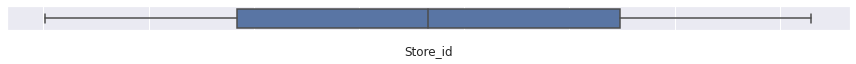

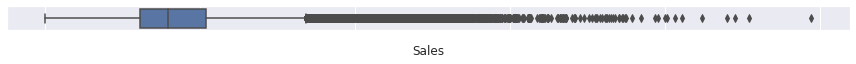

In [94]:
train['Holiday']=train.Holiday.astype(str)
n_unique = train.nunique()
print("Number of unique values:\n{}".format(n_unique))
print("Unique values in each categorical column:\n")
for col in train.select_dtypes(include=[object]):
    print(col,":", train[col].unique())
def boxes(x,data,h=None,r=30):                   #univariate analysis of numerical variables
    fig, ax = plt.subplots(figsize=(12,1))
    box = sns.boxplot(x=x, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.savefig('v'+x+'.png', format='png', dpi=1200)
for col in train.select_dtypes(include=[int,float]):
    boxes(col,train)


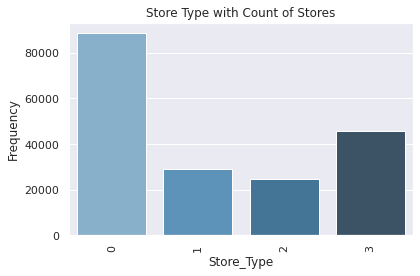

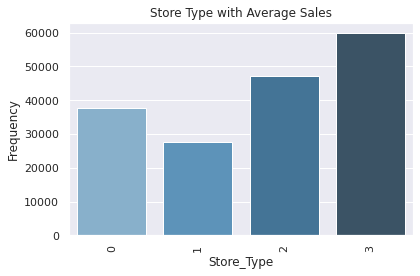

In [95]:
train['Year']=train.Date.dt.year
train['Month']=train.Date.dt.month
train['Week']=train.Date.dt.week
train['Day']=train.Date.dt.day
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
var_mod = ['Store_Type','Location_Type','Region_Code','Holiday','Discount']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])
sns.set()
top_store_types=train.groupby('Store_Type',as_index=False).count()[['Store_Type','Store_id']].sort_values(by='Store_id',ascending=False).iloc[0:10]
v1=sns.barplot(top_store_types.Store_Type,top_store_types.Store_id,palette='Blues_d')
v1.set_title('Store Type with Count of Stores')
v1.set_ylabel('Frequency')
v1.set_xticklabels(v1.get_xticklabels(), rotation=90)
plt.tight_layout()
# plt.savefig('v1.png', format='png', dpi=1200)

plt.show()
sns.set()
top_store_sales=train.groupby('Store_Type',as_index=False).mean()[['Store_Type','Sales']].sort_values(by='Store_Type',ascending=False).iloc[0:10]
v1=sns.barplot(top_store_sales.Store_Type,top_store_sales.Sales,palette='Blues_d')
v1.set_title('Store Type with Average Sales')
v1.set_ylabel('Frequency')
v1.set_xticklabels(v1.get_xticklabels(), rotation=90)
plt.tight_layout()
# plt.savefig('v1.png', format='png', dpi=1200)

plt.show()

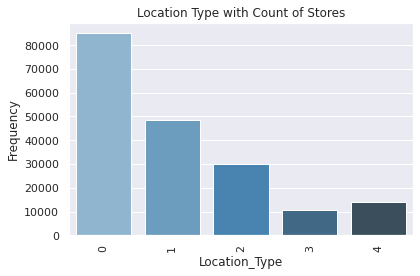

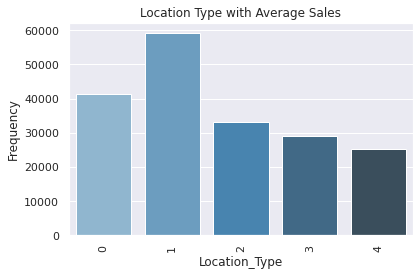

In [96]:
sns.set()
top_loc_types=train.groupby('Location_Type',as_index=False).count()[['Location_Type','Store_id']].sort_values(by='Store_id',ascending=False).iloc[0:10]
v1=sns.barplot(top_loc_types.Location_Type,top_loc_types.Store_id,palette='Blues_d')
v1.set_title('Location Type with Count of Stores')
v1.set_ylabel('Frequency')
v1.set_xticklabels(v1.get_xticklabels(), rotation=90)
plt.tight_layout()
# plt.savefig('v1.png', format='png', dpi=1200)

plt.show()

top_loc_sales=train.groupby('Location_Type',as_index=False).mean()[['Location_Type','Sales']].sort_values(by='Location_Type',ascending=False).iloc[0:10]
v1=sns.barplot(top_loc_sales.Location_Type,top_loc_sales.Sales,palette='Blues_d')
v1.set_title('Location Type with Average Sales')
v1.set_ylabel('Frequency')
v1.set_xticklabels(v1.get_xticklabels(), rotation=90)
plt.tight_layout()
# plt.savefig('v1.png', format='png', dpi=1200)

plt.show()

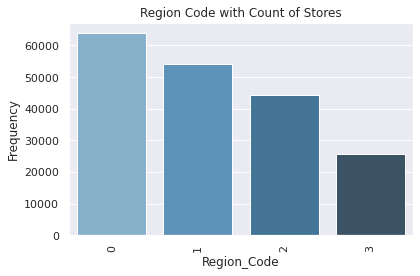

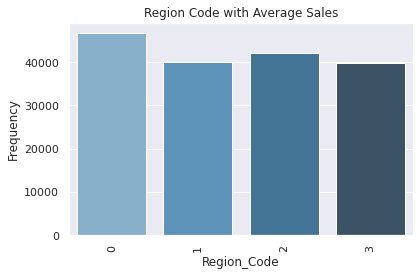

In [97]:
sns.set()
top_region_types=train.groupby('Region_Code',as_index=False).count()[['Region_Code','Store_id']].sort_values(by='Store_id',ascending=False).iloc[0:10]
v1=sns.barplot(top_region_types.Region_Code,top_region_types.Store_id,palette='Blues_d')
v1.set_title('Region Code with Count of Stores')
v1.set_ylabel('Frequency')
v1.set_xticklabels(v1.get_xticklabels(), rotation=90)
plt.tight_layout()
# plt.savefig('v1.png', format='png', dpi=1200)

plt.show()

sns.set()
top_region_sales=train.groupby('Region_Code',as_index=False).mean()[['Region_Code','Sales']].sort_values(by='Region_Code',ascending=False).iloc[0:10]
v1=sns.barplot(top_region_sales.Region_Code,top_region_sales.Sales,palette='Blues_d')
v1.set_title('Region Code with Average Sales')
v1.set_ylabel('Frequency')
v1.set_xticklabels(v1.get_xticklabels(), rotation=90)
plt.tight_layout()
# plt.savefig('v1.png', format='png', dpi=1200)

plt.show()

## Feature Engineering

In [98]:
train['Date']=pd.to_datetime(train.Date)
train['Year']=train.Date.dt.year
train['Month']=train.Date.dt.month
train['Week']=train.Date.dt.week
train['Day']=train.Date.dt.day

le1 = LabelEncoder()
train['date_block_num']=train.Date.dt.strftime('%Y%m')
train['date_block_num']=le1.fit_transform(train.date_block_num)

matrix=train[['date_block_num','Store_id']].drop_duplicates()
group = train.groupby(['date_block_num','Store_id']).agg({'Sales': ['mean']})
group.columns = ['Monthly_Sales']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, how='left')
matrix['Monthly_Sales'] = (matrix['Monthly_Sales']
                                .fillna(0)
                                .clip(lower=0) # NB clip target here
                                )

test['date_block_num']=np.where(test.Date<'2019-07-01',17,18)
matrix=pd.concat([matrix, test[['date_block_num','Store_id']]], ignore_index=True, sort=False)
matrix.fillna(0, inplace=True)

# LAG FEATURES

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','Store_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','Store_id',col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','Store_id'], how='left')
        df=df.drop_duplicates()
    return df


matrix = lag_feature(matrix, [1,2], 'Monthly_Sales')

group = matrix.groupby(['date_block_num']).agg({'Monthly_Sales': ['mean']})
group.columns = [ 'date_avg_Sales' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_Sales'] = matrix['date_avg_Sales'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_avg_Sales')
matrix.drop(['date_avg_Sales'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'Store_id']).agg({'Monthly_Sales': ['mean']})
group.columns = [ 'date_store_avg_Sales' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','Store_id'], how='left')
matrix['date_store_avg_Sales'] = matrix['date_store_avg_Sales'].astype(np.float16)

matrix = lag_feature(matrix, [1,2,3], 'date_store_avg_Sales')
matrix.drop(['date_store_avg_Sales'], axis=1, inplace=True)

matrix=pd.merge(matrix,train[['Store_id','Store_Type','Location_Type','Region_Code']].drop_duplicates(),on='Store_id',how='left')

group = matrix.groupby(['date_block_num', 'Store_Type' ]).agg({'Monthly_Sales': ['mean']})
group.columns = [ 'date_store_type_avg_Sales' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','Store_Type'], how='left')
matrix['date_store_type_avg_Sales'] = matrix['date_store_type_avg_Sales'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_store_type_avg_Sales')
matrix.drop(['date_store_type_avg_Sales'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'Location_Type' ]).agg({'Monthly_Sales': ['mean']})
group.columns = [ 'date_location_avg_Sales' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','Location_Type'], how='left')
matrix['date_location_avg_Sales'] = matrix['date_location_avg_Sales'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_location_avg_Sales')
matrix.drop(['date_location_avg_Sales'], axis=1, inplace=True)

group = matrix.groupby(['date_block_num', 'Region_Code' ]).agg({'Monthly_Sales': ['mean']})
group.columns = [ 'date_region_avg_Sales' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','Region_Code'], how='left')
matrix['date_region_avg_Sales'] = matrix['date_region_avg_Sales'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_region_avg_Sales')
matrix.drop(['date_region_avg_Sales'], axis=1, inplace=True)

#Trend Features

group = matrix.groupby(['date_block_num', 'Store_id']).agg({'Monthly_Sales': ['mean']})
group.columns = ['date_store_avg_Sales']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','Store_id'], how='left')
matrix['date_store_avg_Sales'] = matrix['date_store_avg_Sales'].astype(np.float16)

group = matrix.groupby(['Store_id']).agg({'Monthly_Sales': ['mean']})
group.columns = ['store_avg_Sales']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['Store_id'], how='left')
matrix['store_avg_Sales'] = matrix['store_avg_Sales'].astype(np.float16)

lags=[1,2,3]
for i in lags:
    matrix['delta_Sales_lag_'+str(i)] = \
        (matrix['date_store_avg_Sales_lag_'+str(i)] - matrix['store_avg_Sales']) / matrix['store_avg_Sales']

def select_trend(row):
    for i in lags:
        if row['delta_Sales_lag_'+str(i)]:
            return row['delta_Sales_lag_'+str(i)]
    return 0
    
matrix['delta_Sales_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_Sales_lag'] = matrix['delta_Sales_lag'].astype(np.float16)
matrix['delta_Sales_lag'].fillna(0, inplace=True)

features_to_drop = ['store_avg_Sales', 'date_store_avg_Sales']
for i in lags:
    features_to_drop += ['date_store_avg_Sales_lag_'+str(i)]
    features_to_drop += ['delta_Sales_lag_'+str(i)]


matrix.drop(features_to_drop,axis=1,inplace=True)

matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

data=matrix.copy()
data = data[data.date_block_num > 2]

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('Sales' in col):
                df[col].fillna(0, inplace=True)         
    return df

data = fill_na(data)

#SPLITTING INTO TRAIN, VALIDATION and TEST DATASETS
X_train = data[data.date_block_num < 15].drop(['Monthly_Sales'], axis=1)
Y_train = data[data.date_block_num < 15]['Monthly_Sales']
X_valid = data[data.date_block_num == 15].drop(['Monthly_Sales'], axis=1)
Y_valid = data[data.date_block_num == 15]['Monthly_Sales']
X_test = data[data.date_block_num == 16].drop(['Monthly_Sales'], axis=1)

X_train=pd.merge(train,X_train,on=['date_block_num','Store_id','Store_Type','Location_Type','Region_Code'])
X_valid=pd.merge(train,X_valid,on=['date_block_num','Store_id','Store_Type','Location_Type','Region_Code'])
X_test=pd.merge(train,X_test,on=['date_block_num','Store_id','Store_Type','Location_Type','Region_Code'])

y_train=X_train.Sales
y_valid=X_valid.Sales
y_test=X_test.Sales
X_train.shape,X_valid.shape,X_test.shape



((133225, 30), (10950, 30), (11315, 30))

In [99]:
X_train.drop(['Sales','Date','month'],axis=1,inplace=True)
X_valid.drop(['Sales','Date','month'],axis=1,inplace=True)
X_test.drop(['Sales','Date','month'],axis=1,inplace=True)

In [101]:
mod_cols=X_train.columns.tolist()

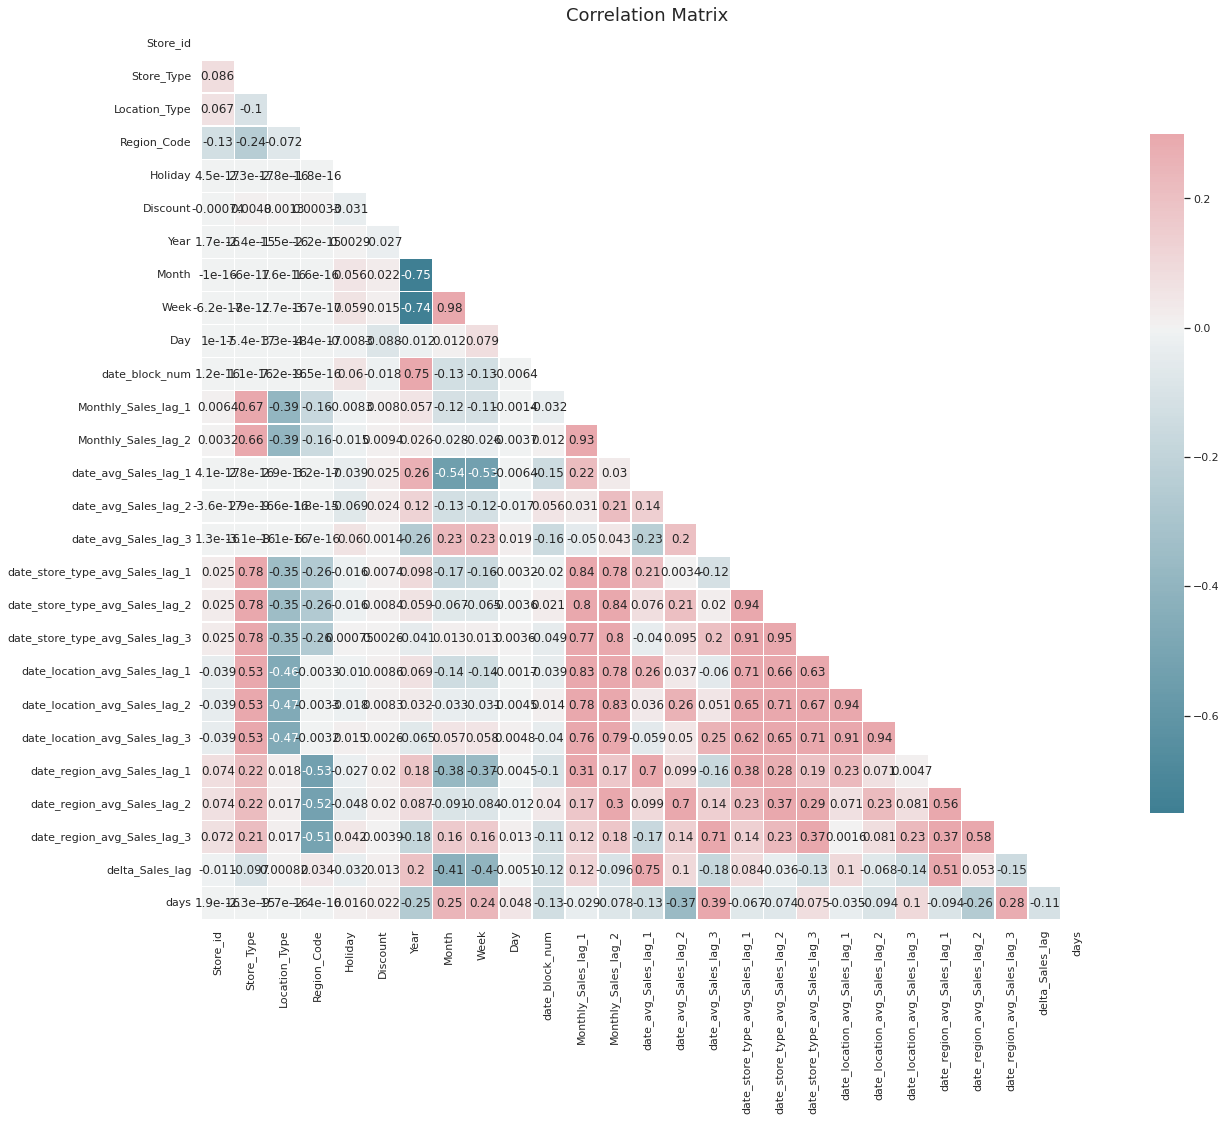

In [172]:
sns.set(style="white")
# train=train.drop(['ID','Date'],axis=1)
corr = X_train.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(10, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

## Model Selection

### XG Boost Model

In [16]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.001,0.01],
        'max_depth': [10,25],
        'min_child_weight': [5 ,10],
        'subsample': [0.5 ,0.7],
        'colsample_bytree': [0.5,0.8],
        'n_estimators' : [1000],
        'objective': ['reg:squarederror'],
        'reg_alpha':[0,0.01,0.05],
        'reg_lambda':[0,0.01,0.05],
    }

    xgb_model = XGBRegressor(random_state=42)

    gsearch = RandomizedSearchCV(estimator = xgb_model,
                   param_distributions = param_tuning,                        
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 3, verbose=100, n_iter=5)

    gsearch.fit(X_train,y_train,eval_metric='rmse',eval_set=[(X_train, y_train), (X_valid, y_valid)],early_stopping_rounds=20)

    return gsearch
xgb_random=hyperParameterTuning(X_train,y_train)

Streaming output truncated to the last 5000 lines.
[961]	validation_0-rmse:20163.4	validation_1-rmse:21764.8
[962]	validation_0-rmse:20148.1	validation_1-rmse:21752.2
[963]	validation_0-rmse:20132.2	validation_1-rmse:21739.5
[964]	validation_0-rmse:20117.3	validation_1-rmse:21727.1
[965]	validation_0-rmse:20101.8	validation_1-rmse:21714.9
[966]	validation_0-rmse:20086.2	validation_1-rmse:21701.9
[967]	validation_0-rmse:20069.9	validation_1-rmse:21688.8
[968]	validation_0-rmse:20054.5	validation_1-rmse:21675.6
[969]	validation_0-rmse:20039	validation_1-rmse:21664.2
[970]	validation_0-rmse:20023.7	validation_1-rmse:21652.3
[971]	validation_0-rmse:20008.7	validation_1-rmse:21641.5
[972]	validation_0-rmse:19993.6	validation_1-rmse:21629.1
[973]	validation_0-rmse:19978.3	validation_1-rmse:21618.2
[974]	validation_0-rmse:19963.2	validation_1-rmse:21606.2
[975]	validation_0-rmse:19947.7	validation_1-rmse:21593.4
[976]	validation_0-rmse:19932.9	validation_1-rmse:21581.1
[977]	validation_0-rmse

In [17]:
best_xgb_model=xgb_random.best_estimator_
best_xgb_model
xgb_test_pred=best_xgb_model.predict(X_test)
xgb_valid_pred=best_xgb_model.predict(X_valid)
xgb_train_pred=best_xgb_model.predict(X_train)
print('Train MSLE:',mean_squared_log_error(y_train,xgb_train_pred)*1000)
print('Validation MSLE:',mean_squared_log_error(y_valid,xgb_valid_pred)*1000)
print('Test MSLE:',mean_squared_log_error(y_test,xgb_test_pred)*1000)

Train MSLE: 52.50678232831417
Validation MSLE: 133.3400457823734
Test MSLE: 86.18163627093415


In [19]:
pickle.dump(best_xgb_model, open(r'xgb_best_fin.sav', 'wb'))
pd.DataFrame(xgb_train_pred).to_csv('xgb_train_pred.csv')
pd.DataFrame(xgb_valid_pred).to_csv('xgb_val_pred.csv')
pd.DataFrame(xgb_test_pred).to_csv('xgb_test_pred.csv')

### MLP Deep Learning Sequential Architecture

In [25]:
epochs = 500
batch = 64
lr = 0.0001
nadam = optimizers.Adam(lr)
model_mlp = Sequential()
model_mlp.add(Dense(200, activation='relu', input_dim=tf.keras.utils.normalize(X_train).shape[1]))
model_mlp.add(Dense(100, activation='relu'))
model_mlp.add(Dense(50, activation='relu'))
model_mlp.add(Dense(25, activation='relu'))
model_mlp.add(Dense(5,activation='relu'))
model_mlp.add(Dense(1))
# mc = ModelCheckpoint('best_model_mlp_ml.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
model_mlp.compile(loss='msle', optimizer=nadam)
# model_mlp.load_model('model_mlp_fin.pickle')
model_mlp.load_weights('best_model_mlp_ml.h5')

In [ ]:
# mlp_history = model_mlp.fit(tf.keras.utils.normalize(X_train), y_train, validation_data=(tf.keras.utils.normalize(X_valid), y_valid), epochs=epochs, callbacks=[es,mc])

Epoch 1/500
4164/4164 [==============================] - 10s 2ms/step - loss: 21.8300 - val_loss: 1.5757
Epoch 2/500
4164/4164 [==============================] - 10s 2ms/step - loss: 0.4969 - val_loss: 0.2215
Epoch 3/500
4164/4164 [==============================] - 9s 2ms/step - loss: 0.2252 - val_loss: 0.2101
Epoch 4/500
4164/4164 [==============================] - 9s 2ms/step - loss: 0.2050 - val_loss: 0.1812
Epoch 5/500
4164/4164 [==============================] - 9s 2ms/step - loss: 0.1728 - val_loss: 0.1492
Epoch 6/500
4164/4164 [==============================] - 9s 2ms/step - loss: 0.1523 - val_loss: 0.1416
Epoch 7/500
4164/4164 [==============================] - 9s 2ms/step - loss: 0.1494 - val_loss: 0.1412
Epoch 8/500
4164/4164 [==============================] - 9s 2ms/step - loss: 0.1486 - val_loss: 0.1413
Epoch 9/500
4164/4164 [==============================] - 9s 2ms/step - loss: 0.1479 - val_loss: 0.1403
Epoch 10/500
4164/4164 [==============================] - 9s 2ms/step 

In [27]:
model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               5600      
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 130       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 32,161
Trainable params: 32,161
Non-trainable params: 0
__________________________________________________

In [29]:
# mlp_train_pred=pd.read_csv('mlp_train_pred.csv')
# mlp_valid_pred=pd.read_csv('mlp_val_pred.csv')
# mlp_test_pred=pd.read_csv('mlp_test_pred.csv')
mlp_train_pred=mlp_train_pred.iloc[:,1].values
mlp_valid_pred=mlp_valid_pred.iloc[:,1].values
mlp_test_pred=mlp_test_pred.iloc[:,1].values

### KNN Model

In [120]:
train_X_copy=X_train.copy()
valid_X_copy=X_valid.copy()
test_X_copy=X_test.copy()
cols=['date_store_type_avg_Sales_lag_1','date_store_type_avg_Sales_lag_2','date_store_type_avg_Sales_lag_3','delta_Sales_lag','date_location_avg_Sales_lag_1','date_location_avg_Sales_lag_2']
train_X_copy.drop(cols,axis=1,inplace=True)
valid_X_copy.drop(cols,axis=1,inplace=True)
test_X_copy.drop(cols,axis=1,inplace=True)

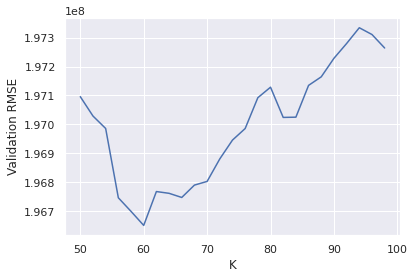

Optimum K:60

Retraining with K=60

K Nearest Neighbours Done!

Train MSLE: 85.46285983089193
Validation MSLE: 142.0628596058021
Test MSLE: 76.67118500744317


In [121]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(train_X_copy)
knn_train = knn_scaler.transform(train_X_copy)
knn_valid = knn_scaler.transform(valid_X_copy)
knn_test = knn_scaler.transform(test_X_copy)
knn_r_acc = []
for i in range(50,100,2):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(knn_train,y_train)
    y_pred=knn.predict(knn_valid)
    ac=mean_squared_error(y_valid,y_pred.clip(min=0))
    knn_r_acc.append((i, ac))
df = pd.DataFrame(knn_r_acc, columns=['K','Validation RMSE'])
plt.figure()
sns.lineplot(df['K'],df['Validation RMSE'])
plt.show()
opt_k=df[df['Validation RMSE']==df['Validation RMSE'].min()]['K']
if type(opt_k)!='pandas.core.series.Series':
    opt_k=opt_k.tolist()[0]
print('Optimum K:'+str(opt_k)+'\n')
print('Retraining with K='+str(opt_k)+'\n')
knn_best = KNeighborsRegressor(n_neighbors=opt_k)
knn_best.fit(knn_train,y_train)
knn_pred_train = knn_best.predict(knn_train)
knn_pred_val = knn_best.predict(knn_valid)
knn_pred_test = knn_best.predict(knn_test)
print('K Nearest Neighbours Done!\n')
print('Train MSLE:',mean_squared_log_error(y_train,knn_pred_train.clip(min=0))*1000)
print('Validation MSLE:',mean_squared_log_error(y_valid,knn_pred_val.clip(min=0))*1000)
print('Test MSLE:',mean_squared_log_error(y_test,knn_pred_test.clip(min=0))*1000)

In [122]:
pickle.dump(knn_best, open(r'knn_best_fin.sav', 'wb'))
pd.DataFrame(knn_pred_train).to_csv('knn_train_pred.csv')
pd.DataFrame(knn_pred_val).to_csv('knn_val_pred.csv')
pd.DataFrame(knn_pred_test).to_csv('knn_test_pred.csv')

### Catboost Model

In [ ]:
clf = CatBoostRegressor(thread_count=2,
                         od_type = 'Iter',
                         verbose= 20,
                        eval_metric='MSLE',
                        task_type='GPU'
                        )
search_spaces = {'iterations': Integer(100, 800),
                 'depth': Integer(1, 16),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 20, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(0, 30)}
opt = BayesSearchCV(clf,
                    search_spaces,
                    cv=3,
                    n_iter=200,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

bsearch=opt.fit(X_train,y_train,eval_set=(X_valid,y_valid))

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2589045	test: 0.2272386	best: 0.2272386 (0)	total: 105ms	remaining: 33.7s
20:	learn: 0.1117886	test: 0.1442591	best: 0.1442591 (20)	total: 2.02s	remaining: 28.9s
40:	learn: 0.0746172	test: 0.1287732	best: 0.1287732 (40)	total: 3.93s	remaining: 26.8s
60:	learn: 0.0629766	test: 0.1261753	best: 0.1261753 (60)	total: 5.82s	remaining: 24.8s
80:	learn: 0.0563770	test: 0.1257906	best: 0.1254312 (74)	total: 7.73s	remaining: 22.9s
bestTest = 0.1254311658
bestIteration = 74
Shrink model to first 75 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1948859	test: 0.2438295	best: 0.2438295 (0)	total: 95.9ms	remaining: 30.7s
20:	learn: 0.0786343	test: 0.1610833	best: 0.1610833 (20)	total: 1.99s	remaining: 28.4s
40:	learn: 0.0547530	test: 0.1399164	best: 0.1399164 (40)	total: 3.89s	remaining: 26.5s
60:	learn: 0.0448471	test: 0.1359295	best: 0.1359295 (60)	total: 5.77s	remaining: 24.6s
80:	learn: 0.0408131	test: 0.1349803	best: 0.1348245 (79)	total: 7.67s	remaining: 22.7s
100:	learn: 0.0386541	test: 0.1346671	best: 0.1345348 (99)	total: 9.57s	remaining: 20.9s
120:	learn: 0.0371357	test: 0.1346624	best: 0.1343856 (108)	total: 11.5s	remaining: 19s
bestTest = 0.134385565
bestIteration = 108
Shrink model to first 109 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2211679	test: 0.2325182	best: 0.2325182 (0)	total: 95.7ms	remaining: 30.6s
20:	learn: 0.0875012	test: 0.1514853	best: 0.1514853 (20)	total: 1.99s	remaining: 28.5s
40:	learn: 0.0613630	test: 0.1379204	best: 0.1379204 (40)	total: 3.89s	remaining: 26.5s
60:	learn: 0.0535042	test: 0.1347613	best: 0.1347613 (60)	total: 5.79s	remaining: 24.7s
80:	learn: 0.0493151	test: 0.1341868	best: 0.1340459 (77)	total: 7.69s	remaining: 22.8s
100:	learn: 0.0470784	test: 0.1339926	best: 0.1339725 (99)	total: 9.6s	remaining: 20.9s
120:	learn: 0.0456886	test: 0.1335402	best: 0.1334811 (117)	total: 11.5s	remaining: 19s
140:	learn: 0.0445622	test: 0.1336448	best: 0.1334596 (122)	total: 13.4s	remaining: 17.1s
bestTest = 0.1334595963
bestIteration = 122
Shrink model to first 123 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2715185	test: 0.2345934	best: 0.2345934 (0)	total: 9.29ms	remaining: 7.11s
20:	learn: 0.2244558	test: 0.1952931	best: 0.1952931 (20)	total: 165ms	remaining: 5.84s
40:	learn: 0.1942470	test: 0.1701978	best: 0.1701978 (40)	total: 314ms	remaining: 5.55s
60:	learn: 0.1735617	test: 0.1539084	best: 0.1539084 (60)	total: 468ms	remaining: 5.41s
80:	learn: 0.1598264	test: 0.1430727	best: 0.1430727 (80)	total: 623ms	remaining: 5.27s
100:	learn: 0.1493465	test: 0.1362834	best: 0.1362834 (100)	total: 778ms	remaining: 5.12s
120:	learn: 0.1413331	test: 0.1319069	best: 0.1319069 (120)	total: 948ms	remaining: 5.05s
140:	learn: 0.1345025	test: 0.1293981	best: 0.1293981 (140)	total: 1.1s	remaining: 4.87s
160:	learn: 0.1291398	test: 0.1278956	best: 0.1278956 (160)	total: 1.26s	remaining: 4.73s
180:	learn: 0.1238192	test: 0.1270945	best: 0.1270814 (178)	total: 1.42s	remaining: 4.58s
200:	learn: 0.1200833	test: 0.1267251	best: 0.1267187 (199)	total: 1.58s	remaining: 4.44s
220:	learn: 0.1150014	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2061705	test: 0.2525410	best: 0.2525410 (0)	total: 8.91ms	remaining: 6.82s
20:	learn: 0.1656574	test: 0.2123626	best: 0.2123626 (20)	total: 167ms	remaining: 5.94s
40:	learn: 0.1397939	test: 0.1844699	best: 0.1844699 (40)	total: 319ms	remaining: 5.64s
60:	learn: 0.1228617	test: 0.1652833	best: 0.1652833 (60)	total: 472ms	remaining: 5.45s
80:	learn: 0.1112376	test: 0.1524717	best: 0.1524717 (80)	total: 625ms	remaining: 5.29s
100:	learn: 0.1029704	test: 0.1440434	best: 0.1440434 (100)	total: 779ms	remaining: 5.13s
120:	learn: 0.0970296	test: 0.1381119	best: 0.1381119 (120)	total: 937ms	remaining: 4.99s
140:	learn: 0.0918461	test: 0.1343171	best: 0.1343171 (140)	total: 1.09s	remaining: 4.85s
160:	learn: 0.0867869	test: 0.1325369	best: 0.1324308 (159)	total: 1.25s	remaining: 4.71s
180:	learn: 0.0829664	test: 0.1309105	best: 0.1309105 (180)	total: 1.4s	remaining: 4.52s
200:	learn: 0.0796896	test: 0.1304084	best: 0.1302896 (194)	total: 1.55s	remaining: 4.37s
220:	learn: 0.0769319	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2333992	test: 0.2395573	best: 0.2395573 (0)	total: 9.08ms	remaining: 6.95s
20:	learn: 0.1879320	test: 0.1998945	best: 0.1998945 (20)	total: 168ms	remaining: 5.96s
40:	learn: 0.1587912	test: 0.1752389	best: 0.1752389 (40)	total: 317ms	remaining: 5.61s
60:	learn: 0.1393647	test: 0.1591582	best: 0.1591582 (60)	total: 470ms	remaining: 5.43s
80:	learn: 0.1260004	test: 0.1481995	best: 0.1481995 (80)	total: 629ms	remaining: 5.32s
100:	learn: 0.1162611	test: 0.1407402	best: 0.1407402 (100)	total: 781ms	remaining: 5.14s
120:	learn: 0.1092565	test: 0.1358762	best: 0.1358762 (120)	total: 939ms	remaining: 5s
140:	learn: 0.1032448	test: 0.1328761	best: 0.1328761 (140)	total: 1.08s	remaining: 4.81s
160:	learn: 0.0979762	test: 0.1308529	best: 0.1308529 (160)	total: 1.25s	remaining: 4.7s
180:	learn: 0.0937647	test: 0.1295172	best: 0.1295172 (180)	total: 1.42s	remaining: 4.58s
200:	learn: 0.0898426	test: 0.1284281	best: 0.1284281 (200)	total: 1.58s	remaining: 4.44s
220:	learn: 0.0873754	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2602062	test: 0.2238172	best: 0.2238172 (0)	total: 7.16ms	remaining: 2.88s
20:	learn: 0.1575156	test: 0.1381019	best: 0.1381019 (20)	total: 134ms	remaining: 2.43s
40:	learn: 0.1340409	test: 0.1255580	best: 0.1255580 (40)	total: 262ms	remaining: 2.31s
60:	learn: 0.1246509	test: 0.1252610	best: 0.1247370 (50)	total: 373ms	remaining: 2.09s
bestTest = 0.1247370114
bestIteration = 50
Shrink model to first 51 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1954093	test: 0.2427455	best: 0.2427455 (0)	total: 7.11ms	remaining: 2.86s
20:	learn: 0.1085591	test: 0.1504015	best: 0.1504015 (20)	total: 137ms	remaining: 2.49s
40:	learn: 0.0914495	test: 0.1323039	best: 0.1322179 (39)	total: 270ms	remaining: 2.38s
60:	learn: 0.0847301	test: 0.1276831	best: 0.1275504 (58)	total: 408ms	remaining: 2.29s
80:	learn: 0.0808944	test: 0.1256615	best: 0.1256615 (80)	total: 535ms	remaining: 2.13s
100:	learn: 0.0752496	test: 0.1260832	best: 0.1252755 (86)	total: 660ms	remaining: 1.97s
bestTest = 0.1252755064
bestIteration = 86
Shrink model to first 87 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2220409	test: 0.2281250	best: 0.2281250 (0)	total: 7.07ms	remaining: 2.84s
20:	learn: 0.1222769	test: 0.1388742	best: 0.1388742 (20)	total: 129ms	remaining: 2.35s
40:	learn: 0.1027587	test: 0.1276112	best: 0.1275781 (39)	total: 251ms	remaining: 2.22s
60:	learn: 0.0924919	test: 0.1252666	best: 0.1252292 (55)	total: 360ms	remaining: 2.02s
80:	learn: 0.0852855	test: 0.1248784	best: 0.1247259 (66)	total: 488ms	remaining: 1.94s
100:	learn: 0.0806809	test: 0.1242198	best: 0.1236617 (92)	total: 626ms	remaining: 1.87s
120:	learn: 0.0780592	test: 0.1244152	best: 0.1235340 (103)	total: 757ms	remaining: 1.76s
bestTest = 0.123534014
bestIteration = 103
Shrink model to first 104 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2708045	test: 0.2340265	best: 0.2340265 (0)	total: 13ms	remaining: 8.57s
20:	learn: 0.2113181	test: 0.1896824	best: 0.1896824 (20)	total: 255ms	remaining: 7.79s
40:	learn: 0.1727475	test: 0.1632556	best: 0.1632556 (40)	total: 496ms	remaining: 7.51s
60:	learn: 0.1462200	test: 0.1482137	best: 0.1482137 (60)	total: 740ms	remaining: 7.29s
80:	learn: 0.1268827	test: 0.1395251	best: 0.1395251 (80)	total: 981ms	remaining: 7.03s
100:	learn: 0.1134992	test: 0.1341068	best: 0.1341068 (100)	total: 1.2s	remaining: 6.68s
120:	learn: 0.1040051	test: 0.1308500	best: 0.1308500 (120)	total: 1.43s	remaining: 6.41s
140:	learn: 0.0977044	test: 0.1287327	best: 0.1287327 (140)	total: 1.69s	remaining: 6.25s
160:	learn: 0.0920499	test: 0.1279648	best: 0.1277914 (159)	total: 1.93s	remaining: 6.02s
180:	learn: 0.0873331	test: 0.1274715	best: 0.1272352 (176)	total: 2.17s	remaining: 5.77s
bestTest = 0.1272352094
bestIteration = 176
Shrink model to first 177 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2054109	test: 0.2520317	best: 0.2520317 (0)	total: 13.3ms	remaining: 8.81s
20:	learn: 0.1550675	test: 0.2066822	best: 0.2066822 (20)	total: 245ms	remaining: 7.49s
40:	learn: 0.1240460	test: 0.1789726	best: 0.1789726 (40)	total: 482ms	remaining: 7.3s
60:	learn: 0.1040982	test: 0.1604499	best: 0.1604499 (60)	total: 723ms	remaining: 7.12s
80:	learn: 0.0901967	test: 0.1492663	best: 0.1492663 (80)	total: 960ms	remaining: 6.89s
100:	learn: 0.0809876	test: 0.1418556	best: 0.1418556 (100)	total: 1.19s	remaining: 6.61s
120:	learn: 0.0741442	test: 0.1374532	best: 0.1374532 (120)	total: 1.41s	remaining: 6.3s
140:	learn: 0.0689396	test: 0.1347416	best: 0.1347416 (140)	total: 1.64s	remaining: 6.05s
160:	learn: 0.0641339	test: 0.1339998	best: 0.1338712 (159)	total: 1.87s	remaining: 5.82s
180:	learn: 0.0607282	test: 0.1331916	best: 0.1331916 (180)	total: 2.09s	remaining: 5.57s
200:	learn: 0.0574480	test: 0.1333590	best: 0.1331916 (180)	total: 2.32s	remaining: 5.33s
bestTest = 0.1331916469

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2326783	test: 0.2392515	best: 0.2392515 (0)	total: 13.5ms	remaining: 8.9s
20:	learn: 0.1761300	test: 0.1987885	best: 0.1987885 (20)	total: 235ms	remaining: 7.16s
40:	learn: 0.1402413	test: 0.1740528	best: 0.1740528 (40)	total: 457ms	remaining: 6.92s
60:	learn: 0.1167772	test: 0.1572972	best: 0.1572972 (60)	total: 687ms	remaining: 6.77s
80:	learn: 0.1010070	test: 0.1463875	best: 0.1463875 (80)	total: 914ms	remaining: 6.55s
100:	learn: 0.0903084	test: 0.1394455	best: 0.1394455 (100)	total: 1.14s	remaining: 6.32s
120:	learn: 0.0828797	test: 0.1354883	best: 0.1354883 (120)	total: 1.36s	remaining: 6.09s
140:	learn: 0.0775353	test: 0.1322660	best: 0.1322660 (140)	total: 1.58s	remaining: 5.86s
160:	learn: 0.0733863	test: 0.1304127	best: 0.1304127 (160)	total: 1.81s	remaining: 5.64s
180:	learn: 0.0696129	test: 0.1290886	best: 0.1290886 (180)	total: 2.04s	remaining: 5.43s
200:	learn: 0.0665926	test: 0.1279953	best: 0.1279953 (200)	total: 2.27s	remaining: 5.2s
220:	learn: 0.0639352	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2185914	test: 0.1906763	best: 0.1906763 (0)	total: 11.3ms	remaining: 6.76s
20:	learn: 0.0688577	test: 0.1291553	best: 0.1278322 (10)	total: 232ms	remaining: 6.41s
bestTest = 0.1278322425
bestIteration = 10
Shrink model to first 11 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1594621	test: 0.2060656	best: 0.2060656 (0)	total: 11.3ms	remaining: 6.75s
20:	learn: 0.0490707	test: 0.1910137	best: 0.1408330 (6)	total: 232ms	remaining: 6.41s
bestTest = 0.1408329915
bestIteration = 6
Shrink model to first 7 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1803979	test: 0.1997642	best: 0.1997642 (0)	total: 12ms	remaining: 7.23s
20:	learn: 0.0579597	test: 0.1267466	best: 0.1258918 (16)	total: 218ms	remaining: 6.03s
bestTest = 0.1258918412
bestIteration = 16
Shrink model to first 17 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2651998	test: 0.2291034	best: 0.2291034 (0)	total: 7.21ms	remaining: 1.67s
20:	learn: 0.1754723	test: 0.1501521	best: 0.1501521 (20)	total: 130ms	remaining: 1.3s
40:	learn: 0.1477310	test: 0.1303642	best: 0.1303642 (40)	total: 266ms	remaining: 1.24s
60:	learn: 0.1342596	test: 0.1258159	best: 0.1258159 (60)	total: 398ms	remaining: 1.11s
80:	learn: 0.1259924	test: 0.1250247	best: 0.1250247 (80)	total: 529ms	remaining: 987ms
100:	learn: 0.1203631	test: 0.1256010	best: 0.1250247 (80)	total: 665ms	remaining: 862ms
bestTest = 0.1250246835
bestIteration = 80
Shrink model to first 81 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1994673	test: 0.2465064	best: 0.2465064 (0)	total: 7.95ms	remaining: 1.83s
20:	learn: 0.1201199	test: 0.1643619	best: 0.1643619 (20)	total: 128ms	remaining: 1.28s
40:	learn: 0.0998764	test: 0.1398198	best: 0.1398198 (40)	total: 247ms	remaining: 1.15s
60:	learn: 0.0916475	test: 0.1316267	best: 0.1316267 (60)	total: 361ms	remaining: 1.01s
80:	learn: 0.0872153	test: 0.1279804	best: 0.1279804 (80)	total: 483ms	remaining: 901ms
100:	learn: 0.0841061	test: 0.1254918	best: 0.1254918 (100)	total: 609ms	remaining: 790ms
120:	learn: 0.0807495	test: 0.1249142	best: 0.1246729 (112)	total: 736ms	remaining: 676ms
140:	learn: 0.0782104	test: 0.1248368	best: 0.1245125 (131)	total: 856ms	remaining: 553ms
bestTest = 0.1245125238
bestIteration = 131
Shrink model to first 132 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2263840	test: 0.2323613	best: 0.2323613 (0)	total: 7.21ms	remaining: 1.67s
20:	learn: 0.1379606	test: 0.1491147	best: 0.1491147 (20)	total: 133ms	remaining: 1.34s
40:	learn: 0.1131821	test: 0.1328256	best: 0.1328256 (40)	total: 263ms	remaining: 1.23s
60:	learn: 0.1031428	test: 0.1272468	best: 0.1272468 (60)	total: 387ms	remaining: 1.08s
80:	learn: 0.0957339	test: 0.1257206	best: 0.1256373 (71)	total: 518ms	remaining: 965ms
100:	learn: 0.0898346	test: 0.1247392	best: 0.1247392 (100)	total: 657ms	remaining: 852ms
120:	learn: 0.0859427	test: 0.1244823	best: 0.1244823 (120)	total: 780ms	remaining: 716ms
140:	learn: 0.0830561	test: 0.1234288	best: 0.1233495 (139)	total: 912ms	remaining: 588ms
160:	learn: 0.0811116	test: 0.1235714	best: 0.1228727 (147)	total: 1.05s	remaining: 461ms
bestTest = 0.1228727108
bestIteration = 147
Shrink model to first 148 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2417884	test: 0.2093960	best: 0.2093960 (0)	total: 9.02ms	remaining: 6.42s
20:	learn: 0.1069831	test: 0.1280801	best: 0.1273436 (16)	total: 160ms	remaining: 5.25s
40:	learn: 0.0820768	test: 0.1319261	best: 0.1267060 (26)	total: 307ms	remaining: 5.03s
bestTest = 0.126705986
bestIteration = 26
Shrink model to first 27 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1807382	test: 0.2275275	best: 0.2275275 (0)	total: 9.21ms	remaining: 6.55s
20:	learn: 0.0703790	test: 0.1354826	best: 0.1301815 (17)	total: 173ms	remaining: 5.69s
bestTest = 0.1301815496
bestIteration = 17
Shrink model to first 18 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2045747	test: 0.2152601	best: 0.2152601 (0)	total: 9.86ms	remaining: 7.01s
20:	learn: 0.0835612	test: 0.1251272	best: 0.1251272 (20)	total: 183ms	remaining: 6.01s
40:	learn: 0.0660131	test: 0.1221852	best: 0.1221852 (40)	total: 334ms	remaining: 5.47s
60:	learn: nan	test: 0.1238035	best: 0.1219432 (41)	total: 497ms	remaining: 5.3s
bestTest = 0.1219431614
bestIteration = 41
Shrink model to first 42 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2714759	test: 0.2345691	best: 0.2345691 (0)	total: 11.8ms	remaining: 8.07s
20:	learn: 0.2228303	test: 0.1955802	best: 0.1955802 (20)	total: 224ms	remaining: 7.1s
40:	learn: 0.1897372	test: 0.1703072	best: 0.1703072 (40)	total: 422ms	remaining: 6.64s
60:	learn: 0.1658545	test: 0.1542131	best: 0.1542131 (60)	total: 590ms	remaining: 6.04s
80:	learn: 0.1488975	test: 0.1440057	best: 0.1440057 (80)	total: 785ms	remaining: 5.87s
100:	learn: 0.1366049	test: 0.1371934	best: 0.1371934 (100)	total: 995ms	remaining: 5.76s
120:	learn: 0.1270056	test: 0.1328552	best: 0.1328552 (120)	total: 1.19s	remaining: 5.56s
140:	learn: 0.1197453	test: 0.1302476	best: 0.1302476 (140)	total: 1.4s	remaining: 5.4s
160:	learn: 0.1138199	test: 0.1286666	best: 0.1286666 (160)	total: 1.59s	remaining: 5.18s
180:	learn: 0.1087076	test: 0.1279023	best: 0.1279023 (180)	total: 1.78s	remaining: 4.96s
200:	learn: 0.1043747	test: 0.1271366	best: 0.1271095 (197)	total: 1.96s	remaining: 4.73s
220:	learn: 0.0995987	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2061278	test: 0.2525180	best: 0.2525180 (0)	total: 10.6ms	remaining: 7.24s
20:	learn: 0.1643438	test: 0.2119409	best: 0.2119409 (20)	total: 194ms	remaining: 6.14s
40:	learn: 0.1372125	test: 0.1842643	best: 0.1842643 (40)	total: 366ms	remaining: 5.75s
60:	learn: 0.1190352	test: 0.1664150	best: 0.1664150 (60)	total: 541ms	remaining: 5.54s
80:	learn: 0.1060959	test: 0.1541441	best: 0.1541441 (80)	total: 721ms	remaining: 5.38s
100:	learn: 0.0964207	test: 0.1465745	best: 0.1465745 (100)	total: 914ms	remaining: 5.29s
120:	learn: 0.0891839	test: 0.1417342	best: 0.1417342 (120)	total: 1.11s	remaining: 5.17s
140:	learn: 0.0833749	test: 0.1380773	best: 0.1380773 (140)	total: 1.3s	remaining: 5.01s
160:	learn: 0.0780488	test: 0.1366688	best: 0.1365669 (159)	total: 1.48s	remaining: 4.83s
180:	learn: 0.0740016	test: 0.1365961	best: 0.1362926 (169)	total: 1.68s	remaining: 4.68s
bestTest = 0.1362925966
bestIteration = 169
Shrink model to first 170 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2333542	test: 0.2396882	best: 0.2396882 (0)	total: 10.6ms	remaining: 7.25s
20:	learn: 0.1866945	test: 0.2027666	best: 0.2027666 (20)	total: 211ms	remaining: 6.67s
40:	learn: 0.1551697	test: 0.1789898	best: 0.1789898 (40)	total: 395ms	remaining: 6.22s
60:	learn: 0.1338797	test: 0.1619975	best: 0.1619975 (60)	total: 596ms	remaining: 6.11s
80:	learn: 0.1189038	test: 0.1510532	best: 0.1510532 (80)	total: 794ms	remaining: 5.93s
100:	learn: 0.1076550	test: 0.1431054	best: 0.1431054 (100)	total: 990ms	remaining: 5.74s
120:	learn: 0.0995642	test: 0.1378916	best: 0.1378916 (120)	total: 1.19s	remaining: 5.55s
140:	learn: 0.0936001	test: 0.1341427	best: 0.1341427 (140)	total: 1.38s	remaining: 5.35s
160:	learn: 0.0886307	test: 0.1314484	best: 0.1314484 (160)	total: 1.59s	remaining: 5.17s
180:	learn: 0.0846775	test: 0.1298479	best: 0.1298479 (180)	total: 1.79s	remaining: 5s
200:	learn: 0.0809680	test: 0.1285605	best: 0.1285605 (200)	total: 1.99s	remaining: 4.8s
220:	learn: 0.0772664	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2676787	test: 0.2333893	best: 0.2333893 (0)	total: 54.4ms	remaining: 21.2s
20:	learn: 0.1746814	test: 0.1780439	best: 0.1780439 (20)	total: 1.13s	remaining: 19.8s
40:	learn: 0.1261301	test: 0.1509178	best: 0.1509178 (40)	total: 2.19s	remaining: 18.7s
60:	learn: 0.0978533	test: 0.1385318	best: 0.1385318 (60)	total: 3.25s	remaining: 17.6s
80:	learn: 0.0825477	test: 0.1326246	best: 0.1326246 (80)	total: 4.3s	remaining: 16.5s
100:	learn: 0.0741621	test: 0.1294193	best: 0.1292143 (99)	total: 5.37s	remaining: 15.4s
120:	learn: 0.0687119	test: 0.1280215	best: 0.1280215 (120)	total: 6.43s	remaining: 14.4s
140:	learn: 0.0634562	test: 0.1271849	best: 0.1270602 (134)	total: 7.51s	remaining: 13.3s
160:	learn: 0.0604581	test: 0.1261626	best: 0.1261626 (160)	total: 8.58s	remaining: 12.3s
180:	learn: 0.0579718	test: 0.1262749	best: 0.1259378 (171)	total: 9.65s	remaining: 11.2s
bestTest = 0.1259378364
bestIteration = 171
Shrink model to first 172 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2028978	test: 0.2502927	best: 0.2502927 (0)	total: 55.2ms	remaining: 21.5s
20:	learn: 0.1258819	test: 0.1890287	best: 0.1890287 (20)	total: 1.12s	remaining: 19.8s
40:	learn: 0.0888610	test: 0.1618038	best: 0.1618038 (40)	total: 2.17s	remaining: 18.6s
60:	learn: 0.0693320	test: 0.1459339	best: 0.1459339 (60)	total: 3.22s	remaining: 17.4s
80:	learn: 0.0588528	test: 0.1386020	best: 0.1386020 (80)	total: 4.26s	remaining: 16.3s
100:	learn: 0.0529472	test: 0.1349512	best: 0.1349512 (100)	total: 5.32s	remaining: 15.3s
120:	learn: 0.0488809	test: 0.1333567	best: 0.1333567 (120)	total: 6.38s	remaining: 14.2s
140:	learn: 0.0464914	test: 0.1324485	best: 0.1324323 (139)	total: 7.44s	remaining: 13.2s
160:	learn: 0.0440900	test: 0.1321221	best: 0.1321221 (160)	total: 8.51s	remaining: 12.2s
180:	learn: 0.0425696	test: 0.1318554	best: 0.1318367 (178)	total: 9.57s	remaining: 11.1s
200:	learn: 0.0410882	test: 0.1318017	best: 0.1317096 (190)	total: 10.6s	remaining: 10.1s
bestTest = 0.13170955

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2299246	test: 0.2378081	best: 0.2378081 (0)	total: 53.9ms	remaining: 21s
20:	learn: 0.1436296	test: 0.1832022	best: 0.1832022 (20)	total: 1.11s	remaining: 19.6s
40:	learn: 0.1011817	test: 0.1590321	best: 0.1590321 (40)	total: 2.17s	remaining: 18.5s
60:	learn: 0.0789790	test: 0.1478758	best: 0.1478758 (60)	total: 3.21s	remaining: 17.4s
80:	learn: 0.0671636	test: 0.1411928	best: 0.1411928 (80)	total: 4.26s	remaining: 16.3s
100:	learn: 0.0611922	test: 0.1374449	best: 0.1374449 (100)	total: 5.32s	remaining: 15.3s
120:	learn: 0.0569667	test: 0.1356644	best: 0.1356644 (120)	total: 6.37s	remaining: 14.2s
140:	learn: 0.0543707	test: 0.1342568	best: 0.1342568 (140)	total: 7.44s	remaining: 13.2s
160:	learn: 0.0527019	test: 0.1335451	best: 0.1335451 (160)	total: 8.5s	remaining: 12.1s
180:	learn: 0.0510660	test: 0.1328676	best: 0.1328627 (179)	total: 9.56s	remaining: 11.1s
200:	learn: 0.0497629	test: 0.1329565	best: 0.1328431 (181)	total: 10.6s	remaining: 10s
bestTest = 0.1328430671
be

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2658142	test: 0.2302668	best: 0.2302668 (0)	total: 22.4ms	remaining: 6.19s
20:	learn: 0.1596391	test: 0.1574276	best: 0.1574276 (20)	total: 445ms	remaining: 5.44s
40:	learn: 0.1122114	test: 0.1349870	best: 0.1349870 (40)	total: 855ms	remaining: 4.94s
60:	learn: 0.0906342	test: 0.1280082	best: 0.1280082 (60)	total: 1.27s	remaining: 4.54s
80:	learn: 0.0800377	test: 0.1258304	best: 0.1258304 (80)	total: 1.69s	remaining: 4.1s
100:	learn: 0.0713501	test: 0.1257509	best: 0.1252956 (89)	total: 2.11s	remaining: 3.7s
bestTest = 0.125295599
bestIteration = 89
Shrink model to first 90 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2011191	test: 0.2484284	best: 0.2484284 (0)	total: 23.3ms	remaining: 6.44s
20:	learn: 0.1132380	test: 0.1735522	best: 0.1735522 (20)	total: 446ms	remaining: 5.45s
40:	learn: 0.0787822	test: 0.1447774	best: 0.1447774 (40)	total: 852ms	remaining: 4.92s
60:	learn: 0.0638925	test: 0.1352840	best: 0.1352840 (59)	total: 1.26s	remaining: 4.49s
80:	learn: 0.0551329	test: 0.1329054	best: 0.1327886 (74)	total: 1.69s	remaining: 4.1s
100:	learn: 0.0497947	test: 0.1318157	best: 0.1317546 (99)	total: 2.1s	remaining: 3.69s
120:	learn: 0.0471258	test: 0.1316378	best: 0.1316378 (120)	total: 2.53s	remaining: 3.28s
140:	learn: 0.0448544	test: 0.1318710	best: 0.1316096 (121)	total: 2.95s	remaining: 2.87s
bestTest = 0.1316096478
bestIteration = 121
Shrink model to first 122 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2279660	test: 0.2365799	best: 0.2365799 (0)	total: 22.8ms	remaining: 6.31s
20:	learn: 0.1282461	test: 0.1701208	best: 0.1701208 (20)	total: 430ms	remaining: 5.27s
40:	learn: 0.0887732	test: 0.1440439	best: 0.1440439 (40)	total: 847ms	remaining: 4.9s
60:	learn: 0.0718185	test: 0.1353213	best: 0.1353213 (60)	total: 1.26s	remaining: 4.48s
80:	learn: 0.0639128	test: 0.1323572	best: 0.1322961 (79)	total: 1.67s	remaining: 4.06s
100:	learn: 0.0591261	test: 0.1308413	best: 0.1306913 (96)	total: 2.07s	remaining: 3.63s
120:	learn: 0.0557779	test: 0.1298538	best: 0.1298536 (118)	total: 2.48s	remaining: 3.22s
140:	learn: 0.0535978	test: 0.1295251	best: 0.1292944 (133)	total: 2.9s	remaining: 2.81s
bestTest = 0.1292944381
bestIteration = 133
Shrink model to first 134 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2735963	test: 0.2360612	best: 0.2360612 (0)	total: 5.75ms	remaining: 4.59s
20:	learn: 0.2571281	test: 0.2177339	best: 0.2177339 (20)	total: 91.3ms	remaining: 3.39s
40:	learn: 0.2452574	test: 0.2041177	best: 0.2041177 (40)	total: 184ms	remaining: 3.4s
60:	learn: 0.2354980	test: 0.1942578	best: 0.1942578 (60)	total: 284ms	remaining: 3.44s
80:	learn: 0.2273854	test: 0.1860881	best: 0.1860881 (80)	total: 390ms	remaining: 3.46s
100:	learn: 0.2201235	test: 0.1795697	best: 0.1795697 (100)	total: 485ms	remaining: 3.36s
120:	learn: 0.2139538	test: 0.1740035	best: 0.1740035 (120)	total: 584ms	remaining: 3.28s
140:	learn: 0.2087900	test: 0.1690522	best: 0.1690522 (140)	total: 682ms	remaining: 3.19s
160:	learn: 0.2039484	test: 0.1652820	best: 0.1652820 (160)	total: 788ms	remaining: 3.13s
180:	learn: 0.1999862	test: 0.1616390	best: 0.1616390 (180)	total: 892ms	remaining: 3.05s
200:	learn: 0.1960362	test: 0.1588416	best: 0.1588416 (200)	total: 1s	remaining: 2.98s
220:	learn: 0.1924741	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2077960	test: 0.2539206	best: 0.2539206 (0)	total: 6.01ms	remaining: 4.8s
20:	learn: 0.1910041	test: 0.2342768	best: 0.2342768 (20)	total: 104ms	remaining: 3.87s
40:	learn: 0.1789743	test: 0.2195651	best: 0.2195651 (40)	total: 209ms	remaining: 3.87s
60:	learn: 0.1697458	test: 0.2082419	best: 0.2082419 (60)	total: 308ms	remaining: 3.73s
80:	learn: 0.1626397	test: 0.1996754	best: 0.1996754 (80)	total: 398ms	remaining: 3.54s
100:	learn: 0.1563256	test: 0.1931102	best: 0.1931102 (100)	total: 501ms	remaining: 3.47s
120:	learn: 0.1509728	test: 0.1874542	best: 0.1874542 (120)	total: 588ms	remaining: 3.3s
140:	learn: 0.1465927	test: 0.1832939	best: 0.1832939 (140)	total: 688ms	remaining: 3.22s
160:	learn: 0.1425006	test: 0.1794401	best: 0.1794401 (160)	total: 783ms	remaining: 3.11s
180:	learn: 0.1392265	test: 0.1758494	best: 0.1758494 (180)	total: 869ms	remaining: 2.97s
200:	learn: 0.1362830	test: 0.1727082	best: 0.1727082 (200)	total: 960ms	remaining: 2.86s
220:	learn: 0.1337691	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2352801	test: 0.2408510	best: 0.2408510 (0)	total: 6.5ms	remaining: 5.19s
20:	learn: 0.2175964	test: 0.2213685	best: 0.2213685 (20)	total: 106ms	remaining: 3.95s
40:	learn: 0.2054186	test: 0.2072401	best: 0.2072401 (40)	total: 206ms	remaining: 3.82s
60:	learn: 0.1957718	test: 0.1966113	best: 0.1966113 (60)	total: 304ms	remaining: 3.68s
80:	learn: 0.1880429	test: 0.1882691	best: 0.1882691 (80)	total: 405ms	remaining: 3.59s
100:	learn: 0.1810169	test: 0.1816037	best: 0.1816037 (100)	total: 501ms	remaining: 3.47s
120:	learn: 0.1750069	test: 0.1757302	best: 0.1757302 (120)	total: 595ms	remaining: 3.34s
140:	learn: 0.1699363	test: 0.1704367	best: 0.1704367 (140)	total: 690ms	remaining: 3.23s
160:	learn: 0.1650985	test: 0.1661414	best: 0.1661414 (160)	total: 791ms	remaining: 3.14s
180:	learn: 0.1612181	test: 0.1627286	best: 0.1627286 (180)	total: 892ms	remaining: 3.05s
200:	learn: 0.1574922	test: 0.1596379	best: 0.1596379 (200)	total: 993ms	remaining: 2.96s
220:	learn: 0.1540906	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2716987	test: 0.2359331	best: 0.2359331 (0)	total: 158ms	remaining: 1m 47s
20:	learn: 0.2244715	test: 0.2200611	best: 0.2200611 (20)	total: 3.28s	remaining: 1m 42s
40:	learn: 0.1909223	test: 0.2114251	best: 0.2114251 (40)	total: 6.4s	remaining: 1m 39s
60:	learn: 0.1664382	test: 0.2056870	best: 0.2056870 (60)	total: 9.49s	remaining: 1m 35s
80:	learn: 0.1483419	test: 0.2026771	best: 0.2026771 (80)	total: 12.6s	remaining: 1m 32s
100:	learn: 0.1348220	test: 0.1993327	best: 0.1993327 (100)	total: 15.7s	remaining: 1m 29s
120:	learn: 0.1246585	test: 0.1968446	best: 0.1968446 (120)	total: 18.8s	remaining: 1m 26s
140:	learn: 0.1169820	test: 0.1951418	best: 0.1951418 (140)	total: 21.9s	remaining: 1m 23s
160:	learn: 0.1111757	test: 0.1939127	best: 0.1939127 (160)	total: 25s	remaining: 1m 20s
180:	learn: 0.1067542	test: 0.1930766	best: 0.1930766 (180)	total: 28.1s	remaining: 1m 17s
200:	learn: 0.1033841	test: 0.1923865	best: 0.1923710 (199)	total: 31.2s	remaining: 1m 13s
220:	learn: 0.

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2063854	test: 0.2532054	best: 0.2532054 (0)	total: 170ms	remaining: 1m 55s
20:	learn: 0.1670770	test: 0.2230216	best: 0.2230216 (20)	total: 3.28s	remaining: 1m 42s
40:	learn: 0.1399539	test: 0.2019417	best: 0.2019417 (40)	total: 6.39s	remaining: 1m 39s
60:	learn: 0.1207727	test: 0.1869178	best: 0.1869178 (60)	total: 9.48s	remaining: 1m 35s
80:	learn: 0.1070553	test: 0.1763230	best: 0.1763230 (80)	total: 12.6s	remaining: 1m 32s
100:	learn: 0.0971779	test: 0.1687862	best: 0.1687862 (100)	total: 15.7s	remaining: 1m 29s
120:	learn: 0.0899970	test: 0.1633731	best: 0.1633731 (120)	total: 18.8s	remaining: 1m 26s
140:	learn: 0.0847509	test: 0.1596299	best: 0.1596299 (140)	total: 21.9s	remaining: 1m 23s
160:	learn: 0.0809160	test: 0.1569011	best: 0.1569011 (160)	total: 25s	remaining: 1m 20s
180:	learn: 0.0781047	test: 0.1551597	best: 0.1551597 (180)	total: 28.1s	remaining: 1m 16s
200:	learn: 0.0760284	test: 0.1541178	best: 0.1541178 (200)	total: 31.2s	remaining: 1m 13s
220:	learn: 0

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2337408	test: 0.2420244	best: 0.2420244 (0)	total: 167ms	remaining: 1m 52s
20:	learn: 0.1909246	test: 0.2420244	best: 0.2420244 (0)	total: 3.25s	remaining: 1m 41s
bestTest = 0.2420244223
bestIteration = 0
Shrink model to first 1 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2206928	test: 0.1842766	best: 0.1842766 (0)	total: 5.65ms	remaining: 559ms
20:	learn: 0.1344253	test: 0.1484482	best: 0.1422718 (10)	total: 109ms	remaining: 409ms
bestTest = 0.1422717856
bestIteration = 10
Shrink model to first 11 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1550452	test: 0.1998811	best: 0.1998811 (0)	total: 5.56ms	remaining: 551ms
20:	learn: 0.0939880	test: 0.1436988	best: 0.1378419 (10)	total: 103ms	remaining: 389ms
bestTest = 0.137841884
bestIteration = 10
Shrink model to first 11 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1820253	test: 0.1887479	best: 0.1887479 (0)	total: 6.56ms	remaining: 650ms
20:	learn: nan	test: 0.1397740	best: 0.1397740 (20)	total: 103ms	remaining: 388ms
40:	learn: nan	test: 0.1385690	best: 0.1369218 (26)	total: 200ms	remaining: 287ms
bestTest = 0.1369218368
bestIteration = 26
Shrink model to first 27 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2206925	test: 0.1842754	best: 0.1842754 (0)	total: 6.8ms	remaining: 673ms
20:	learn: 0.1334430	test: 0.1433576	best: 0.1416853 (12)	total: 105ms	remaining: 394ms
40:	learn: 0.1294937	test: 0.1499676	best: 0.1416725 (24)	total: 212ms	remaining: 305ms
bestTest = 0.1416725324
bestIteration = 24
Shrink model to first 25 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1550450	test: 0.1998791	best: 0.1998791 (0)	total: 6.34ms	remaining: 628ms
20:	learn: 0.0943527	test: 0.1343217	best: 0.1343217 (20)	total: 96.8ms	remaining: 364ms
40:	learn: 0.0875798	test: 0.1373042	best: 0.1343217 (20)	total: 201ms	remaining: 289ms
bestTest = 0.1343217242
bestIteration = 20
Shrink model to first 21 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1820254	test: 0.1887466	best: 0.1887466 (0)	total: 6.03ms	remaining: 596ms
20:	learn: 0.1021712	test: 0.1399146	best: 0.1395746 (17)	total: 110ms	remaining: 415ms
40:	learn: 0.0981703	test: 0.1405773	best: 0.1393848 (23)	total: 222ms	remaining: 319ms
bestTest = 0.1393848136
bestIteration = 23
Shrink model to first 24 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2211547	test: 0.1698646	best: 0.1698646 (0)	total: 6.14ms	remaining: 608ms
20:	learn: 0.1500824	test: 0.1620237	best: 0.1572063 (11)	total: 92.5ms	remaining: 348ms
bestTest = 0.1572063497
bestIteration = 11
Shrink model to first 12 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1546595	test: 0.1807212	best: 0.1807212 (0)	total: 6.05ms	remaining: 599ms
20:	learn: 0.1096004	test: 0.1446345	best: 0.1446345 (20)	total: 93.8ms	remaining: 353ms
40:	learn: 0.1049132	test: 0.1444700	best: 0.1444700 (40)	total: 187ms	remaining: 269ms
60:	learn: 0.1042737	test: 0.1457646	best: 0.1444700 (40)	total: 274ms	remaining: 175ms
bestTest = 0.1444700276
bestIteration = 40
Shrink model to first 41 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1782438	test: 0.1715475	best: 0.1715475 (0)	total: 5.88ms	remaining: 583ms
20:	learn: 0.1192528	test: 0.1566905	best: 0.1553194 (16)	total: 95.8ms	remaining: 360ms
40:	learn: 0.1172155	test: 0.1544426	best: 0.1523456 (36)	total: 187ms	remaining: 269ms
bestTest = 0.1523456326
bestIteration = 36
Shrink model to first 37 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1636330	test: 0.1554311	best: 0.1554311 (0)	total: 16.6ms	remaining: 1.64s
20:	learn: nan	test: nan	best: 0.1554311 (0)	total: 293ms	remaining: 1.1s
40:	learn: nan	test: nan	best: 0.1554311 (0)	total: 590ms	remaining: 849ms
60:	learn: nan	test: nan	best: 0.1554311 (0)	total: 890ms	remaining: 569ms
80:	learn: nan	test: nan	best: 0.1554311 (0)	total: 1.18s	remaining: 277ms
99:	learn: nan	test: nan	best: 0.1554311 (0)	total: 1.47s	remaining: 0us
bestTest = 0.1554310505
bestIteration = 0
Shrink model to first 1 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1157227	test: 0.1509668	best: 0.1509668 (0)	total: 16.5ms	remaining: 1.63s
20:	learn: nan	test: 0.1617412	best: 0.1333115 (1)	total: 269ms	remaining: 1.01s
bestTest = 0.1333115121
bestIteration = 1
Shrink model to first 2 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1291456	test: 0.2420244	best: 0.2420244 (0)	total: 15ms	remaining: 1.48s
20:	learn: nan	test: 0.2547015	best: 0.2346706 (4)	total: 294ms	remaining: 1.11s
bestTest = 0.234670592
bestIteration = 4
Shrink model to first 5 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2209134	test: 0.1830629	best: 0.1830629 (0)	total: 5.9ms	remaining: 584ms
20:	learn: 0.1352817	test: 0.1455959	best: 0.1455959 (20)	total: 110ms	remaining: 413ms
40:	learn: nan	test: 0.1461491	best: 0.1414171 (25)	total: 211ms	remaining: 304ms
bestTest = 0.1414171009
bestIteration = 25
Shrink model to first 26 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1540072	test: 0.1932291	best: 0.1932291 (0)	total: 5.75ms	remaining: 569ms
20:	learn: 0.0928888	test: 0.1416785	best: 0.1400865 (10)	total: 102ms	remaining: 385ms
40:	learn: 0.0851531	test: 0.1387593	best: 0.1384374 (25)	total: 208ms	remaining: 300ms
bestTest = 0.1384374407
bestIteration = 25
Shrink model to first 26 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1788776	test: 0.1811445	best: 0.1811445 (0)	total: 6.58ms	remaining: 652ms
20:	learn: 0.1008077	test: 0.1370105	best: 0.1370105 (20)	total: 113ms	remaining: 424ms
40:	learn: nan	test: 0.1437386	best: 0.1370105 (20)	total: 207ms	remaining: 298ms
bestTest = 0.1370104665
bestIteration = 20
Shrink model to first 21 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2475940	test: 0.2108844	best: 0.2108844 (0)	total: 5.74ms	remaining: 608ms
20:	learn: 0.1438619	test: 0.1300540	best: 0.1300540 (20)	total: 108ms	remaining: 443ms
40:	learn: 0.1310575	test: 0.1302725	best: 0.1286093 (24)	total: 217ms	remaining: 349ms
bestTest = 0.1286092559
bestIteration = 24
Shrink model to first 25 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1807595	test: 0.2265021	best: 0.2265021 (0)	total: 5.95ms	remaining: 631ms
20:	learn: 0.0973797	test: 0.1367180	best: 0.1367180 (20)	total: 99.9ms	remaining: 409ms
40:	learn: 0.0894651	test: 0.1309070	best: 0.1298222 (33)	total: 205ms	remaining: 330ms
bestTest = 0.1298222144
bestIteration = 33
Shrink model to first 34 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2078837	test: 0.2142588	best: 0.2142588 (0)	total: 6.37ms	remaining: 675ms
20:	learn: 0.1076342	test: 0.1330994	best: 0.1312089 (18)	total: 117ms	remaining: 480ms
40:	learn: 0.0990976	test: 0.1315612	best: 0.1298915 (25)	total: 226ms	remaining: 364ms
bestTest = 0.129891451
bestIteration = 25
Shrink model to first 26 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2502040	test: 0.2134594	best: 0.2134594 (0)	total: 5.99ms	remaining: 2.25s
20:	learn: 0.1469372	test: 0.1310461	best: 0.1310461 (20)	total: 97.7ms	remaining: 1.65s
40:	learn: 0.1319539	test: 0.1292085	best: 0.1277334 (29)	total: 200ms	remaining: 1.63s
bestTest = 0.1277333774
bestIteration = 29
Shrink model to first 30 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1833913	test: 0.2292942	best: 0.2292942 (0)	total: 6.39ms	remaining: 2.4s
20:	learn: 0.0992296	test: 0.1396614	best: 0.1396614 (20)	total: 108ms	remaining: 1.83s
40:	learn: 0.0904167	test: 0.1309964	best: 0.1302200 (36)	total: 214ms	remaining: 1.75s
60:	learn: 0.0876789	test: 0.1302105	best: 0.1299069 (49)	total: 320ms	remaining: 1.65s
bestTest = 0.1299068569
bestIteration = 49
Shrink model to first 50 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2101214	test: 0.2157121	best: 0.2157121 (0)	total: 6.43ms	remaining: 2.41s
20:	learn: 0.1113386	test: 0.1323785	best: 0.1307521 (19)	total: 107ms	remaining: 1.81s
40:	learn: 0.0991575	test: 0.1300265	best: 0.1290556 (31)	total: 215ms	remaining: 1.75s
bestTest = 0.1290555664
bestIteration = 31
Shrink model to first 32 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2734936	test: 0.2361030	best: 0.2361030 (0)	total: 6.89ms	remaining: 3.05s
20:	learn: 0.2561177	test: 0.2188513	best: 0.2188513 (20)	total: 117ms	remaining: 2.35s
40:	learn: 0.2434653	test: 0.2062913	best: 0.2062913 (40)	total: 233ms	remaining: 2.29s
60:	learn: 0.2336796	test: 0.1967744	best: 0.1967744 (60)	total: 346ms	remaining: 2.17s
80:	learn: 0.2248110	test: 0.1889413	best: 0.1889413 (80)	total: 452ms	remaining: 2.02s
100:	learn: 0.2171785	test: 0.1820935	best: 0.1820935 (100)	total: 550ms	remaining: 1.86s
120:	learn: 0.2107134	test: 0.1765826	best: 0.1765826 (120)	total: 645ms	remaining: 1.72s
140:	learn: 0.2051333	test: 0.1717504	best: 0.1717504 (140)	total: 738ms	remaining: 1.58s
160:	learn: 0.1999514	test: 0.1671222	best: 0.1671222 (160)	total: 843ms	remaining: 1.48s
180:	learn: 0.1952401	test: 0.1632681	best: 0.1632681 (180)	total: 947ms	remaining: 1.37s
200:	learn: 0.1914262	test: 0.1599938	best: 0.1599938 (200)	total: 1.05s	remaining: 1.27s
220:	learn: 0.1879805

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2077082	test: 0.2540205	best: 0.2540205 (0)	total: 6.52ms	remaining: 2.88s
20:	learn: 0.1899626	test: 0.2360689	best: 0.2360689 (20)	total: 112ms	remaining: 2.26s
40:	learn: 0.1770776	test: 0.2224628	best: 0.2224628 (40)	total: 219ms	remaining: 2.15s
60:	learn: 0.1674931	test: 0.2121651	best: 0.2121651 (60)	total: 325ms	remaining: 2.04s
80:	learn: 0.1598744	test: 0.2039350	best: 0.2039350 (80)	total: 434ms	remaining: 1.94s
100:	learn: 0.1530561	test: 0.1968066	best: 0.1968066 (100)	total: 538ms	remaining: 1.82s
120:	learn: 0.1474297	test: 0.1911765	best: 0.1911765 (120)	total: 637ms	remaining: 1.69s
140:	learn: 0.1423429	test: 0.1861123	best: 0.1861123 (140)	total: 744ms	remaining: 1.59s
160:	learn: 0.1378152	test: 0.1814238	best: 0.1814238 (160)	total: 843ms	remaining: 1.48s
180:	learn: 0.1335036	test: 0.1767993	best: 0.1767993 (180)	total: 950ms	remaining: 1.37s
200:	learn: 0.1301423	test: 0.1735547	best: 0.1735547 (200)	total: 1.06s	remaining: 1.28s
220:	learn: 0.1270464

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2352414	test: 0.2409810	best: 0.2409810 (0)	total: 7.04ms	remaining: 3.11s
20:	learn: 0.2170542	test: 0.2230674	best: 0.2230674 (20)	total: 104ms	remaining: 2.09s
40:	learn: 0.2040939	test: 0.2100950	best: 0.2100950 (40)	total: 202ms	remaining: 1.98s
60:	learn: 0.1939265	test: 0.1992814	best: 0.1992814 (60)	total: 308ms	remaining: 1.93s
80:	learn: 0.1856936	test: 0.1911934	best: 0.1911934 (80)	total: 413ms	remaining: 1.85s
100:	learn: 0.1784159	test: 0.1843566	best: 0.1843566 (100)	total: 521ms	remaining: 1.76s
120:	learn: 0.1721232	test: 0.1783874	best: 0.1783874 (120)	total: 627ms	remaining: 1.67s
140:	learn: 0.1663766	test: 0.1726188	best: 0.1726188 (140)	total: 732ms	remaining: 1.57s
160:	learn: 0.1614926	test: 0.1680308	best: 0.1680308 (160)	total: 837ms	remaining: 1.47s
180:	learn: 0.1570084	test: 0.1636127	best: 0.1636127 (180)	total: 945ms	remaining: 1.37s
200:	learn: 0.1531354	test: 0.1599008	best: 0.1599008 (200)	total: 1.05s	remaining: 1.27s
220:	learn: 0.1497528

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1101916	test: 0.1510681	best: 0.1510681 (0)	total: 15.8ms	remaining: 12.7s
20:	learn: nan	test: nan	best: 0.1510681 (0)	total: 315ms	remaining: 11.7s
40:	learn: nan	test: nan	best: 0.1510681 (0)	total: 630ms	remaining: 11.7s
60:	learn: nan	test: nan	best: 0.1510681 (0)	total: 945ms	remaining: 11.4s
80:	learn: nan	test: nan	best: 0.1510681 (0)	total: 1.25s	remaining: 11.1s
100:	learn: nan	test: nan	best: 0.1510681 (0)	total: 1.56s	remaining: 10.8s
120:	learn: nan	test: nan	best: 0.1510681 (0)	total: 1.87s	remaining: 10.5s
140:	learn: nan	test: nan	best: 0.1510681 (0)	total: 2.19s	remaining: 10.2s
160:	learn: nan	test: nan	best: 0.1510681 (0)	total: 2.5s	remaining: 9.93s
180:	learn: nan	test: nan	best: 0.1510681 (0)	total: 2.81s	remaining: 9.61s
200:	learn: nan	test: nan	best: 0.1510681 (0)	total: 3.12s	remaining: 9.29s
220:	learn: nan	test: nan	best: 0.1510681 (0)	total: 3.44s	remaining: 9s
240:	learn: nan	test: nan	best: 0.1510681 (0)	total: 3.76s	remaining: 8.73s
260:	lear

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0769115	test: 0.1486707	best: 0.1486707 (0)	total: 16.6ms	remaining: 13.2s
20:	learn: nan	test: 0.1754977	best: 0.1444091 (1)	total: 321ms	remaining: 11.9s
bestTest = 0.1444090846
bestIteration = 1
Shrink model to first 2 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0868913	test: 0.1435032	best: 0.1435032 (0)	total: 16.2ms	remaining: 13s
20:	learn: nan	test: 0.1586978	best: 0.1435032 (0)	total: 322ms	remaining: 12s
bestTest = 0.1435032235
bestIteration = 0
Shrink model to first 1 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2735199	test: 0.2361726	best: 0.2361726 (0)	total: 7.24ms	remaining: 833ms
20:	learn: 0.2561654	test: 0.2189310	best: 0.2189310 (20)	total: 114ms	remaining: 517ms
40:	learn: 0.2435111	test: 0.2063287	best: 0.2063287 (40)	total: 218ms	remaining: 398ms
60:	learn: 0.2335512	test: 0.1967696	best: 0.1967696 (60)	total: 325ms	remaining: 293ms
80:	learn: 0.2247924	test: 0.1888978	best: 0.1888978 (80)	total: 437ms	remaining: 189ms
100:	learn: 0.2171336	test: 0.1821836	best: 0.1821836 (100)	total: 545ms	remaining: 80.9ms
115:	learn: 0.2120444	test: 0.1777219	best: 0.1777219 (115)	total: 626ms	remaining: 0us
bestTest = 0.1777219296
bestIteration = 115


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2077219	test: 0.2540574	best: 0.2540574 (0)	total: 5.58ms	remaining: 642ms
20:	learn: 0.1900105	test: 0.2361090	best: 0.2361090 (20)	total: 111ms	remaining: 503ms
40:	learn: 0.1771333	test: 0.2225611	best: 0.2225611 (40)	total: 214ms	remaining: 391ms
60:	learn: 0.1674836	test: 0.2120910	best: 0.2120910 (60)	total: 318ms	remaining: 286ms
80:	learn: 0.1598843	test: 0.2039099	best: 0.2039099 (80)	total: 419ms	remaining: 181ms
100:	learn: 0.1531925	test: 0.1970331	best: 0.1970331 (100)	total: 525ms	remaining: 78ms
115:	learn: 0.1486602	test: 0.1924625	best: 0.1924625 (115)	total: 604ms	remaining: 0us
bestTest = 0.1924625281
bestIteration = 115


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2352288	test: 0.2409340	best: 0.2409340 (0)	total: 6.02ms	remaining: 693ms
20:	learn: 0.2170245	test: 0.2229641	best: 0.2229641 (20)	total: 105ms	remaining: 473ms
40:	learn: 0.2039800	test: 0.2098249	best: 0.2098249 (40)	total: 205ms	remaining: 375ms
60:	learn: 0.1940130	test: 0.1992855	best: 0.1992855 (60)	total: 305ms	remaining: 275ms
80:	learn: 0.1856859	test: 0.1911696	best: 0.1911696 (80)	total: 402ms	remaining: 174ms
100:	learn: 0.1782745	test: 0.1839788	best: 0.1839788 (100)	total: 504ms	remaining: 74.8ms
115:	learn: 0.1735835	test: 0.1795561	best: 0.1795561 (115)	total: 580ms	remaining: 0us
bestTest = 0.179556051
bestIteration = 115


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2733294	test: 0.2359892	best: 0.2359892 (0)	total: 5.83ms	remaining: 3.31s
20:	learn: 0.2533002	test: 0.2160321	best: 0.2160321 (20)	total: 95.6ms	remaining: 2.49s
40:	learn: 0.2395504	test: 0.2024063	best: 0.2024063 (40)	total: 208ms	remaining: 2.68s
60:	learn: 0.2284534	test: 0.1922569	best: 0.1922569 (60)	total: 314ms	remaining: 2.62s
80:	learn: 0.2189179	test: 0.1836750	best: 0.1836750 (80)	total: 406ms	remaining: 2.44s
100:	learn: 0.2108704	test: 0.1766937	best: 0.1766937 (100)	total: 502ms	remaining: 2.33s
120:	learn: 0.2041864	test: 0.1709814	best: 0.1709814 (120)	total: 601ms	remaining: 2.22s
140:	learn: 0.1983083	test: 0.1658410	best: 0.1658410 (140)	total: 701ms	remaining: 2.13s
160:	learn: 0.1932601	test: 0.1615462	best: 0.1615462 (160)	total: 806ms	remaining: 2.04s
180:	learn: 0.1887288	test: 0.1577431	best: 0.1577431 (180)	total: 911ms	remaining: 1.95s
200:	learn: 0.1847558	test: 0.1544512	best: 0.1544512 (200)	total: 1.02s	remaining: 1.86s
220:	learn: 0.180624

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2075132	test: 0.2538309	best: 0.2538309 (0)	total: 8.28ms	remaining: 4.7s
20:	learn: 0.1871171	test: 0.2330859	best: 0.2330859 (20)	total: 107ms	remaining: 2.78s
40:	learn: 0.1730939	test: 0.2182010	best: 0.2182010 (40)	total: 210ms	remaining: 2.71s
60:	learn: 0.1629555	test: 0.2069453	best: 0.2069453 (60)	total: 302ms	remaining: 2.52s
80:	learn: 0.1546475	test: 0.1983213	best: 0.1983213 (80)	total: 398ms	remaining: 2.4s
100:	learn: 0.1475237	test: 0.1912550	best: 0.1912550 (100)	total: 497ms	remaining: 2.3s
120:	learn: 0.1414734	test: 0.1851509	best: 0.1851509 (120)	total: 598ms	remaining: 2.21s
140:	learn: 0.1364780	test: 0.1800707	best: 0.1800707 (140)	total: 690ms	remaining: 2.09s
160:	learn: 0.1319605	test: 0.1752685	best: 0.1752685 (160)	total: 785ms	remaining: 1.99s
180:	learn: 0.1278922	test: 0.1710015	best: 0.1710015 (180)	total: 891ms	remaining: 1.91s
200:	learn: 0.1243906	test: 0.1673841	best: 0.1673841 (200)	total: 997ms	remaining: 1.83s
220:	learn: 0.1212999	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2350329	test: 0.2407679	best: 0.2407679 (0)	total: 7.43ms	remaining: 4.22s
20:	learn: 0.2141476	test: 0.2202100	best: 0.2202100 (20)	total: 112ms	remaining: 2.94s
40:	learn: 0.1998387	test: 0.2056546	best: 0.2056546 (40)	total: 223ms	remaining: 2.87s
60:	learn: 0.1890277	test: 0.1943408	best: 0.1943408 (60)	total: 327ms	remaining: 2.72s
80:	learn: 0.1798590	test: 0.1856781	best: 0.1856781 (80)	total: 432ms	remaining: 2.6s
100:	learn: 0.1722685	test: 0.1785107	best: 0.1785107 (100)	total: 541ms	remaining: 2.51s
120:	learn: 0.1656498	test: 0.1719503	best: 0.1719503 (120)	total: 648ms	remaining: 2.4s
140:	learn: 0.1598926	test: 0.1664717	best: 0.1664717 (140)	total: 746ms	remaining: 2.26s
160:	learn: 0.1549156	test: 0.1616164	best: 0.1616164 (160)	total: 851ms	remaining: 2.16s
180:	learn: 0.1505577	test: 0.1574213	best: 0.1574213 (180)	total: 959ms	remaining: 2.06s
200:	learn: 0.1464035	test: 0.1538764	best: 0.1538764 (200)	total: 1.06s	remaining: 1.94s
220:	learn: 0.1426082	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2700284	test: 0.2333092	best: 0.2333092 (0)	total: 7.91ms	remaining: 2.4s
20:	learn: 0.2087757	test: 0.1809588	best: 0.1809588 (20)	total: 139ms	remaining: 1.88s
40:	learn: 0.1757451	test: 0.1538616	best: 0.1538616 (40)	total: 296ms	remaining: 1.9s
60:	learn: 0.1568688	test: 0.1392702	best: 0.1392702 (60)	total: 444ms	remaining: 1.77s
80:	learn: 0.1447572	test: 0.1316500	best: 0.1316500 (80)	total: 597ms	remaining: 1.65s
100:	learn: 0.1357304	test: 0.1282680	best: 0.1282680 (100)	total: 731ms	remaining: 1.48s
120:	learn: 0.1296952	test: 0.1263925	best: 0.1263925 (120)	total: 878ms	remaining: 1.33s
140:	learn: 0.1238817	test: 0.1255659	best: 0.1254744 (137)	total: 1.03s	remaining: 1.19s
bestTest = 0.1254744185
bestIteration = 137
Shrink model to first 138 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2048907	test: 0.2515187	best: 0.2515187 (0)	total: 10ms	remaining: 3.05s
20:	learn: 0.1512198	test: 0.1975515	best: 0.1975515 (20)	total: 138ms	remaining: 1.87s
40:	learn: 0.1236224	test: 0.1675181	best: 0.1675181 (40)	total: 275ms	remaining: 1.77s
60:	learn: 0.1083856	test: 0.1502749	best: 0.1502749 (60)	total: 423ms	remaining: 1.69s
80:	learn: 0.0988615	test: 0.1400654	best: 0.1400654 (80)	total: 568ms	remaining: 1.57s
100:	learn: 0.0921649	test: 0.1335543	best: 0.1335543 (100)	total: 702ms	remaining: 1.42s
120:	learn: 0.0865289	test: 0.1300093	best: 0.1300093 (120)	total: 836ms	remaining: 1.27s
140:	learn: 0.0825421	test: 0.1282404	best: 0.1282404 (140)	total: 971ms	remaining: 1.13s
160:	learn: 0.0795955	test: 0.1267103	best: 0.1265664 (158)	total: 1.11s	remaining: 998ms
180:	learn: 0.0768445	test: 0.1258596	best: 0.1258596 (180)	total: 1.26s	remaining: 867ms
200:	learn: 0.0744381	test: 0.1256641	best: 0.1252702 (194)	total: 1.41s	remaining: 728ms
bestTest = 0.1252702268

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2319331	test: 0.2380299	best: 0.2380299 (0)	total: 8.93ms	remaining: 2.71s
20:	learn: 0.1716757	test: 0.1835738	best: 0.1835738 (20)	total: 150ms	remaining: 2.02s
40:	learn: 0.1406816	test: 0.1570884	best: 0.1570884 (40)	total: 299ms	remaining: 1.92s
60:	learn: 0.1230209	test: 0.1429446	best: 0.1429446 (60)	total: 440ms	remaining: 1.76s
80:	learn: 0.1110757	test: 0.1355132	best: 0.1355132 (80)	total: 581ms	remaining: 1.61s
100:	learn: 0.1032337	test: 0.1314857	best: 0.1314857 (100)	total: 730ms	remaining: 1.48s
120:	learn: 0.0982226	test: 0.1294791	best: 0.1294791 (120)	total: 877ms	remaining: 1.33s
140:	learn: 0.0937079	test: 0.1282409	best: 0.1282409 (140)	total: 1.01s	remaining: 1.18s
160:	learn: 0.0898705	test: 0.1275137	best: 0.1273915 (157)	total: 1.15s	remaining: 1.03s
180:	learn: 0.0861812	test: 0.1265529	best: 0.1265529 (180)	total: 1.3s	remaining: 890ms
200:	learn: 0.0829559	test: 0.1258511	best: 0.1258511 (200)	total: 1.44s	remaining: 747ms
220:	learn: 0.0795666	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2727290	test: 0.2355700	best: 0.2355700 (0)	total: 32.4ms	remaining: 25.9s
20:	learn: 0.2358022	test: 0.2080725	best: 0.2080725 (20)	total: 399ms	remaining: 14.8s
40:	learn: 0.2092201	test: 0.1870067	best: 0.1870067 (40)	total: 772ms	remaining: 14.3s
60:	learn: 0.1889040	test: 0.1735650	best: 0.1735650 (59)	total: 1.18s	remaining: 14.3s
80:	learn: 0.1734501	test: 0.1617423	best: 0.1617423 (80)	total: 1.58s	remaining: 14s
100:	learn: 0.1613177	test: 0.1536090	best: 0.1536090 (100)	total: 1.91s	remaining: 13.2s
120:	learn: 0.1510447	test: 0.1482292	best: 0.1482292 (120)	total: 2.32s	remaining: 13s
140:	learn: 0.1423212	test: 0.1447285	best: 0.1447285 (140)	total: 2.69s	remaining: 12.6s
160:	learn: 0.1353123	test: 0.1412104	best: 0.1412104 (160)	total: 3.14s	remaining: 12.5s
180:	learn: 0.1298135	test: 0.1390461	best: 0.1390461 (180)	total: 3.52s	remaining: 12s
200:	learn: 0.1233250	test: 0.1373383	best: 0.1373383 (200)	total: 4s	remaining: 11.9s
220:	learn: 0.1188244	test: 0.

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071513	test: 0.2535439	best: 0.2535439 (0)	total: 31.4ms	remaining: 25.1s
20:	learn: 0.1759606	test: 0.2259538	best: 0.2259538 (20)	total: 365ms	remaining: 13.5s
40:	learn: 0.1528669	test: 0.2050826	best: 0.2050826 (40)	total: 762ms	remaining: 14.1s
60:	learn: 0.1360626	test: 0.1878119	best: 0.1878119 (59)	total: 1.17s	remaining: 14.2s
80:	learn: 0.1237454	test: 0.1741063	best: 0.1741063 (80)	total: 1.54s	remaining: 13.7s
100:	learn: 0.1141920	test: 0.1645190	best: 0.1645190 (100)	total: 1.88s	remaining: 13s
120:	learn: 0.1065045	test: 0.1570239	best: 0.1570239 (120)	total: 2.26s	remaining: 12.7s
140:	learn: 0.1002992	test: 0.1520815	best: 0.1520815 (140)	total: 2.63s	remaining: 12.3s
160:	learn: 0.0954716	test: 0.1478498	best: 0.1478498 (159)	total: 3.07s	remaining: 12.2s
180:	learn: 0.0915384	test: 0.1450789	best: 0.1450789 (180)	total: 3.45s	remaining: 11.8s
200:	learn: 0.0874867	test: 0.1425397	best: 0.1425397 (200)	total: 3.94s	remaining: 11.8s
220:	learn: 0.0842754	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346093	test: 0.2420244	best: 0.2420244 (0)	total: 31.6ms	remaining: 25.3s
20:	learn: 0.1993385	test: 0.2139417	best: 0.2139417 (20)	total: 361ms	remaining: 13.4s
40:	learn: 0.1733525	test: 0.1933952	best: 0.1933952 (40)	total: 765ms	remaining: 14.2s
60:	learn: 0.1542398	test: 0.1788938	best: 0.1788938 (60)	total: 1.13s	remaining: 13.7s
80:	learn: 0.1396466	test: 0.1677243	best: 0.1677243 (80)	total: 1.53s	remaining: 13.6s
100:	learn: 0.1280641	test: 0.1590103	best: 0.1590103 (100)	total: 1.9s	remaining: 13.2s
120:	learn: 0.1190107	test: 0.1530626	best: 0.1530626 (119)	total: 2.28s	remaining: 12.8s
140:	learn: 0.1115754	test: 0.1475237	best: 0.1475237 (140)	total: 2.67s	remaining: 12.5s
160:	learn: 0.1052171	test: 0.1433493	best: 0.1433493 (160)	total: 3.09s	remaining: 12.3s
180:	learn: 0.1000769	test: 0.1404841	best: 0.1404841 (180)	total: 3.5s	remaining: 12s
200:	learn: 0.0954881	test: 0.1383385	best: 0.1383385 (200)	total: 3.95s	remaining: 11.8s
220:	learn: 0.0918976	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2720793	test: 0.2351143	best: 0.2351143 (0)	total: 23.1ms	remaining: 18.4s
20:	learn: 0.2299213	test: 0.2052584	best: 0.2052584 (20)	total: 449ms	remaining: 16.7s
40:	learn: 0.1983725	test: 0.1828766	best: 0.1828766 (40)	total: 862ms	remaining: 16s
60:	learn: 0.1735174	test: 0.1667667	best: 0.1667667 (60)	total: 1.27s	remaining: 15.4s
80:	learn: 0.1535413	test: 0.1553766	best: 0.1553766 (80)	total: 1.69s	remaining: 15s
100:	learn: 0.1378770	test: 0.1474356	best: 0.1474356 (100)	total: 2.1s	remaining: 14.5s
120:	learn: 0.1252391	test: 0.1413779	best: 0.1413779 (120)	total: 2.5s	remaining: 14s
140:	learn: 0.1145674	test: 0.1372651	best: 0.1372651 (140)	total: 2.9s	remaining: 13.6s
160:	learn: 0.1057280	test: 0.1341873	best: 0.1341873 (160)	total: 3.32s	remaining: 13.2s
180:	learn: 0.0991966	test: 0.1317401	best: 0.1317401 (180)	total: 3.72s	remaining: 12.7s
200:	learn: 0.0935645	test: 0.1299237	best: 0.1299237 (200)	total: 4.12s	remaining: 12.3s
220:	learn: 0.0892723	test: 0.

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2065859	test: 0.2531033	best: 0.2531033 (0)	total: 21.8ms	remaining: 17.4s
20:	learn: 0.1709732	test: 0.2226731	best: 0.2226731 (20)	total: 425ms	remaining: 15.8s
40:	learn: 0.1449871	test: 0.2021039	best: 0.2021039 (40)	total: 833ms	remaining: 15.4s
60:	learn: 0.1253184	test: 0.1853312	best: 0.1853312 (60)	total: 1.23s	remaining: 15s
80:	learn: 0.1101507	test: 0.1723209	best: 0.1723209 (80)	total: 1.65s	remaining: 14.6s
100:	learn: 0.0982991	test: 0.1625029	best: 0.1625029 (100)	total: 2.05s	remaining: 14.2s
120:	learn: 0.0890379	test: 0.1542662	best: 0.1542662 (120)	total: 2.45s	remaining: 13.8s
140:	learn: 0.0817138	test: 0.1485491	best: 0.1485491 (140)	total: 2.86s	remaining: 13.4s
160:	learn: 0.0761992	test: 0.1441334	best: 0.1441334 (160)	total: 3.26s	remaining: 13s
180:	learn: 0.0715845	test: 0.1409081	best: 0.1409081 (180)	total: 3.67s	remaining: 12.6s
200:	learn: 0.0674957	test: 0.1386324	best: 0.1386324 (200)	total: 4.07s	remaining: 12.1s
220:	learn: 0.0642817	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2339105	test: 0.2404607	best: 0.2404607 (0)	total: 22.1ms	remaining: 17.7s
20:	learn: 0.1940117	test: 0.2146809	best: 0.2146809 (20)	total: 426ms	remaining: 15.8s
40:	learn: 0.1641673	test: 0.1952855	best: 0.1952855 (40)	total: 835ms	remaining: 15.4s
60:	learn: 0.1413645	test: 0.1798296	best: 0.1798296 (60)	total: 1.23s	remaining: 14.9s
80:	learn: 0.1240072	test: 0.1675662	best: 0.1675662 (80)	total: 1.63s	remaining: 14.5s
100:	learn: 0.1102838	test: 0.1587503	best: 0.1587503 (100)	total: 2.03s	remaining: 14.1s
120:	learn: 0.0993643	test: 0.1520564	best: 0.1520564 (120)	total: 2.42s	remaining: 13.6s
140:	learn: 0.0909035	test: 0.1470964	best: 0.1470964 (140)	total: 2.83s	remaining: 13.2s
160:	learn: 0.0841803	test: 0.1429839	best: 0.1429839 (160)	total: 3.23s	remaining: 12.8s
180:	learn: 0.0789925	test: 0.1397840	best: 0.1397840 (180)	total: 3.63s	remaining: 12.4s
200:	learn: 0.0750636	test: 0.1375372	best: 0.1375372 (200)	total: 4.04s	remaining: 12s
220:	learn: 0.0715272	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2703641	test: 0.2336068	best: 0.2336068 (0)	total: 10.7ms	remaining: 7.42s
20:	learn: 0.2083448	test: 0.1854070	best: 0.1854070 (20)	total: 208ms	remaining: 6.69s
40:	learn: 0.1711422	test: 0.1588736	best: 0.1588736 (40)	total: 415ms	remaining: 6.62s
60:	learn: 0.1474458	test: 0.1453490	best: 0.1453490 (60)	total: 621ms	remaining: 6.46s
80:	learn: 0.1310272	test: 0.1367086	best: 0.1367086 (80)	total: 829ms	remaining: 6.29s
100:	learn: 0.1183728	test: 0.1321278	best: 0.1321278 (100)	total: 1.04s	remaining: 6.14s
120:	learn: 0.1094376	test: 0.1293632	best: 0.1293632 (120)	total: 1.24s	remaining: 5.9s
140:	learn: 0.1029028	test: 0.1285353	best: 0.1280222 (135)	total: 1.44s	remaining: 5.67s
bestTest = 0.1280221519
bestIteration = 135
Shrink model to first 136 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2052620	test: 0.2514796	best: 0.2514796 (0)	total: 12.9ms	remaining: 8.98s
20:	learn: 0.1532073	test: 0.1996942	best: 0.1996942 (20)	total: 218ms	remaining: 6.99s
40:	learn: 0.1231599	test: 0.1697035	best: 0.1697035 (40)	total: 419ms	remaining: 6.7s
60:	learn: 0.1042870	test: 0.1515802	best: 0.1515802 (60)	total: 628ms	remaining: 6.54s
80:	learn: 0.0922722	test: 0.1424733	best: 0.1424733 (80)	total: 833ms	remaining: 6.32s
100:	learn: 0.0839454	test: 0.1370155	best: 0.1370155 (100)	total: 1.03s	remaining: 6.05s
120:	learn: 0.0766583	test: 0.1341774	best: 0.1341136 (119)	total: 1.23s	remaining: 5.86s
140:	learn: 0.0717848	test: 0.1324472	best: 0.1324472 (140)	total: 1.45s	remaining: 5.7s
160:	learn: 0.0678112	test: 0.1326461	best: 0.1323122 (156)	total: 1.65s	remaining: 5.48s
bestTest = 0.1323122184
bestIteration = 156
Shrink model to first 157 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2322956	test: 0.2385783	best: 0.2385783 (0)	total: 11.9ms	remaining: 8.24s
20:	learn: 0.1735447	test: 0.1902698	best: 0.1902698 (20)	total: 216ms	remaining: 6.96s
40:	learn: 0.1384705	test: 0.1628366	best: 0.1628366 (40)	total: 421ms	remaining: 6.72s
60:	learn: 0.1178185	test: 0.1467287	best: 0.1467287 (60)	total: 624ms	remaining: 6.5s
80:	learn: 0.1039682	test: 0.1370676	best: 0.1370676 (80)	total: 837ms	remaining: 6.35s
100:	learn: 0.0935187	test: 0.1319463	best: 0.1319463 (100)	total: 1.05s	remaining: 6.17s
120:	learn: 0.0867943	test: 0.1286274	best: 0.1286274 (120)	total: 1.25s	remaining: 5.94s
140:	learn: 0.0808121	test: 0.1264162	best: 0.1264162 (140)	total: 1.46s	remaining: 5.75s
160:	learn: 0.0765547	test: 0.1254806	best: 0.1254806 (160)	total: 1.67s	remaining: 5.55s
180:	learn: 0.0727413	test: 0.1244636	best: 0.1244636 (180)	total: 1.88s	remaining: 5.34s
200:	learn: 0.0697892	test: 0.1239942	best: 0.1239908 (196)	total: 2.09s	remaining: 5.15s
220:	learn: 0.0668585	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2541169	test: 0.2170227	best: 0.2170227 (0)	total: 6.29ms	remaining: 623ms
20:	learn: 0.1573974	test: 0.1350558	best: 0.1350558 (20)	total: 110ms	remaining: 413ms
40:	learn: 0.1372221	test: 0.1314112	best: 0.1306177 (31)	total: 220ms	remaining: 316ms
bestTest = 0.1306176782
bestIteration = 31
Shrink model to first 32 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1881038	test: 0.2348213	best: 0.2348213 (0)	total: 8.25ms	remaining: 817ms
20:	learn: 0.1055023	test: 0.1450669	best: 0.1450669 (20)	total: 98.2ms	remaining: 369ms
40:	learn: 0.0940149	test: 0.1295155	best: 0.1295155 (40)	total: 208ms	remaining: 299ms
60:	learn: 0.0905815	test: 0.1290701	best: 0.1281516 (55)	total: 312ms	remaining: 200ms
bestTest = 0.1281515676
bestIteration = 55
Shrink model to first 56 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2157893	test: 0.2220357	best: 0.2220357 (0)	total: 7.33ms	remaining: 726ms
20:	learn: 0.1232173	test: 0.1361835	best: 0.1361835 (20)	total: 110ms	remaining: 413ms
40:	learn: 0.1058666	test: 0.1305738	best: 0.1301001 (34)	total: 213ms	remaining: 306ms
60:	learn: 0.1015562	test: 0.1314468	best: 0.1297677 (44)	total: 325ms	remaining: 208ms
bestTest = 0.1297677175
bestIteration = 44
Shrink model to first 45 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2198578	test: 0.1799894	best: 0.1799894 (0)	total: 6.8ms	remaining: 673ms
20:	learn: 0.1325348	test: 0.1482225	best: 0.1442965 (14)	total: 112ms	remaining: 420ms
40:	learn: 0.1247916	test: 0.1373610	best: 0.1373610 (40)	total: 212ms	remaining: 306ms
60:	learn: 0.1211487	test: 0.1380206	best: 0.1360795 (42)	total: 303ms	remaining: 194ms
bestTest = 0.1360794807
bestIteration = 42
Shrink model to first 43 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1537711	test: 0.1927787	best: 0.1927787 (0)	total: 6.42ms	remaining: 635ms
20:	learn: 0.0915292	test: 0.1423749	best: 0.1346746 (12)	total: 115ms	remaining: 432ms
bestTest = 0.1346746343
bestIteration = 12
Shrink model to first 13 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1792231	test: 0.1811882	best: 0.1811882 (0)	total: 5.95ms	remaining: 589ms
20:	learn: 0.0985107	test: 0.1376494	best: 0.1376494 (20)	total: 102ms	remaining: 384ms
40:	learn: 0.0956521	test: 0.1391455	best: 0.1370517 (22)	total: 211ms	remaining: 304ms
bestTest = 0.1370516622
bestIteration = 22
Shrink model to first 23 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2635300	test: 0.2265171	best: 0.2265171 (0)	total: 5.91ms	remaining: 585ms
20:	learn: 0.1821556	test: 0.1530170	best: 0.1530170 (20)	total: 112ms	remaining: 420ms
40:	learn: 0.1556920	test: 0.1347167	best: 0.1347167 (40)	total: 227ms	remaining: 327ms
60:	learn: 0.1426150	test: 0.1286281	best: 0.1285196 (59)	total: 332ms	remaining: 212ms
80:	learn: 0.1358212	test: 0.1268801	best: 0.1266888 (76)	total: 440ms	remaining: 103ms
bestTest = 0.1266888046
bestIteration = 76
Shrink model to first 77 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1973070	test: 0.2436371	best: 0.2436371 (0)	total: 6.96ms	remaining: 689ms
20:	learn: 0.1236571	test: 0.1670186	best: 0.1670186 (20)	total: 117ms	remaining: 438ms
40:	learn: 0.1044906	test: 0.1464864	best: 0.1464864 (40)	total: 222ms	remaining: 320ms
60:	learn: 0.0966026	test: 0.1358869	best: 0.1358869 (60)	total: 326ms	remaining: 209ms
80:	learn: 0.0927448	test: 0.1316849	best: 0.1313894 (79)	total: 433ms	remaining: 102ms
99:	learn: 0.0901470	test: 0.1287583	best: 0.1287583 (99)	total: 530ms	remaining: 0us
bestTest = 0.1287582837
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2244999	test: 0.2302376	best: 0.2302376 (0)	total: 6.12ms	remaining: 606ms
20:	learn: 0.1439183	test: 0.1521790	best: 0.1521790 (20)	total: 100ms	remaining: 377ms
40:	learn: 0.1194380	test: 0.1339307	best: 0.1334962 (38)	total: 196ms	remaining: 282ms
60:	learn: 0.1081711	test: 0.1296989	best: 0.1296941 (57)	total: 292ms	remaining: 186ms
80:	learn: 0.1023525	test: 0.1284410	best: 0.1279271 (78)	total: 398ms	remaining: 93.5ms
99:	learn: 0.0994924	test: 0.1281426	best: 0.1277926 (95)	total: 498ms	remaining: 0us
bestTest = 0.1277925692
bestIteration = 95
Shrink model to first 96 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2726992	test: 0.2355411	best: 0.2355411 (0)	total: 53.4ms	remaining: 29.2s
20:	learn: 0.2364247	test: 0.2119913	best: 0.2119913 (20)	total: 555ms	remaining: 13.9s
40:	learn: 0.2098487	test: 0.1906752	best: 0.1906752 (40)	total: 1.01s	remaining: 12.5s
60:	learn: 0.1891048	test: 0.1771978	best: 0.1771978 (60)	total: 1.55s	remaining: 12.4s
80:	learn: 0.1740457	test: 0.1659300	best: 0.1659300 (80)	total: 2.03s	remaining: 11.7s
100:	learn: 0.1609643	test: 0.1581330	best: 0.1581330 (100)	total: 2.46s	remaining: 10.9s
120:	learn: 0.1503728	test: 0.1523202	best: 0.1523202 (120)	total: 3.04s	remaining: 10.7s
140:	learn: 0.1425247	test: 0.1474095	best: 0.1474095 (140)	total: 3.5s	remaining: 10.1s
160:	learn: 0.1356060	test: 0.1440481	best: 0.1440481 (160)	total: 4.09s	remaining: 9.84s
180:	learn: 0.1301630	test: 0.1408202	best: 0.1408202 (180)	total: 4.65s	remaining: 9.43s
200:	learn: 0.1238494	test: 0.1390690	best: 0.1390690 (200)	total: 5.26s	remaining: 9.08s
220:	learn: 0.1193017	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071620	test: 0.2535514	best: 0.2535514 (0)	total: 53ms	remaining: 29s
20:	learn: 0.1762022	test: 0.2294373	best: 0.2294373 (20)	total: 497ms	remaining: 12.5s
40:	learn: 0.1532869	test: 0.2071905	best: 0.2071905 (40)	total: 994ms	remaining: 12.3s
60:	learn: 0.1367054	test: 0.1912228	best: 0.1912228 (60)	total: 1.53s	remaining: 12.2s
80:	learn: 0.1242519	test: 0.1794969	best: 0.1794969 (80)	total: 2.02s	remaining: 11.6s
100:	learn: 0.1145523	test: 0.1691576	best: 0.1691576 (100)	total: 2.46s	remaining: 10.9s
120:	learn: 0.1065701	test: 0.1619173	best: 0.1619173 (120)	total: 3.04s	remaining: 10.7s
140:	learn: 0.1007383	test: 0.1557593	best: 0.1557593 (140)	total: 3.51s	remaining: 10.1s
160:	learn: 0.0959654	test: 0.1509035	best: 0.1509035 (160)	total: 4.1s	remaining: 9.86s
180:	learn: 0.0922237	test: 0.1482146	best: 0.1482146 (180)	total: 4.67s	remaining: 9.46s
200:	learn: 0.0878606	test: 0.1454095	best: 0.1454095 (200)	total: 5.19s	remaining: 8.95s
220:	learn: 0.0851752	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2345955	test: 0.2420244	best: 0.2420244 (0)	total: 53.5ms	remaining: 29.3s
20:	learn: 0.1998596	test: 0.2149550	best: 0.2149550 (20)	total: 470ms	remaining: 11.8s
40:	learn: 0.1739413	test: 0.1952678	best: 0.1952678 (40)	total: 1s	remaining: 12.4s
60:	learn: 0.1544666	test: 0.1812419	best: 0.1812419 (60)	total: 1.51s	remaining: 12.1s
80:	learn: 0.1399149	test: 0.1709300	best: 0.1709300 (80)	total: 2.01s	remaining: 11.6s
100:	learn: 0.1282613	test: 0.1622430	best: 0.1622430 (100)	total: 2.46s	remaining: 10.9s
120:	learn: 0.1192308	test: 0.1559503	best: 0.1559503 (120)	total: 3.01s	remaining: 10.6s
140:	learn: 0.1118279	test: 0.1502358	best: 0.1502358 (140)	total: 3.54s	remaining: 10.2s
160:	learn: 0.1055155	test: 0.1465093	best: 0.1465093 (160)	total: 4.17s	remaining: 10s
180:	learn: 0.1002645	test: 0.1436410	best: 0.1436410 (180)	total: 4.81s	remaining: 9.76s
200:	learn: 0.0947889	test: 0.1415382	best: 0.1415382 (200)	total: 5.5s	remaining: 9.49s
220:	learn: 0.0913739	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2724470	test: 0.2371634	best: 0.2371634 (0)	total: 194ms	remaining: 2m 34s
20:	learn: 0.2350090	test: 0.2147150	best: 0.2147150 (20)	total: 3.82s	remaining: 2m 21s
40:	learn: 0.2055705	test: 0.1995020	best: 0.1995020 (40)	total: 7.45s	remaining: 2m 17s
60:	learn: 0.1814420	test: 0.1868125	best: 0.1868125 (60)	total: 11.1s	remaining: 2m 13s
80:	learn: 0.1614071	test: 0.1770396	best: 0.1770396 (80)	total: 14.7s	remaining: 2m 10s
100:	learn: 0.1451472	test: 0.1694403	best: 0.1694403 (100)	total: 18.3s	remaining: 2m 6s
120:	learn: 0.1315710	test: 0.1636423	best: 0.1636423 (120)	total: 21.9s	remaining: 2m 2s
140:	learn: 0.1202465	test: 0.1589891	best: 0.1589891 (139)	total: 25.5s	remaining: 1m 59s
160:	learn: 0.1105334	test: 0.1547710	best: 0.1547710 (160)	total: 29.1s	remaining: 1m 55s
180:	learn: 0.1024039	test: 0.1519099	best: 0.1519099 (180)	total: 32.8s	remaining: 1m 52s
200:	learn: 0.0955607	test: 0.1489012	best: 0.1489012 (200)	total: 36.4s	remaining: 1m 48s
220:	learn: 0

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2067586	test: 0.2533990	best: 0.2533990 (0)	total: 197ms	remaining: 2m 37s
20:	learn: 0.1736971	test: 0.2278732	best: 0.2278732 (20)	total: 3.82s	remaining: 2m 21s
40:	learn: 0.1489640	test: 0.2080817	best: 0.2080817 (40)	total: 7.44s	remaining: 2m 17s
60:	learn: 0.1296773	test: 0.1940012	best: 0.1940012 (60)	total: 11s	remaining: 2m 13s
80:	learn: 0.1145704	test: 0.1824912	best: 0.1824912 (80)	total: 14.7s	remaining: 2m 10s
100:	learn: 0.1024669	test: 0.1739243	best: 0.1739243 (100)	total: 18.3s	remaining: 2m 6s
120:	learn: 0.0924615	test: 0.1669123	best: 0.1669123 (120)	total: 21.9s	remaining: 2m 2s
140:	learn: 0.0844804	test: 0.1617376	best: 0.1617376 (138)	total: 25.5s	remaining: 1m 59s
160:	learn: 0.0780336	test: 0.1576032	best: 0.1576032 (160)	total: 29.2s	remaining: 1m 55s
180:	learn: 0.0727219	test: 0.1545082	best: 0.1545082 (180)	total: 32.8s	remaining: 1m 52s
200:	learn: 0.0683063	test: 0.1516907	best: 0.1516907 (200)	total: 36.4s	remaining: 1m 48s
220:	learn: 0.0

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2341979	test: 0.2407724	best: 0.2407724 (0)	total: 199ms	remaining: 2m 38s
20:	learn: 0.1974354	test: 0.2174109	best: 0.2174109 (20)	total: 3.8s	remaining: 2m 20s
40:	learn: 0.1688922	test: 0.1995989	best: 0.1995989 (40)	total: 7.4s	remaining: 2m 17s
60:	learn: 0.1464196	test: 0.1855737	best: 0.1855737 (60)	total: 11s	remaining: 2m 13s
80:	learn: 0.1284796	test: 0.1752784	best: 0.1752784 (80)	total: 14.6s	remaining: 2m 9s
100:	learn: 0.1141456	test: 0.1667175	best: 0.1667175 (100)	total: 18.2s	remaining: 2m 6s
120:	learn: 0.1025761	test: 0.1602255	best: 0.1602255 (120)	total: 21.8s	remaining: 2m 2s
140:	learn: 0.0934218	test: 0.1546445	best: 0.1546445 (140)	total: 25.4s	remaining: 1m 58s
160:	learn: 0.0858653	test: 0.1510796	best: 0.1510796 (160)	total: 29s	remaining: 1m 55s
180:	learn: 0.0799917	test: 0.1482303	best: 0.1482303 (180)	total: 32.6s	remaining: 1m 51s
200:	learn: 0.0752100	test: 0.1460231	best: 0.1460231 (200)	total: 36.2s	remaining: 1m 48s
220:	learn: 0.071555

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1882606	test: 0.1647350	best: 0.1647350 (0)	total: 7.5ms	remaining: 5.76s
20:	learn: nan	test: 0.1327104	best: 0.1314773 (9)	total: 130ms	remaining: 4.64s
bestTest = 0.1314773113
bestIteration = 9
Shrink model to first 10 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1312878	test: 0.1754339	best: 0.1754339 (0)	total: 11.2ms	remaining: 8.59s
20:	learn: nan	test: 0.1295375	best: 0.1287105 (10)	total: 137ms	remaining: 4.87s
40:	learn: nan	test: 0.1287147	best: 0.1266263 (34)	total: 258ms	remaining: 4.58s
bestTest = 0.1266263189
bestIteration = 34
Shrink model to first 35 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1514208	test: 0.1654612	best: 0.1654612 (0)	total: 7.12ms	remaining: 5.47s
20:	learn: 0.0921884	test: 0.1458601	best: 0.1363975 (8)	total: 126ms	remaining: 4.48s
bestTest = 0.1363975237
bestIteration = 8
Shrink model to first 9 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2717721	test: 0.2344226	best: 0.2344226 (0)	total: 7.01ms	remaining: 4.99s
20:	learn: 0.2353882	test: 0.1988495	best: 0.1988495 (20)	total: 110ms	remaining: 3.63s
40:	learn: 0.2135487	test: 0.1789779	best: 0.1789779 (40)	total: 214ms	remaining: 3.51s
60:	learn: 0.1987376	test: 0.1666449	best: 0.1666449 (60)	total: 315ms	remaining: 3.36s
80:	learn: 0.1870160	test: 0.1574862	best: 0.1574862 (80)	total: 409ms	remaining: 3.18s
100:	learn: 0.1783554	test: 0.1510347	best: 0.1510347 (100)	total: 515ms	remaining: 3.12s
120:	learn: 0.1713584	test: 0.1461448	best: 0.1461448 (120)	total: 625ms	remaining: 3.05s
140:	learn: 0.1650656	test: 0.1414143	best: 0.1414143 (140)	total: 722ms	remaining: 2.92s
160:	learn: 0.1598683	test: 0.1382894	best: 0.1382894 (160)	total: 826ms	remaining: 2.83s
180:	learn: 0.1555146	test: 0.1356497	best: 0.1356497 (180)	total: 929ms	remaining: 2.73s
200:	learn: 0.1518251	test: 0.1338155	best: 0.1338155 (200)	total: 1.03s	remaining: 2.63s
220:	learn: 0.1488747

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2059668	test: 0.2523387	best: 0.2523387 (0)	total: 5.67ms	remaining: 4.03s
20:	learn: 0.1698743	test: 0.2154412	best: 0.2154412 (20)	total: 102ms	remaining: 3.36s
40:	learn: 0.1500262	test: 0.1946269	best: 0.1946269 (40)	total: 204ms	remaining: 3.34s
60:	learn: 0.1373141	test: 0.1814011	best: 0.1814011 (60)	total: 302ms	remaining: 3.23s
80:	learn: 0.1272139	test: 0.1715002	best: 0.1715002 (80)	total: 406ms	remaining: 3.16s
100:	learn: 0.1203478	test: 0.1643458	best: 0.1643458 (100)	total: 508ms	remaining: 3.07s
120:	learn: 0.1155836	test: 0.1571453	best: 0.1571453 (120)	total: 611ms	remaining: 2.98s
140:	learn: 0.1109882	test: 0.1521548	best: 0.1521548 (140)	total: 709ms	remaining: 2.87s
160:	learn: 0.1073975	test: 0.1480211	best: 0.1480211 (160)	total: 812ms	remaining: 2.78s
180:	learn: 0.1046908	test: 0.1445707	best: 0.1445707 (180)	total: 914ms	remaining: 2.68s
200:	learn: 0.1027749	test: 0.1423422	best: 0.1423422 (200)	total: 1.01s	remaining: 2.58s
220:	learn: 0.1010063

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2335401	test: 0.2393096	best: 0.2393096 (0)	total: 7.75ms	remaining: 5.51s
20:	learn: 0.1967732	test: 0.2026349	best: 0.2026349 (20)	total: 116ms	remaining: 3.83s
40:	learn: 0.1757717	test: 0.1823453	best: 0.1823453 (40)	total: 230ms	remaining: 3.77s
60:	learn: 0.1609614	test: 0.1680633	best: 0.1680633 (60)	total: 343ms	remaining: 3.66s
80:	learn: 0.1497574	test: 0.1578680	best: 0.1578680 (80)	total: 460ms	remaining: 3.58s
100:	learn: 0.1411626	test: 0.1502939	best: 0.1502939 (100)	total: 569ms	remaining: 3.44s
120:	learn: 0.1343438	test: 0.1444442	best: 0.1444442 (120)	total: 677ms	remaining: 3.31s
140:	learn: 0.1283740	test: 0.1397362	best: 0.1397362 (140)	total: 783ms	remaining: 3.17s
160:	learn: 0.1232308	test: 0.1362756	best: 0.1362756 (160)	total: 887ms	remaining: 3.04s
180:	learn: 0.1192150	test: 0.1340389	best: 0.1340389 (180)	total: 991ms	remaining: 2.91s
200:	learn: 0.1161094	test: 0.1328192	best: 0.1326548 (199)	total: 1.1s	remaining: 2.79s
220:	learn: 0.1135756	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2730428	test: 0.2357162	best: 0.2357162 (0)	total: 9.66ms	remaining: 5.05s
20:	learn: 0.2433608	test: 0.2092566	best: 0.2092566 (20)	total: 127ms	remaining: 3.04s
40:	learn: 0.2213422	test: 0.1902235	best: 0.1902235 (40)	total: 262ms	remaining: 3.08s
60:	learn: 0.2039871	test: 0.1751035	best: 0.1751035 (60)	total: 407ms	remaining: 3.08s
80:	learn: 0.1909246	test: 0.1639745	best: 0.1639745 (80)	total: 554ms	remaining: 3.03s
100:	learn: 0.1805149	test: 0.1556489	best: 0.1556489 (100)	total: 691ms	remaining: 2.89s
120:	learn: 0.1719854	test: 0.1491932	best: 0.1491932 (120)	total: 827ms	remaining: 2.75s
140:	learn: 0.1643961	test: 0.1437596	best: 0.1437596 (140)	total: 961ms	remaining: 2.61s
160:	learn: 0.1587316	test: 0.1397363	best: 0.1397363 (160)	total: 1.08s	remaining: 2.45s
180:	learn: 0.1543584	test: 0.1364500	best: 0.1364500 (180)	total: 1.21s	remaining: 2.29s
200:	learn: 0.1499540	test: 0.1339201	best: 0.1339201 (200)	total: 1.34s	remaining: 2.15s
220:	learn: 0.1466083

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2072729	test: 0.2535331	best: 0.2535331 (0)	total: 8.57ms	remaining: 4.48s
20:	learn: 0.1801508	test: 0.2264501	best: 0.2264501 (20)	total: 154ms	remaining: 3.7s
40:	learn: 0.1603110	test: 0.2055798	best: 0.2055798 (40)	total: 309ms	remaining: 3.64s
60:	learn: 0.1455305	test: 0.1896583	best: 0.1896583 (60)	total: 445ms	remaining: 3.37s
80:	learn: 0.1342575	test: 0.1769722	best: 0.1769722 (80)	total: 580ms	remaining: 3.17s
100:	learn: 0.1254608	test: 0.1669266	best: 0.1669266 (100)	total: 720ms	remaining: 3.01s
120:	learn: 0.1187545	test: 0.1588634	best: 0.1588634 (120)	total: 855ms	remaining: 2.85s
140:	learn: 0.1134681	test: 0.1525033	best: 0.1525033 (140)	total: 997ms	remaining: 2.71s
160:	learn: 0.1090488	test: 0.1469608	best: 0.1469608 (160)	total: 1.14s	remaining: 2.57s
180:	learn: 0.1056419	test: 0.1427531	best: 0.1427531 (180)	total: 1.28s	remaining: 2.43s
200:	learn: 0.1025843	test: 0.1391758	best: 0.1391758 (200)	total: 1.42s	remaining: 2.28s
220:	learn: 0.1002405	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2348228	test: 0.2405703	best: 0.2405703 (0)	total: 7.74ms	remaining: 4.05s
20:	learn: 0.2059396	test: 0.2135714	best: 0.2135714 (20)	total: 136ms	remaining: 3.25s
40:	learn: 0.1837966	test: 0.1924207	best: 0.1924207 (40)	total: 269ms	remaining: 3.16s
60:	learn: 0.1668782	test: 0.1771631	best: 0.1771631 (60)	total: 402ms	remaining: 3.05s
80:	learn: 0.1540826	test: 0.1653075	best: 0.1653075 (80)	total: 529ms	remaining: 2.89s
100:	learn: 0.1437205	test: 0.1562246	best: 0.1562246 (100)	total: 664ms	remaining: 2.78s
120:	learn: 0.1360515	test: 0.1492107	best: 0.1492107 (120)	total: 803ms	remaining: 2.67s
140:	learn: 0.1292713	test: 0.1440583	best: 0.1440583 (140)	total: 936ms	remaining: 2.54s
160:	learn: 0.1237257	test: 0.1398203	best: 0.1398203 (160)	total: 1.07s	remaining: 2.41s
180:	learn: 0.1196308	test: 0.1364391	best: 0.1364391 (180)	total: 1.19s	remaining: 2.26s
200:	learn: 0.1159231	test: 0.1339709	best: 0.1339709 (200)	total: 1.34s	remaining: 2.16s
220:	learn: 0.1129357

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2531141	test: 0.2160313	best: 0.2160313 (0)	total: 6.68ms	remaining: 821ms
20:	learn: 0.1425808	test: 0.1307483	best: 0.1301767 (19)	total: 114ms	remaining: 559ms
40:	learn: 0.1300488	test: 0.1314109	best: 0.1295245 (29)	total: 223ms	remaining: 450ms
bestTest = 0.1295245247
bestIteration = 29
Shrink model to first 30 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1885767	test: 0.2355388	best: 0.2355388 (0)	total: 6.33ms	remaining: 779ms
20:	learn: 0.0983750	test: 0.1338515	best: 0.1338515 (20)	total: 111ms	remaining: 543ms
40:	learn: 0.0893374	test: 0.1265672	best: 0.1261819 (38)	total: 226ms	remaining: 457ms
bestTest = 0.1261819306
bestIteration = 38
Shrink model to first 39 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2157583	test: 0.2225295	best: 0.2225295 (0)	total: 6.42ms	remaining: 789ms
20:	learn: 0.1109866	test: 0.1297459	best: 0.1297459 (20)	total: 112ms	remaining: 550ms
40:	learn: 0.0977459	test: 0.1286202	best: 0.1282910 (37)	total: 224ms	remaining: 453ms
60:	learn: 0.0940670	test: 0.1281693	best: 0.1281693 (60)	total: 333ms	remaining: 343ms
80:	learn: 0.0878809	test: 0.1265533	best: 0.1265527 (79)	total: 454ms	remaining: 241ms
100:	learn: 0.0861108	test: 0.1247828	best: 0.1243327 (97)	total: 567ms	remaining: 129ms
bestTest = 0.1243326834
bestIteration = 97
Shrink model to first 98 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2735171	test: 0.2361710	best: 0.2361710 (0)	total: 6.89ms	remaining: 5.45s
20:	learn: 0.2560874	test: 0.2188210	best: 0.2188210 (20)	total: 112ms	remaining: 4.12s
40:	learn: 0.2434420	test: 0.2062410	best: 0.2062410 (40)	total: 222ms	remaining: 4.06s
60:	learn: 0.2336690	test: 0.1967583	best: 0.1967583 (60)	total: 329ms	remaining: 3.94s
80:	learn: 0.2247022	test: 0.1887747	best: 0.1887747 (80)	total: 430ms	remaining: 3.77s
100:	learn: 0.2170803	test: 0.1821164	best: 0.1821164 (100)	total: 537ms	remaining: 3.67s
120:	learn: 0.2106297	test: 0.1765073	best: 0.1765073 (120)	total: 642ms	remaining: 3.56s
140:	learn: 0.2049773	test: 0.1715401	best: 0.1715401 (140)	total: 747ms	remaining: 3.44s
160:	learn: 0.1998653	test: 0.1671901	best: 0.1671901 (160)	total: 845ms	remaining: 3.31s
180:	learn: 0.1951990	test: 0.1632019	best: 0.1632019 (180)	total: 945ms	remaining: 3.18s
200:	learn: 0.1912847	test: 0.1598045	best: 0.1598045 (200)	total: 1.05s	remaining: 3.09s
220:	learn: 0.1877532

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2077078	test: 0.2540202	best: 0.2540202 (0)	total: 8.74ms	remaining: 6.91s
20:	learn: 0.1899185	test: 0.2359291	best: 0.2359291 (20)	total: 113ms	remaining: 4.14s
40:	learn: 0.1770662	test: 0.2223914	best: 0.2223914 (40)	total: 224ms	remaining: 4.09s
60:	learn: 0.1675228	test: 0.2121777	best: 0.2121777 (60)	total: 329ms	remaining: 3.94s
80:	learn: 0.1597778	test: 0.2037264	best: 0.2037264 (80)	total: 439ms	remaining: 3.85s
100:	learn: 0.1530182	test: 0.1967588	best: 0.1967588 (100)	total: 544ms	remaining: 3.71s
120:	learn: 0.1473206	test: 0.1911324	best: 0.1911324 (120)	total: 654ms	remaining: 3.62s
140:	learn: 0.1422703	test: 0.1859387	best: 0.1859387 (140)	total: 762ms	remaining: 3.51s
160:	learn: 0.1376554	test: 0.1811127	best: 0.1811127 (160)	total: 871ms	remaining: 3.41s
180:	learn: 0.1335095	test: 0.1767623	best: 0.1767623 (180)	total: 979ms	remaining: 3.3s
200:	learn: 0.1301999	test: 0.1735592	best: 0.1735592 (200)	total: 1.08s	remaining: 3.19s
220:	learn: 0.1269732	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2352410	test: 0.2409807	best: 0.2409807 (0)	total: 6.53ms	remaining: 5.16s
20:	learn: 0.2170071	test: 0.2230262	best: 0.2230262 (20)	total: 113ms	remaining: 4.15s
40:	learn: 0.2039389	test: 0.2098892	best: 0.2098892 (40)	total: 231ms	remaining: 4.22s
60:	learn: 0.1938897	test: 0.1992545	best: 0.1992545 (60)	total: 334ms	remaining: 4s
80:	learn: 0.1856011	test: 0.1912437	best: 0.1912437 (80)	total: 445ms	remaining: 3.9s
100:	learn: 0.1784026	test: 0.1843879	best: 0.1843879 (100)	total: 541ms	remaining: 3.69s
120:	learn: 0.1719453	test: 0.1781469	best: 0.1781469 (120)	total: 644ms	remaining: 3.57s
140:	learn: 0.1662968	test: 0.1727037	best: 0.1727037 (140)	total: 754ms	remaining: 3.48s
160:	learn: 0.1614249	test: 0.1679824	best: 0.1679824 (160)	total: 856ms	remaining: 3.35s
180:	learn: 0.1568361	test: 0.1635625	best: 0.1635625 (180)	total: 958ms	remaining: 3.23s
200:	learn: 0.1529821	test: 0.1598498	best: 0.1598498 (200)	total: 1.07s	remaining: 3.13s
220:	learn: 0.1497167	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2724822	test: 0.2354290	best: 0.2354290 (0)	total: 179ms	remaining: 17.8s
20:	learn: 0.2366908	test: 0.2094941	best: 0.2094941 (20)	total: 1.13s	remaining: 4.26s
40:	learn: 0.2098791	test: 0.1893270	best: 0.1893270 (40)	total: 2.08s	remaining: 2.99s
60:	learn: 0.1900219	test: 0.1758168	best: 0.1758168 (60)	total: 3.12s	remaining: 1.99s
80:	learn: 0.1738717	test: 0.1671905	best: 0.1671905 (80)	total: 4.36s	remaining: 1.02s
99:	learn: 0.1613876	test: 0.1598879	best: 0.1598879 (99)	total: 5.21s	remaining: 0us
bestTest = 0.1598879037
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069657	test: 0.2536031	best: 0.2536031 (0)	total: 179ms	remaining: 17.7s
20:	learn: 0.1755207	test: 0.2299539	best: 0.2299539 (20)	total: 1.25s	remaining: 4.72s
40:	learn: 0.1532281	test: 0.2100620	best: 0.2100620 (40)	total: 2.67s	remaining: 3.84s
60:	learn: 0.1365624	test: 0.1943022	best: 0.1943022 (60)	total: 3.54s	remaining: 2.26s
80:	learn: 0.1238662	test: 0.1814881	best: 0.1814881 (80)	total: 4.55s	remaining: 1.07s
99:	learn: 0.1142150	test: 0.1735279	best: 0.1735279 (98)	total: 5.65s	remaining: 0us
bestTest = 0.173527943
bestIteration = 98
Shrink model to first 99 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343838	test: 0.2420244	best: 0.2420244 (0)	total: 181ms	remaining: 17.9s
20:	learn: 0.1994039	test: 0.2153857	best: 0.2153857 (20)	total: 1.21s	remaining: 4.57s
40:	learn: 0.1740860	test: 0.1982225	best: 0.1982225 (40)	total: 2.71s	remaining: 3.9s
60:	learn: 0.1549061	test: 0.1840112	best: 0.1840112 (60)	total: 3.64s	remaining: 2.33s
80:	learn: 0.1398078	test: 0.1718161	best: 0.1718161 (80)	total: 4.48s	remaining: 1.05s
99:	learn: 0.1287401	test: 0.1640653	best: 0.1640653 (99)	total: 5.5s	remaining: 0us
bestTest = 0.1640652808
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2719189	test: 0.2350464	best: 0.2350464 (0)	total: 180ms	remaining: 2m 23s
20:	learn: 0.2319011	test: 0.2074824	best: 0.2074824 (20)	total: 1.27s	remaining: 47.1s
40:	learn: 0.2027156	test: 0.1865533	best: 0.1865533 (40)	total: 2.53s	remaining: 46.8s
60:	learn: 0.1817627	test: 0.1719341	best: 0.1719341 (59)	total: 3.45s	remaining: 41.8s
80:	learn: 0.1649877	test: 0.1619085	best: 0.1619085 (80)	total: 4.58s	remaining: 40.7s
100:	learn: 0.1503120	test: 0.1547802	best: 0.1547802 (98)	total: 5.6s	remaining: 38.7s
120:	learn: 0.1392970	test: 0.1493015	best: 0.1493015 (120)	total: 7.08s	remaining: 39.7s
140:	learn: 0.1291838	test: 0.1447507	best: 0.1447507 (140)	total: 8.77s	remaining: 41s
160:	learn: 0.1220261	test: 0.1419794	best: 0.1419794 (160)	total: 10.1s	remaining: 40.2s
180:	learn: 0.1149066	test: 0.1398497	best: 0.1398497 (180)	total: 11.9s	remaining: 40.7s
200:	learn: 0.1095550	test: 0.1378453	best: 0.1378453 (198)	total: 13.5s	remaining: 40.1s
220:	learn: 0.1048850	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2064827	test: 0.2528757	best: 0.2528757 (0)	total: 177ms	remaining: 2m 21s
20:	learn: 0.1721241	test: 0.2281558	best: 0.2281558 (20)	total: 1.37s	remaining: 50.7s
40:	learn: 0.1481011	test: 0.2071636	best: 0.2071636 (40)	total: 2.72s	remaining: 50.3s
60:	learn: 0.1311590	test: 0.1909306	best: 0.1909306 (60)	total: 3.48s	remaining: 42.2s
80:	learn: 0.1177305	test: 0.1777200	best: 0.1777200 (80)	total: 4.56s	remaining: 40.5s
100:	learn: 0.1063530	test: 0.1675229	best: 0.1675229 (99)	total: 5.73s	remaining: 39.7s
120:	learn: 0.0977914	test: 0.1618352	best: 0.1618352 (119)	total: 7.33s	remaining: 41.1s
140:	learn: 0.0908414	test: 0.1566667	best: 0.1566667 (140)	total: 9.13s	remaining: 42.7s
160:	learn: 0.0855649	test: 0.1527202	best: 0.1527202 (159)	total: 10.5s	remaining: 41.8s
180:	learn: 0.0807958	test: 0.1491070	best: 0.1491070 (180)	total: 12.4s	remaining: 42.3s
200:	learn: 0.0770928	test: 0.1467713	best: 0.1467713 (200)	total: 14.1s	remaining: 42.1s
220:	learn: 0.0738467	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2338653	test: 0.2420244	best: 0.2420244 (0)	total: 179ms	remaining: 2m 23s
20:	learn: 0.1958065	test: 0.2125921	best: 0.2125921 (20)	total: 1.27s	remaining: 47s
40:	learn: 0.1679078	test: 0.1927884	best: 0.1927884 (40)	total: 2.79s	remaining: 51.7s
60:	learn: 0.1479717	test: 0.1797170	best: 0.1797170 (59)	total: 3.85s	remaining: 46.7s
80:	learn: 0.1328853	test: 0.1674818	best: 0.1674818 (80)	total: 4.56s	remaining: 40.5s
100:	learn: 0.1201540	test: 0.1590222	best: 0.1590222 (100)	total: 5.64s	remaining: 39s
120:	learn: 0.1110831	test: 0.1529403	best: 0.1529403 (120)	total: 7.04s	remaining: 39.5s
140:	learn: 0.1026719	test: 0.1482694	best: 0.1482694 (139)	total: 8.32s	remaining: 38.9s
160:	learn: 0.0962207	test: 0.1442846	best: 0.1442846 (160)	total: 9.56s	remaining: 37.9s
180:	learn: 0.0904577	test: 0.1411479	best: 0.1411479 (180)	total: 11.1s	remaining: 38.1s
200:	learn: 0.0854237	test: 0.1389110	best: 0.1389110 (200)	total: 13.1s	remaining: 38.9s
220:	learn: 0.0821808	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2595729	test: 0.2244455	best: 0.2244455 (0)	total: 9.89ms	remaining: 979ms
20:	learn: 0.1340574	test: 0.1354631	best: 0.1354631 (20)	total: 205ms	remaining: 771ms
40:	learn: 0.1023365	test: 0.1284546	best: 0.1280546 (32)	total: 415ms	remaining: 597ms
bestTest = 0.1280545683
bestIteration = 32
Shrink model to first 33 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1957740	test: 0.2423968	best: 0.2423968 (0)	total: 10.1ms	remaining: 996ms
20:	learn: 0.0960895	test: 0.1418331	best: 0.1418331 (20)	total: 210ms	remaining: 788ms
40:	learn: 0.0698128	test: 0.1351217	best: 0.1334455 (32)	total: 412ms	remaining: 593ms
bestTest = 0.1334455121
bestIteration = 32
Shrink model to first 33 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2219908	test: 0.2302388	best: 0.2302388 (0)	total: 10.5ms	remaining: 1.04s
20:	learn: 0.1052370	test: 0.1415393	best: 0.1415393 (20)	total: 219ms	remaining: 822ms
40:	learn: 0.0800738	test: 0.1283918	best: 0.1283918 (40)	total: 420ms	remaining: 605ms
60:	learn: 0.0679298	test: 0.1261115	best: 0.1261115 (60)	total: 615ms	remaining: 393ms
80:	learn: 0.0625483	test: 0.1261746	best: 0.1259585 (61)	total: 815ms	remaining: 191ms
bestTest = 0.1259584868
bestIteration = 61
Shrink model to first 62 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2721159	test: 0.2351283	best: 0.2351283 (0)	total: 53.9ms	remaining: 43.1s
20:	learn: 0.2338224	test: 0.2098033	best: 0.2098033 (20)	total: 544ms	remaining: 20.2s
40:	learn: 0.2055032	test: 0.1886605	best: 0.1886605 (40)	total: 1.03s	remaining: 19s
60:	learn: 0.1843934	test: 0.1746016	best: 0.1746016 (60)	total: 1.56s	remaining: 19s
80:	learn: 0.1686256	test: 0.1633783	best: 0.1633783 (79)	total: 2.08s	remaining: 18.5s
100:	learn: 0.1550532	test: 0.1553737	best: 0.1553737 (99)	total: 2.56s	remaining: 17.7s
120:	learn: 0.1440321	test: 0.1497756	best: 0.1497756 (120)	total: 3.23s	remaining: 18.1s
140:	learn: 0.1356378	test: 0.1446535	best: 0.1446535 (140)	total: 3.72s	remaining: 17.4s
160:	learn: 0.1281271	test: 0.1414730	best: 0.1414730 (160)	total: 4.37s	remaining: 17.3s
180:	learn: 0.1221515	test: 0.1384305	best: 0.1384305 (180)	total: 5.01s	remaining: 17.1s
200:	learn: 0.1159605	test: 0.1370753	best: 0.1370753 (200)	total: 5.58s	remaining: 16.6s
220:	learn: 0.1117032	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2070242	test: 0.2533879	best: 0.2533879 (0)	total: 53.9ms	remaining: 43.1s
20:	learn: 0.1748749	test: 0.2259405	best: 0.2259405 (20)	total: 511ms	remaining: 19s
40:	learn: 0.1509719	test: 0.2049763	best: 0.2049763 (40)	total: 1.02s	remaining: 18.9s
60:	learn: 0.1336292	test: 0.1886846	best: 0.1886846 (59)	total: 1.56s	remaining: 18.9s
80:	learn: 0.1207041	test: 0.1759583	best: 0.1759583 (80)	total: 2.1s	remaining: 18.7s
100:	learn: 0.1105999	test: 0.1653769	best: 0.1653769 (100)	total: 2.56s	remaining: 17.7s
120:	learn: 0.1020601	test: 0.1593321	best: 0.1593321 (120)	total: 3.21s	remaining: 18s
140:	learn: 0.0962684	test: 0.1526723	best: 0.1526723 (140)	total: 3.68s	remaining: 17.2s
160:	learn: 0.0910278	test: 0.1484544	best: 0.1484544 (160)	total: 4.36s	remaining: 17.3s
180:	learn: 0.0870783	test: 0.1454898	best: 0.1454898 (179)	total: 4.9s	remaining: 16.8s
200:	learn: 0.0825179	test: 0.1430253	best: 0.1430253 (200)	total: 5.54s	remaining: 16.5s
220:	learn: 0.0794736	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2344099	test: 0.2420244	best: 0.2420244 (0)	total: 53.1ms	remaining: 42.4s
20:	learn: 0.1981650	test: 0.2137470	best: 0.2137470 (20)	total: 493ms	remaining: 18.3s
40:	learn: 0.1713743	test: 0.1933340	best: 0.1933340 (40)	total: 1.06s	remaining: 19.6s
60:	learn: 0.1511308	test: 0.1772221	best: 0.1772221 (60)	total: 1.61s	remaining: 19.5s
80:	learn: 0.1358905	test: 0.1656478	best: 0.1656478 (80)	total: 2.12s	remaining: 18.9s
100:	learn: 0.1240882	test: 0.1572665	best: 0.1572665 (100)	total: 2.57s	remaining: 17.8s
120:	learn: 0.1153433	test: 0.1510718	best: 0.1510718 (120)	total: 3.1s	remaining: 17.4s
140:	learn: 0.1077458	test: 0.1459164	best: 0.1459164 (140)	total: 3.63s	remaining: 17s
160:	learn: 0.1011212	test: 0.1424547	best: 0.1424547 (160)	total: 4.32s	remaining: 17.2s
180:	learn: 0.0957738	test: 0.1392843	best: 0.1392843 (180)	total: 4.97s	remaining: 17s
200:	learn: 0.0903254	test: 0.1375001	best: 0.1375001 (200)	total: 5.64s	remaining: 16.8s
220:	learn: 0.0869071	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2735301	test: 0.2361576	best: 0.2361576 (0)	total: 5.65ms	remaining: 559ms
20:	learn: 0.2567493	test: 0.2195982	best: 0.2195982 (20)	total: 106ms	remaining: 398ms
40:	learn: 0.2441166	test: 0.2071027	best: 0.2071027 (40)	total: 213ms	remaining: 307ms
60:	learn: 0.2340757	test: 0.1973624	best: 0.1973624 (60)	total: 317ms	remaining: 203ms
80:	learn: 0.2257604	test: 0.1899007	best: 0.1899007 (80)	total: 418ms	remaining: 98ms
99:	learn: 0.2183604	test: 0.1835882	best: 0.1835882 (99)	total: 515ms	remaining: 0us
bestTest = 0.1835882192
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2077496	test: 0.2540749	best: 0.2540749 (0)	total: 6.57ms	remaining: 650ms
20:	learn: 0.1909544	test: 0.2372167	best: 0.2372167 (20)	total: 110ms	remaining: 413ms
40:	learn: 0.1782756	test: 0.2240621	best: 0.2240621 (40)	total: 218ms	remaining: 313ms
60:	learn: 0.1684201	test: 0.2134390	best: 0.2134390 (60)	total: 323ms	remaining: 207ms
80:	learn: 0.1609708	test: 0.2058478	best: 0.2058478 (80)	total: 428ms	remaining: 100ms
99:	learn: 0.1544633	test: 0.1989935	best: 0.1989935 (99)	total: 525ms	remaining: 0us
bestTest = 0.198993488
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2353070	test: 0.2410284	best: 0.2410284 (0)	total: 7.03ms	remaining: 696ms
20:	learn: 0.2181399	test: 0.2240116	best: 0.2240116 (20)	total: 117ms	remaining: 438ms
40:	learn: 0.2049696	test: 0.2108279	best: 0.2108279 (40)	total: 222ms	remaining: 320ms
60:	learn: 0.1950187	test: 0.2006784	best: 0.2006784 (60)	total: 321ms	remaining: 205ms
80:	learn: 0.1870127	test: 0.1929085	best: 0.1929085 (80)	total: 434ms	remaining: 102ms
99:	learn: 0.1800262	test: 0.1858968	best: 0.1858968 (99)	total: 532ms	remaining: 0us
bestTest = 0.1858968119
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2722752	test: 0.2352421	best: 0.2352421 (0)	total: 176ms	remaining: 1m 59s
20:	learn: 0.2358039	test: 0.2102726	best: 0.2102726 (20)	total: 1.17s	remaining: 36.5s
40:	learn: 0.2091256	test: 0.1908588	best: 0.1908588 (39)	total: 2.26s	remaining: 35.1s
60:	learn: 0.1893010	test: 0.1778978	best: 0.1778978 (59)	total: 3.17s	remaining: 32s
80:	learn: 0.1738028	test: 0.1671957	best: 0.1671957 (80)	total: 3.96s	remaining: 29.1s
100:	learn: 0.1606352	test: 0.1593721	best: 0.1593721 (100)	total: 4.77s	remaining: 27.1s
120:	learn: 0.1499039	test: 0.1540104	best: 0.1540104 (120)	total: 6.25s	remaining: 28.7s
140:	learn: 0.1412159	test: 0.1495913	best: 0.1495913 (139)	total: 7.79s	remaining: 29.6s
160:	learn: 0.1343445	test: 0.1467029	best: 0.1467029 (160)	total: 9.1s	remaining: 29.1s
180:	learn: 0.1278383	test: 0.1440454	best: 0.1440454 (179)	total: 10.8s	remaining: 29.5s
200:	learn: 0.1226361	test: 0.1418158	best: 0.1418158 (200)	total: 12.5s	remaining: 29.4s
220:	learn: 0.1178073	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069560	test: 0.2534677	best: 0.2534677 (0)	total: 177ms	remaining: 1m 59s
20:	learn: 0.1755456	test: 0.2286168	best: 0.2286168 (20)	total: 1.25s	remaining: 39s
40:	learn: 0.1530939	test: 0.2090254	best: 0.2090254 (40)	total: 2.71s	remaining: 42s
60:	learn: 0.1364823	test: 0.1932640	best: 0.1932640 (60)	total: 3.68s	remaining: 37.1s
80:	learn: 0.1237601	test: 0.1803868	best: 0.1803868 (80)	total: 4.56s	remaining: 33.5s
100:	learn: 0.1134483	test: 0.1714249	best: 0.1714249 (100)	total: 5.84s	remaining: 33.3s
120:	learn: 0.1057931	test: 0.1653969	best: 0.1653969 (119)	total: 7.2s	remaining: 33s
140:	learn: 0.0998064	test: 0.1594068	best: 0.1594068 (139)	total: 8.66s	remaining: 32.9s
160:	learn: 0.0951339	test: 0.1555345	best: 0.1555345 (160)	total: 9.87s	remaining: 31.6s
180:	learn: 0.0907050	test: 0.1520416	best: 0.1520416 (179)	total: 11.8s	remaining: 32.3s
200:	learn: 0.0874339	test: 0.1488285	best: 0.1488285 (200)	total: 13s	remaining: 30.7s
220:	learn: 0.0841844	test: 0.

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343441	test: 0.2420244	best: 0.2420244 (0)	total: 177ms	remaining: 1m 59s
20:	learn: 0.1994457	test: 0.2136061	best: 0.2136061 (20)	total: 1.05s	remaining: 32.7s
40:	learn: 0.1735977	test: 0.1957687	best: 0.1957687 (40)	total: 2.32s	remaining: 36s
60:	learn: 0.1544332	test: 0.1801709	best: 0.1801709 (60)	total: 3.18s	remaining: 32s
80:	learn: 0.1394455	test: 0.1694898	best: 0.1694898 (79)	total: 3.88s	remaining: 28.5s
100:	learn: 0.1277279	test: 0.1608494	best: 0.1608494 (100)	total: 4.92s	remaining: 28s
120:	learn: 0.1182091	test: 0.1548794	best: 0.1548794 (119)	total: 6.48s	remaining: 29.7s
140:	learn: 0.1103737	test: 0.1501971	best: 0.1501971 (140)	total: 7.8s	remaining: 29.6s
160:	learn: 0.1045962	test: 0.1462673	best: 0.1462673 (160)	total: 8.84s	remaining: 28.3s
180:	learn: 0.0988457	test: 0.1431129	best: 0.1431129 (178)	total: 10.1s	remaining: 27.5s
200:	learn: 0.0939979	test: 0.1410973	best: 0.1410973 (200)	total: 11.9s	remaining: 28.1s
220:	learn: 0.0905023	test: 

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1848576	test: 0.1473605	best: 0.1473605 (0)	total: 11.8ms	remaining: 3.86s
20:	learn: nan	test: 0.2073661	best: 0.1328608 (1)	total: 240ms	remaining: 3.5s
bestTest = 0.1328608275
bestIteration = 1
Shrink model to first 2 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1223803	test: 0.1477885	best: 0.1477885 (0)	total: 10.9ms	remaining: 3.57s
20:	learn: nan	test: 0.1436242	best: 0.1243176 (1)	total: 215ms	remaining: 3.13s
bestTest = 0.124317566
bestIteration = 1
Shrink model to first 2 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1463212	test: 0.2420244	best: 0.2420244 (0)	total: 11.9ms	remaining: 3.87s
20:	learn: nan	test: 0.2353178	best: 0.2143335 (1)	total: 216ms	remaining: 3.15s
bestTest = 0.214333471
bestIteration = 1
Shrink model to first 2 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2735179	test: 0.2361718	best: 0.2361718 (0)	total: 6.32ms	remaining: 3.04s
20:	learn: 0.2561203	test: 0.2188596	best: 0.2188596 (20)	total: 118ms	remaining: 2.58s
40:	learn: 0.2435317	test: 0.2063658	best: 0.2063658 (40)	total: 223ms	remaining: 2.4s
60:	learn: 0.2337264	test: 0.1968237	best: 0.1968237 (60)	total: 320ms	remaining: 2.21s
80:	learn: 0.2247608	test: 0.1888348	best: 0.1888348 (80)	total: 413ms	remaining: 2.04s
100:	learn: 0.2171154	test: 0.1821557	best: 0.1821557 (100)	total: 516ms	remaining: 1.95s
120:	learn: 0.2105755	test: 0.1763854	best: 0.1763854 (120)	total: 616ms	remaining: 1.84s
140:	learn: 0.2049144	test: 0.1715589	best: 0.1715589 (140)	total: 716ms	remaining: 1.73s
160:	learn: 0.1997405	test: 0.1669619	best: 0.1669619 (160)	total: 817ms	remaining: 1.63s
180:	learn: 0.1953088	test: 0.1633222	best: 0.1633222 (180)	total: 910ms	remaining: 1.51s
200:	learn: 0.1912684	test: 0.1598538	best: 0.1598538 (200)	total: 1.02s	remaining: 1.43s
220:	learn: 0.1877183	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2077087	test: 0.2540209	best: 0.2540209 (0)	total: 7.05ms	remaining: 3.39s
20:	learn: 0.1899394	test: 0.2359697	best: 0.2359697 (20)	total: 111ms	remaining: 2.44s
40:	learn: 0.1771369	test: 0.2225875	best: 0.2225875 (40)	total: 211ms	remaining: 2.27s
60:	learn: 0.1674839	test: 0.2121062	best: 0.2121062 (60)	total: 314ms	remaining: 2.17s
80:	learn: 0.1598029	test: 0.2037380	best: 0.2037380 (80)	total: 422ms	remaining: 2.09s
100:	learn: 0.1530530	test: 0.1967984	best: 0.1967984 (100)	total: 519ms	remaining: 1.96s
120:	learn: 0.1472391	test: 0.1909983	best: 0.1909983 (120)	total: 620ms	remaining: 1.85s
140:	learn: 0.1421234	test: 0.1859297	best: 0.1859297 (140)	total: 729ms	remaining: 1.76s
160:	learn: 0.1376581	test: 0.1812231	best: 0.1812231 (160)	total: 838ms	remaining: 1.67s
180:	learn: 0.1336008	test: 0.1769294	best: 0.1769294 (180)	total: 939ms	remaining: 1.56s
200:	learn: 0.1300850	test: 0.1734460	best: 0.1734460 (200)	total: 1.05s	remaining: 1.46s
220:	learn: 0.1270770

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2352357	test: 0.2409643	best: 0.2409643 (0)	total: 5.56ms	remaining: 2.68s
20:	learn: 0.2170067	test: 0.2230232	best: 0.2230232 (20)	total: 99.8ms	remaining: 2.19s
40:	learn: 0.2039504	test: 0.2098917	best: 0.2098917 (40)	total: 216ms	remaining: 2.33s
60:	learn: 0.1939532	test: 0.1993289	best: 0.1993289 (60)	total: 318ms	remaining: 2.19s
80:	learn: 0.1855459	test: 0.1911189	best: 0.1911189 (80)	total: 425ms	remaining: 2.1s
100:	learn: 0.1782807	test: 0.1841927	best: 0.1841927 (100)	total: 532ms	remaining: 2.01s
120:	learn: 0.1719306	test: 0.1781071	best: 0.1781071 (120)	total: 636ms	remaining: 1.9s
140:	learn: 0.1662668	test: 0.1726386	best: 0.1726386 (140)	total: 743ms	remaining: 1.8s
160:	learn: 0.1613270	test: 0.1677794	best: 0.1677794 (160)	total: 851ms	remaining: 1.7s
180:	learn: 0.1568107	test: 0.1634626	best: 0.1634626 (180)	total: 954ms	remaining: 1.59s
200:	learn: 0.1529966	test: 0.1598216	best: 0.1598216 (200)	total: 1.06s	remaining: 1.48s
220:	learn: 0.1496913	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2717243	test: 0.2347947	best: 0.2347947 (0)	total: 52.6ms	remaining: 35.6s
20:	learn: 0.2284047	test: 0.2061435	best: 0.2061435 (20)	total: 550ms	remaining: 17.2s
40:	learn: 0.1979120	test: 0.1829900	best: 0.1829900 (40)	total: 1.05s	remaining: 16.3s
60:	learn: 0.1758036	test: 0.1685244	best: 0.1685244 (60)	total: 1.6s	remaining: 16.1s
80:	learn: 0.1599255	test: 0.1575735	best: 0.1575735 (80)	total: 2.14s	remaining: 15.8s
100:	learn: 0.1459794	test: 0.1501710	best: 0.1501710 (100)	total: 2.65s	remaining: 15.2s
120:	learn: 0.1363079	test: 0.1448519	best: 0.1448519 (120)	total: 3.21s	remaining: 14.8s
140:	learn: 0.1271515	test: 0.1411092	best: 0.1411092 (140)	total: 3.75s	remaining: 14.3s
160:	learn: 0.1201545	test: 0.1388031	best: 0.1388031 (160)	total: 4.41s	remaining: 14.2s
180:	learn: 0.1146449	test: 0.1367693	best: 0.1367693 (179)	total: 5s	remaining: 13.7s
200:	learn: 0.1076512	test: 0.1355830	best: 0.1355830 (198)	total: 5.69s	remaining: 13.5s
220:	learn: 0.1040211	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2067423	test: 0.2531316	best: 0.2531316 (0)	total: 55.2ms	remaining: 37.4s
20:	learn: 0.1703363	test: 0.2217006	best: 0.2217006 (20)	total: 522ms	remaining: 16.3s
40:	learn: 0.1446269	test: 0.1977315	best: 0.1977315 (40)	total: 1.04s	remaining: 16.2s
60:	learn: 0.1267689	test: 0.1809859	best: 0.1809859 (59)	total: 1.59s	remaining: 16.1s
80:	learn: 0.1141787	test: 0.1684275	best: 0.1684275 (80)	total: 2.11s	remaining: 15.5s
100:	learn: 0.1041331	test: 0.1593608	best: 0.1593608 (100)	total: 2.57s	remaining: 14.7s
120:	learn: 0.0960496	test: 0.1537490	best: 0.1537490 (120)	total: 3.2s	remaining: 14.7s
140:	learn: 0.0903267	test: 0.1480632	best: 0.1480632 (140)	total: 3.71s	remaining: 14.1s
160:	learn: 0.0852355	test: 0.1444590	best: 0.1444590 (160)	total: 4.38s	remaining: 14.1s
180:	learn: 0.0812649	test: 0.1419170	best: 0.1419170 (180)	total: 4.96s	remaining: 13.6s
200:	learn: 0.0772262	test: 0.1401562	best: 0.1401562 (200)	total: 5.52s	remaining: 13.1s
220:	learn: 0.0743454	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2341000	test: 0.2420244	best: 0.2420244 (0)	total: 52.6ms	remaining: 35.6s
20:	learn: 0.1930325	test: 0.2101213	best: 0.2101213 (20)	total: 491ms	remaining: 15.4s
40:	learn: 0.1642039	test: 0.1870837	best: 0.1870837 (40)	total: 1.03s	remaining: 16.1s
60:	learn: 0.1431965	test: 0.1712521	best: 0.1712521 (60)	total: 1.57s	remaining: 15.9s
80:	learn: 0.1276880	test: 0.1617875	best: 0.1617875 (80)	total: 2.13s	remaining: 15.7s
100:	learn: 0.1159715	test: 0.1535124	best: 0.1535124 (100)	total: 2.57s	remaining: 14.7s
120:	learn: 0.1073180	test: 0.1485952	best: 0.1485952 (120)	total: 3.15s	remaining: 14.5s
140:	learn: 0.1000002	test: 0.1442563	best: 0.1442563 (140)	total: 3.69s	remaining: 14.1s
160:	learn: 0.0938295	test: 0.1410153	best: 0.1410153 (160)	total: 4.35s	remaining: 14s
180:	learn: 0.0893728	test: 0.1382190	best: 0.1382190 (180)	total: 4.95s	remaining: 13.6s
200:	learn: 0.0849784	test: 0.1366633	best: 0.1366633 (200)	total: 5.57s	remaining: 13.2s
220:	learn: 0.0817638	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2698174	test: 0.2332355	best: 0.2332355 (0)	total: 9.11ms	remaining: 5.2s
20:	learn: 0.2035012	test: 0.1782254	best: 0.1782254 (20)	total: 181ms	remaining: 4.76s
40:	learn: 0.1677126	test: 0.1515025	best: 0.1515025 (40)	total: 361ms	remaining: 4.67s
60:	learn: 0.1468772	test: 0.1374635	best: 0.1374635 (60)	total: 531ms	remaining: 4.45s
80:	learn: 0.1324090	test: 0.1314507	best: 0.1314507 (80)	total: 707ms	remaining: 4.29s
100:	learn: 0.1226172	test: 0.1284016	best: 0.1284016 (100)	total: 886ms	remaining: 4.13s
120:	learn: 0.1151993	test: 0.1271920	best: 0.1271418 (114)	total: 1.05s	remaining: 3.93s
bestTest = 0.127141766
bestIteration = 114
Shrink model to first 115 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2047060	test: 0.2511964	best: 0.2511964 (0)	total: 10.9ms	remaining: 6.21s
20:	learn: 0.1481205	test: 0.1940581	best: 0.1940581 (20)	total: 179ms	remaining: 4.7s
40:	learn: 0.1187047	test: 0.1622311	best: 0.1622311 (40)	total: 357ms	remaining: 4.62s
60:	learn: 0.1024593	test: 0.1450496	best: 0.1450496 (60)	total: 537ms	remaining: 4.5s
80:	learn: 0.0914978	test: 0.1366670	best: 0.1366670 (80)	total: 709ms	remaining: 4.3s
100:	learn: 0.0835568	test: 0.1319285	best: 0.1319285 (100)	total: 883ms	remaining: 4.12s
120:	learn: 0.0774212	test: 0.1303442	best: 0.1302865 (119)	total: 1.06s	remaining: 3.94s
140:	learn: 0.0730653	test: 0.1299151	best: 0.1296969 (136)	total: 1.22s	remaining: 3.72s
160:	learn: 0.0688383	test: 0.1303654	best: 0.1292561 (150)	total: 1.39s	remaining: 3.54s
bestTest = 0.129256101
bestIteration = 150
Shrink model to first 151 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2317045	test: 0.2381643	best: 0.2381643 (0)	total: 10.1ms	remaining: 5.79s
20:	learn: 0.1678886	test: 0.1830659	best: 0.1830659 (20)	total: 190ms	remaining: 4.97s
40:	learn: 0.1341570	test: 0.1563954	best: 0.1563954 (40)	total: 369ms	remaining: 4.78s
60:	learn: 0.1147959	test: 0.1419636	best: 0.1419636 (60)	total: 551ms	remaining: 4.62s
80:	learn: 0.1026206	test: 0.1348967	best: 0.1348967 (80)	total: 745ms	remaining: 4.52s
100:	learn: 0.0936016	test: 0.1299988	best: 0.1299988 (100)	total: 936ms	remaining: 4.36s
120:	learn: 0.0871198	test: 0.1272445	best: 0.1272445 (120)	total: 1.13s	remaining: 4.21s
140:	learn: 0.0812805	test: 0.1257312	best: 0.1257312 (140)	total: 1.32s	remaining: 4.04s
160:	learn: 0.0773117	test: 0.1250767	best: 0.1250767 (160)	total: 1.5s	remaining: 3.82s
180:	learn: 0.0740834	test: 0.1253498	best: 0.1248468 (167)	total: 1.69s	remaining: 3.66s
bestTest = 0.1248468481
bestIteration = 167
Shrink model to first 168 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2669357	test: 0.2313521	best: 0.2313521 (0)	total: 22.7ms	remaining: 6.25s
20:	learn: 0.1676977	test: 0.1625781	best: 0.1625781 (20)	total: 469ms	remaining: 5.69s
40:	learn: 0.1208409	test: 0.1379667	best: 0.1379667 (40)	total: 912ms	remaining: 5.22s
60:	learn: 0.0968381	test: 0.1290026	best: 0.1290026 (60)	total: 1.33s	remaining: 4.7s
80:	learn: 0.0840215	test: 0.1252796	best: 0.1252796 (80)	total: 1.74s	remaining: 4.19s
100:	learn: 0.0752040	test: 0.1245378	best: 0.1245378 (100)	total: 2.16s	remaining: 3.74s
120:	learn: 0.0698659	test: 0.1240970	best: 0.1239511 (114)	total: 2.57s	remaining: 3.29s
bestTest = 0.123951142
bestIteration = 114
Shrink model to first 115 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2018020	test: 0.2491952	best: 0.2491952 (0)	total: 21.5ms	remaining: 5.91s
20:	learn: 0.1198021	test: 0.1785572	best: 0.1785572 (20)	total: 438ms	remaining: 5.32s
40:	learn: 0.0854236	test: 0.1514510	best: 0.1514510 (40)	total: 864ms	remaining: 4.95s
60:	learn: 0.0689283	test: 0.1392362	best: 0.1392362 (60)	total: 1.28s	remaining: 4.52s
80:	learn: 0.0600578	test: 0.1348305	best: 0.1348305 (80)	total: 1.72s	remaining: 4.14s
100:	learn: 0.0536444	test: 0.1333522	best: 0.1333522 (100)	total: 2.14s	remaining: 3.71s
120:	learn: 0.0494447	test: 0.1336670	best: 0.1331101 (102)	total: 2.55s	remaining: 3.26s
bestTest = 0.1331100945
bestIteration = 102
Shrink model to first 103 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2287982	test: 0.2368047	best: 0.2368047 (0)	total: 23.9ms	remaining: 6.57s
20:	learn: 0.1348503	test: 0.1718436	best: 0.1718436 (20)	total: 442ms	remaining: 5.36s
40:	learn: 0.0945476	test: 0.1468745	best: 0.1468745 (40)	total: 861ms	remaining: 4.94s
60:	learn: 0.0759375	test: 0.1369162	best: 0.1369162 (60)	total: 1.27s	remaining: 4.49s
80:	learn: 0.0671888	test: 0.1327497	best: 0.1327497 (80)	total: 1.69s	remaining: 4.06s
100:	learn: 0.0621234	test: 0.1308358	best: 0.1308358 (100)	total: 2.1s	remaining: 3.64s
120:	learn: 0.0580536	test: 0.1300738	best: 0.1300738 (120)	total: 2.52s	remaining: 3.22s
140:	learn: 0.0553554	test: 0.1296993	best: 0.1295890 (139)	total: 2.93s	remaining: 2.8s
bestTest = 0.1295890218
bestIteration = 139
Shrink model to first 140 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1327413	test: 0.1739226	best: 0.1739226 (0)	total: 16.3ms	remaining: 13.1s
20:	learn: 0.0936729	test: 0.1733295	best: 0.1714549 (3)	total: 2.34s	remaining: 1m 26s
bestTest = 0.1714549129
bestIteration = 3
Shrink model to first 4 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1036916	test: 0.1449498	best: 0.1449498 (0)	total: 13.4ms	remaining: 10.7s
20:	learn: 0.0708993	test: 0.1427771	best: 0.1419278 (6)	total: 1.78s	remaining: 1m 6s
bestTest = 0.1419278304
bestIteration = 6
Shrink model to first 7 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1025084	test: 0.1533808	best: 0.1533808 (0)	total: 14.7ms	remaining: 11.8s
20:	learn: 0.0762553	test: 0.1512005	best: 0.1511189 (11)	total: 2s	remaining: 1m 14s
bestTest = 0.1511189206
bestIteration = 11
Shrink model to first 12 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2691599	test: 0.2319704	best: 0.2319704 (0)	total: 5.78ms	remaining: 4.62s
20:	learn: 0.2126168	test: 0.1781093	best: 0.1781093 (20)	total: 99.5ms	remaining: 3.69s
40:	learn: 0.1870121	test: 0.1563431	best: 0.1563431 (40)	total: 205ms	remaining: 3.8s
60:	learn: 0.1703954	test: 0.1443546	best: 0.1443546 (60)	total: 310ms	remaining: 3.75s
80:	learn: 0.1589809	test: 0.1372717	best: 0.1372717 (80)	total: 413ms	remaining: 3.66s
100:	learn: 0.1514762	test: 0.1323572	best: 0.1323572 (100)	total: 511ms	remaining: 3.53s
120:	learn: 0.1457912	test: 0.1295800	best: 0.1295800 (120)	total: 615ms	remaining: 3.45s
140:	learn: 0.1413943	test: 0.1279309	best: 0.1279309 (140)	total: 725ms	remaining: 3.39s
160:	learn: 0.1378738	test: 0.1272836	best: 0.1271809 (158)	total: 831ms	remaining: 3.3s
180:	learn: 0.1352478	test: 0.1269051	best: 0.1268568 (168)	total: 928ms	remaining: 3.17s
200:	learn: 0.1333063	test: 0.1271105	best: 0.1267886 (185)	total: 1.05s	remaining: 3.12s
bestTest = 0.126788637

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2031685	test: 0.2495174	best: 0.2495174 (0)	total: 6.79ms	remaining: 5.42s
20:	learn: 0.1488272	test: 0.1924766	best: 0.1924766 (20)	total: 106ms	remaining: 3.92s
40:	learn: 0.1264543	test: 0.1696567	best: 0.1696567 (40)	total: 208ms	remaining: 3.85s
60:	learn: 0.1140077	test: 0.1570260	best: 0.1570260 (60)	total: 305ms	remaining: 3.69s
80:	learn: 0.1067014	test: 0.1489674	best: 0.1489674 (80)	total: 409ms	remaining: 3.63s
100:	learn: 0.1015755	test: 0.1427790	best: 0.1427790 (100)	total: 513ms	remaining: 3.55s
120:	learn: 0.0982670	test: 0.1380472	best: 0.1380472 (120)	total: 620ms	remaining: 3.48s
140:	learn: 0.0958536	test: 0.1346378	best: 0.1346378 (140)	total: 720ms	remaining: 3.37s
160:	learn: 0.0938820	test: 0.1321021	best: 0.1321021 (160)	total: 821ms	remaining: 3.26s
180:	learn: 0.0923481	test: 0.1306679	best: 0.1306679 (180)	total: 929ms	remaining: 3.18s
200:	learn: 0.0910561	test: 0.1296100	best: 0.1293539 (198)	total: 1.04s	remaining: 3.09s
220:	learn: 0.0899795

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2305521	test: 0.2362850	best: 0.2362850 (0)	total: 6.63ms	remaining: 5.3s
20:	learn: 0.1739466	test: 0.1797771	best: 0.1797771 (20)	total: 107ms	remaining: 3.96s
40:	learn: 0.1493557	test: 0.1566326	best: 0.1566326 (40)	total: 220ms	remaining: 4.06s
60:	learn: 0.1327159	test: 0.1426226	best: 0.1426226 (60)	total: 329ms	remaining: 3.98s
80:	learn: 0.1222866	test: 0.1347375	best: 0.1347375 (80)	total: 428ms	remaining: 3.8s
100:	learn: 0.1152650	test: 0.1322482	best: 0.1319309 (99)	total: 532ms	remaining: 3.68s
120:	learn: 0.1101243	test: 0.1303018	best: 0.1303018 (120)	total: 636ms	remaining: 3.57s
140:	learn: 0.1064866	test: 0.1291783	best: 0.1291783 (140)	total: 738ms	remaining: 3.45s
160:	learn: 0.1039340	test: 0.1284675	best: 0.1284556 (157)	total: 849ms	remaining: 3.37s
180:	learn: 0.1019662	test: 0.1280111	best: 0.1280111 (180)	total: 956ms	remaining: 3.27s
200:	learn: 0.1004836	test: 0.1280381	best: 0.1280056 (198)	total: 1.06s	remaining: 3.15s
220:	learn: 0.0992453	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2209124	test: 0.1830632	best: 0.1830632 (0)	total: 5.95ms	remaining: 589ms
20:	learn: 0.1339616	test: 0.1438363	best: 0.1438363 (20)	total: 102ms	remaining: 386ms
40:	learn: nan	test: 0.1368145	best: 0.1368145 (40)	total: 210ms	remaining: 302ms
60:	learn: nan	test: 0.1369438	best: 0.1365365 (58)	total: 306ms	remaining: 196ms
80:	learn: nan	test: 0.1361527	best: 0.1361527 (80)	total: 408ms	remaining: 95.6ms
99:	learn: nan	test: 0.1356826	best: 0.1356826 (99)	total: 508ms	remaining: 0us
bestTest = 0.1356826476
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1537711	test: 0.1927787	best: 0.1927787 (0)	total: 6.01ms	remaining: 595ms
20:	learn: 0.0917196	test: 0.1383782	best: 0.1347609 (14)	total: 107ms	remaining: 401ms
bestTest = 0.1347609307
bestIteration = 14
Shrink model to first 15 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1788773	test: 0.1811451	best: 0.1811451 (0)	total: 6.17ms	remaining: 611ms
20:	learn: 0.1014489	test: 0.1372653	best: 0.1372653 (20)	total: 98.9ms	remaining: 372ms
40:	learn: 0.0983485	test: 0.1461237	best: 0.1372653 (20)	total: 207ms	remaining: 298ms
bestTest = 0.1372653154
bestIteration = 20
Shrink model to first 21 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2722752	test: 0.2352421	best: 0.2352421 (0)	total: 182ms	remaining: 2m 25s
20:	learn: 0.2358511	test: 0.2101323	best: 0.2101323 (20)	total: 1.2s	remaining: 44.7s
40:	learn: 0.2090792	test: 0.1900464	best: 0.1900464 (39)	total: 2.32s	remaining: 43s
60:	learn: 0.1894292	test: 0.1765601	best: 0.1765601 (60)	total: 3.15s	remaining: 38.2s
80:	learn: 0.1734353	test: 0.1663194	best: 0.1663194 (80)	total: 4.33s	remaining: 38.4s
100:	learn: 0.1596615	test: 0.1589435	best: 0.1589435 (100)	total: 5.51s	remaining: 38.1s
120:	learn: 0.1492168	test: 0.1530303	best: 0.1530303 (120)	total: 6.87s	remaining: 38.5s
140:	learn: 0.1407790	test: 0.1487524	best: 0.1487524 (140)	total: 8.46s	remaining: 39.6s
160:	learn: 0.1339728	test: 0.1457668	best: 0.1457668 (160)	total: 10.1s	remaining: 40.2s
180:	learn: 0.1275352	test: 0.1428880	best: 0.1428880 (180)	total: 11.5s	remaining: 39.3s
200:	learn: 0.1223831	test: 0.1405150	best: 0.1405150 (200)	total: 12.9s	remaining: 38.5s
220:	learn: 0.1180269	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069560	test: 0.2534677	best: 0.2534677 (0)	total: 180ms	remaining: 2m 24s
20:	learn: 0.1755249	test: 0.2289922	best: 0.2289922 (20)	total: 1.27s	remaining: 47.3s
40:	learn: 0.1531929	test: 0.2091164	best: 0.2091164 (40)	total: 2.72s	remaining: 50.3s
60:	learn: 0.1365663	test: 0.1933317	best: 0.1933317 (60)	total: 3.54s	remaining: 42.9s
80:	learn: 0.1239175	test: 0.1803571	best: 0.1803571 (80)	total: 4.6s	remaining: 40.9s
100:	learn: 0.1136770	test: 0.1713722	best: 0.1713722 (97)	total: 5.82s	remaining: 40.3s
120:	learn: 0.1060661	test: 0.1647436	best: 0.1647436 (120)	total: 7.08s	remaining: 39.7s
140:	learn: 0.0999860	test: 0.1600504	best: 0.1600504 (140)	total: 8.85s	remaining: 41.4s
160:	learn: 0.0953271	test: 0.1566476	best: 0.1566476 (160)	total: 10.1s	remaining: 40.1s
180:	learn: 0.0907500	test: 0.1531026	best: 0.1531026 (180)	total: 12.1s	remaining: 41.4s
200:	learn: 0.0874074	test: 0.1500227	best: 0.1500227 (200)	total: 13.5s	remaining: 40.2s
220:	learn: 0.0843334	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343441	test: 0.2420244	best: 0.2420244 (0)	total: 179ms	remaining: 2m 23s
20:	learn: 0.1994607	test: 0.2138681	best: 0.2138681 (20)	total: 1.21s	remaining: 44.8s
40:	learn: 0.1737845	test: 0.1956107	best: 0.1956107 (40)	total: 2.61s	remaining: 48.3s
60:	learn: 0.1546603	test: 0.1816313	best: 0.1816313 (60)	total: 3.54s	remaining: 42.9s
80:	learn: 0.1396005	test: 0.1707889	best: 0.1707889 (79)	total: 4.18s	remaining: 37.2s
100:	learn: 0.1277053	test: 0.1619509	best: 0.1619509 (100)	total: 5.16s	remaining: 35.7s
120:	learn: 0.1184268	test: 0.1557569	best: 0.1557569 (120)	total: 6.74s	remaining: 37.8s
140:	learn: 0.1105608	test: 0.1509057	best: 0.1509057 (139)	total: 7.91s	remaining: 37s
160:	learn: 0.1041673	test: 0.1472346	best: 0.1472346 (160)	total: 9.42s	remaining: 37.4s
180:	learn: 0.0982820	test: 0.1447242	best: 0.1447242 (177)	total: 10.9s	remaining: 37.3s
200:	learn: 0.0932922	test: 0.1423839	best: 0.1423839 (200)	total: 12.7s	remaining: 37.8s
220:	learn: 0.0897629	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2723815	test: 0.2352978	best: 0.2352978 (0)	total: 189ms	remaining: 2m 14s
20:	learn: 0.2370832	test: 0.2092047	best: 0.2092047 (20)	total: 1.03s	remaining: 34.1s
40:	learn: 0.2100152	test: 0.1896958	best: 0.1896958 (40)	total: 1.97s	remaining: 32.3s
60:	learn: 0.1898173	test: 0.1758136	best: 0.1758136 (60)	total: 2.81s	remaining: 30.1s
80:	learn: 0.1737726	test: 0.1657698	best: 0.1657698 (80)	total: 3.94s	remaining: 30.8s
100:	learn: 0.1602222	test: 0.1583596	best: 0.1583596 (100)	total: 4.72s	remaining: 28.7s
120:	learn: 0.1496321	test: 0.1531863	best: 0.1531863 (120)	total: 6.15s	remaining: 30.1s
140:	learn: 0.1407771	test: 0.1483753	best: 0.1483753 (140)	total: 7.53s	remaining: 30.6s
160:	learn: 0.1341041	test: 0.1459001	best: 0.1459001 (159)	total: 8.86s	remaining: 30.4s
180:	learn: 0.1276001	test: 0.1429869	best: 0.1429869 (179)	total: 10.5s	remaining: 31s
200:	learn: 0.1225533	test: 0.1404385	best: 0.1404385 (200)	total: 11.7s	remaining: 29.8s
220:	learn: 0.1180812	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069645	test: 0.2536035	best: 0.2536035 (0)	total: 174ms	remaining: 2m 3s
20:	learn: 0.1755599	test: 0.2286270	best: 0.2286270 (20)	total: 1.2s	remaining: 39.6s
40:	learn: 0.1533153	test: 0.2068285	best: 0.2068285 (40)	total: 2.51s	remaining: 41.1s
60:	learn: 0.1367650	test: 0.1915040	best: 0.1915040 (60)	total: 3.25s	remaining: 34.8s
80:	learn: 0.1241558	test: 0.1804518	best: 0.1804518 (80)	total: 4.22s	remaining: 33s
100:	learn: 0.1138464	test: 0.1711343	best: 0.1711343 (98)	total: 5.37s	remaining: 32.6s
120:	learn: 0.1059233	test: 0.1650148	best: 0.1650148 (120)	total: 6.71s	remaining: 32.9s
140:	learn: 0.0997704	test: 0.1590246	best: 0.1590246 (140)	total: 8.11s	remaining: 33s
160:	learn: 0.0951039	test: 0.1551304	best: 0.1551304 (160)	total: 9.55s	remaining: 32.8s
180:	learn: 0.0907431	test: 0.1514828	best: 0.1514828 (180)	total: 11.3s	remaining: 33.4s
200:	learn: 0.0872674	test: 0.1485697	best: 0.1485697 (200)	total: 12.6s	remaining: 32.2s
220:	learn: 0.0840502	test: 

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343851	test: 0.2420244	best: 0.2420244 (0)	total: 172ms	remaining: 2m 2s
20:	learn: 0.1994066	test: 0.2137319	best: 0.2137319 (20)	total: 1.11s	remaining: 36.7s
40:	learn: 0.1739307	test: 0.1964582	best: 0.1964582 (40)	total: 2.38s	remaining: 39.2s
60:	learn: 0.1550084	test: 0.1811603	best: 0.1811603 (60)	total: 3.23s	remaining: 34.6s
80:	learn: 0.1400479	test: 0.1702202	best: 0.1702202 (80)	total: 4.25s	remaining: 33.2s
100:	learn: 0.1280815	test: 0.1615565	best: 0.1615565 (100)	total: 5.08s	remaining: 30.9s
120:	learn: 0.1188573	test: 0.1542533	best: 0.1542533 (120)	total: 6.4s	remaining: 31.4s
140:	learn: 0.1109893	test: 0.1491844	best: 0.1491844 (139)	total: 7.49s	remaining: 30.4s
160:	learn: 0.1047199	test: 0.1458135	best: 0.1458135 (160)	total: 8.85s	remaining: 30.4s
180:	learn: 0.0988582	test: 0.1430563	best: 0.1430563 (179)	total: 10.2s	remaining: 30.1s
200:	learn: 0.0942195	test: 0.1405957	best: 0.1405957 (200)	total: 11.9s	remaining: 30.5s
220:	learn: 0.0906100	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2206919	test: 0.1842734	best: 0.1842734 (0)	total: 6.49ms	remaining: 5.18s
20:	learn: 0.1334076	test: 0.1432466	best: 0.1416152 (12)	total: 116ms	remaining: 4.31s
40:	learn: 0.1294508	test: 0.1497633	best: 0.1416129 (24)	total: 226ms	remaining: 4.18s
bestTest = 0.141612857
bestIteration = 24
Shrink model to first 25 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1550445	test: 0.1998758	best: 0.1998758 (0)	total: 7.56ms	remaining: 6.04s
20:	learn: 0.0943375	test: 0.1342888	best: 0.1342888 (20)	total: 113ms	remaining: 4.19s
40:	learn: 0.0875788	test: 0.1372421	best: 0.1342888 (20)	total: 226ms	remaining: 4.18s
bestTest = 0.1342887653
bestIteration = 20
Shrink model to first 21 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1820256	test: 0.1887442	best: 0.1887442 (0)	total: 6.57ms	remaining: 5.25s
20:	learn: 0.1021091	test: 0.1398741	best: 0.1395201 (17)	total: 98.5ms	remaining: 3.65s
40:	learn: 0.0987067	test: 0.1382843	best: 0.1381839 (21)	total: 213ms	remaining: 3.95s
bestTest = 0.1381838505
bestIteration = 21
Shrink model to first 22 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2728695	test: 0.2355325	best: 0.2355325 (0)	total: 12ms	remaining: 7.43s
20:	learn: 0.2344566	test: 0.2073642	best: 0.2073642 (20)	total: 240ms	remaining: 6.84s
40:	learn: 0.2070107	test: 0.1845979	best: 0.1845979 (40)	total: 450ms	remaining: 6.37s
60:	learn: 0.1863010	test: 0.1700291	best: 0.1700291 (60)	total: 649ms	remaining: 5.96s
80:	learn: 0.1705625	test: 0.1580372	best: 0.1580372 (80)	total: 880ms	remaining: 5.87s
100:	learn: 0.1576188	test: 0.1494707	best: 0.1494707 (100)	total: 1.1s	remaining: 5.69s
120:	learn: 0.1473674	test: 0.1439076	best: 0.1439076 (120)	total: 1.32s	remaining: 5.45s
140:	learn: 0.1384726	test: 0.1399210	best: 0.1399210 (140)	total: 1.51s	remaining: 5.15s
160:	learn: 0.1308721	test: 0.1372057	best: 0.1372057 (160)	total: 1.73s	remaining: 4.93s
180:	learn: 0.1254144	test: 0.1347797	best: 0.1347797 (180)	total: 1.93s	remaining: 4.7s
200:	learn: 0.1203505	test: 0.1327236	best: 0.1327236 (200)	total: 2.14s	remaining: 4.47s
220:	learn: 0.1163911	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071293	test: 0.2534445	best: 0.2534445 (0)	total: 13.1ms	remaining: 8.14s
20:	learn: 0.1740467	test: 0.2211525	best: 0.2211525 (20)	total: 233ms	remaining: 6.66s
40:	learn: 0.1516537	test: 0.1991459	best: 0.1991459 (40)	total: 421ms	remaining: 5.95s
60:	learn: 0.1351743	test: 0.1824606	best: 0.1824606 (60)	total: 621ms	remaining: 5.7s
80:	learn: 0.1226259	test: 0.1694215	best: 0.1694215 (80)	total: 833ms	remaining: 5.55s
100:	learn: 0.1119691	test: 0.1590400	best: 0.1590400 (100)	total: 1.07s	remaining: 5.51s
120:	learn: 0.1044636	test: 0.1522839	best: 0.1522839 (120)	total: 1.26s	remaining: 5.23s
140:	learn: 0.0981784	test: 0.1471091	best: 0.1471091 (140)	total: 1.49s	remaining: 5.06s
160:	learn: 0.0933195	test: 0.1428820	best: 0.1428820 (160)	total: 1.7s	remaining: 4.85s
180:	learn: 0.0891865	test: 0.1391621	best: 0.1391621 (180)	total: 1.92s	remaining: 4.66s
200:	learn: 0.0856469	test: 0.1361061	best: 0.1361061 (200)	total: 2.14s	remaining: 4.48s
220:	learn: 0.0830390	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346571	test: 0.2420244	best: 0.2420244 (0)	total: 13ms	remaining: 8.08s
20:	learn: 0.1978339	test: 0.2086123	best: 0.2086123 (20)	total: 239ms	remaining: 6.84s
40:	learn: 0.1717919	test: 0.1857409	best: 0.1857409 (40)	total: 444ms	remaining: 6.28s
60:	learn: 0.1534830	test: 0.1703678	best: 0.1703678 (60)	total: 659ms	remaining: 6.05s
80:	learn: 0.1386450	test: 0.1593079	best: 0.1593079 (80)	total: 882ms	remaining: 5.88s
100:	learn: 0.1266539	test: 0.1497001	best: 0.1497001 (100)	total: 1.11s	remaining: 5.73s
120:	learn: 0.1179113	test: 0.1431820	best: 0.1431820 (120)	total: 1.32s	remaining: 5.46s
140:	learn: 0.1106095	test: 0.1386502	best: 0.1386502 (140)	total: 1.53s	remaining: 5.22s
160:	learn: 0.1049913	test: 0.1355871	best: 0.1355871 (159)	total: 1.76s	remaining: 5.04s
180:	learn: 0.1000705	test: 0.1330307	best: 0.1330307 (180)	total: 1.97s	remaining: 4.8s
200:	learn: 0.0953987	test: 0.1312728	best: 0.1312728 (200)	total: 2.2s	remaining: 4.59s
220:	learn: 0.0916753	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2730428	test: 0.2357162	best: 0.2357162 (0)	total: 7.85ms	remaining: 6.27s
20:	learn: 0.2433615	test: 0.2092505	best: 0.2092505 (20)	total: 148ms	remaining: 5.5s
40:	learn: 0.2215887	test: 0.1903161	best: 0.1903161 (40)	total: 282ms	remaining: 5.22s
60:	learn: 0.2041665	test: 0.1752139	best: 0.1752139 (60)	total: 418ms	remaining: 5.07s
80:	learn: 0.1908997	test: 0.1640899	best: 0.1640899 (80)	total: 568ms	remaining: 5.04s
100:	learn: 0.1805012	test: 0.1555904	best: 0.1555904 (100)	total: 714ms	remaining: 4.94s
120:	learn: 0.1719981	test: 0.1491658	best: 0.1491658 (120)	total: 858ms	remaining: 4.82s
140:	learn: 0.1644256	test: 0.1437800	best: 0.1437800 (140)	total: 1s	remaining: 4.69s
160:	learn: 0.1587118	test: 0.1398324	best: 0.1398324 (160)	total: 1.15s	remaining: 4.56s
180:	learn: 0.1543008	test: 0.1364424	best: 0.1364424 (180)	total: 1.28s	remaining: 4.38s
200:	learn: 0.1499001	test: 0.1339138	best: 0.1339138 (200)	total: 1.43s	remaining: 4.28s
220:	learn: 0.1464649	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2072729	test: 0.2535331	best: 0.2535331 (0)	total: 8.2ms	remaining: 6.55s
20:	learn: 0.1801435	test: 0.2264818	best: 0.2264818 (20)	total: 145ms	remaining: 5.39s
40:	learn: 0.1602664	test: 0.2052746	best: 0.2052746 (40)	total: 278ms	remaining: 5.14s
60:	learn: 0.1454911	test: 0.1893952	best: 0.1893952 (60)	total: 409ms	remaining: 4.95s
80:	learn: 0.1341526	test: 0.1765416	best: 0.1765416 (80)	total: 547ms	remaining: 4.86s
100:	learn: 0.1254309	test: 0.1665548	best: 0.1665548 (100)	total: 679ms	remaining: 4.7s
120:	learn: 0.1187672	test: 0.1585934	best: 0.1585934 (120)	total: 808ms	remaining: 4.53s
140:	learn: 0.1133954	test: 0.1523428	best: 0.1523428 (140)	total: 944ms	remaining: 4.41s
160:	learn: 0.1090205	test: 0.1469641	best: 0.1469641 (160)	total: 1.08s	remaining: 4.29s
180:	learn: 0.1056254	test: 0.1427693	best: 0.1427693 (180)	total: 1.22s	remaining: 4.16s
200:	learn: 0.1025378	test: 0.1392577	best: 0.1392577 (200)	total: 1.36s	remaining: 4.05s
220:	learn: 0.1001439	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2348231	test: 0.2405723	best: 0.2405723 (0)	total: 7.41ms	remaining: 5.92s
20:	learn: 0.2059005	test: 0.2134791	best: 0.2134791 (20)	total: 140ms	remaining: 5.2s
40:	learn: 0.1837206	test: 0.1924238	best: 0.1924238 (40)	total: 290ms	remaining: 5.37s
60:	learn: 0.1669296	test: 0.1772542	best: 0.1772542 (60)	total: 430ms	remaining: 5.21s
80:	learn: 0.1541475	test: 0.1652885	best: 0.1652885 (80)	total: 567ms	remaining: 5.03s
100:	learn: 0.1438924	test: 0.1563436	best: 0.1563436 (100)	total: 697ms	remaining: 4.82s
120:	learn: 0.1362070	test: 0.1493154	best: 0.1493154 (120)	total: 838ms	remaining: 4.7s
140:	learn: 0.1294253	test: 0.1441622	best: 0.1441622 (140)	total: 973ms	remaining: 4.54s
160:	learn: 0.1238124	test: 0.1398482	best: 0.1398482 (160)	total: 1.12s	remaining: 4.45s
180:	learn: 0.1197442	test: 0.1365750	best: 0.1365750 (180)	total: 1.26s	remaining: 4.31s
200:	learn: 0.1160317	test: 0.1340399	best: 0.1340399 (200)	total: 1.42s	remaining: 4.23s
220:	learn: 0.1130460	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2206927	test: 0.1842763	best: 0.1842763 (0)	total: 6.65ms	remaining: 5.31s
20:	learn: 0.1337143	test: 0.1474217	best: 0.1421281 (10)	total: 99.4ms	remaining: 3.69s
bestTest = 0.1421280599
bestIteration = 10
Shrink model to first 11 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1550451	test: 0.1998805	best: 0.1998805 (0)	total: 6.56ms	remaining: 5.24s
20:	learn: 0.0949790	test: 0.1398357	best: 0.1375066 (17)	total: 103ms	remaining: 3.8s
40:	learn: 0.0877620	test: 0.1378497	best: 0.1361211 (36)	total: 201ms	remaining: 3.73s
60:	learn: 0.0843025	test: 0.1349213	best: 0.1334812 (59)	total: 296ms	remaining: 3.58s
bestTest = 0.1334811574
bestIteration = 59
Shrink model to first 60 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1820253	test: 0.1887476	best: 0.1887476 (0)	total: 6.66ms	remaining: 5.32s
20:	learn: nan	test: 0.1397374	best: 0.1397374 (20)	total: 99ms	remaining: 3.67s
40:	learn: nan	test: 0.1424325	best: 0.1370284 (24)	total: 207ms	remaining: 3.83s
bestTest = 0.1370284454
bestIteration = 24
Shrink model to first 25 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2563647	test: 0.2195180	best: 0.2195180 (0)	total: 6.95ms	remaining: 1.93s
20:	learn: 0.1580548	test: 0.1363006	best: 0.1363006 (20)	total: 111ms	remaining: 1.35s
40:	learn: 0.1379314	test: 0.1280634	best: 0.1275805 (39)	total: 231ms	remaining: 1.33s
60:	learn: 0.1308240	test: 0.1289221	best: 0.1270088 (48)	total: 340ms	remaining: 1.21s
bestTest = 0.1270088143
bestIteration = 48
Shrink model to first 49 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1898067	test: 0.2359825	best: 0.2359825 (0)	total: 6.45ms	remaining: 1.79s
20:	learn: 0.1059386	test: 0.1482834	best: 0.1482834 (20)	total: 96.9ms	remaining: 1.19s
40:	learn: 0.0941279	test: 0.1319624	best: 0.1319624 (40)	total: 198ms	remaining: 1.14s
60:	learn: 0.0894098	test: 0.1286263	best: 0.1286263 (60)	total: 299ms	remaining: 1.06s
80:	learn: 0.0876294	test: 0.1289895	best: 0.1285241 (61)	total: 397ms	remaining: 965ms
bestTest = 0.1285240913
bestIteration = 61
Shrink model to first 62 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2169228	test: 0.2229305	best: 0.2229305 (0)	total: 7.03ms	remaining: 1.95s
20:	learn: 0.1223286	test: 0.1352240	best: 0.1352240 (20)	total: 107ms	remaining: 1.31s
40:	learn: 0.1041623	test: 0.1294757	best: 0.1290155 (38)	total: 217ms	remaining: 1.25s
60:	learn: 0.0987862	test: 0.1288263	best: 0.1282098 (45)	total: 315ms	remaining: 1.12s
bestTest = 0.128209759
bestIteration = 45
Shrink model to first 46 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2629106	test: 0.2256834	best: 0.2256834 (0)	total: 6.45ms	remaining: 5.15s
20:	learn: 0.1828120	test: 0.1523929	best: 0.1523929 (20)	total: 106ms	remaining: 3.93s
40:	learn: 0.1545940	test: 0.1351283	best: 0.1351283 (40)	total: 223ms	remaining: 4.12s
60:	learn: 0.1424979	test: 0.1294667	best: 0.1292807 (59)	total: 330ms	remaining: 3.99s
80:	learn: 0.1357277	test: 0.1291855	best: 0.1290543 (68)	total: 442ms	remaining: 3.92s
100:	learn: 0.1329507	test: 0.1302729	best: 0.1287853 (85)	total: 548ms	remaining: 3.79s
bestTest = 0.1287853436
bestIteration = 85
Shrink model to first 86 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1969904	test: 0.2435678	best: 0.2435678 (0)	total: 7.38ms	remaining: 5.9s
20:	learn: 0.1233017	test: 0.1689408	best: 0.1689408 (20)	total: 117ms	remaining: 4.35s
40:	learn: 0.1050715	test: 0.1471566	best: 0.1471566 (40)	total: 224ms	remaining: 4.15s
60:	learn: 0.0973149	test: 0.1333791	best: 0.1333791 (60)	total: 335ms	remaining: 4.05s
80:	learn: 0.0933838	test: 0.1296468	best: 0.1294545 (77)	total: 444ms	remaining: 3.94s
100:	learn: 0.0914643	test: 0.1281821	best: 0.1280763 (99)	total: 551ms	remaining: 3.81s
120:	learn: 0.0899403	test: 0.1286952	best: 0.1280082 (107)	total: 658ms	remaining: 3.69s
bestTest = 0.1280082105
bestIteration = 107
Shrink model to first 108 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2246322	test: 0.2306435	best: 0.2306435 (0)	total: 6.57ms	remaining: 5.25s
20:	learn: 0.1451669	test: 0.1529376	best: 0.1529376 (20)	total: 110ms	remaining: 4.1s
40:	learn: 0.1207545	test: 0.1341561	best: 0.1341561 (40)	total: 216ms	remaining: 3.99s
60:	learn: 0.1089181	test: 0.1289399	best: 0.1287427 (59)	total: 325ms	remaining: 3.94s
bestTest = 0.128742726
bestIteration = 59
Shrink model to first 60 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0926870	test: 0.2394839	best: 0.2394839 (0)	total: 187ms	remaining: 18.5s
20:	learn: nan	test: nan	best: 0.1955947 (1)	total: 3.83s	remaining: 14.4s
40:	learn: nan	test: nan	best: 0.1955947 (1)	total: 7.48s	remaining: 10.8s
60:	learn: nan	test: nan	best: 0.1955947 (1)	total: 11.1s	remaining: 7.11s
80:	learn: nan	test: nan	best: 0.1955947 (1)	total: 14.8s	remaining: 3.46s
99:	learn: nan	test: nan	best: 0.1955947 (1)	total: 18.2s	remaining: 0us
bestTest = 0.1955946848
bestIteration = 1
Shrink model to first 2 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0707922	test: 0.1505419	best: 0.1505419 (0)	total: 184ms	remaining: 18.2s
20:	learn: nan	test: 0.1684457	best: 0.1505419 (0)	total: 3.82s	remaining: 14.4s
bestTest = 0.1505419302
bestIteration = 0
Shrink model to first 1 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0709120	test: 0.1520495	best: 0.1520495 (0)	total: 181ms	remaining: 17.9s
20:	learn: nan	test: 0.1503314	best: 0.1456681 (3)	total: 3.8s	remaining: 14.3s
bestTest = 0.1456681476
bestIteration = 3
Shrink model to first 4 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2615015	test: 0.2267805	best: 0.2267805 (0)	total: 10.7ms	remaining: 8.56s
20:	learn: 0.1412000	test: 0.1402166	best: 0.1402166 (20)	total: 218ms	remaining: 8.09s
40:	learn: 0.1054847	test: 0.1266496	best: 0.1266496 (40)	total: 422ms	remaining: 7.82s
60:	learn: 0.0904280	test: 0.1257719	best: 0.1246620 (55)	total: 637ms	remaining: 7.72s
bestTest = 0.1246619947
bestIteration = 55
Shrink model to first 56 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1975999	test: 0.2455480	best: 0.2455480 (0)	total: 10.7ms	remaining: 8.54s
20:	learn: 0.1004973	test: 0.1494126	best: 0.1494126 (20)	total: 191ms	remaining: 7.07s
40:	learn: 0.0739324	test: 0.1345589	best: 0.1338255 (39)	total: 385ms	remaining: 7.13s
60:	learn: 0.0618570	test: 0.1379278	best: 0.1336759 (42)	total: 563ms	remaining: 6.82s
bestTest = 0.1336758827
bestIteration = 42
Shrink model to first 43 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2243172	test: 0.2317748	best: 0.2317748 (0)	total: 11.7ms	remaining: 9.36s
20:	learn: 0.1128591	test: 0.1461552	best: 0.1461552 (20)	total: 204ms	remaining: 7.58s
40:	learn: 0.0841321	test: 0.1292194	best: 0.1292194 (40)	total: 402ms	remaining: 7.44s
60:	learn: 0.0712664	test: 0.1253196	best: 0.1251887 (57)	total: 594ms	remaining: 7.19s
80:	learn: 0.0635980	test: 0.1250807	best: 0.1245676 (77)	total: 791ms	remaining: 7.03s
bestTest = 0.1245676429
bestIteration = 77
Shrink model to first 78 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2597542	test: 0.2252520	best: 0.2252520 (0)	total: 179ms	remaining: 2m 23s
20:	learn: 0.1360104	test: 0.1456753	best: 0.1456753 (20)	total: 1.8s	remaining: 1m 6s
40:	learn: 0.0975162	test: 0.1337759	best: 0.1335101 (39)	total: 3.28s	remaining: 1m
60:	learn: 0.0806730	test: 0.1318746	best: 0.1318746 (60)	total: 4.65s	remaining: 56.3s
80:	learn: 0.0719112	test: 0.1317975	best: 0.1312404 (76)	total: 5.75s	remaining: 51s
bestTest = 0.1312403531
bestIteration = 76
Shrink model to first 77 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1958878	test: 0.2471749	best: 0.2471749 (0)	total: 179ms	remaining: 2m 23s
20:	learn: 0.0947410	test: 0.1703384	best: 0.1703384 (19)	total: 1.72s	remaining: 1m 3s
40:	learn: 0.0690463	test: 0.1532257	best: 0.1532257 (40)	total: 2.94s	remaining: 54.4s
60:	learn: 0.0592906	test: 0.1481697	best: 0.1481697 (58)	total: 3.84s	remaining: 46.5s
80:	learn: 0.0518971	test: 0.1471780	best: 0.1471780 (80)	total: 4.97s	remaining: 44.1s
100:	learn: 0.0470443	test: 0.1474891	best: 0.1468221 (89)	total: 5.79s	remaining: 40.1s
bestTest = 0.1468220959
bestIteration = 89
Shrink model to first 90 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2224644	test: 0.2420244	best: 0.2420244 (0)	total: 177ms	remaining: 2m 21s
20:	learn: 0.1098747	test: 0.1563572	best: 0.1563572 (20)	total: 1.32s	remaining: 49s
40:	learn: 0.0768430	test: 0.1396702	best: 0.1396702 (40)	total: 3.03s	remaining: 56.1s
60:	learn: 0.0646708	test: 0.1354206	best: 0.1354206 (60)	total: 4.47s	remaining: 54.2s
80:	learn: 0.0587664	test: 0.1329707	best: 0.1328644 (75)	total: 5.38s	remaining: 47.7s
100:	learn: 0.0545570	test: 0.1318880	best: 0.1318880 (100)	total: 6.64s	remaining: 46s
120:	learn: 0.0519770	test: 0.1321074	best: 0.1312014 (118)	total: 7.78s	remaining: 43.6s
bestTest = 0.1312013554
bestIteration = 118
Shrink model to first 119 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2206919	test: 0.1842734	best: 0.1842734 (0)	total: 5.56ms	remaining: 3.14s
20:	learn: 0.1333944	test: 0.1432530	best: 0.1416152 (12)	total: 99.8ms	remaining: 2.59s
bestTest = 0.1416151836
bestIteration = 12
Shrink model to first 13 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1550445	test: 0.1998758	best: 0.1998758 (0)	total: 6.42ms	remaining: 3.63s
20:	learn: 0.0944203	test: 0.1340009	best: 0.1339298 (18)	total: 115ms	remaining: 2.99s
bestTest = 0.1339297759
bestIteration = 18
Shrink model to first 19 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1820256	test: 0.1887442	best: 0.1887442 (0)	total: 6.83ms	remaining: 3.87s
20:	learn: nan	test: 0.1396847	best: 0.1396847 (20)	total: 102ms	remaining: 2.66s
40:	learn: nan	test: 0.1427527	best: 0.1370602 (24)	total: 218ms	remaining: 2.79s
bestTest = 0.1370601869
bestIteration = 24
Shrink model to first 25 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2728798	test: 0.2355574	best: 0.2355574 (0)	total: 11.3ms	remaining: 9.03s
20:	learn: 0.2345853	test: 0.2061677	best: 0.2061677 (20)	total: 225ms	remaining: 8.35s
40:	learn: 0.2079757	test: 0.1840641	best: 0.1840641 (40)	total: 431ms	remaining: 7.97s
60:	learn: 0.1873291	test: 0.1698271	best: 0.1698271 (59)	total: 640ms	remaining: 7.75s
80:	learn: 0.1723186	test: 0.1583104	best: 0.1583104 (80)	total: 840ms	remaining: 7.45s
100:	learn: 0.1598522	test: 0.1502223	best: 0.1502223 (100)	total: 1.05s	remaining: 7.31s
120:	learn: 0.1499132	test: 0.1436894	best: 0.1436894 (120)	total: 1.25s	remaining: 7.04s
140:	learn: 0.1411400	test: 0.1394246	best: 0.1394246 (140)	total: 1.47s	remaining: 6.88s
160:	learn: 0.1348570	test: 0.1364450	best: 0.1364018 (159)	total: 1.68s	remaining: 6.66s
180:	learn: 0.1290122	test: 0.1344462	best: 0.1344462 (180)	total: 1.88s	remaining: 6.44s
200:	learn: 0.1245613	test: 0.1326625	best: 0.1326625 (200)	total: 2.08s	remaining: 6.21s
220:	learn: 0.1207050

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071368	test: 0.2534133	best: 0.2534133 (0)	total: 11ms	remaining: 8.76s
20:	learn: 0.1744662	test: 0.2210215	best: 0.2210215 (20)	total: 217ms	remaining: 8.05s
40:	learn: 0.1517655	test: 0.1978963	best: 0.1978963 (40)	total: 411ms	remaining: 7.61s
60:	learn: 0.1358197	test: 0.1821271	best: 0.1821271 (60)	total: 600ms	remaining: 7.27s
80:	learn: 0.1233115	test: 0.1689375	best: 0.1689375 (80)	total: 803ms	remaining: 7.13s
100:	learn: 0.1137688	test: 0.1596176	best: 0.1596176 (100)	total: 999ms	remaining: 6.91s
120:	learn: 0.1065196	test: 0.1522036	best: 0.1522036 (120)	total: 1.18s	remaining: 6.62s
140:	learn: 0.0998963	test: 0.1464756	best: 0.1464756 (140)	total: 1.38s	remaining: 6.45s
160:	learn: 0.0951051	test: 0.1425508	best: 0.1425508 (160)	total: 1.58s	remaining: 6.27s
180:	learn: 0.0912279	test: 0.1390310	best: 0.1390310 (180)	total: 1.75s	remaining: 5.99s
200:	learn: 0.0878389	test: 0.1367965	best: 0.1367965 (199)	total: 1.96s	remaining: 5.83s
220:	learn: 0.0852157	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346644	test: 0.2420244	best: 0.2420244 (0)	total: 12.1ms	remaining: 9.69s
20:	learn: 0.1983477	test: 0.2103026	best: 0.2103026 (20)	total: 221ms	remaining: 8.19s
40:	learn: 0.1720216	test: 0.1866423	best: 0.1866423 (40)	total: 408ms	remaining: 7.55s
60:	learn: 0.1528325	test: 0.1700792	best: 0.1700792 (60)	total: 601ms	remaining: 7.28s
80:	learn: 0.1382686	test: 0.1586020	best: 0.1586020 (80)	total: 807ms	remaining: 7.17s
100:	learn: 0.1272848	test: 0.1495079	best: 0.1495079 (100)	total: 996ms	remaining: 6.89s
120:	learn: 0.1186169	test: 0.1433180	best: 0.1433180 (120)	total: 1.18s	remaining: 6.63s
140:	learn: 0.1111270	test: 0.1389136	best: 0.1389136 (140)	total: 1.38s	remaining: 6.44s
160:	learn: 0.1055921	test: 0.1356384	best: 0.1356384 (160)	total: 1.58s	remaining: 6.29s
180:	learn: 0.1008900	test: 0.1330425	best: 0.1330425 (179)	total: 1.8s	remaining: 6.16s
200:	learn: 0.0968441	test: 0.1307516	best: 0.1307516 (200)	total: 2.03s	remaining: 6.04s
220:	learn: 0.0934451	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2714589	test: 0.2358899	best: 0.2358899 (0)	total: 185ms	remaining: 18.3s
20:	learn: 0.2203760	test: 0.2093520	best: 0.2093520 (20)	total: 3.84s	remaining: 14.5s
40:	learn: 0.1830681	test: 0.1886266	best: 0.1886266 (40)	total: 7.5s	remaining: 10.8s
60:	learn: 0.1547457	test: 0.1719454	best: 0.1719454 (60)	total: 11.1s	remaining: 7.12s
80:	learn: 0.1330309	test: 0.1600309	best: 0.1600309 (80)	total: 14.8s	remaining: 3.46s
99:	learn: 0.1169303	test: 0.1519429	best: 0.1519429 (99)	total: 18.2s	remaining: 0us
bestTest = 0.1519429218
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2062164	test: 0.2531368	best: 0.2531368 (0)	total: 183ms	remaining: 18.1s
20:	learn: 0.1634482	test: 0.2202890	best: 0.2202890 (20)	total: 3.81s	remaining: 14.3s
40:	learn: 0.1331901	test: 0.1955563	best: 0.1955563 (40)	total: 7.43s	remaining: 10.7s
60:	learn: 0.1108234	test: 0.1783551	best: 0.1783551 (60)	total: 11.1s	remaining: 7.07s
80:	learn: 0.0941155	test: 0.1666617	best: 0.1666617 (80)	total: 14.7s	remaining: 3.44s
99:	learn: 0.0821197	test: 0.1590581	best: 0.1590581 (99)	total: 18.1s	remaining: 0us
bestTest = 0.1590581221
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2335541	test: 0.2401923	best: 0.2401923 (0)	total: 187ms	remaining: 18.6s
20:	learn: 0.1871090	test: 0.2109741	best: 0.2109741 (20)	total: 3.8s	remaining: 14.3s
40:	learn: 0.1539031	test: 0.1908029	best: 0.1908029 (40)	total: 7.41s	remaining: 10.7s
60:	learn: 0.1293197	test: 0.1756881	best: 0.1756881 (60)	total: 11s	remaining: 7.05s
80:	learn: 0.1108571	test: 0.1648638	best: 0.1648638 (80)	total: 14.6s	remaining: 3.43s
99:	learn: 0.0972144	test: 0.1572736	best: 0.1572736 (99)	total: 18.1s	remaining: 0us
bestTest = 0.1572735818
bestIteration = 99


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2614033	test: 0.2260567	best: 0.2260567 (0)	total: 11.8ms	remaining: 3.69s
20:	learn: 0.1478288	test: 0.1381644	best: 0.1381644 (20)	total: 207ms	remaining: 2.89s
40:	learn: 0.1146666	test: 0.1276745	best: 0.1274185 (39)	total: 388ms	remaining: 2.58s
60:	learn: 0.0984412	test: 0.1274923	best: 0.1270077 (48)	total: 566ms	remaining: 2.35s
bestTest = 0.1270076683
bestIteration = 48
Shrink model to first 49 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1973374	test: 0.2438284	best: 0.2438284 (0)	total: 9.13ms	remaining: 2.86s
20:	learn: 0.1028809	test: 0.1459615	best: 0.1459615 (20)	total: 187ms	remaining: 2.6s
40:	learn: 0.0782335	test: 0.1311416	best: 0.1307050 (39)	total: 370ms	remaining: 2.46s
60:	learn: 0.0653350	test: 0.1339558	best: 0.1302721 (48)	total: 560ms	remaining: 2.32s
bestTest = 0.1302721273
bestIteration = 48
Shrink model to first 49 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2235889	test: 0.2315274	best: 0.2315274 (0)	total: 11.6ms	remaining: 3.64s
20:	learn: 0.1148113	test: 0.1449744	best: 0.1449744 (20)	total: 177ms	remaining: 2.47s
40:	learn: 0.0898393	test: 0.1291858	best: 0.1291858 (40)	total: 363ms	remaining: 2.42s
60:	learn: 0.0753186	test: 0.1260270	best: 0.1260067 (59)	total: 540ms	remaining: 2.24s
80:	learn: 0.0691121	test: 0.1250921	best: 0.1249981 (76)	total: 722ms	remaining: 2.08s
100:	learn: 0.0657709	test: 0.1256028	best: 0.1248247 (86)	total: 901ms	remaining: 1.9s
bestTest = 0.1248246533
bestIteration = 86
Shrink model to first 87 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2588558	test: 0.2219698	best: 0.2219698 (0)	total: 13.2ms	remaining: 10.5s
20:	learn: 0.1239482	test: 0.1338637	best: 0.1338637 (20)	total: 210ms	remaining: 7.8s
40:	learn: 0.0942674	test: 0.1310398	best: 0.1278254 (37)	total: 429ms	remaining: 7.95s
bestTest = 0.1278253559
bestIteration = 37
Shrink model to first 38 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1933126	test: 0.2390293	best: 0.2390293 (0)	total: 11.5ms	remaining: 9.21s
20:	learn: 0.0901126	test: 0.1309006	best: 0.1309006 (20)	total: 193ms	remaining: 7.14s
40:	learn: 0.0687689	test: 0.1325268	best: 0.1291567 (28)	total: 390ms	remaining: 7.21s
bestTest = 0.1291567155
bestIteration = 28
Shrink model to first 29 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2206332	test: 0.2420244	best: 0.2420244 (0)	total: 10.8ms	remaining: 8.64s
20:	learn: 0.0984605	test: 0.1362905	best: 0.1362905 (20)	total: 215ms	remaining: 7.99s
40:	learn: 0.0733320	test: 0.1288768	best: 0.1286087 (37)	total: 433ms	remaining: 8.01s
60:	learn: 0.0639308	test: 0.1271758	best: 0.1271758 (60)	total: 643ms	remaining: 7.79s
80:	learn: 0.0590189	test: 0.1271804	best: 0.1268557 (68)	total: 844ms	remaining: 7.5s
bestTest = 0.1268557307
bestIteration = 68
Shrink model to first 69 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2635863	test: 0.2277125	best: 0.2277125 (0)	total: 21.3ms	remaining: 17s
20:	learn: 0.1452002	test: 0.1487599	best: 0.1487599 (20)	total: 323ms	remaining: 12s
40:	learn: 0.1067747	test: 0.1359067	best: 0.1359067 (40)	total: 670ms	remaining: 12.4s
60:	learn: 0.0909837	test: 0.1335429	best: 0.1335429 (60)	total: 964ms	remaining: 11.7s
80:	learn: 0.0783511	test: 0.1345961	best: 0.1335429 (60)	total: 1.27s	remaining: 11.3s
bestTest = 0.1335429044
bestIteration = 60
Shrink model to first 61 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1989690	test: 0.2453719	best: 0.2453719 (0)	total: 21.3ms	remaining: 17s
20:	learn: 0.1021023	test: 0.1599984	best: 0.1599984 (20)	total: 336ms	remaining: 12.5s
40:	learn: 0.0765846	test: 0.1408578	best: 0.1408578 (40)	total: 662ms	remaining: 12.2s
60:	learn: 0.0663045	test: 0.1395154	best: 0.1394804 (48)	total: 939ms	remaining: 11.4s
80:	learn: 0.0568171	test: 0.1382604	best: 0.1379920 (76)	total: 1.26s	remaining: 11.2s
bestTest = 0.1379919592
bestIteration = 76
Shrink model to first 77 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2256604	test: 0.2420244	best: 0.2420244 (0)	total: 22.3ms	remaining: 17.8s
20:	learn: 0.1147729	test: 0.1597582	best: 0.1597582 (20)	total: 312ms	remaining: 11.6s
40:	learn: 0.0823440	test: 0.1420291	best: 0.1420291 (40)	total: 638ms	remaining: 11.8s
60:	learn: 0.0709423	test: 0.1370184	best: 0.1370184 (60)	total: 920ms	remaining: 11.1s
80:	learn: 0.0637718	test: 0.1348768	best: 0.1348768 (79)	total: 1.24s	remaining: 11s
100:	learn: 0.0592399	test: 0.1333113	best: 0.1332825 (96)	total: 1.51s	remaining: 10.5s
120:	learn: 0.0564522	test: 0.1325786	best: 0.1324989 (119)	total: 1.83s	remaining: 10.2s
bestTest = 0.1324989017
bestIteration = 119
Shrink model to first 120 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2651463	test: 0.2279977	best: 0.2279977 (0)	total: 13.5ms	remaining: 8.63s
20:	learn: 0.1475344	test: 0.1477620	best: 0.1477620 (20)	total: 239ms	remaining: 7.06s
40:	learn: 0.1105247	test: 0.1354481	best: 0.1344873 (35)	total: 463ms	remaining: 6.79s
bestTest = 0.1344872514
bestIteration = 35
Shrink model to first 36 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1995261	test: 0.2457925	best: 0.2457925 (0)	total: 14ms	remaining: 9s
20:	learn: 0.1047976	test: 0.1464161	best: 0.1464161 (20)	total: 238ms	remaining: 7.03s
40:	learn: 0.0795260	test: 0.1310141	best: 0.1310141 (40)	total: 479ms	remaining: 7.01s
60:	learn: 0.0668591	test: 0.1321635	best: 0.1301829 (45)	total: 706ms	remaining: 6.72s
bestTest = 0.1301829066
bestIteration = 45
Shrink model to first 46 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2269494	test: 0.2420244	best: 0.2420244 (0)	total: 14ms	remaining: 8.94s
20:	learn: 0.1166530	test: 0.1489811	best: 0.1489811 (20)	total: 226ms	remaining: 6.69s
40:	learn: 0.0881446	test: 0.1304274	best: 0.1304274 (40)	total: 431ms	remaining: 6.32s
60:	learn: 0.0745745	test: 0.1261416	best: 0.1261416 (60)	total: 661ms	remaining: 6.29s
80:	learn: 0.0679552	test: 0.1245286	best: 0.1245286 (80)	total: 867ms	remaining: 6s
100:	learn: 0.0625863	test: 0.1253866	best: 0.1245286 (80)	total: 1.09s	remaining: 5.85s
bestTest = 0.1245286438
bestIteration = 80
Shrink model to first 81 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2533247	test: 0.2193811	best: 0.2193811 (0)	total: 10.2ms	remaining: 8.14s
20:	learn: 0.1203339	test: 0.1284118	best: 0.1284118 (20)	total: 176ms	remaining: 6.52s
40:	learn: 0.0904984	test: 0.1287339	best: 0.1266627 (33)	total: 358ms	remaining: 6.63s
bestTest = 0.1266626592
bestIteration = 33
Shrink model to first 34 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1906739	test: 0.2386465	best: 0.2386465 (0)	total: 11.1ms	remaining: 8.89s
20:	learn: 0.0839822	test: 0.1318136	best: 0.1318136 (20)	total: 171ms	remaining: 6.34s
40:	learn: 0.0615610	test: 0.1407181	best: 0.1292286 (24)	total: 345ms	remaining: 6.39s
bestTest = 0.1292285704
bestIteration = 24
Shrink model to first 25 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2160697	test: 0.2248405	best: 0.2248405 (0)	total: 10.1ms	remaining: 8.1s
20:	learn: 0.0952210	test: 0.1306663	best: 0.1306663 (20)	total: 203ms	remaining: 7.55s
40:	learn: 0.0711266	test: 0.1238295	best: 0.1238295 (40)	total: 379ms	remaining: 7.01s
60:	learn: 0.0616605	test: 0.1241272	best: 0.1235326 (54)	total: 560ms	remaining: 6.78s
bestTest = 0.1235326213
bestIteration = 54
Shrink model to first 55 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2700054	test: 0.2331894	best: 0.2331894 (0)	total: 15.7ms	remaining: 10.7s
20:	learn: 0.1989005	test: 0.1784713	best: 0.1784713 (20)	total: 240ms	remaining: 7.57s
40:	learn: 0.1624780	test: 0.1522581	best: 0.1522581 (40)	total: 483ms	remaining: 7.57s
60:	learn: 0.1418696	test: 0.1397719	best: 0.1397719 (60)	total: 719ms	remaining: 7.34s
80:	learn: 0.1272492	test: 0.1345297	best: 0.1345297 (80)	total: 977ms	remaining: 7.28s
100:	learn: 0.1176270	test: 0.1313691	best: 0.1313691 (100)	total: 1.23s	remaining: 7.09s
120:	learn: 0.1076285	test: 0.1291905	best: 0.1291905 (120)	total: 1.47s	remaining: 6.84s
140:	learn: 0.0994518	test: 0.1289915	best: 0.1288850 (129)	total: 1.74s	remaining: 6.68s
160:	learn: 0.0954072	test: 0.1288793	best: 0.1286395 (148)	total: 1.95s	remaining: 6.35s
bestTest = 0.1286395366
bestIteration = 148
Shrink model to first 149 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2047875	test: 0.2511646	best: 0.2511646 (0)	total: 16.4ms	remaining: 11.2s
20:	learn: 0.1437006	test: 0.1895914	best: 0.1895914 (20)	total: 264ms	remaining: 8.32s
40:	learn: 0.1142927	test: 0.1654466	best: 0.1654466 (39)	total: 530ms	remaining: 8.32s
60:	learn: 0.0989472	test: 0.1478621	best: 0.1478621 (60)	total: 768ms	remaining: 7.84s
80:	learn: 0.0884849	test: 0.1406636	best: 0.1406636 (80)	total: 1.02s	remaining: 7.57s
100:	learn: 0.0811923	test: 0.1366454	best: 0.1366454 (100)	total: 1.27s	remaining: 7.35s
120:	learn: 0.0751895	test: 0.1345646	best: 0.1344952 (118)	total: 1.51s	remaining: 7.01s
140:	learn: 0.0703816	test: 0.1333740	best: 0.1333740 (140)	total: 1.76s	remaining: 6.78s
160:	learn: 0.0670813	test: 0.1330084	best: 0.1326881 (147)	total: 2s	remaining: 6.49s
bestTest = 0.1326880915
bestIteration = 147
Shrink model to first 148 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2319616	test: 0.2420244	best: 0.2420244 (0)	total: 18.4ms	remaining: 12.6s
20:	learn: 0.1644335	test: 0.1821297	best: 0.1821297 (20)	total: 250ms	remaining: 7.89s
40:	learn: 0.1287319	test: 0.1536078	best: 0.1536078 (40)	total: 493ms	remaining: 7.74s
60:	learn: 0.1100842	test: 0.1397680	best: 0.1397680 (60)	total: 730ms	remaining: 7.46s
80:	learn: 0.0968458	test: 0.1341856	best: 0.1341856 (80)	total: 1.01s	remaining: 7.51s
100:	learn: 0.0878896	test: 0.1305951	best: 0.1305951 (100)	total: 1.26s	remaining: 7.27s
120:	learn: 0.0821799	test: 0.1281584	best: 0.1281584 (120)	total: 1.51s	remaining: 7.03s
140:	learn: 0.0779192	test: 0.1267018	best: 0.1267018 (140)	total: 1.76s	remaining: 6.78s
160:	learn: 0.0741013	test: 0.1257999	best: 0.1257999 (160)	total: 2s	remaining: 6.48s
180:	learn: 0.0715363	test: 0.1250755	best: 0.1250755 (180)	total: 2.26s	remaining: 6.27s
200:	learn: 0.0692058	test: 0.1249155	best: 0.1247613 (199)	total: 2.5s	remaining: 6s
220:	learn: 0.0669141	test: 

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2638015	test: 0.2269208	best: 0.2269208 (0)	total: 13.7ms	remaining: 11s
20:	learn: 0.1459685	test: 0.1446795	best: 0.1446795 (20)	total: 229ms	remaining: 8.5s
40:	learn: 0.1128153	test: 0.1313605	best: 0.1301796 (39)	total: 453ms	remaining: 8.39s
60:	learn: 0.0967314	test: 0.1325043	best: 0.1300865 (50)	total: 663ms	remaining: 8.04s
bestTest = 0.1300865278
bestIteration = 50
Shrink model to first 51 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1982734	test: 0.2445349	best: 0.2445349 (0)	total: 12.1ms	remaining: 9.7s
20:	learn: 0.1014800	test: 0.1423634	best: 0.1423634 (20)	total: 228ms	remaining: 8.45s
40:	learn: 0.0799934	test: 0.1294315	best: 0.1289946 (38)	total: 456ms	remaining: 8.44s
60:	learn: 0.0659759	test: 0.1312955	best: 0.1282574 (48)	total: 683ms	remaining: 8.27s
bestTest = 0.1282573966
bestIteration = 48
Shrink model to first 49 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2256976	test: 0.2420244	best: 0.2420244 (0)	total: 12.4ms	remaining: 9.91s
20:	learn: 0.1128608	test: 0.1435535	best: 0.1435535 (20)	total: 237ms	remaining: 8.8s
40:	learn: 0.0864306	test: 0.1309821	best: 0.1309821 (40)	total: 445ms	remaining: 8.24s
60:	learn: 0.0741370	test: 0.1279464	best: 0.1278948 (59)	total: 666ms	remaining: 8.07s
80:	learn: 0.0675723	test: 0.1273664	best: 0.1273664 (79)	total: 877ms	remaining: 7.79s
100:	learn: 0.0629763	test: 0.1263170	best: 0.1262243 (94)	total: 1.12s	remaining: 7.74s
120:	learn: 0.0588778	test: 0.1261333	best: 0.1256697 (108)	total: 1.33s	remaining: 7.5s
bestTest = 0.1256696853
bestIteration = 108
Shrink model to first 109 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2691950	test: 0.2326155	best: 0.2326155 (0)	total: 10.7ms	remaining: 5.8s
20:	learn: 0.1957821	test: 0.1739554	best: 0.1739554 (20)	total: 222ms	remaining: 5.54s
40:	learn: 0.1565140	test: 0.1473598	best: 0.1473598 (40)	total: 434ms	remaining: 5.33s
60:	learn: 0.1347797	test: 0.1349483	best: 0.1349483 (60)	total: 638ms	remaining: 5.06s
80:	learn: 0.1220832	test: 0.1293783	best: 0.1293783 (80)	total: 842ms	remaining: 4.82s
100:	learn: 0.1127799	test: 0.1274477	best: 0.1274095 (99)	total: 1.03s	remaining: 4.51s
120:	learn: 0.1041649	test: 0.1273940	best: 0.1270475 (107)	total: 1.23s	remaining: 4.31s
bestTest = 0.1270475409
bestIteration = 107
Shrink model to first 108 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2041135	test: 0.2505496	best: 0.2505496 (0)	total: 10.3ms	remaining: 5.59s
20:	learn: 0.1418905	test: 0.1894719	best: 0.1894719 (20)	total: 192ms	remaining: 4.79s
40:	learn: 0.1118992	test: 0.1583852	best: 0.1583852 (40)	total: 391ms	remaining: 4.8s
60:	learn: 0.0949509	test: 0.1440370	best: 0.1440370 (60)	total: 587ms	remaining: 4.66s
80:	learn: 0.0850485	test: 0.1364954	best: 0.1364954 (80)	total: 771ms	remaining: 4.42s
100:	learn: 0.0760539	test: 0.1347541	best: 0.1344350 (96)	total: 975ms	remaining: 4.29s
120:	learn: 0.0697131	test: 0.1344285	best: 0.1340692 (113)	total: 1.17s	remaining: 4.1s
bestTest = 0.1340691594
bestIteration = 113
Shrink model to first 114 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2312579	test: 0.2379235	best: 0.2379235 (0)	total: 12.6ms	remaining: 6.84s
20:	learn: 0.1609547	test: 0.1835739	best: 0.1835739 (20)	total: 213ms	remaining: 5.31s
40:	learn: 0.1252759	test: 0.1555715	best: 0.1555715 (40)	total: 421ms	remaining: 5.18s
60:	learn: 0.1056108	test: 0.1417185	best: 0.1417185 (60)	total: 604ms	remaining: 4.79s
80:	learn: 0.0939573	test: 0.1342134	best: 0.1342134 (80)	total: 815ms	remaining: 4.67s
100:	learn: 0.0864317	test: 0.1302894	best: 0.1302894 (100)	total: 1.02s	remaining: 4.48s
120:	learn: 0.0790528	test: 0.1277623	best: 0.1277623 (120)	total: 1.22s	remaining: 4.27s
140:	learn: 0.0744825	test: 0.1265289	best: 0.1265289 (140)	total: 1.42s	remaining: 4.07s
160:	learn: 0.0707766	test: 0.1257234	best: 0.1257234 (160)	total: 1.63s	remaining: 3.88s
180:	learn: 0.0676176	test: 0.1249973	best: 0.1249749 (174)	total: 1.83s	remaining: 3.68s
200:	learn: 0.0650392	test: 0.1248017	best: 0.1246938 (199)	total: 2.03s	remaining: 3.47s
220:	learn: 0.0637423

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2399345	test: 0.2031529	best: 0.2031529 (0)	total: 13.1ms	remaining: 10.5s
20:	learn: 0.0922530	test: 0.1403008	best: 0.1317820 (5)	total: 251ms	remaining: 9.3s
bestTest = 0.1317820327
bestIteration = 5
Shrink model to first 6 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1748639	test: 0.2351646	best: 0.2351646 (0)	total: 13.3ms	remaining: 10.6s
20:	learn: 0.0631087	test: 0.1360440	best: 0.1339234 (11)	total: 227ms	remaining: 8.41s
bestTest = 0.1339234258
bestIteration = 11
Shrink model to first 12 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2018302	test: 0.2420244	best: 0.2420244 (0)	total: 12.9ms	remaining: 10.3s
20:	learn: 0.0727592	test: 0.1332857	best: 0.1332857 (20)	total: 238ms	remaining: 8.82s
40:	learn: 0.0574044	test: 0.1330911	best: 0.1326209 (39)	total: 475ms	remaining: 8.79s
60:	learn: 0.0526292	test: 0.1317202	best: 0.1316629 (59)	total: 702ms	remaining: 8.51s
80:	learn: nan	test: 0.1310754	best: 0.1305972 (71)	total: 953ms	remaining: 8.46s
100:	learn: nan	test: 0.1307385	best: 0.1304896 (83)	total: 1.21s	remaining: 8.4s
bestTest = 0.1304895754
bestIteration = 83
Shrink model to first 84 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2699276	test: 0.2332290	best: 0.2332290 (0)	total: 20.7ms	remaining: 14s
20:	learn: 0.1963951	test: 0.1804237	best: 0.1804237 (20)	total: 303ms	remaining: 9.5s
40:	learn: 0.1568969	test: 0.1555593	best: 0.1555593 (40)	total: 618ms	remaining: 9.62s
60:	learn: 0.1345452	test: 0.1417609	best: 0.1417609 (60)	total: 903ms	remaining: 9.15s
80:	learn: 0.1197981	test: 0.1362742	best: 0.1362742 (80)	total: 1.22s	remaining: 8.98s
100:	learn: 0.1100058	test: 0.1325974	best: 0.1325974 (100)	total: 1.49s	remaining: 8.54s
120:	learn: 0.0999706	test: 0.1317844	best: 0.1317099 (117)	total: 1.82s	remaining: 8.39s
140:	learn: 0.0930033	test: 0.1309156	best: 0.1309156 (140)	total: 2.14s	remaining: 8.17s
160:	learn: 0.0885899	test: 0.1306222	best: 0.1305865 (152)	total: 2.44s	remaining: 7.87s
bestTest = 0.1305865073
bestIteration = 152
Shrink model to first 153 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2046545	test: 0.2527304	best: 0.2527304 (0)	total: 21.7ms	remaining: 14.7s
20:	learn: 0.1429325	test: 0.1921635	best: 0.1921635 (20)	total: 295ms	remaining: 9.24s
40:	learn: 0.1120459	test: 0.1611210	best: 0.1611210 (40)	total: 590ms	remaining: 9.18s
60:	learn: 0.0955903	test: 0.1453607	best: 0.1453607 (60)	total: 853ms	remaining: 8.64s
80:	learn: 0.0842326	test: 0.1392612	best: 0.1392612 (80)	total: 1.18s	remaining: 8.68s
100:	learn: 0.0764269	test: 0.1363282	best: 0.1356778 (95)	total: 1.46s	remaining: 8.38s
bestTest = 0.1356777664
bestIteration = 95
Shrink model to first 96 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2318122	test: 0.2420244	best: 0.2420244 (0)	total: 23.2ms	remaining: 15.7s
20:	learn: 0.1611613	test: 0.1912557	best: 0.1912557 (20)	total: 311ms	remaining: 9.76s
40:	learn: 0.1241166	test: 0.1612234	best: 0.1612234 (40)	total: 632ms	remaining: 9.84s
60:	learn: 0.1037083	test: 0.1457703	best: 0.1457703 (60)	total: 909ms	remaining: 9.21s
80:	learn: 0.0916682	test: 0.1389662	best: 0.1389662 (80)	total: 1.24s	remaining: 9.12s
100:	learn: 0.0833384	test: 0.1351155	best: 0.1351155 (100)	total: 1.51s	remaining: 8.67s
120:	learn: 0.0776643	test: 0.1318946	best: 0.1318946 (120)	total: 1.79s	remaining: 8.26s
140:	learn: 0.0730498	test: 0.1305936	best: 0.1305936 (140)	total: 2.09s	remaining: 7.97s
160:	learn: 0.0703907	test: 0.1293101	best: 0.1293101 (160)	total: 2.4s	remaining: 7.74s
180:	learn: 0.0675675	test: 0.1287915	best: 0.1287039 (179)	total: 2.71s	remaining: 7.46s
200:	learn: 0.0649695	test: 0.1282521	best: 0.1282521 (200)	total: 3.04s	remaining: 7.22s
220:	learn: 0.0629007	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2692021	test: 0.2325270	best: 0.2325270 (0)	total: 16.4ms	remaining: 13.1s
20:	learn: 0.1887013	test: 0.1716482	best: 0.1716482 (20)	total: 253ms	remaining: 9.37s
40:	learn: 0.1511295	test: 0.1486484	best: 0.1486484 (40)	total: 508ms	remaining: 9.41s
60:	learn: 0.1304485	test: 0.1378181	best: 0.1378181 (60)	total: 743ms	remaining: 9s
80:	learn: 0.1137560	test: 0.1334152	best: 0.1334152 (80)	total: 1s	remaining: 8.93s
100:	learn: 0.1034601	test: 0.1300487	best: 0.1300487 (100)	total: 1.26s	remaining: 8.71s
120:	learn: 0.0930548	test: 0.1288882	best: 0.1288882 (120)	total: 1.52s	remaining: 8.54s
140:	learn: 0.0869878	test: 0.1292125	best: 0.1286527 (122)	total: 1.79s	remaining: 8.38s
bestTest = 0.1286527499
bestIteration = 122
Shrink model to first 123 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2040185	test: 0.2503673	best: 0.2503673 (0)	total: 15.8ms	remaining: 12.6s
20:	learn: 0.1371285	test: 0.1805231	best: 0.1805231 (20)	total: 259ms	remaining: 9.62s
40:	learn: 0.1066865	test: 0.1513049	best: 0.1513049 (40)	total: 524ms	remaining: 9.7s
60:	learn: 0.0919628	test: 0.1398833	best: 0.1398833 (60)	total: 774ms	remaining: 9.38s
80:	learn: 0.0808445	test: 0.1338068	best: 0.1338068 (80)	total: 1.04s	remaining: 9.23s
100:	learn: 0.0730490	test: 0.1322458	best: 0.1316196 (99)	total: 1.3s	remaining: 8.97s
120:	learn: 0.0665818	test: 0.1321673	best: 0.1313800 (110)	total: 1.55s	remaining: 8.68s
bestTest = 0.1313799519
bestIteration = 110
Shrink model to first 111 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2311751	test: 0.2420244	best: 0.2420244 (0)	total: 15.2ms	remaining: 12.1s
20:	learn: 0.1550536	test: 0.1748086	best: 0.1748086 (20)	total: 259ms	remaining: 9.61s
40:	learn: 0.1181437	test: 0.1461323	best: 0.1461323 (40)	total: 538ms	remaining: 9.95s
60:	learn: 0.1006334	test: 0.1349943	best: 0.1349943 (60)	total: 790ms	remaining: 9.57s
80:	learn: 0.0887801	test: 0.1301985	best: 0.1301985 (78)	total: 1.06s	remaining: 9.38s
100:	learn: 0.0795472	test: 0.1278511	best: 0.1278511 (100)	total: 1.31s	remaining: 9.11s
120:	learn: 0.0738015	test: 0.1257244	best: 0.1257244 (120)	total: 1.54s	remaining: 8.67s
140:	learn: 0.0696806	test: 0.1248206	best: 0.1248206 (140)	total: 1.8s	remaining: 8.42s
160:	learn: 0.0672379	test: 0.1240488	best: 0.1240488 (160)	total: 2.04s	remaining: 8.09s
180:	learn: 0.0650216	test: 0.1233876	best: 0.1233876 (179)	total: 2.32s	remaining: 7.94s
200:	learn: 0.0635770	test: 0.1229109	best: 0.1229109 (200)	total: 2.55s	remaining: 7.59s
220:	learn: 0.0612736	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2676522	test: 0.2314288	best: 0.2314288 (0)	total: 36ms	remaining: 28.8s
20:	learn: 0.1857255	test: 0.1762315	best: 0.1762315 (20)	total: 424ms	remaining: 15.7s
40:	learn: 0.1480651	test: 0.1500261	best: 0.1500261 (40)	total: 787ms	remaining: 14.6s
60:	learn: 0.1265077	test: 0.1389459	best: 0.1389459 (60)	total: 1.16s	remaining: 14.1s
80:	learn: 0.1128115	test: 0.1350201	best: 0.1350201 (80)	total: 1.55s	remaining: 13.8s
100:	learn: 0.1027971	test: 0.1329779	best: 0.1326924 (96)	total: 1.92s	remaining: 13.3s
120:	learn: 0.0941491	test: 0.1325772	best: 0.1324884 (115)	total: 2.35s	remaining: 13.2s
140:	learn: 0.0897823	test: 0.1324225	best: 0.1322518 (122)	total: 2.66s	remaining: 12.4s
bestTest = 0.1322517603
bestIteration = 122
Shrink model to first 123 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2039799	test: 0.2505000	best: 0.2505000 (0)	total: 31.4ms	remaining: 25.1s
20:	learn: 0.1357348	test: 0.1894196	best: 0.1894196 (20)	total: 380ms	remaining: 14.1s
40:	learn: 0.1060828	test: 0.1603577	best: 0.1603577 (40)	total: 756ms	remaining: 14s
60:	learn: 0.0908958	test: 0.1470530	best: 0.1470530 (60)	total: 1.11s	remaining: 13.5s
80:	learn: 0.0803317	test: 0.1416502	best: 0.1416502 (80)	total: 1.54s	remaining: 13.7s
100:	learn: 0.0726618	test: 0.1387248	best: 0.1387248 (98)	total: 1.91s	remaining: 13.2s
120:	learn: 0.0680973	test: 0.1379772	best: 0.1376631 (117)	total: 2.3s	remaining: 12.9s
140:	learn: 0.0637508	test: 0.1379191	best: 0.1375714 (134)	total: 2.67s	remaining: 12.5s
bestTest = 0.1375713636
bestIteration = 134
Shrink model to first 135 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2311138	test: 0.2420244	best: 0.2420244 (0)	total: 32.5ms	remaining: 26s
20:	learn: 0.1521322	test: 0.1813340	best: 0.1813340 (20)	total: 381ms	remaining: 14.1s
40:	learn: 0.1168721	test: 0.1524004	best: 0.1524004 (40)	total: 779ms	remaining: 14.4s
60:	learn: 0.0978726	test: 0.1429030	best: 0.1429030 (60)	total: 1.18s	remaining: 14.3s
80:	learn: 0.0870229	test: 0.1372344	best: 0.1372344 (80)	total: 1.61s	remaining: 14.3s
100:	learn: 0.0793607	test: 0.1340176	best: 0.1340176 (100)	total: 1.98s	remaining: 13.7s
120:	learn: 0.0731713	test: 0.1318561	best: 0.1318561 (120)	total: 2.42s	remaining: 13.6s
140:	learn: 0.0693524	test: 0.1311796	best: 0.1311796 (140)	total: 2.82s	remaining: 13.2s
160:	learn: 0.0667628	test: 0.1300848	best: 0.1300848 (160)	total: 3.22s	remaining: 12.8s
180:	learn: 0.0646762	test: 0.1293750	best: 0.1293750 (180)	total: 3.65s	remaining: 12.5s
200:	learn: 0.0616708	test: 0.1289714	best: 0.1289714 (200)	total: 4.14s	remaining: 12.3s
220:	learn: 0.0607498	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2705511	test: 0.2332767	best: 0.2332767 (0)	total: 13.6ms	remaining: 7.29s
20:	learn: 0.1965632	test: 0.1791233	best: 0.1791233 (20)	total: 242ms	remaining: 5.97s
40:	learn: 0.1599271	test: 0.1522521	best: 0.1522521 (40)	total: 464ms	remaining: 5.62s
60:	learn: 0.1363376	test: 0.1401035	best: 0.1401035 (60)	total: 683ms	remaining: 5.34s
80:	learn: 0.1211377	test: 0.1336046	best: 0.1334795 (79)	total: 909ms	remaining: 5.13s
100:	learn: 0.1101898	test: 0.1309937	best: 0.1309937 (100)	total: 1.13s	remaining: 4.9s
120:	learn: 0.1035146	test: 0.1295472	best: 0.1294889 (119)	total: 1.35s	remaining: 4.66s
140:	learn: 0.0969277	test: 0.1290531	best: 0.1286985 (130)	total: 1.58s	remaining: 4.45s
bestTest = 0.1286985205
bestIteration = 130
Shrink model to first 131 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2048455	test: 0.2511697	best: 0.2511697 (0)	total: 12.5ms	remaining: 6.73s
20:	learn: 0.1424541	test: 0.1877826	best: 0.1877826 (20)	total: 248ms	remaining: 6.11s
40:	learn: 0.1132331	test: 0.1573214	best: 0.1573214 (40)	total: 462ms	remaining: 5.6s
60:	learn: 0.0967997	test: 0.1434892	best: 0.1434892 (60)	total: 681ms	remaining: 5.33s
80:	learn: 0.0870498	test: 0.1373632	best: 0.1373632 (80)	total: 889ms	remaining: 5.02s
100:	learn: 0.0784454	test: 0.1335506	best: 0.1335506 (100)	total: 1.13s	remaining: 4.87s
120:	learn: 0.0730753	test: 0.1328705	best: 0.1321272 (116)	total: 1.33s	remaining: 4.59s
bestTest = 0.1321272331
bestIteration = 116
Shrink model to first 117 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2323450	test: 0.2420244	best: 0.2420244 (0)	total: 12.4ms	remaining: 6.67s
20:	learn: 0.1616027	test: 0.1778796	best: 0.1778796 (20)	total: 260ms	remaining: 6.39s
40:	learn: 0.1254816	test: 0.1501463	best: 0.1501463 (40)	total: 501ms	remaining: 6.07s
60:	learn: 0.1064372	test: 0.1383778	best: 0.1383778 (59)	total: 708ms	remaining: 5.53s
80:	learn: 0.0959704	test: 0.1319132	best: 0.1319132 (80)	total: 923ms	remaining: 5.21s
100:	learn: 0.0864290	test: 0.1278361	best: 0.1278361 (100)	total: 1.17s	remaining: 5.06s
120:	learn: 0.0795035	test: 0.1264020	best: 0.1264020 (120)	total: 1.4s	remaining: 4.81s
140:	learn: 0.0743382	test: 0.1254907	best: 0.1253268 (139)	total: 1.62s	remaining: 4.57s
160:	learn: 0.0703516	test: 0.1247319	best: 0.1247319 (160)	total: 1.85s	remaining: 4.33s
180:	learn: 0.0685429	test: 0.1240770	best: 0.1240543 (176)	total: 2.08s	remaining: 4.11s
200:	learn: 0.0669148	test: 0.1237054	best: 0.1237054 (199)	total: 2.29s	remaining: 3.85s
220:	learn: 0.0646208	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2728755	test: 0.2355949	best: 0.2355949 (0)	total: 12.7ms	remaining: 8.19s
20:	learn: 0.2349800	test: 0.2061553	best: 0.2061553 (20)	total: 225ms	remaining: 6.67s
40:	learn: 0.2083185	test: 0.1839371	best: 0.1839371 (40)	total: 431ms	remaining: 6.33s
60:	learn: 0.1877094	test: 0.1689176	best: 0.1689176 (59)	total: 636ms	remaining: 6.08s
80:	learn: 0.1730475	test: 0.1573712	best: 0.1573712 (80)	total: 843ms	remaining: 5.86s
100:	learn: 0.1604261	test: 0.1491480	best: 0.1491480 (100)	total: 1.06s	remaining: 5.72s
120:	learn: 0.1504356	test: 0.1428265	best: 0.1428265 (120)	total: 1.27s	remaining: 5.5s
140:	learn: 0.1411114	test: 0.1384432	best: 0.1384432 (140)	total: 1.49s	remaining: 5.3s
160:	learn: 0.1346594	test: 0.1355939	best: 0.1355549 (159)	total: 1.71s	remaining: 5.13s
180:	learn: 0.1290683	test: 0.1336991	best: 0.1336991 (180)	total: 1.92s	remaining: 4.9s
200:	learn: 0.1241245	test: 0.1324389	best: 0.1324389 (200)	total: 2.12s	remaining: 4.67s
220:	learn: 0.1202270	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071362	test: 0.2534133	best: 0.2534133 (0)	total: 11.6ms	remaining: 7.44s
20:	learn: 0.1746602	test: 0.2220785	best: 0.2220785 (20)	total: 212ms	remaining: 6.28s
40:	learn: 0.1519962	test: 0.1978684	best: 0.1978684 (40)	total: 384ms	remaining: 5.65s
60:	learn: 0.1348966	test: 0.1803939	best: 0.1803939 (60)	total: 589ms	remaining: 5.63s
80:	learn: 0.1226797	test: 0.1670925	best: 0.1670925 (80)	total: 765ms	remaining: 5.32s
100:	learn: 0.1135312	test: 0.1573511	best: 0.1573511 (100)	total: 956ms	remaining: 5.14s
120:	learn: 0.1063590	test: 0.1498372	best: 0.1498372 (120)	total: 1.14s	remaining: 4.95s
140:	learn: 0.0997443	test: 0.1442958	best: 0.1442958 (140)	total: 1.33s	remaining: 4.75s
160:	learn: 0.0952460	test: 0.1400328	best: 0.1400328 (160)	total: 1.53s	remaining: 4.61s
180:	learn: 0.0911213	test: 0.1370135	best: 0.1370135 (180)	total: 1.73s	remaining: 4.42s
200:	learn: 0.0877650	test: 0.1352323	best: 0.1352323 (200)	total: 1.92s	remaining: 4.23s
220:	learn: 0.0850102

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346668	test: 0.2420244	best: 0.2420244 (0)	total: 11.5ms	remaining: 7.38s
20:	learn: 0.1983886	test: 0.2114005	best: 0.2114005 (20)	total: 224ms	remaining: 6.65s
40:	learn: 0.1721341	test: 0.1876054	best: 0.1876054 (40)	total: 431ms	remaining: 6.33s
60:	learn: 0.1527495	test: 0.1710591	best: 0.1710591 (60)	total: 611ms	remaining: 5.84s
80:	learn: 0.1382519	test: 0.1594022	best: 0.1594022 (80)	total: 814ms	remaining: 5.66s
100:	learn: 0.1267824	test: 0.1500015	best: 0.1500015 (100)	total: 1.04s	remaining: 5.59s
120:	learn: 0.1182089	test: 0.1442634	best: 0.1442634 (120)	total: 1.24s	remaining: 5.36s
140:	learn: 0.1110364	test: 0.1399085	best: 0.1399085 (140)	total: 1.46s	remaining: 5.2s
160:	learn: 0.1059503	test: 0.1367171	best: 0.1367171 (160)	total: 1.67s	remaining: 5s
180:	learn: 0.1011145	test: 0.1342014	best: 0.1342014 (180)	total: 1.89s	remaining: 4.83s
200:	learn: 0.0968610	test: 0.1323694	best: 0.1323694 (200)	total: 2.11s	remaining: 4.65s
220:	learn: 0.0935864	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2658080	test: 0.2301969	best: 0.2301969 (0)	total: 9.77ms	remaining: 4.34s
20:	learn: 0.1657355	test: 0.1558832	best: 0.1558832 (20)	total: 207ms	remaining: 4.18s
40:	learn: 0.1279343	test: 0.1338867	best: 0.1338867 (40)	total: 414ms	remaining: 4.08s
60:	learn: 0.1074021	test: 0.1280439	best: 0.1280439 (60)	total: 626ms	remaining: 3.94s
80:	learn: 0.0948539	test: 0.1268535	best: 0.1267858 (74)	total: 825ms	remaining: 3.71s
100:	learn: 0.0852035	test: 0.1293490	best: 0.1267599 (81)	total: 1.04s	remaining: 3.53s
bestTest = 0.1267598571
bestIteration = 81
Shrink model to first 82 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2012818	test: 0.2486970	best: 0.2486970 (0)	total: 9.44ms	remaining: 4.19s
20:	learn: 0.1186800	test: 0.1679129	best: 0.1679129 (20)	total: 187ms	remaining: 3.78s
40:	learn: 0.0894548	test: 0.1414407	best: 0.1414407 (40)	total: 389ms	remaining: 3.83s
60:	learn: 0.0743601	test: 0.1348672	best: 0.1345921 (58)	total: 590ms	remaining: 3.71s
bestTest = 0.1345920521
bestIteration = 58
Shrink model to first 59 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2282058	test: 0.2351954	best: 0.2351954 (0)	total: 12.1ms	remaining: 5.38s
20:	learn: 0.1342576	test: 0.1622753	best: 0.1622753 (20)	total: 221ms	remaining: 4.46s
40:	learn: 0.0998670	test: 0.1381799	best: 0.1381799 (40)	total: 418ms	remaining: 4.12s
60:	learn: 0.0849360	test: 0.1296827	best: 0.1296827 (60)	total: 600ms	remaining: 3.78s
80:	learn: 0.0751109	test: 0.1255029	best: 0.1253658 (79)	total: 784ms	remaining: 3.52s
100:	learn: 0.0689218	test: 0.1247203	best: 0.1247145 (98)	total: 967ms	remaining: 3.29s
120:	learn: 0.0650181	test: 0.1240758	best: 0.1240758 (120)	total: 1.15s	remaining: 3.07s
140:	learn: 0.0622884	test: 0.1237784	best: 0.1237649 (129)	total: 1.34s	remaining: 2.89s
bestTest = 0.1237649238
bestIteration = 129
Shrink model to first 130 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2675748	test: 0.2311603	best: 0.2311603 (0)	total: 22.7ms	remaining: 11.3s
20:	learn: 0.1746761	test: 0.1616970	best: 0.1616970 (20)	total: 321ms	remaining: 7.29s
40:	learn: 0.1372662	test: 0.1403444	best: 0.1403444 (40)	total: 658ms	remaining: 7.33s
60:	learn: 0.1195616	test: 0.1331201	best: 0.1331201 (60)	total: 951ms	remaining: 6.82s
80:	learn: 0.1071188	test: 0.1306064	best: 0.1306064 (80)	total: 1.3s	remaining: 6.68s
100:	learn: 0.1001745	test: 0.1296804	best: 0.1296675 (99)	total: 1.58s	remaining: 6.21s
bestTest = 0.1296674575
bestIteration = 99
Shrink model to first 100 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2026714	test: 0.2491191	best: 0.2491191 (0)	total: 23.3ms	remaining: 11.6s
20:	learn: 0.1251078	test: 0.1767314	best: 0.1767314 (20)	total: 332ms	remaining: 7.54s
40:	learn: 0.0980427	test: 0.1479764	best: 0.1479764 (40)	total: 655ms	remaining: 7.3s
60:	learn: 0.0848357	test: 0.1370602	best: 0.1370602 (60)	total: 940ms	remaining: 6.73s
80:	learn: 0.0763978	test: 0.1334801	best: 0.1334506 (79)	total: 1.26s	remaining: 6.48s
100:	learn: 0.0710962	test: 0.1318368	best: 0.1314728 (96)	total: 1.56s	remaining: 6.14s
bestTest = 0.1314728225
bestIteration = 96
Shrink model to first 97 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2296425	test: 0.2420244	best: 0.2420244 (0)	total: 21.7ms	remaining: 10.8s
20:	learn: 0.1410638	test: 0.1774866	best: 0.1774866 (20)	total: 322ms	remaining: 7.32s
40:	learn: 0.1070646	test: 0.1533313	best: 0.1533313 (40)	total: 655ms	remaining: 7.3s
60:	learn: 0.0903579	test: 0.1426058	best: 0.1426058 (60)	total: 941ms	remaining: 6.74s
80:	learn: 0.0794014	test: 0.1380512	best: 0.1380512 (80)	total: 1.25s	remaining: 6.42s
100:	learn: 0.0730578	test: 0.1354854	best: 0.1352274 (98)	total: 1.56s	remaining: 6.13s
120:	learn: 0.0685269	test: 0.1342219	best: 0.1342219 (120)	total: 1.88s	remaining: 5.84s
140:	learn: 0.0652033	test: 0.1327147	best: 0.1327147 (139)	total: 2.19s	remaining: 5.54s
160:	learn: 0.0633954	test: 0.1316366	best: 0.1316366 (160)	total: 2.5s	remaining: 5.23s
180:	learn: 0.0617531	test: 0.1311492	best: 0.1311492 (180)	total: 2.79s	remaining: 4.88s
200:	learn: 0.0599309	test: 0.1306093	best: 0.1306093 (200)	total: 3.12s	remaining: 4.61s
220:	learn: 0.0584544	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2597753	test: 0.2252690	best: 0.2252690 (0)	total: 192ms	remaining: 2m 33s
20:	learn: 0.1368039	test: 0.1469765	best: 0.1469765 (19)	total: 1.83s	remaining: 1m 7s
40:	learn: 0.0983816	test: 0.1330209	best: 0.1327476 (39)	total: 3.26s	remaining: 1m
60:	learn: 0.0844324	test: 0.1307251	best: 0.1307251 (60)	total: 4.31s	remaining: 52.2s
80:	learn: 0.0726742	test: 0.1313479	best: 0.1303328 (64)	total: 5.74s	remaining: 51s
bestTest = 0.1303327851
bestIteration = 64
Shrink model to first 65 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1959062	test: 0.2471863	best: 0.2471863 (0)	total: 186ms	remaining: 2m 28s
20:	learn: 0.0951655	test: 0.1646430	best: 0.1646430 (19)	total: 1.77s	remaining: 1m 5s
40:	learn: 0.0698171	test: 0.1469384	best: 0.1469384 (40)	total: 3.02s	remaining: 55.9s
60:	learn: 0.0586030	test: 0.1436517	best: 0.1436517 (60)	total: 4.2s	remaining: 50.9s
80:	learn: 0.0522055	test: 0.1415700	best: 0.1415700 (80)	total: 5.38s	remaining: 47.8s
100:	learn: 0.0468688	test: 0.1419236	best: 0.1409201 (93)	total: 6.59s	remaining: 45.6s
bestTest = 0.1409200862
bestIteration = 93
Shrink model to first 94 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2224869	test: 0.2420244	best: 0.2420244 (0)	total: 180ms	remaining: 2m 23s
20:	learn: 0.1101412	test: 0.1514830	best: 0.1514830 (20)	total: 1.35s	remaining: 50.2s
40:	learn: 0.0786808	test: 0.1363178	best: 0.1363178 (40)	total: 2.88s	remaining: 53.3s
60:	learn: 0.0648473	test: 0.1326805	best: 0.1326805 (60)	total: 4.57s	remaining: 55.4s
80:	learn: 0.0585217	test: 0.1306508	best: 0.1306508 (79)	total: 5.6s	remaining: 49.7s
100:	learn: 0.0542514	test: 0.1293122	best: 0.1293122 (99)	total: 7.01s	remaining: 48.5s
120:	learn: 0.0517639	test: 0.1288068	best: 0.1288068 (120)	total: 8.24s	remaining: 46.2s
140:	learn: 0.0499670	test: 0.1284542	best: 0.1284542 (139)	total: 9.76s	remaining: 45.6s
160:	learn: 0.0485527	test: 0.1282660	best: 0.1281637 (155)	total: 11.3s	remaining: 44.7s
180:	learn: 0.0474880	test: 0.1280783	best: 0.1280441 (177)	total: 12.8s	remaining: 43.6s
200:	learn: 0.0456194	test: 0.1278327	best: 0.1278327 (200)	total: 14.7s	remaining: 43.8s
220:	learn: 0.0436760	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2695708	test: 0.2323213	best: 0.2323213 (0)	total: 13.5ms	remaining: 10.8s
20:	learn: 0.1850872	test: 0.1704965	best: 0.1704965 (20)	total: 240ms	remaining: 8.91s
40:	learn: 0.1466912	test: 0.1436786	best: 0.1436786 (40)	total: 487ms	remaining: 9.01s
60:	learn: 0.1257155	test: 0.1368714	best: 0.1368714 (60)	total: 721ms	remaining: 8.73s
80:	learn: 0.1121758	test: 0.1324824	best: 0.1323117 (78)	total: 967ms	remaining: 8.58s
100:	learn: 0.1012839	test: 0.1310035	best: 0.1310035 (100)	total: 1.21s	remaining: 8.36s
120:	learn: 0.0950035	test: 0.1297602	best: 0.1297556 (118)	total: 1.43s	remaining: 8s
140:	learn: 0.0869507	test: 0.1312416	best: 0.1296221 (125)	total: 1.68s	remaining: 7.88s
bestTest = 0.1296220859
bestIteration = 125
Shrink model to first 126 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2038801	test: 0.2502022	best: 0.2502022 (0)	total: 12.7ms	remaining: 10.1s
20:	learn: 0.1322869	test: 0.1804175	best: 0.1804175 (20)	total: 249ms	remaining: 9.23s
40:	learn: 0.1036910	test: 0.1496941	best: 0.1496941 (40)	total: 470ms	remaining: 8.69s
60:	learn: 0.0890126	test: 0.1378157	best: 0.1378157 (60)	total: 703ms	remaining: 8.52s
80:	learn: 0.0788683	test: 0.1325442	best: 0.1322877 (79)	total: 934ms	remaining: 8.29s
100:	learn: 0.0715882	test: 0.1329424	best: 0.1320489 (94)	total: 1.17s	remaining: 8.08s
bestTest = 0.1320489203
bestIteration = 94
Shrink model to first 95 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2313671	test: 0.2420244	best: 0.2420244 (0)	total: 14.1ms	remaining: 11.3s
20:	learn: 0.1506291	test: 0.1702806	best: 0.1702806 (20)	total: 229ms	remaining: 8.51s
40:	learn: 0.1154248	test: 0.1422667	best: 0.1422667 (40)	total: 466ms	remaining: 8.62s
60:	learn: 0.0972378	test: 0.1327672	best: 0.1327672 (60)	total: 704ms	remaining: 8.53s
80:	learn: 0.0878066	test: 0.1286923	best: 0.1286923 (80)	total: 929ms	remaining: 8.25s
100:	learn: 0.0778452	test: 0.1263974	best: 0.1263416 (99)	total: 1.19s	remaining: 8.24s
120:	learn: 0.0727302	test: 0.1248671	best: 0.1248671 (120)	total: 1.4s	remaining: 7.84s
140:	learn: 0.0685931	test: 0.1239214	best: 0.1239214 (140)	total: 1.64s	remaining: 7.67s
160:	learn: 0.0656238	test: 0.1233360	best: 0.1233360 (160)	total: 1.85s	remaining: 7.36s
180:	learn: 0.0632526	test: 0.1228793	best: 0.1228793 (180)	total: 2.07s	remaining: 7.07s
200:	learn: 0.0619465	test: 0.1221664	best: 0.1221664 (200)	total: 2.29s	remaining: 6.81s
220:	learn: 0.0604894	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2613812	test: 0.2247976	best: 0.2247976 (0)	total: 9.55ms	remaining: 5.5s
20:	learn: 0.1377997	test: 0.1312836	best: 0.1312836 (20)	total: 207ms	remaining: 5.47s
40:	learn: 0.1132234	test: 0.1238091	best: 0.1238091 (40)	total: 395ms	remaining: 5.16s
60:	learn: 0.0951040	test: 0.1284619	best: 0.1235719 (41)	total: 577ms	remaining: 4.88s
bestTest = 0.123571858
bestIteration = 41
Shrink model to first 42 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1958270	test: 0.2412959	best: 0.2412959 (0)	total: 10.6ms	remaining: 6.12s
20:	learn: 0.0968058	test: 0.1375466	best: 0.1375466 (20)	total: 183ms	remaining: 4.85s
40:	learn: 0.0752897	test: 0.1279766	best: 0.1277897 (37)	total: 363ms	remaining: 4.74s
60:	learn: 0.0664535	test: 0.1280032	best: 0.1276932 (43)	total: 528ms	remaining: 4.47s
bestTest = 0.1276931896
bestIteration = 43
Shrink model to first 44 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2231840	test: 0.2420244	best: 0.2420244 (0)	total: 10.6ms	remaining: 6.09s
20:	learn: 0.1073098	test: 0.1396053	best: 0.1396053 (20)	total: 215ms	remaining: 5.69s
40:	learn: 0.0830512	test: 0.1296139	best: 0.1296139 (40)	total: 402ms	remaining: 5.26s
60:	learn: 0.0711831	test: 0.1307914	best: 0.1281026 (55)	total: 596ms	remaining: 5.04s
bestTest = 0.1281025827
bestIteration = 55
Shrink model to first 56 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2428903	test: 0.2058552	best: 0.2058552 (0)	total: 6.27ms	remaining: 3.76s
20:	learn: 0.1412592	test: 0.1298010	best: 0.1296281 (18)	total: 114ms	remaining: 3.15s
bestTest = 0.1296280553
bestIteration = 18
Shrink model to first 19 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1771762	test: 0.2239351	best: 0.2239351 (0)	total: 6.13ms	remaining: 3.68s
20:	learn: 0.0974067	test: 0.1362244	best: 0.1362244 (20)	total: 99.9ms	remaining: 2.76s
40:	learn: 0.0909952	test: 0.1325626	best: 0.1320224 (27)	total: 210ms	remaining: 2.86s
60:	learn: 0.0891380	test: 0.1332321	best: 0.1318497 (42)	total: 312ms	remaining: 2.76s
bestTest = 0.1318496865
bestIteration = 42
Shrink model to first 43 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2048665	test: 0.2113892	best: 0.2113892 (0)	total: 6.72ms	remaining: 4.04s
20:	learn: 0.1074667	test: 0.1300158	best: 0.1300158 (20)	total: 116ms	remaining: 3.22s
40:	learn: 0.1001442	test: 0.1316108	best: 0.1295930 (22)	total: 226ms	remaining: 3.09s
bestTest = 0.1295930005
bestIteration = 22
Shrink model to first 23 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2517084	test: 0.2187794	best: 0.2187794 (0)	total: 182ms	remaining: 1m 50s
20:	learn: 0.1133162	test: 0.1319492	best: 0.1319492 (20)	total: 1.4s	remaining: 39.3s
40:	learn: 0.0813375	test: 0.1312952	best: 0.1300923 (37)	total: 2.86s	remaining: 39.6s
bestTest = 0.1300923105
bestIteration = 37
Shrink model to first 38 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1889005	test: 0.2427899	best: 0.2427899 (0)	total: 181ms	remaining: 1m 49s
20:	learn: 0.0762868	test: 0.1514239	best: 0.1514239 (19)	total: 1.61s	remaining: 45.2s
40:	learn: 0.0577111	test: 0.1445315	best: 0.1442591 (36)	total: 3.05s	remaining: 42.2s
bestTest = 0.1442590937
bestIteration = 36
Shrink model to first 37 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2149339	test: 0.2420244	best: 0.2420244 (0)	total: 182ms	remaining: 1m 50s
20:	learn: 0.0893338	test: 0.1467806	best: 0.1467806 (20)	total: 1.42s	remaining: 39.7s
40:	learn: 0.0646919	test: 0.1360850	best: 0.1360850 (40)	total: 3.24s	remaining: 44.9s
60:	learn: 0.0566948	test: 0.1342166	best: 0.1342166 (58)	total: 4.53s	remaining: 40.7s
80:	learn: 0.0516199	test: 0.1326528	best: 0.1326528 (80)	total: 5.54s	remaining: 36.1s
100:	learn: 0.0484875	test: 0.1325302	best: 0.1325302 (99)	total: 6.8s	remaining: 34.2s
120:	learn: 0.0466525	test: 0.1322082	best: 0.1322028 (119)	total: 8.45s	remaining: 34.1s
140:	learn: 0.0434431	test: 0.1321064	best: 0.1321064 (139)	total: 11s	remaining: 36.5s
160:	learn: 0.0398980	test: 0.1318030	best: 0.1314800 (155)	total: 14.4s	remaining: 40.2s
bestTest = 0.1314800248
bestIteration = 155
Shrink model to first 156 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2684115	test: 0.2311913	best: 0.2311913 (0)	total: 11.9ms	remaining: 7.23s
20:	learn: 0.1767608	test: 0.1609544	best: 0.1609544 (20)	total: 238ms	remaining: 6.67s
40:	learn: 0.1404721	test: 0.1377201	best: 0.1377201 (39)	total: 465ms	remaining: 6.43s
60:	learn: 0.1232839	test: 0.1315718	best: 0.1312616 (58)	total: 649ms	remaining: 5.83s
80:	learn: 0.1079259	test: 0.1290013	best: 0.1290013 (80)	total: 872ms	remaining: 5.68s
100:	learn: 0.1002303	test: 0.1277485	best: 0.1277485 (100)	total: 1.07s	remaining: 5.39s
120:	learn: 0.0921982	test: 0.1273337	best: 0.1270837 (111)	total: 1.26s	remaining: 5.1s
bestTest = 0.1270837199
bestIteration = 111
Shrink model to first 112 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2027536	test: 0.2488979	best: 0.2488979 (0)	total: 11.3ms	remaining: 6.86s
20:	learn: 0.1249692	test: 0.1679306	best: 0.1679306 (20)	total: 235ms	remaining: 6.57s
40:	learn: 0.0988984	test: 0.1408192	best: 0.1408192 (40)	total: 444ms	remaining: 6.15s
60:	learn: 0.0865692	test: 0.1321228	best: 0.1316097 (58)	total: 655ms	remaining: 5.89s
80:	learn: 0.0772136	test: 0.1290295	best: 0.1290295 (79)	total: 868ms	remaining: 5.66s
100:	learn: 0.0712874	test: 0.1280817	best: 0.1278273 (94)	total: 1.09s	remaining: 5.47s
bestTest = 0.1278273494
bestIteration = 94
Shrink model to first 95 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2302211	test: 0.2420244	best: 0.2420244 (0)	total: 11.3ms	remaining: 6.87s
20:	learn: 0.1432065	test: 0.1697520	best: 0.1697520 (20)	total: 227ms	remaining: 6.35s
40:	learn: 0.1096497	test: 0.1439602	best: 0.1439602 (40)	total: 450ms	remaining: 6.23s
60:	learn: 0.0952696	test: 0.1348100	best: 0.1348100 (60)	total: 649ms	remaining: 5.83s
80:	learn: 0.0859140	test: 0.1308673	best: 0.1308673 (80)	total: 855ms	remaining: 5.57s
100:	learn: 0.0790449	test: 0.1291423	best: 0.1291423 (100)	total: 1.06s	remaining: 5.34s
120:	learn: 0.0727290	test: 0.1278164	best: 0.1277806 (118)	total: 1.26s	remaining: 5.1s
140:	learn: 0.0690597	test: 0.1266654	best: 0.1266654 (140)	total: 1.44s	remaining: 4.79s
160:	learn: 0.0660692	test: 0.1259058	best: 0.1259058 (160)	total: 1.65s	remaining: 4.6s
180:	learn: 0.0646894	test: 0.1260815	best: 0.1256741 (166)	total: 1.85s	remaining: 4.38s
bestTest = 0.125674105
bestIteration = 166
Shrink model to first 167 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2659747	test: 0.2302603	best: 0.2302603 (0)	total: 180ms	remaining: 1m 53s
20:	learn: 0.1739501	test: 0.1686811	best: 0.1686811 (20)	total: 1.36s	remaining: 39.8s
40:	learn: 0.1337881	test: 0.1481542	best: 0.1481542 (40)	total: 2.74s	remaining: 39.6s
60:	learn: 0.1110654	test: 0.1392947	best: 0.1392947 (60)	total: 3.69s	remaining: 34.6s
80:	learn: 0.0963634	test: 0.1353225	best: 0.1353225 (80)	total: 5s	remaining: 34.1s
100:	learn: 0.0855275	test: 0.1343397	best: 0.1342852 (95)	total: 6.01s	remaining: 31.7s
bestTest = 0.1342851765
bestIteration = 95
Shrink model to first 96 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2012895	test: 0.2478731	best: 0.2478731 (0)	total: 177ms	remaining: 1m 52s
20:	learn: 0.1218701	test: 0.1888321	best: 0.1888321 (19)	total: 1.59s	remaining: 46.3s
40:	learn: 0.0930725	test: 0.1604307	best: 0.1604307 (40)	total: 2.77s	remaining: 40s
60:	learn: 0.0783044	test: 0.1480810	best: 0.1480810 (58)	total: 3.7s	remaining: 34.8s
80:	learn: 0.0680111	test: 0.1443331	best: 0.1443021 (77)	total: 4.87s	remaining: 33.3s
100:	learn: 0.0604890	test: 0.1440721	best: 0.1428199 (89)	total: 6.01s	remaining: 31.7s
bestTest = 0.1428199091
bestIteration = 89
Shrink model to first 90 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2282934	test: 0.2420244	best: 0.2420244 (0)	total: 181ms	remaining: 1m 54s
20:	learn: 0.1406188	test: 0.1727151	best: 0.1727151 (20)	total: 1.29s	remaining: 37.8s
40:	learn: 0.1043605	test: 0.1480678	best: 0.1480678 (40)	total: 2.73s	remaining: 39.5s
60:	learn: 0.0862517	test: 0.1390575	best: 0.1390575 (59)	total: 3.91s	remaining: 36.7s
80:	learn: 0.0747831	test: 0.1345244	best: 0.1345244 (80)	total: 5.12s	remaining: 34.9s
100:	learn: 0.0676754	test: 0.1313901	best: 0.1313901 (100)	total: 6.19s	remaining: 32.7s
120:	learn: 0.0630464	test: 0.1301520	best: 0.1301520 (120)	total: 7.43s	remaining: 31.5s
140:	learn: 0.0600235	test: 0.1292042	best: 0.1291063 (138)	total: 8.98s	remaining: 31.4s
160:	learn: 0.0575367	test: 0.1284573	best: 0.1284573 (160)	total: 10.3s	remaining: 30.2s
180:	learn: 0.0551770	test: 0.1277521	best: 0.1277521 (180)	total: 12s	remaining: 30.1s
200:	learn: 0.0534234	test: 0.1273421	best: 0.1273421 (200)	total: 13.8s	remaining: 29.8s
220:	learn: 0.0520280	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2704942	test: 0.2332212	best: 0.2332212 (0)	total: 12.8ms	remaining: 8.4s
20:	learn: 0.1958446	test: 0.1785170	best: 0.1785170 (20)	total: 245ms	remaining: 7.38s
40:	learn: 0.1597870	test: 0.1514790	best: 0.1514790 (40)	total: 485ms	remaining: 7.26s
60:	learn: 0.1372688	test: 0.1401626	best: 0.1401497 (59)	total: 718ms	remaining: 6.99s
80:	learn: 0.1217534	test: 0.1335723	best: 0.1334291 (79)	total: 961ms	remaining: 6.81s
100:	learn: 0.1105084	test: 0.1309145	best: 0.1309145 (100)	total: 1.2s	remaining: 6.57s
120:	learn: 0.1032038	test: 0.1296428	best: 0.1294876 (118)	total: 1.42s	remaining: 6.26s
140:	learn: 0.0969217	test: 0.1297166	best: 0.1292826 (129)	total: 1.66s	remaining: 6.06s
bestTest = 0.1292826277
bestIteration = 129
Shrink model to first 130 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2047894	test: 0.2511136	best: 0.2511136 (0)	total: 12.8ms	remaining: 8.38s
20:	learn: 0.1414997	test: 0.1866095	best: 0.1866095 (20)	total: 234ms	remaining: 7.06s
40:	learn: 0.1124818	test: 0.1573070	best: 0.1573070 (40)	total: 444ms	remaining: 6.65s
60:	learn: 0.0960787	test: 0.1435827	best: 0.1435827 (60)	total: 657ms	remaining: 6.4s
80:	learn: 0.0867283	test: 0.1368424	best: 0.1368424 (80)	total: 883ms	remaining: 6.26s
100:	learn: 0.0779614	test: 0.1342180	best: 0.1342180 (100)	total: 1.11s	remaining: 6.11s
120:	learn: 0.0730580	test: 0.1335743	best: 0.1330882 (119)	total: 1.32s	remaining: 5.84s
bestTest = 0.133088191
bestIteration = 119
Shrink model to first 120 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2322884	test: 0.2420244	best: 0.2420244 (0)	total: 13.1ms	remaining: 8.56s
20:	learn: 0.1608775	test: 0.1786413	best: 0.1786413 (20)	total: 242ms	remaining: 7.3s
40:	learn: 0.1249551	test: 0.1501989	best: 0.1501989 (40)	total: 474ms	remaining: 7.1s
60:	learn: 0.1058260	test: 0.1389025	best: 0.1389025 (60)	total: 690ms	remaining: 6.72s
80:	learn: 0.0953390	test: 0.1336872	best: 0.1336872 (80)	total: 877ms	remaining: 6.21s
100:	learn: 0.0851946	test: 0.1292580	best: 0.1292580 (100)	total: 1.12s	remaining: 6.15s
120:	learn: 0.0789612	test: 0.1276785	best: 0.1276785 (120)	total: 1.34s	remaining: 5.92s
140:	learn: 0.0739494	test: 0.1262673	best: 0.1262673 (139)	total: 1.57s	remaining: 5.72s
160:	learn: 0.0703273	test: 0.1255586	best: 0.1255586 (160)	total: 1.79s	remaining: 5.49s
180:	learn: 0.0679517	test: 0.1248008	best: 0.1247229 (178)	total: 2.02s	remaining: 5.3s
200:	learn: 0.0661128	test: 0.1244365	best: 0.1244365 (200)	total: 2.26s	remaining: 5.11s
220:	learn: 0.0644858	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2729738	test: 0.2356958	best: 0.2356958 (0)	total: 8.97ms	remaining: 7.17s
20:	learn: 0.2389510	test: 0.2078827	best: 0.2078827 (20)	total: 156ms	remaining: 5.8s
40:	learn: 0.2148499	test: 0.1868183	best: 0.1868183 (40)	total: 316ms	remaining: 5.86s
60:	learn: 0.1955087	test: 0.1709687	best: 0.1709687 (60)	total: 473ms	remaining: 5.74s
80:	learn: 0.1815983	test: 0.1599411	best: 0.1599411 (80)	total: 635ms	remaining: 5.64s
100:	learn: 0.1700099	test: 0.1514934	best: 0.1514934 (100)	total: 788ms	remaining: 5.45s
120:	learn: 0.1617687	test: 0.1451321	best: 0.1451321 (120)	total: 949ms	remaining: 5.33s
140:	learn: 0.1548626	test: 0.1402337	best: 0.1402337 (140)	total: 1.1s	remaining: 5.17s
160:	learn: 0.1494929	test: 0.1366551	best: 0.1366551 (160)	total: 1.26s	remaining: 4.99s
180:	learn: 0.1443020	test: 0.1340450	best: 0.1340450 (180)	total: 1.4s	remaining: 4.8s
200:	learn: 0.1397279	test: 0.1321266	best: 0.1321266 (200)	total: 1.56s	remaining: 4.65s
220:	learn: 0.1364452	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2072011	test: 0.2534034	best: 0.2534034 (0)	total: 8.72ms	remaining: 6.96s
20:	learn: 0.1777132	test: 0.2238348	best: 0.2238348 (20)	total: 170ms	remaining: 6.32s
40:	learn: 0.1562354	test: 0.2016657	best: 0.2016657 (40)	total: 334ms	remaining: 6.18s
60:	learn: 0.1405747	test: 0.1844627	best: 0.1844627 (60)	total: 485ms	remaining: 5.88s
80:	learn: 0.1291818	test: 0.1711831	best: 0.1711831 (80)	total: 637ms	remaining: 5.65s
100:	learn: 0.1200293	test: 0.1609373	best: 0.1609373 (100)	total: 795ms	remaining: 5.5s
120:	learn: 0.1137913	test: 0.1543198	best: 0.1543198 (120)	total: 957ms	remaining: 5.37s
140:	learn: 0.1082597	test: 0.1477080	best: 0.1477080 (140)	total: 1.11s	remaining: 5.21s
160:	learn: 0.1039036	test: 0.1425463	best: 0.1425463 (160)	total: 1.28s	remaining: 5.07s
180:	learn: 0.1002477	test: 0.1386948	best: 0.1386948 (180)	total: 1.43s	remaining: 4.9s
200:	learn: 0.0971136	test: 0.1354557	best: 0.1354557 (200)	total: 1.58s	remaining: 4.71s
220:	learn: 0.0944168	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2347550	test: 0.2420244	best: 0.2420244 (0)	total: 8.93ms	remaining: 7.13s
20:	learn: 0.2022914	test: 0.2136837	best: 0.2136837 (20)	total: 184ms	remaining: 6.83s
40:	learn: 0.1780565	test: 0.1916602	best: 0.1916602 (40)	total: 350ms	remaining: 6.48s
60:	learn: 0.1596065	test: 0.1747970	best: 0.1747970 (60)	total: 517ms	remaining: 6.27s
80:	learn: 0.1461313	test: 0.1635053	best: 0.1635053 (80)	total: 696ms	remaining: 6.18s
100:	learn: 0.1357314	test: 0.1552045	best: 0.1552045 (100)	total: 855ms	remaining: 5.92s
120:	learn: 0.1276359	test: 0.1485729	best: 0.1485729 (120)	total: 1.02s	remaining: 5.71s
140:	learn: 0.1207529	test: 0.1432273	best: 0.1432273 (140)	total: 1.18s	remaining: 5.53s
160:	learn: 0.1156917	test: 0.1391459	best: 0.1391459 (160)	total: 1.34s	remaining: 5.32s
180:	learn: 0.1109132	test: 0.1360752	best: 0.1360752 (180)	total: 1.49s	remaining: 5.1s
200:	learn: 0.1072541	test: 0.1335777	best: 0.1335777 (200)	total: 1.65s	remaining: 4.91s
220:	learn: 0.1041150	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2635072	test: 0.2267897	best: 0.2267897 (0)	total: 9.32ms	remaining: 5.6s
20:	learn: 0.1498574	test: 0.1380278	best: 0.1380278 (20)	total: 193ms	remaining: 5.35s
40:	learn: 0.1209527	test: 0.1288497	best: 0.1288497 (40)	total: 368ms	remaining: 5.03s
60:	learn: 0.1063623	test: 0.1313149	best: 0.1277135 (52)	total: 558ms	remaining: 4.94s
bestTest = 0.1277134992
bestIteration = 52
Shrink model to first 53 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1977503	test: 0.2430366	best: 0.2430366 (0)	total: 9.07ms	remaining: 5.45s
20:	learn: 0.1033619	test: 0.1410661	best: 0.1410661 (20)	total: 176ms	remaining: 4.86s
40:	learn: 0.0831958	test: 0.1267697	best: 0.1267697 (40)	total: 351ms	remaining: 4.8s
60:	learn: 0.0728246	test: 0.1260812	best: 0.1248936 (52)	total: 534ms	remaining: 4.73s
bestTest = 0.1248936444
bestIteration = 52
Shrink model to first 53 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2250696	test: 0.2420244	best: 0.2420244 (0)	total: 11.4ms	remaining: 6.86s
20:	learn: 0.1146837	test: 0.1419376	best: 0.1419376 (20)	total: 190ms	remaining: 5.27s
40:	learn: 0.0910217	test: 0.1290542	best: 0.1290542 (40)	total: 366ms	remaining: 5.01s
60:	learn: 0.0781223	test: 0.1259879	best: 0.1259879 (60)	total: 549ms	remaining: 4.87s
80:	learn: 0.0737977	test: 0.1242159	best: 0.1240915 (77)	total: 705ms	remaining: 4.53s
100:	learn: 0.0680298	test: 0.1239899	best: 0.1238092 (82)	total: 875ms	remaining: 4.34s
120:	learn: 0.0653480	test: 0.1226585	best: 0.1226585 (120)	total: 1.04s	remaining: 4.15s
140:	learn: 0.0635998	test: 0.1218180	best: 0.1218180 (140)	total: 1.22s	remaining: 3.99s
160:	learn: 0.0610231	test: 0.1216583	best: 0.1214185 (147)	total: 1.41s	remaining: 3.86s
bestTest = 0.1214184805
bestIteration = 147
Shrink model to first 148 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2561877	test: 0.2187118	best: 0.2187118 (0)	total: 7.36ms	remaining: 729ms
20:	learn: 0.1576113	test: 0.1363225	best: 0.1363225 (20)	total: 121ms	remaining: 455ms
40:	learn: 0.1394932	test: 0.1277327	best: 0.1277327 (40)	total: 244ms	remaining: 352ms
60:	learn: 0.1316121	test: 0.1277693	best: 0.1273942 (46)	total: 355ms	remaining: 227ms
bestTest = 0.1273942406
bestIteration = 46
Shrink model to first 47 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1898259	test: 0.2360046	best: 0.2360046 (0)	total: 7.08ms	remaining: 701ms
20:	learn: 0.1059166	test: 0.1476065	best: 0.1476065 (20)	total: 119ms	remaining: 449ms
40:	learn: 0.0943862	test: 0.1324204	best: 0.1324204 (40)	total: 236ms	remaining: 339ms
60:	learn: 0.0895870	test: 0.1289638	best: 0.1285563 (58)	total: 350ms	remaining: 224ms
80:	learn: 0.0877515	test: 0.1284631	best: 0.1284631 (80)	total: 467ms	remaining: 110ms
99:	learn: 0.0866297	test: 0.1297865	best: 0.1284631 (80)	total: 575ms	remaining: 0us
bestTest = 0.1284630662
bestIteration = 80
Shrink model to first 81 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2168764	test: 0.2227361	best: 0.2227361 (0)	total: 6.35ms	remaining: 629ms
20:	learn: 0.1221359	test: 0.1349244	best: 0.1349244 (20)	total: 115ms	remaining: 433ms
40:	learn: 0.1041180	test: 0.1290615	best: 0.1290615 (40)	total: 217ms	remaining: 313ms
60:	learn: 0.0990916	test: 0.1288114	best: 0.1278323 (46)	total: 320ms	remaining: 204ms
bestTest = 0.1278323443
bestIteration = 46
Shrink model to first 47 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2728695	test: 0.2355325	best: 0.2355325 (0)	total: 12.1ms	remaining: 8s
20:	learn: 0.2345025	test: 0.2072402	best: 0.2072402 (20)	total: 246ms	remaining: 7.49s
40:	learn: 0.2064334	test: 0.1838171	best: 0.1838171 (40)	total: 484ms	remaining: 7.31s
60:	learn: 0.1857517	test: 0.1694423	best: 0.1694423 (60)	total: 694ms	remaining: 6.81s
80:	learn: 0.1696208	test: 0.1577765	best: 0.1577765 (80)	total: 922ms	remaining: 6.59s
100:	learn: 0.1579177	test: 0.1489929	best: 0.1489929 (100)	total: 1.16s	remaining: 6.4s
120:	learn: 0.1476181	test: 0.1433167	best: 0.1433167 (120)	total: 1.37s	remaining: 6.11s
140:	learn: 0.1389427	test: 0.1393842	best: 0.1393842 (140)	total: 1.6s	remaining: 5.88s
160:	learn: 0.1318316	test: 0.1361976	best: 0.1361976 (160)	total: 1.83s	remaining: 5.66s
180:	learn: 0.1264279	test: 0.1337450	best: 0.1337450 (180)	total: 2.06s	remaining: 5.45s
200:	learn: 0.1221421	test: 0.1325777	best: 0.1325777 (200)	total: 2.27s	remaining: 5.18s
220:	learn: 0.1178542	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071293	test: 0.2534445	best: 0.2534445 (0)	total: 14.1ms	remaining: 9.31s
20:	learn: 0.1740466	test: 0.2211384	best: 0.2211384 (20)	total: 232ms	remaining: 7.07s
40:	learn: 0.1516559	test: 0.1991344	best: 0.1991344 (40)	total: 436ms	remaining: 6.58s
60:	learn: 0.1351923	test: 0.1825531	best: 0.1825531 (60)	total: 645ms	remaining: 6.33s
80:	learn: 0.1225448	test: 0.1679709	best: 0.1679709 (80)	total: 865ms	remaining: 6.18s
100:	learn: 0.1126937	test: 0.1584470	best: 0.1584470 (100)	total: 1.09s	remaining: 6.03s
120:	learn: 0.1049950	test: 0.1516139	best: 0.1516139 (120)	total: 1.29s	remaining: 5.75s
140:	learn: 0.0984539	test: 0.1465543	best: 0.1465543 (139)	total: 1.52s	remaining: 5.6s
160:	learn: 0.0935540	test: 0.1422857	best: 0.1422857 (160)	total: 1.75s	remaining: 5.42s
180:	learn: 0.0891584	test: 0.1386356	best: 0.1386356 (180)	total: 1.96s	remaining: 5.19s
200:	learn: 0.0854574	test: 0.1361979	best: 0.1361979 (200)	total: 2.18s	remaining: 4.98s
220:	learn: 0.0827681	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346571	test: 0.2420244	best: 0.2420244 (0)	total: 13.5ms	remaining: 8.89s
20:	learn: 0.1978332	test: 0.2086060	best: 0.2086060 (20)	total: 251ms	remaining: 7.64s
40:	learn: 0.1717895	test: 0.1857272	best: 0.1857272 (40)	total: 468ms	remaining: 7.07s
60:	learn: 0.1535367	test: 0.1705010	best: 0.1705010 (60)	total: 655ms	remaining: 6.43s
80:	learn: 0.1386997	test: 0.1594340	best: 0.1594340 (80)	total: 894ms	remaining: 6.39s
100:	learn: 0.1267028	test: 0.1497892	best: 0.1497892 (100)	total: 1.13s	remaining: 6.25s
120:	learn: 0.1178672	test: 0.1432230	best: 0.1432230 (120)	total: 1.36s	remaining: 6.07s
140:	learn: 0.1105953	test: 0.1385825	best: 0.1385825 (140)	total: 1.59s	remaining: 5.86s
160:	learn: 0.1049557	test: 0.1355270	best: 0.1355270 (159)	total: 1.81s	remaining: 5.61s
180:	learn: 0.1002545	test: 0.1330508	best: 0.1330508 (180)	total: 2.03s	remaining: 5.38s
200:	learn: 0.0955889	test: 0.1313427	best: 0.1313427 (200)	total: 2.27s	remaining: 5.19s
220:	learn: 0.0918072

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2198590	test: 0.1799876	best: 0.1799876 (0)	total: 6.25ms	remaining: 3.21s
20:	learn: 0.1298032	test: 0.1441477	best: 0.1423445 (19)	total: 110ms	remaining: 2.58s
bestTest = 0.1423445128
bestIteration = 19
Shrink model to first 20 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1548789	test: 0.1952679	best: 0.1952679 (0)	total: 6.8ms	remaining: 3.5s
20:	learn: 0.0925561	test: 0.1401602	best: 0.1401602 (20)	total: 123ms	remaining: 2.88s
40:	learn: 0.0867188	test: 0.1383001	best: 0.1376685 (36)	total: 247ms	remaining: 2.86s
60:	learn: 0.0839254	test: 0.1377596	best: 0.1352671 (57)	total: 363ms	remaining: 2.7s
80:	learn: 0.0827751	test: 0.1315538	best: 0.1315538 (80)	total: 474ms	remaining: 2.54s
100:	learn: 0.0821777	test: 0.1349139	best: 0.1315538 (80)	total: 578ms	remaining: 2.37s
bestTest = 0.1315537937
bestIteration = 80
Shrink model to first 81 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1795573	test: 0.1831461	best: 0.1831461 (0)	total: 7.6ms	remaining: 3.91s
20:	learn: 0.1034205	test: 0.1467657	best: 0.1391493 (14)	total: 112ms	remaining: 2.63s
bestTest = 0.1391492526
bestIteration = 14
Shrink model to first 15 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2209151	test: 0.1830623	best: 0.1830623 (0)	total: 6.41ms	remaining: 2.56s
20:	learn: 0.1340842	test: 0.1434612	best: 0.1434612 (20)	total: 107ms	remaining: 1.93s
40:	learn: nan	test: 0.1448597	best: 0.1368595 (37)	total: 231ms	remaining: 2.02s
bestTest = 0.1368594785
bestIteration = 37
Shrink model to first 38 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1540084	test: 0.1932285	best: 0.1932285 (0)	total: 7.2ms	remaining: 2.87s
20:	learn: 0.0929022	test: 0.1417533	best: 0.1401234 (10)	total: 108ms	remaining: 1.95s
40:	learn: 0.0857796	test: 0.1402220	best: 0.1385176 (25)	total: 233ms	remaining: 2.04s
bestTest = 0.1385176061
bestIteration = 25
Shrink model to first 26 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1788781	test: 0.1811436	best: 0.1811436 (0)	total: 5.67ms	remaining: 2.26s
20:	learn: 0.1008177	test: 0.1370540	best: 0.1370540 (20)	total: 103ms	remaining: 1.86s
40:	learn: nan	test: 0.1438132	best: 0.1370540 (20)	total: 209ms	remaining: 1.83s
bestTest = 0.1370539705
bestIteration = 20
Shrink model to first 21 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2164005	test: 0.1730135	best: 0.1730135 (0)	total: 7.03ms	remaining: 5.61s
20:	learn: 0.1520724	test: 0.1562523	best: 0.1555155 (12)	total: 117ms	remaining: 4.32s
bestTest = 0.1555155375
bestIteration = 12
Shrink model to first 13 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1508713	test: 0.1823768	best: 0.1823768 (0)	total: 6.19ms	remaining: 4.95s
20:	learn: 0.1076944	test: 0.1475039	best: 0.1432540 (17)	total: 110ms	remaining: 4.09s
bestTest = 0.1432539802
bestIteration = 17
Shrink model to first 18 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1767269	test: 0.1749742	best: 0.1749742 (0)	total: 6.02ms	remaining: 4.81s
20:	learn: 0.1182468	test: 0.1555356	best: 0.1555356 (20)	total: 94.9ms	remaining: 3.52s
40:	learn: 0.1172897	test: 0.1506160	best: 0.1499283 (34)	total: 190ms	remaining: 3.52s
bestTest = 0.1499283359
bestIteration = 34
Shrink model to first 35 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2553100	test: 0.2178216	best: 0.2178216 (0)	total: 6.68ms	remaining: 3.05s
20:	learn: 0.1566628	test: 0.1360198	best: 0.1360198 (20)	total: 97.6ms	remaining: 2.03s
40:	learn: 0.1375330	test: 0.1274312	best: 0.1274312 (40)	total: 208ms	remaining: 2.11s
60:	learn: 0.1305470	test: 0.1296161	best: 0.1274312 (40)	total: 309ms	remaining: 2.01s
bestTest = 0.1274311982
bestIteration = 40
Shrink model to first 41 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1889919	test: 0.2351918	best: 0.2351918 (0)	total: 6.12ms	remaining: 2.79s
20:	learn: 0.1048463	test: 0.1465165	best: 0.1465165 (20)	total: 110ms	remaining: 2.28s
40:	learn: 0.0933899	test: 0.1328911	best: 0.1328911 (40)	total: 225ms	remaining: 2.29s
60:	learn: 0.0894462	test: 0.1300421	best: 0.1292059 (58)	total: 330ms	remaining: 2.15s
bestTest = 0.1292059379
bestIteration = 58
Shrink model to first 59 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2159478	test: 0.2217995	best: 0.2217995 (0)	total: 6.66ms	remaining: 3.04s
20:	learn: 0.1198879	test: 0.1332335	best: 0.1332335 (20)	total: 112ms	remaining: 2.33s
40:	learn: 0.1035395	test: 0.1292742	best: 0.1289425 (35)	total: 218ms	remaining: 2.22s
60:	learn: 0.0987808	test: 0.1288919	best: 0.1279424 (46)	total: 323ms	remaining: 2.1s
bestTest = 0.1279423602
bestIteration = 46
Shrink model to first 47 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2719189	test: 0.2350464	best: 0.2350464 (0)	total: 184ms	remaining: 1m 30s
20:	learn: 0.2319608	test: 0.2074375	best: 0.2074375 (20)	total: 1.3s	remaining: 29.2s
40:	learn: 0.2027229	test: 0.1862436	best: 0.1862436 (40)	total: 2.59s	remaining: 28.4s
60:	learn: 0.1821927	test: 0.1719986	best: 0.1719986 (60)	total: 3.34s	remaining: 23.5s
80:	learn: 0.1647868	test: 0.1615594	best: 0.1615594 (80)	total: 4.57s	remaining: 23.1s
100:	learn: 0.1503741	test: 0.1547178	best: 0.1547178 (98)	total: 5.61s	remaining: 21.6s
120:	learn: 0.1393043	test: 0.1496083	best: 0.1496083 (120)	total: 7.13s	remaining: 21.8s
140:	learn: 0.1293602	test: 0.1444904	best: 0.1444904 (140)	total: 8.85s	remaining: 22s
160:	learn: 0.1222348	test: 0.1420745	best: 0.1420745 (159)	total: 10.4s	remaining: 21.3s
180:	learn: 0.1148325	test: 0.1394756	best: 0.1394756 (180)	total: 12.1s	remaining: 20.8s
200:	learn: 0.1095989	test: 0.1376299	best: 0.1376299 (200)	total: 13.7s	remaining: 19.8s
220:	learn: 0.1051146	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2064868	test: 0.2536907	best: 0.2536907 (0)	total: 184ms	remaining: 1m 30s
20:	learn: 0.1720565	test: 0.2271621	best: 0.2271621 (20)	total: 1.42s	remaining: 31.8s
40:	learn: 0.1476558	test: 0.2059108	best: 0.2059108 (40)	total: 2.85s	remaining: 31.2s
60:	learn: 0.1306026	test: 0.1906255	best: 0.1906255 (60)	total: 3.81s	remaining: 26.8s
80:	learn: 0.1174876	test: 0.1767399	best: 0.1767399 (80)	total: 4.76s	remaining: 24.1s
100:	learn: 0.1061701	test: 0.1667491	best: 0.1667491 (100)	total: 6.13s	remaining: 23.7s
120:	learn: 0.0975871	test: 0.1611075	best: 0.1611075 (120)	total: 7.68s	remaining: 23.5s
140:	learn: 0.0907113	test: 0.1559713	best: 0.1559713 (139)	total: 9.54s	remaining: 23.7s
160:	learn: 0.0857444	test: 0.1522488	best: 0.1522488 (160)	total: 11s	remaining: 22.5s
180:	learn: 0.0805430	test: 0.1484982	best: 0.1484982 (180)	total: 12.9s	remaining: 22.1s
200:	learn: 0.0770340	test: 0.1458339	best: 0.1458339 (199)	total: 14.5s	remaining: 20.9s
220:	learn: 0.0738125	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2338657	test: 0.2420244	best: 0.2420244 (0)	total: 184ms	remaining: 1m 30s
20:	learn: 0.1958028	test: 0.2125717	best: 0.2125717 (20)	total: 1.31s	remaining: 29.2s
40:	learn: 0.1679031	test: 0.1936592	best: 0.1936592 (40)	total: 2.87s	remaining: 31.5s
60:	learn: 0.1479473	test: 0.1803036	best: 0.1803036 (59)	total: 3.96s	remaining: 27.9s
80:	learn: 0.1328658	test: 0.1687737	best: 0.1687737 (80)	total: 4.7s	remaining: 23.8s
100:	learn: 0.1201948	test: 0.1594123	best: 0.1594123 (100)	total: 5.81s	remaining: 22.4s
120:	learn: 0.1110443	test: 0.1535348	best: 0.1535348 (120)	total: 7.21s	remaining: 22.1s
140:	learn: 0.1027826	test: 0.1489077	best: 0.1489077 (139)	total: 8.54s	remaining: 21.2s
160:	learn: 0.0963868	test: 0.1451079	best: 0.1451079 (160)	total: 9.95s	remaining: 20.4s
180:	learn: 0.0904901	test: 0.1424607	best: 0.1424607 (177)	total: 11.6s	remaining: 19.8s
200:	learn: 0.0853980	test: 0.1399210	best: 0.1399210 (200)	total: 13.4s	remaining: 19.3s
220:	learn: 0.0820541	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725483	test: 0.2354383	best: 0.2354383 (0)	total: 22.6ms	remaining: 11.2s
20:	learn: 0.2333661	test: 0.2057594	best: 0.2057594 (20)	total: 318ms	remaining: 7.21s
40:	learn: 0.2040599	test: 0.1857387	best: 0.1857387 (40)	total: 652ms	remaining: 7.26s
60:	learn: 0.1832852	test: 0.1705245	best: 0.1705245 (60)	total: 951ms	remaining: 6.81s
80:	learn: 0.1662637	test: 0.1595206	best: 0.1595206 (80)	total: 1.31s	remaining: 6.73s
100:	learn: 0.1535568	test: 0.1508904	best: 0.1508904 (100)	total: 1.59s	remaining: 6.25s
120:	learn: 0.1431255	test: 0.1450240	best: 0.1450240 (120)	total: 1.91s	remaining: 5.95s
140:	learn: 0.1353419	test: 0.1412510	best: 0.1412510 (140)	total: 2.19s	remaining: 5.55s
160:	learn: 0.1284913	test: 0.1382775	best: 0.1382775 (159)	total: 2.51s	remaining: 5.25s
180:	learn: 0.1224419	test: 0.1355742	best: 0.1355742 (180)	total: 2.84s	remaining: 4.97s
200:	learn: 0.1172562	test: 0.1338987	best: 0.1338987 (200)	total: 3.15s	remaining: 4.65s
220:	learn: 0.1118033

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069881	test: 0.2532438	best: 0.2532438 (0)	total: 22.2ms	remaining: 11s
20:	learn: 0.1735620	test: 0.2223749	best: 0.2223749 (20)	total: 302ms	remaining: 6.87s
40:	learn: 0.1492525	test: 0.2002291	best: 0.2002291 (40)	total: 647ms	remaining: 7.21s
60:	learn: 0.1320179	test: 0.1824415	best: 0.1824415 (60)	total: 942ms	remaining: 6.75s
80:	learn: 0.1194388	test: 0.1707362	best: 0.1707362 (79)	total: 1.23s	remaining: 6.35s
100:	learn: 0.1096373	test: 0.1604749	best: 0.1604749 (100)	total: 1.51s	remaining: 5.94s
120:	learn: 0.1013479	test: 0.1536575	best: 0.1536575 (119)	total: 1.82s	remaining: 5.66s
140:	learn: 0.0947685	test: 0.1485620	best: 0.1485620 (140)	total: 2.14s	remaining: 5.42s
160:	learn: 0.0901272	test: 0.1449424	best: 0.1449424 (160)	total: 2.46s	remaining: 5.16s
180:	learn: 0.0859832	test: 0.1424319	best: 0.1424319 (180)	total: 2.79s	remaining: 4.89s
200:	learn: 0.0822912	test: 0.1403386	best: 0.1403386 (200)	total: 3.12s	remaining: 4.62s
220:	learn: 0.0786153	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343852	test: 0.2420244	best: 0.2420244 (0)	total: 22.8ms	remaining: 11.3s
20:	learn: 0.1969305	test: 0.2137203	best: 0.2137203 (20)	total: 346ms	remaining: 7.85s
40:	learn: 0.1698027	test: 0.1907930	best: 0.1907930 (40)	total: 670ms	remaining: 7.46s
60:	learn: 0.1507084	test: 0.1756765	best: 0.1756765 (60)	total: 949ms	remaining: 6.8s
80:	learn: 0.1359735	test: 0.1651677	best: 0.1651677 (80)	total: 1.27s	remaining: 6.55s
100:	learn: 0.1247569	test: 0.1556438	best: 0.1556438 (100)	total: 1.55s	remaining: 6.1s
120:	learn: 0.1154378	test: 0.1487794	best: 0.1487794 (120)	total: 1.86s	remaining: 5.8s
140:	learn: 0.1081949	test: 0.1438741	best: 0.1438741 (140)	total: 2.16s	remaining: 5.46s
160:	learn: 0.1021616	test: 0.1401047	best: 0.1401047 (160)	total: 2.47s	remaining: 5.18s
180:	learn: 0.0968375	test: 0.1370500	best: 0.1370500 (180)	total: 2.81s	remaining: 4.93s
200:	learn: 0.0926876	test: 0.1347603	best: 0.1347603 (200)	total: 3.13s	remaining: 4.63s
220:	learn: 0.0881878	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725717	test: 0.2354484	best: 0.2354484 (0)	total: 18.3ms	remaining: 10.2s
20:	learn: 0.2342786	test: 0.2062192	best: 0.2062192 (20)	total: 247ms	remaining: 6.33s
40:	learn: 0.2062071	test: 0.1848337	best: 0.1848337 (40)	total: 494ms	remaining: 6.25s
60:	learn: 0.1860474	test: 0.1686505	best: 0.1686505 (60)	total: 729ms	remaining: 5.97s
80:	learn: 0.1696385	test: 0.1580303	best: 0.1580303 (79)	total: 1s	remaining: 5.92s
100:	learn: 0.1563084	test: 0.1498271	best: 0.1498271 (100)	total: 1.28s	remaining: 5.8s
120:	learn: 0.1457977	test: 0.1438035	best: 0.1438035 (120)	total: 1.53s	remaining: 5.56s
140:	learn: 0.1365678	test: 0.1398903	best: 0.1398903 (140)	total: 1.82s	remaining: 5.42s
160:	learn: 0.1298016	test: 0.1368164	best: 0.1368164 (160)	total: 2.09s	remaining: 5.17s
180:	learn: 0.1241507	test: 0.1346866	best: 0.1346866 (180)	total: 2.38s	remaining: 4.98s
200:	learn: 0.1190746	test: 0.1323485	best: 0.1323485 (200)	total: 2.64s	remaining: 4.71s
220:	learn: 0.1128648	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2070202	test: 0.2533445	best: 0.2533445 (0)	total: 15.5ms	remaining: 8.68s
20:	learn: 0.1737312	test: 0.2205895	best: 0.2205895 (20)	total: 260ms	remaining: 6.67s
40:	learn: 0.1509034	test: 0.1983279	best: 0.1983279 (40)	total: 502ms	remaining: 6.35s
60:	learn: 0.1338335	test: 0.1803294	best: 0.1803294 (60)	total: 759ms	remaining: 6.21s
80:	learn: 0.1212396	test: 0.1676948	best: 0.1676948 (80)	total: 1.01s	remaining: 6s
100:	learn: 0.1115145	test: 0.1578089	best: 0.1578089 (100)	total: 1.26s	remaining: 5.71s
120:	learn: 0.1036680	test: 0.1502080	best: 0.1502080 (120)	total: 1.51s	remaining: 5.47s
140:	learn: 0.0970459	test: 0.1451073	best: 0.1451073 (140)	total: 1.8s	remaining: 5.36s
160:	learn: 0.0919892	test: 0.1409073	best: 0.1409073 (160)	total: 2.08s	remaining: 5.14s
180:	learn: 0.0875971	test: 0.1381499	best: 0.1381176 (179)	total: 2.36s	remaining: 4.95s
200:	learn: 0.0839837	test: 0.1362439	best: 0.1362439 (200)	total: 2.62s	remaining: 4.67s
220:	learn: 0.0801797	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2344250	test: 0.2420244	best: 0.2420244 (0)	total: 16.3ms	remaining: 9.12s
20:	learn: 0.1983501	test: 0.2119415	best: 0.2119415 (20)	total: 260ms	remaining: 6.67s
40:	learn: 0.1717184	test: 0.1880960	best: 0.1880960 (40)	total: 519ms	remaining: 6.56s
60:	learn: 0.1524649	test: 0.1730247	best: 0.1730247 (60)	total: 766ms	remaining: 6.26s
80:	learn: 0.1377493	test: 0.1620431	best: 0.1620431 (80)	total: 1.03s	remaining: 6.07s
100:	learn: 0.1264732	test: 0.1537995	best: 0.1537995 (100)	total: 1.28s	remaining: 5.82s
120:	learn: 0.1163789	test: 0.1463232	best: 0.1463232 (120)	total: 1.54s	remaining: 5.57s
140:	learn: 0.1090524	test: 0.1425671	best: 0.1425671 (140)	total: 1.81s	remaining: 5.39s
160:	learn: 0.1024735	test: 0.1389185	best: 0.1389185 (160)	total: 2.06s	remaining: 5.11s
180:	learn: 0.0974987	test: 0.1359015	best: 0.1359015 (180)	total: 2.32s	remaining: 4.86s
200:	learn: 0.0934334	test: 0.1336673	best: 0.1336673 (200)	total: 2.58s	remaining: 4.62s
220:	learn: 0.0891425

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2728798	test: 0.2355574	best: 0.2355574 (0)	total: 11.8ms	remaining: 6.94s
20:	learn: 0.2345833	test: 0.2061899	best: 0.2061899 (20)	total: 234ms	remaining: 6.36s
40:	learn: 0.2079884	test: 0.1840475	best: 0.1840475 (40)	total: 436ms	remaining: 5.85s
60:	learn: 0.1873748	test: 0.1698850	best: 0.1698850 (59)	total: 638ms	remaining: 5.54s
80:	learn: 0.1723140	test: 0.1583572	best: 0.1583572 (80)	total: 842ms	remaining: 5.3s
100:	learn: 0.1597922	test: 0.1502113	best: 0.1502113 (100)	total: 1.06s	remaining: 5.13s
120:	learn: 0.1500426	test: 0.1437582	best: 0.1437582 (120)	total: 1.25s	remaining: 4.87s
140:	learn: 0.1412482	test: 0.1393794	best: 0.1393794 (140)	total: 1.47s	remaining: 4.69s
160:	learn: 0.1349438	test: 0.1363883	best: 0.1363435 (159)	total: 1.65s	remaining: 4.41s
180:	learn: 0.1293211	test: 0.1344993	best: 0.1344993 (180)	total: 1.85s	remaining: 4.19s
200:	learn: 0.1251767	test: 0.1326426	best: 0.1326426 (200)	total: 2.07s	remaining: 4.01s
220:	learn: 0.1215672	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071368	test: 0.2534133	best: 0.2534133 (0)	total: 11.4ms	remaining: 6.75s
20:	learn: 0.1744669	test: 0.2210244	best: 0.2210244 (20)	total: 216ms	remaining: 5.87s
40:	learn: 0.1517666	test: 0.1978987	best: 0.1978987 (40)	total: 413ms	remaining: 5.54s
60:	learn: 0.1358206	test: 0.1821288	best: 0.1821288 (60)	total: 609ms	remaining: 5.29s
80:	learn: 0.1232940	test: 0.1689216	best: 0.1689216 (80)	total: 817ms	remaining: 5.14s
100:	learn: 0.1138118	test: 0.1595172	best: 0.1595172 (100)	total: 1s	remaining: 4.86s
120:	learn: 0.1064606	test: 0.1518220	best: 0.1518220 (120)	total: 1.19s	remaining: 4.64s
140:	learn: 0.0997332	test: 0.1461105	best: 0.1461105 (140)	total: 1.4s	remaining: 4.46s
160:	learn: 0.0950106	test: 0.1413556	best: 0.1413556 (160)	total: 1.58s	remaining: 4.23s
180:	learn: 0.0910615	test: 0.1379209	best: 0.1379209 (180)	total: 1.77s	remaining: 4.01s
200:	learn: 0.0875685	test: 0.1357754	best: 0.1357754 (199)	total: 1.98s	remaining: 3.84s
220:	learn: 0.0849460	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346644	test: 0.2420244	best: 0.2420244 (0)	total: 11.5ms	remaining: 6.79s
20:	learn: 0.1983467	test: 0.2103035	best: 0.2103035 (20)	total: 221ms	remaining: 5.99s
40:	learn: 0.1720206	test: 0.1866513	best: 0.1866513 (40)	total: 422ms	remaining: 5.66s
60:	learn: 0.1528317	test: 0.1700915	best: 0.1700915 (60)	total: 622ms	remaining: 5.4s
80:	learn: 0.1382662	test: 0.1586131	best: 0.1586131 (80)	total: 833ms	remaining: 5.24s
100:	learn: 0.1272840	test: 0.1495218	best: 0.1495218 (100)	total: 1.03s	remaining: 5s
120:	learn: 0.1185703	test: 0.1432728	best: 0.1432728 (120)	total: 1.24s	remaining: 4.83s
140:	learn: 0.1110196	test: 0.1389605	best: 0.1389605 (140)	total: 1.47s	remaining: 4.7s
160:	learn: 0.1054387	test: 0.1356532	best: 0.1356532 (160)	total: 1.67s	remaining: 4.46s
180:	learn: 0.1006972	test: 0.1330774	best: 0.1330774 (179)	total: 1.9s	remaining: 4.3s
200:	learn: 0.0966736	test: 0.1308311	best: 0.1308311 (200)	total: 2.11s	remaining: 4.09s
220:	learn: 0.0930413	test: 

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2705706	test: 0.2337133	best: 0.2337133 (0)	total: 15.8ms	remaining: 7.26s
20:	learn: 0.2045434	test: 0.1835389	best: 0.1835389 (20)	total: 259ms	remaining: 5.42s
40:	learn: 0.1675546	test: 0.1576856	best: 0.1576856 (40)	total: 503ms	remaining: 5.16s
60:	learn: 0.1464039	test: 0.1436574	best: 0.1436574 (60)	total: 762ms	remaining: 5s
80:	learn: 0.1304059	test: 0.1376296	best: 0.1376296 (80)	total: 1.02s	remaining: 4.81s
100:	learn: 0.1202373	test: 0.1332765	best: 0.1332765 (100)	total: 1.29s	remaining: 4.59s
120:	learn: 0.1099320	test: 0.1312475	best: 0.1312475 (120)	total: 1.53s	remaining: 4.31s
140:	learn: 0.1022794	test: 0.1310629	best: 0.1310629 (140)	total: 1.81s	remaining: 4.11s
160:	learn: 0.0965323	test: 0.1309393	best: 0.1307825 (147)	total: 2.07s	remaining: 3.86s
bestTest = 0.1307824558
bestIteration = 147
Shrink model to first 148 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2052372	test: 0.2515793	best: 0.2515793 (0)	total: 16ms	remaining: 7.35s
20:	learn: 0.1490873	test: 0.1953649	best: 0.1953649 (20)	total: 267ms	remaining: 5.58s
40:	learn: 0.1192569	test: 0.1679175	best: 0.1679175 (40)	total: 526ms	remaining: 5.39s
60:	learn: 0.1027944	test: 0.1514489	best: 0.1514489 (60)	total: 765ms	remaining: 5.02s
80:	learn: 0.0908586	test: 0.1424354	best: 0.1424354 (80)	total: 1.01s	remaining: 4.72s
100:	learn: 0.0827896	test: 0.1371632	best: 0.1371632 (100)	total: 1.26s	remaining: 4.5s
120:	learn: 0.0761403	test: 0.1346761	best: 0.1345171 (119)	total: 1.5s	remaining: 4.21s
140:	learn: 0.0703841	test: 0.1342739	best: 0.1342739 (140)	total: 1.78s	remaining: 4.05s
160:	learn: 0.0672099	test: 0.1338877	best: 0.1336187 (148)	total: 2.03s	remaining: 3.79s
180:	learn: 0.0645555	test: 0.1334700	best: 0.1334700 (180)	total: 2.31s	remaining: 3.57s
200:	learn: 0.0617028	test: 0.1341588	best: 0.1334511 (181)	total: 2.54s	remaining: 3.29s
bestTest = 0.13345114
bes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2324955	test: 0.2420244	best: 0.2420244 (0)	total: 15.5ms	remaining: 7.15s
20:	learn: 0.1701280	test: 0.1864576	best: 0.1864576 (20)	total: 266ms	remaining: 5.56s
40:	learn: 0.1347474	test: 0.1581001	best: 0.1581001 (40)	total: 519ms	remaining: 5.31s
60:	learn: 0.1137213	test: 0.1439169	best: 0.1439169 (60)	total: 774ms	remaining: 5.07s
80:	learn: 0.1003503	test: 0.1371110	best: 0.1371110 (80)	total: 1.04s	remaining: 4.9s
100:	learn: 0.0911164	test: 0.1327001	best: 0.1327001 (100)	total: 1.29s	remaining: 4.61s
120:	learn: 0.0842959	test: 0.1294847	best: 0.1294847 (120)	total: 1.55s	remaining: 4.37s
140:	learn: 0.0794985	test: 0.1277867	best: 0.1277867 (139)	total: 1.81s	remaining: 4.1s
160:	learn: 0.0764437	test: 0.1264143	best: 0.1264143 (160)	total: 2.05s	remaining: 3.83s
180:	learn: 0.0735313	test: 0.1257096	best: 0.1257096 (180)	total: 2.33s	remaining: 3.61s
200:	learn: 0.0708440	test: 0.1251567	best: 0.1251567 (200)	total: 2.58s	remaining: 3.34s
220:	learn: 0.0678107	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2683607	test: 0.2316369	best: 0.2316369 (0)	total: 7.16ms	remaining: 5.72s
20:	learn: 0.2019239	test: 0.1714097	best: 0.1714097 (20)	total: 122ms	remaining: 4.54s
40:	learn: 0.1725851	test: 0.1475874	best: 0.1475874 (40)	total: 244ms	remaining: 4.51s
60:	learn: 0.1576616	test: 0.1361295	best: 0.1361295 (60)	total: 359ms	remaining: 4.35s
80:	learn: 0.1472597	test: 0.1302095	best: 0.1302095 (80)	total: 472ms	remaining: 4.19s
100:	learn: 0.1396417	test: 0.1274155	best: 0.1274155 (100)	total: 583ms	remaining: 4.04s
120:	learn: 0.1341079	test: 0.1261601	best: 0.1261601 (120)	total: 694ms	remaining: 3.89s
140:	learn: 0.1300948	test: 0.1258877	best: 0.1257769 (125)	total: 804ms	remaining: 3.76s
bestTest = 0.1257768738
bestIteration = 125
Shrink model to first 126 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2030353	test: 0.2496475	best: 0.2496475 (0)	total: 7.11ms	remaining: 5.68s
20:	learn: 0.1410292	test: 0.1859736	best: 0.1859736 (20)	total: 127ms	remaining: 4.7s
40:	learn: 0.1175199	test: 0.1607804	best: 0.1607804 (40)	total: 256ms	remaining: 4.74s
60:	learn: 0.1065491	test: 0.1485505	best: 0.1485505 (60)	total: 359ms	remaining: 4.35s
80:	learn: 0.0998964	test: 0.1399815	best: 0.1399815 (80)	total: 478ms	remaining: 4.24s
100:	learn: 0.0952602	test: 0.1349051	best: 0.1349051 (100)	total: 594ms	remaining: 4.11s
120:	learn: 0.0917714	test: 0.1324232	best: 0.1324196 (119)	total: 728ms	remaining: 4.09s
140:	learn: 0.0890189	test: 0.1311772	best: 0.1310583 (138)	total: 848ms	remaining: 3.96s
160:	learn: 0.0871788	test: 0.1299477	best: 0.1299224 (159)	total: 962ms	remaining: 3.82s
180:	learn: 0.0854593	test: 0.1295048	best: 0.1291810 (178)	total: 1.08s	remaining: 3.7s
200:	learn: 0.0840170	test: 0.1290017	best: 0.1286725 (194)	total: 1.2s	remaining: 3.59s
220:	learn: 0.0826146	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2302192	test: 0.2364962	best: 0.2364962 (0)	total: 7.58ms	remaining: 6.05s
20:	learn: 0.1642414	test: 0.1728682	best: 0.1728682 (20)	total: 132ms	remaining: 4.89s
40:	learn: 0.1364373	test: 0.1468689	best: 0.1468689 (40)	total: 256ms	remaining: 4.75s
60:	learn: 0.1217592	test: 0.1354578	best: 0.1354578 (60)	total: 375ms	remaining: 4.54s
80:	learn: 0.1126242	test: 0.1311440	best: 0.1311440 (80)	total: 499ms	remaining: 4.43s
100:	learn: 0.1066530	test: 0.1287558	best: 0.1287558 (100)	total: 617ms	remaining: 4.27s
120:	learn: 0.1027876	test: 0.1278385	best: 0.1274774 (119)	total: 736ms	remaining: 4.13s
140:	learn: 0.0996823	test: 0.1268839	best: 0.1268839 (140)	total: 859ms	remaining: 4.01s
160:	learn: 0.0965642	test: 0.1264020	best: 0.1264020 (160)	total: 977ms	remaining: 3.88s
180:	learn: 0.0943589	test: 0.1260518	best: 0.1260355 (177)	total: 1.09s	remaining: 3.73s
200:	learn: 0.0929097	test: 0.1259308	best: 0.1258928 (185)	total: 1.21s	remaining: 3.61s
220:	learn: 0.0911412

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2717527	test: 0.2344465	best: 0.2344465 (0)	total: 13.8ms	remaining: 8.37s
20:	learn: 0.2141466	test: 0.1922961	best: 0.1922961 (20)	total: 247ms	remaining: 6.89s
40:	learn: 0.1792384	test: 0.1636110	best: 0.1636110 (40)	total: 470ms	remaining: 6.5s
60:	learn: 0.1568232	test: 0.1503681	best: 0.1503681 (60)	total: 686ms	remaining: 6.15s
80:	learn: 0.1402051	test: 0.1413233	best: 0.1413233 (80)	total: 891ms	remaining: 5.8s
100:	learn: 0.1283591	test: 0.1362241	best: 0.1362241 (100)	total: 1.1s	remaining: 5.55s
120:	learn: 0.1184568	test: 0.1333169	best: 0.1333169 (120)	total: 1.31s	remaining: 5.26s
140:	learn: 0.1112241	test: 0.1317085	best: 0.1317085 (140)	total: 1.53s	remaining: 5.06s
160:	learn: 0.1043496	test: 0.1311969	best: 0.1308154 (152)	total: 1.75s	remaining: 4.85s
180:	learn: 0.0995729	test: 0.1305521	best: 0.1305521 (180)	total: 1.97s	remaining: 4.65s
200:	learn: 0.0958263	test: 0.1306966	best: 0.1304526 (184)	total: 2.19s	remaining: 4.43s
bestTest = 0.1304526312


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2060296	test: 0.2523510	best: 0.2523510 (0)	total: 12.4ms	remaining: 7.54s
20:	learn: 0.1570155	test: 0.2024365	best: 0.2024365 (20)	total: 245ms	remaining: 6.84s
40:	learn: 0.1290169	test: 0.1751448	best: 0.1751448 (40)	total: 463ms	remaining: 6.41s
60:	learn: 0.1124990	test: 0.1572754	best: 0.1572754 (60)	total: 692ms	remaining: 6.21s
80:	learn: 0.1008129	test: 0.1463133	best: 0.1463133 (80)	total: 904ms	remaining: 5.88s
100:	learn: 0.0914274	test: 0.1388284	best: 0.1388284 (100)	total: 1.14s	remaining: 5.73s
120:	learn: 0.0849560	test: 0.1343573	best: 0.1343573 (120)	total: 1.36s	remaining: 5.46s
140:	learn: 0.0788215	test: 0.1329182	best: 0.1328478 (132)	total: 1.59s	remaining: 5.26s
160:	learn: 0.0740977	test: 0.1324461	best: 0.1320220 (154)	total: 1.81s	remaining: 5.04s
180:	learn: 0.0704950	test: 0.1314513	best: 0.1314513 (180)	total: 2.02s	remaining: 4.77s
200:	learn: 0.0680839	test: 0.1315876	best: 0.1311849 (188)	total: 2.24s	remaining: 4.54s
bestTest = 0.13118491

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2335435	test: 0.2420244	best: 0.2420244 (0)	total: 13.2ms	remaining: 8.02s
20:	learn: 0.1783163	test: 0.1920628	best: 0.1920628 (20)	total: 256ms	remaining: 7.17s
40:	learn: 0.1457124	test: 0.1633476	best: 0.1633476 (40)	total: 482ms	remaining: 6.67s
60:	learn: 0.1260082	test: 0.1483867	best: 0.1483867 (60)	total: 690ms	remaining: 6.19s
80:	learn: 0.1118222	test: 0.1401567	best: 0.1401567 (80)	total: 909ms	remaining: 5.92s
100:	learn: 0.1011733	test: 0.1346580	best: 0.1346580 (100)	total: 1.14s	remaining: 5.72s
120:	learn: 0.0941795	test: 0.1306822	best: 0.1306822 (120)	total: 1.34s	remaining: 5.41s
140:	learn: 0.0889664	test: 0.1286127	best: 0.1286127 (139)	total: 1.58s	remaining: 5.23s
160:	learn: 0.0849017	test: 0.1270647	best: 0.1270647 (160)	total: 1.79s	remaining: 4.96s
180:	learn: 0.0814331	test: 0.1261861	best: 0.1261791 (177)	total: 2.01s	remaining: 4.74s
200:	learn: 0.0783756	test: 0.1254113	best: 0.1254113 (200)	total: 2.21s	remaining: 4.47s
220:	learn: 0.0753476

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2557582	test: 0.2189345	best: 0.2189345 (0)	total: 6.02ms	remaining: 3.58s
20:	learn: 0.1578154	test: 0.1374490	best: 0.1374490 (20)	total: 113ms	remaining: 3.1s
40:	learn: 0.1368176	test: 0.1278343	best: 0.1272872 (39)	total: 226ms	remaining: 3.05s
60:	learn: 0.1301041	test: 0.1294183	best: 0.1271155 (49)	total: 329ms	remaining: 2.89s
bestTest = 0.1271154628
bestIteration = 49
Shrink model to first 50 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1892264	test: 0.2353856	best: 0.2353856 (0)	total: 6.07ms	remaining: 3.61s
20:	learn: 0.1054230	test: 0.1474571	best: 0.1474571 (20)	total: 109ms	remaining: 2.99s
40:	learn: 0.0934137	test: 0.1321834	best: 0.1316060 (39)	total: 222ms	remaining: 3s
60:	learn: 0.0893114	test: 0.1288968	best: 0.1288921 (58)	total: 324ms	remaining: 2.84s
80:	learn: 0.0873228	test: 0.1294903	best: 0.1288538 (66)	total: 426ms	remaining: 2.71s
bestTest = 0.1288538014
bestIteration = 66
Shrink model to first 67 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2161221	test: 0.2217936	best: 0.2217936 (0)	total: 6.7ms	remaining: 3.99s
20:	learn: 0.1208184	test: 0.1334454	best: 0.1334454 (20)	total: 101ms	remaining: 2.77s
40:	learn: 0.1034886	test: 0.1285240	best: 0.1285240 (40)	total: 208ms	remaining: 2.81s
60:	learn: 0.0986944	test: 0.1291887	best: 0.1283096 (45)	total: 312ms	remaining: 2.73s
bestTest = 0.1283096219
bestIteration = 45
Shrink model to first 46 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2719717	test: 0.2350529	best: 0.2350529 (0)	total: 195ms	remaining: 1m 29s
20:	learn: 0.2326203	test: 0.2061829	best: 0.2061829 (20)	total: 1.39s	remaining: 29.1s
40:	learn: 0.2041893	test: 0.1847197	best: 0.1847197 (40)	total: 2.42s	remaining: 24.8s
60:	learn: 0.1826603	test: 0.1705731	best: 0.1705731 (60)	total: 3.46s	remaining: 22.7s
80:	learn: 0.1651619	test: 0.1598978	best: 0.1598978 (80)	total: 4.71s	remaining: 22s
100:	learn: 0.1502808	test: 0.1534866	best: 0.1534866 (97)	total: 5.76s	remaining: 20.5s
120:	learn: 0.1398027	test: 0.1483571	best: 0.1483571 (120)	total: 6.99s	remaining: 19.6s
140:	learn: 0.1296515	test: 0.1440291	best: 0.1440291 (140)	total: 8.56s	remaining: 19.4s
160:	learn: 0.1228359	test: 0.1415293	best: 0.1415293 (159)	total: 9.94s	remaining: 18.5s
180:	learn: 0.1155970	test: 0.1388251	best: 0.1388251 (179)	total: 11.7s	remaining: 18s
200:	learn: 0.1101223	test: 0.1373168	best: 0.1373168 (200)	total: 13.4s	remaining: 17.2s
220:	learn: 0.1053791	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2064900	test: 0.2538441	best: 0.2538441 (0)	total: 178ms	remaining: 1m 21s
20:	learn: 0.1720771	test: 0.2291772	best: 0.2291772 (20)	total: 1.42s	remaining: 29.6s
40:	learn: 0.1478369	test: 0.2074906	best: 0.2074906 (40)	total: 2.68s	remaining: 27.4s
60:	learn: 0.1306096	test: 0.1900589	best: 0.1900589 (60)	total: 3.4s	remaining: 22.2s
80:	learn: 0.1172818	test: 0.1781453	best: 0.1781453 (80)	total: 4.46s	remaining: 20.9s
100:	learn: 0.1060730	test: 0.1679488	best: 0.1679488 (100)	total: 5.59s	remaining: 19.9s
120:	learn: 0.0979698	test: 0.1623798	best: 0.1623798 (119)	total: 6.76s	remaining: 19s
140:	learn: 0.0912481	test: 0.1566641	best: 0.1566641 (140)	total: 8.48s	remaining: 19.2s
160:	learn: 0.0861722	test: 0.1531244	best: 0.1531244 (160)	total: 9.9s	remaining: 18.4s
180:	learn: 0.0815538	test: 0.1493326	best: 0.1493326 (180)	total: 11.6s	remaining: 17.9s
200:	learn: 0.0778645	test: 0.1468721	best: 0.1468721 (200)	total: 13.3s	remaining: 17.2s
220:	learn: 0.0747813	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2338638	test: 0.2420244	best: 0.2420244 (0)	total: 177ms	remaining: 1m 21s
20:	learn: 0.1961630	test: 0.2151076	best: 0.2151076 (20)	total: 1.42s	remaining: 29.8s
40:	learn: 0.1683332	test: 0.1930299	best: 0.1930299 (40)	total: 2.9s	remaining: 29.7s
60:	learn: 0.1485351	test: 0.1791677	best: 0.1791677 (59)	total: 4.03s	remaining: 26.4s
80:	learn: 0.1333179	test: 0.1663075	best: 0.1663075 (80)	total: 4.65s	remaining: 21.7s
100:	learn: 0.1204112	test: 0.1578691	best: 0.1578691 (100)	total: 5.74s	remaining: 20.4s
120:	learn: 0.1112158	test: 0.1514846	best: 0.1514846 (120)	total: 7.12s	remaining: 19.9s
140:	learn: 0.1030037	test: 0.1471293	best: 0.1471293 (139)	total: 8.42s	remaining: 19.1s
160:	learn: 0.0964797	test: 0.1430977	best: 0.1430977 (160)	total: 9.87s	remaining: 18.3s
180:	learn: 0.0905820	test: 0.1401368	best: 0.1401368 (179)	total: 11.2s	remaining: 17.2s
200:	learn: 0.0856596	test: 0.1379501	best: 0.1379501 (200)	total: 13.2s	remaining: 17s
220:	learn: 0.0823367	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725717	test: 0.2354484	best: 0.2354484 (0)	total: 16.4ms	remaining: 8.82s
20:	learn: 0.2341117	test: 0.2062692	best: 0.2062692 (20)	total: 262ms	remaining: 6.47s
40:	learn: 0.2060512	test: 0.1856931	best: 0.1856931 (40)	total: 509ms	remaining: 6.2s
60:	learn: 0.1857021	test: 0.1696603	best: 0.1696603 (60)	total: 743ms	remaining: 5.83s
80:	learn: 0.1696132	test: 0.1580898	best: 0.1580898 (80)	total: 1s	remaining: 5.67s
100:	learn: 0.1565861	test: 0.1502871	best: 0.1502871 (100)	total: 1.25s	remaining: 5.43s
120:	learn: 0.1460067	test: 0.1441979	best: 0.1441979 (120)	total: 1.48s	remaining: 5.14s
140:	learn: 0.1366533	test: 0.1401011	best: 0.1401011 (140)	total: 1.76s	remaining: 4.97s
160:	learn: 0.1300538	test: 0.1366522	best: 0.1366522 (160)	total: 2.01s	remaining: 4.73s
180:	learn: 0.1242733	test: 0.1343560	best: 0.1343560 (180)	total: 2.28s	remaining: 4.53s
200:	learn: 0.1193313	test: 0.1321106	best: 0.1321106 (200)	total: 2.55s	remaining: 4.31s
220:	learn: 0.1132218	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2070202	test: 0.2533445	best: 0.2533445 (0)	total: 15.1ms	remaining: 8.11s
20:	learn: 0.1737525	test: 0.2206101	best: 0.2206101 (20)	total: 265ms	remaining: 6.54s
40:	learn: 0.1503012	test: 0.1977276	best: 0.1977276 (40)	total: 517ms	remaining: 6.29s
60:	learn: 0.1336377	test: 0.1804193	best: 0.1804193 (60)	total: 765ms	remaining: 6.01s
80:	learn: 0.1212189	test: 0.1672183	best: 0.1672183 (80)	total: 1.02s	remaining: 5.77s
100:	learn: 0.1115131	test: 0.1566990	best: 0.1566990 (100)	total: 1.27s	remaining: 5.53s
120:	learn: 0.1037608	test: 0.1501208	best: 0.1501208 (119)	total: 1.5s	remaining: 5.21s
140:	learn: 0.0969497	test: 0.1443769	best: 0.1443769 (140)	total: 1.78s	remaining: 5.04s
160:	learn: 0.0918008	test: 0.1403661	best: 0.1403661 (160)	total: 2.05s	remaining: 4.82s
180:	learn: 0.0870750	test: 0.1379859	best: 0.1379859 (179)	total: 2.33s	remaining: 4.61s
200:	learn: 0.0836424	test: 0.1360676	best: 0.1360676 (200)	total: 2.6s	remaining: 4.38s
220:	learn: 0.0802501	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2344249	test: 0.2420244	best: 0.2420244 (0)	total: 17.9ms	remaining: 9.66s
20:	learn: 0.1982856	test: 0.2105865	best: 0.2105865 (20)	total: 273ms	remaining: 6.74s
40:	learn: 0.1715933	test: 0.1866843	best: 0.1866843 (40)	total: 522ms	remaining: 6.35s
60:	learn: 0.1523413	test: 0.1716683	best: 0.1716683 (60)	total: 751ms	remaining: 5.9s
80:	learn: 0.1377812	test: 0.1608479	best: 0.1608479 (80)	total: 996ms	remaining: 5.64s
100:	learn: 0.1265453	test: 0.1531155	best: 0.1531155 (100)	total: 1.24s	remaining: 5.4s
120:	learn: 0.1165111	test: 0.1457242	best: 0.1457242 (120)	total: 1.5s	remaining: 5.19s
140:	learn: 0.1091094	test: 0.1419013	best: 0.1419013 (140)	total: 1.76s	remaining: 4.98s
160:	learn: 0.1025669	test: 0.1383139	best: 0.1383139 (160)	total: 2.02s	remaining: 4.75s
180:	learn: 0.0975793	test: 0.1356227	best: 0.1356227 (180)	total: 2.27s	remaining: 4.5s
200:	learn: 0.0934433	test: 0.1333930	best: 0.1333930 (200)	total: 2.52s	remaining: 4.26s
220:	learn: 0.0891148	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2715015	test: 0.2354567	best: 0.2354567 (0)	total: 98.2ms	remaining: 45.3s
20:	learn: 0.2212455	test: 0.2072557	best: 0.2072557 (20)	total: 2.02s	remaining: 42.5s
40:	learn: 0.1843402	test: 0.1854027	best: 0.1854027 (40)	total: 3.97s	remaining: 40.7s
60:	learn: 0.1563175	test: 0.1691918	best: 0.1691918 (60)	total: 5.9s	remaining: 38.8s
80:	learn: 0.1348531	test: 0.1576210	best: 0.1576210 (80)	total: 7.84s	remaining: 36.9s
100:	learn: 0.1183291	test: 0.1494360	best: 0.1494360 (100)	total: 9.77s	remaining: 34.9s
120:	learn: 0.1054520	test: 0.1427534	best: 0.1427534 (120)	total: 11.7s	remaining: 33s
140:	learn: 0.0951812	test: 0.1379948	best: 0.1379948 (140)	total: 13.6s	remaining: 31s
160:	learn: 0.0865818	test: 0.1348370	best: 0.1348370 (160)	total: 15.5s	remaining: 29.1s
180:	learn: 0.0797461	test: 0.1324664	best: 0.1324664 (180)	total: 17.5s	remaining: 27.1s
200:	learn: 0.0746319	test: 0.1305140	best: 0.1305140 (200)	total: 19.4s	remaining: 25.2s
220:	learn: 0.0706832	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2062456	test: 0.2530808	best: 0.2530808 (0)	total: 96.1ms	remaining: 44.3s
20:	learn: 0.1641759	test: 0.2191503	best: 0.2191503 (20)	total: 2.03s	remaining: 42.7s
40:	learn: 0.1339315	test: 0.1945295	best: 0.1945295 (40)	total: 3.95s	remaining: 40.6s
60:	learn: 0.1119700	test: 0.1768405	best: 0.1768405 (60)	total: 5.87s	remaining: 38.6s
80:	learn: 0.0954459	test: 0.1650560	best: 0.1650560 (80)	total: 7.8s	remaining: 36.7s
100:	learn: 0.0828485	test: 0.1571168	best: 0.1571168 (100)	total: 9.71s	remaining: 34.7s
120:	learn: 0.0732948	test: 0.1497070	best: 0.1497070 (120)	total: 11.6s	remaining: 32.8s
140:	learn: 0.0663916	test: 0.1452132	best: 0.1452132 (140)	total: 13.6s	remaining: 30.9s
160:	learn: 0.0611849	test: 0.1417307	best: 0.1417307 (160)	total: 15.5s	remaining: 28.9s
180:	learn: 0.0568975	test: 0.1391682	best: 0.1391682 (180)	total: 17.4s	remaining: 27s
200:	learn: 0.0536152	test: 0.1371429	best: 0.1371429 (200)	total: 19.3s	remaining: 25.1s
220:	learn: 0.0510285	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2335830	test: 0.2401528	best: 0.2401528 (0)	total: 98ms	remaining: 45.2s
20:	learn: 0.1876142	test: 0.2108088	best: 0.2108088 (20)	total: 2.04s	remaining: 42.8s
40:	learn: 0.1547005	test: 0.1907460	best: 0.1907460 (40)	total: 3.98s	remaining: 40.9s
60:	learn: 0.1303780	test: 0.1760220	best: 0.1760220 (60)	total: 5.89s	remaining: 38.7s
80:	learn: 0.1123099	test: 0.1647817	best: 0.1647817 (80)	total: 7.81s	remaining: 36.7s
100:	learn: 0.0981633	test: 0.1571590	best: 0.1571590 (100)	total: 9.73s	remaining: 34.8s
120:	learn: 0.0873130	test: 0.1511029	best: 0.1511029 (120)	total: 11.7s	remaining: 32.8s
140:	learn: 0.0788091	test: 0.1474671	best: 0.1474671 (140)	total: 13.6s	remaining: 30.9s
160:	learn: 0.0719775	test: 0.1448707	best: 0.1448707 (160)	total: 15.5s	remaining: 28.9s
180:	learn: 0.0668120	test: 0.1424788	best: 0.1424788 (180)	total: 17.4s	remaining: 27s
200:	learn: 0.0626009	test: 0.1406116	best: 0.1406116 (200)	total: 19.3s	remaining: 25.1s
220:	learn: 0.0593494	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2164005	test: 0.1730135	best: 0.1730135 (0)	total: 6.51ms	remaining: 2.14s
20:	learn: 0.1506567	test: 0.2116532	best: 0.1579693 (7)	total: 96.1ms	remaining: 1.41s
bestTest = 0.1579693306
bestIteration = 7
Shrink model to first 8 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1508713	test: 0.1823768	best: 0.1823768 (0)	total: 6.75ms	remaining: 2.22s
20:	learn: 0.1073802	test: 0.1467078	best: 0.1432540 (17)	total: 109ms	remaining: 1.6s
bestTest = 0.1432539802
bestIteration = 17
Shrink model to first 18 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1767269	test: 0.1749742	best: 0.1749742 (0)	total: 6.17ms	remaining: 2.03s
20:	learn: 0.1184277	test: 0.1544568	best: 0.1544069 (17)	total: 108ms	remaining: 1.59s
40:	learn: 0.1166231	test: 0.1510036	best: 0.1510036 (40)	total: 216ms	remaining: 1.52s
60:	learn: 0.1166793	test: 0.1517001	best: 0.1510036 (40)	total: 319ms	remaining: 1.41s
bestTest = 0.1510036346
bestIteration = 40
Shrink model to first 41 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2209151	test: 0.1830623	best: 0.1830623 (0)	total: 7.16ms	remaining: 3.94s
20:	learn: 0.1340291	test: 0.1434100	best: 0.1434100 (20)	total: 118ms	remaining: 2.97s
40:	learn: nan	test: 0.1365055	best: 0.1365055 (40)	total: 226ms	remaining: 2.81s
60:	learn: nan	test: 0.1431413	best: 0.1365055 (40)	total: 334ms	remaining: 2.68s
bestTest = 0.1365055379
bestIteration = 40
Shrink model to first 41 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1540084	test: 0.1932285	best: 0.1932285 (0)	total: 5.9ms	remaining: 3.25s
20:	learn: 0.0929022	test: 0.1417533	best: 0.1401234 (10)	total: 97.6ms	remaining: 2.46s
40:	learn: 0.0857796	test: 0.1402220	best: 0.1385176 (25)	total: 200ms	remaining: 2.49s
bestTest = 0.1385176061
bestIteration = 25
Shrink model to first 26 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1788781	test: 0.1811436	best: 0.1811436 (0)	total: 6.34ms	remaining: 3.49s
20:	learn: 0.1008177	test: 0.1370540	best: 0.1370540 (20)	total: 115ms	remaining: 2.9s
40:	learn: nan	test: 0.1438132	best: 0.1370540 (20)	total: 234ms	remaining: 2.91s
bestTest = 0.1370539705
bestIteration = 20
Shrink model to first 21 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2206919	test: 0.1842734	best: 0.1842734 (0)	total: 7.25ms	remaining: 2.22s
20:	learn: 0.1334076	test: 0.1432466	best: 0.1416152 (12)	total: 117ms	remaining: 1.59s
40:	learn: 0.1294508	test: 0.1497633	best: 0.1416129 (24)	total: 225ms	remaining: 1.46s
bestTest = 0.141612857
bestIteration = 24
Shrink model to first 25 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1550445	test: 0.1998758	best: 0.1998758 (0)	total: 6.14ms	remaining: 1.88s
20:	learn: 0.0943375	test: 0.1342888	best: 0.1342888 (20)	total: 109ms	remaining: 1.48s
40:	learn: 0.0875788	test: 0.1372421	best: 0.1342888 (20)	total: 219ms	remaining: 1.42s
bestTest = 0.1342887653
bestIteration = 20
Shrink model to first 21 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1820256	test: 0.1887442	best: 0.1887442 (0)	total: 6.03ms	remaining: 1.85s
20:	learn: 0.1021091	test: 0.1398741	best: 0.1395201 (17)	total: 115ms	remaining: 1.57s
40:	learn: 0.0987067	test: 0.1382843	best: 0.1381839 (21)	total: 228ms	remaining: 1.48s
bestTest = 0.1381838505
bestIteration = 21
Shrink model to first 22 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2627500	test: 0.2257590	best: 0.2257590 (0)	total: 7.38ms	remaining: 2.01s
20:	learn: 0.1789287	test: 0.1507178	best: 0.1507178 (20)	total: 114ms	remaining: 1.36s
40:	learn: 0.1526751	test: 0.1329465	best: 0.1329465 (40)	total: 225ms	remaining: 1.27s
60:	learn: 0.1407850	test: 0.1279653	best: 0.1277784 (59)	total: 334ms	remaining: 1.16s
80:	learn: 0.1340997	test: 0.1270353	best: 0.1266627 (76)	total: 438ms	remaining: 1.04s
bestTest = 0.1266627071
bestIteration = 76
Shrink model to first 77 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1964953	test: 0.2428159	best: 0.2428159 (0)	total: 6.43ms	remaining: 1.75s
20:	learn: 0.1206991	test: 0.1639002	best: 0.1639002 (20)	total: 105ms	remaining: 1.26s
40:	learn: 0.1026336	test: 0.1436579	best: 0.1436579 (40)	total: 210ms	remaining: 1.19s
60:	learn: 0.0955542	test: 0.1342770	best: 0.1342770 (60)	total: 303ms	remaining: 1.05s
80:	learn: 0.0916361	test: 0.1299041	best: 0.1299041 (80)	total: 407ms	remaining: 966ms
100:	learn: 0.0894010	test: 0.1284873	best: 0.1284873 (100)	total: 505ms	remaining: 859ms
120:	learn: 0.0880460	test: 0.1287028	best: 0.1284873 (100)	total: 611ms	remaining: 768ms
bestTest = 0.1284872996
bestIteration = 100
Shrink model to first 101 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2236600	test: 0.2293949	best: 0.2293949 (0)	total: 7.44ms	remaining: 2.02s
20:	learn: 0.1407326	test: 0.1491508	best: 0.1491508 (20)	total: 107ms	remaining: 1.28s
40:	learn: 0.1162154	test: 0.1324930	best: 0.1324930 (40)	total: 210ms	remaining: 1.19s
60:	learn: 0.1064506	test: 0.1292489	best: 0.1291328 (57)	total: 306ms	remaining: 1.06s
80:	learn: 0.1011297	test: 0.1283223	best: 0.1279717 (74)	total: 417ms	remaining: 988ms
100:	learn: 0.0986115	test: 0.1280650	best: 0.1279024 (86)	total: 517ms	remaining: 881ms
bestTest = 0.1279023693
bestIteration = 86
Shrink model to first 87 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2722752	test: 0.2352421	best: 0.2352421 (0)	total: 192ms	remaining: 1m 47s
20:	learn: 0.2358212	test: 0.2102693	best: 0.2102693 (20)	total: 1.2s	remaining: 30.9s
40:	learn: 0.2090518	test: 0.1906373	best: 0.1906373 (39)	total: 2.32s	remaining: 29.5s
60:	learn: 0.1892494	test: 0.1768236	best: 0.1768236 (60)	total: 3.13s	remaining: 25.7s
80:	learn: 0.1735246	test: 0.1669232	best: 0.1669232 (80)	total: 4.09s	remaining: 24.3s
100:	learn: 0.1604621	test: 0.1589728	best: 0.1589728 (100)	total: 4.91s	remaining: 22.4s
120:	learn: 0.1496233	test: 0.1535824	best: 0.1535824 (120)	total: 6.42s	remaining: 23.4s
140:	learn: 0.1413683	test: 0.1488048	best: 0.1488048 (140)	total: 7.88s	remaining: 23.5s
160:	learn: 0.1344195	test: 0.1462609	best: 0.1462609 (160)	total: 9.38s	remaining: 23.3s
180:	learn: 0.1279269	test: 0.1434733	best: 0.1434733 (180)	total: 10.9s	remaining: 22.9s
200:	learn: 0.1230242	test: 0.1412690	best: 0.1412690 (198)	total: 12.3s	remaining: 22.1s
220:	learn: 0.1181634	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069560	test: 0.2534677	best: 0.2534677 (0)	total: 180ms	remaining: 1m 41s
20:	learn: 0.1755491	test: 0.2286232	best: 0.2286232 (20)	total: 1.28s	remaining: 33s
40:	learn: 0.1530956	test: 0.2090280	best: 0.2090280 (40)	total: 2.73s	remaining: 34.6s
60:	learn: 0.1365441	test: 0.1934768	best: 0.1934768 (60)	total: 3.73s	remaining: 30.6s
80:	learn: 0.1238201	test: 0.1807425	best: 0.1807425 (80)	total: 4.64s	remaining: 27.5s
100:	learn: 0.1137485	test: 0.1699911	best: 0.1699911 (100)	total: 5.64s	remaining: 25.7s
120:	learn: 0.1061919	test: 0.1636375	best: 0.1636375 (120)	total: 6.93s	remaining: 25.2s
140:	learn: 0.1002195	test: 0.1578502	best: 0.1578502 (140)	total: 8.44s	remaining: 25.2s
160:	learn: 0.0952806	test: 0.1546853	best: 0.1546853 (160)	total: 9.64s	remaining: 23.9s
180:	learn: 0.0908426	test: 0.1509256	best: 0.1509256 (180)	total: 11.6s	remaining: 24.4s
200:	learn: 0.0875721	test: 0.1479746	best: 0.1479746 (200)	total: 13s	remaining: 23.2s
220:	learn: 0.0843227	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343441	test: 0.2420244	best: 0.2420244 (0)	total: 180ms	remaining: 1m 41s
20:	learn: 0.1994541	test: 0.2136649	best: 0.2136649 (20)	total: 1.07s	remaining: 27.6s
40:	learn: 0.1743270	test: 0.1951033	best: 0.1951033 (39)	total: 2.19s	remaining: 27.7s
60:	learn: 0.1550934	test: 0.1819280	best: 0.1819280 (60)	total: 3.28s	remaining: 26.9s
80:	learn: 0.1402064	test: 0.1695046	best: 0.1695046 (80)	total: 4.05s	remaining: 24s
100:	learn: 0.1283898	test: 0.1609457	best: 0.1609457 (100)	total: 5.01s	remaining: 22.8s
120:	learn: 0.1190155	test: 0.1544488	best: 0.1544488 (120)	total: 6.35s	remaining: 23.1s
140:	learn: 0.1112418	test: 0.1495726	best: 0.1495726 (140)	total: 7.46s	remaining: 22.2s
160:	learn: 0.1046640	test: 0.1462192	best: 0.1462192 (159)	total: 8.93s	remaining: 22.2s
180:	learn: 0.0990558	test: 0.1430909	best: 0.1430909 (179)	total: 10.1s	remaining: 21.1s
200:	learn: 0.0937897	test: 0.1408601	best: 0.1408601 (200)	total: 11.9s	remaining: 21.3s
220:	learn: 0.0900913	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2689852	test: 0.2317501	best: 0.2317501 (0)	total: 13.5ms	remaining: 6.46s
20:	learn: 0.1786661	test: 0.1657432	best: 0.1657432 (20)	total: 249ms	remaining: 5.46s
40:	learn: 0.1408086	test: 0.1412837	best: 0.1412837 (40)	total: 483ms	remaining: 5.18s
60:	learn: 0.1205479	test: 0.1357126	best: 0.1356951 (59)	total: 704ms	remaining: 4.84s
80:	learn: 0.1082415	test: 0.1323423	best: 0.1320649 (78)	total: 916ms	remaining: 4.52s
100:	learn: 0.0972360	test: 0.1314167	best: 0.1314167 (99)	total: 1.14s	remaining: 4.29s
120:	learn: 0.0895329	test: 0.1309907	best: 0.1306121 (117)	total: 1.35s	remaining: 4.01s
140:	learn: 0.0840527	test: 0.1306577	best: 0.1303007 (127)	total: 1.57s	remaining: 3.79s
bestTest = 0.1303006589
bestIteration = 127
Shrink model to first 128 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2033034	test: 0.2496225	best: 0.2496225 (0)	total: 12.3ms	remaining: 5.89s
20:	learn: 0.1274632	test: 0.1755074	best: 0.1755074 (20)	total: 237ms	remaining: 5.2s
40:	learn: 0.0987556	test: 0.1453003	best: 0.1453003 (40)	total: 458ms	remaining: 4.91s
60:	learn: 0.0839202	test: 0.1368030	best: 0.1365455 (59)	total: 674ms	remaining: 4.64s
80:	learn: 0.0751215	test: 0.1333784	best: 0.1330385 (79)	total: 886ms	remaining: 4.38s
bestTest = 0.1330385051
bestIteration = 79
Shrink model to first 80 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2307828	test: 0.2420244	best: 0.2420244 (0)	total: 13.3ms	remaining: 6.37s
20:	learn: 0.1446019	test: 0.1635427	best: 0.1635427 (20)	total: 256ms	remaining: 5.6s
40:	learn: 0.1097467	test: 0.1390419	best: 0.1390419 (40)	total: 477ms	remaining: 5.12s
60:	learn: 0.0924931	test: 0.1304922	best: 0.1304922 (60)	total: 713ms	remaining: 4.91s
80:	learn: 0.0836767	test: 0.1270265	best: 0.1270265 (80)	total: 926ms	remaining: 4.57s
100:	learn: 0.0742210	test: 0.1252207	best: 0.1252207 (100)	total: 1.17s	remaining: 4.39s
120:	learn: 0.0688934	test: 0.1237269	best: 0.1237269 (120)	total: 1.38s	remaining: 4.12s
140:	learn: 0.0657491	test: 0.1230874	best: 0.1230837 (138)	total: 1.62s	remaining: 3.9s
160:	learn: 0.0630808	test: 0.1224854	best: 0.1224817 (159)	total: 1.84s	remaining: 3.66s
180:	learn: 0.0611434	test: 0.1222345	best: 0.1222345 (179)	total: 2.09s	remaining: 3.46s
200:	learn: 0.0602708	test: 0.1216615	best: 0.1216615 (200)	total: 2.32s	remaining: 3.23s
220:	learn: 0.0593212	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2722254	test: 0.2352353	best: 0.2352353 (0)	total: 31.9ms	remaining: 11.9s
20:	learn: 0.2355107	test: 0.2091299	best: 0.2091299 (20)	total: 410ms	remaining: 6.89s
40:	learn: 0.2084038	test: 0.1887088	best: 0.1887088 (40)	total: 795ms	remaining: 6.45s
60:	learn: 0.1884869	test: 0.1750811	best: 0.1750811 (59)	total: 1.2s	remaining: 6.18s
80:	learn: 0.1731501	test: 0.1634055	best: 0.1634055 (80)	total: 1.6s	remaining: 5.78s
100:	learn: 0.1603852	test: 0.1551830	best: 0.1551830 (100)	total: 1.95s	remaining: 5.27s
120:	learn: 0.1500508	test: 0.1494099	best: 0.1494099 (120)	total: 2.36s	remaining: 4.94s
140:	learn: 0.1419764	test: 0.1450834	best: 0.1450834 (140)	total: 2.73s	remaining: 4.51s
160:	learn: 0.1355734	test: 0.1416288	best: 0.1416288 (160)	total: 3.17s	remaining: 4.19s
180:	learn: 0.1299386	test: 0.1393098	best: 0.1393098 (180)	total: 3.55s	remaining: 3.79s
200:	learn: 0.1233726	test: 0.1375699	best: 0.1375690 (199)	total: 4.06s	remaining: 3.49s
220:	learn: 0.1187826	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071613	test: 0.2535366	best: 0.2535366 (0)	total: 32.3ms	remaining: 12.1s
20:	learn: 0.1757678	test: 0.2281958	best: 0.2281958 (20)	total: 375ms	remaining: 6.31s
40:	learn: 0.1527777	test: 0.2066078	best: 0.2066078 (40)	total: 771ms	remaining: 6.26s
60:	learn: 0.1359848	test: 0.1887591	best: 0.1887591 (60)	total: 1.17s	remaining: 6.03s
80:	learn: 0.1236728	test: 0.1768021	best: 0.1768021 (80)	total: 1.55s	remaining: 5.62s
100:	learn: 0.1139320	test: 0.1664198	best: 0.1664198 (99)	total: 1.91s	remaining: 5.15s
120:	learn: 0.1062627	test: 0.1597503	best: 0.1597503 (120)	total: 2.27s	remaining: 4.76s
140:	learn: 0.1000076	test: 0.1540818	best: 0.1540818 (140)	total: 2.66s	remaining: 4.39s
160:	learn: 0.0952454	test: 0.1495712	best: 0.1495712 (160)	total: 3.12s	remaining: 4.13s
180:	learn: 0.0913578	test: 0.1464361	best: 0.1464361 (180)	total: 3.5s	remaining: 3.74s
200:	learn: 0.0873888	test: 0.1438781	best: 0.1438781 (200)	total: 4.01s	remaining: 3.45s
220:	learn: 0.0837477	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2345715	test: 0.2420244	best: 0.2420244 (0)	total: 32.9ms	remaining: 12.3s
20:	learn: 0.1993209	test: 0.2151077	best: 0.2151077 (20)	total: 400ms	remaining: 6.71s
40:	learn: 0.1732969	test: 0.1943583	best: 0.1943583 (40)	total: 818ms	remaining: 6.64s
60:	learn: 0.1545249	test: 0.1817811	best: 0.1817811 (60)	total: 1.17s	remaining: 5.99s
80:	learn: 0.1395270	test: 0.1701796	best: 0.1701796 (80)	total: 1.63s	remaining: 5.88s
100:	learn: 0.1280083	test: 0.1613404	best: 0.1613404 (100)	total: 2s	remaining: 5.42s
120:	learn: 0.1190236	test: 0.1543126	best: 0.1543126 (120)	total: 2.37s	remaining: 4.96s
140:	learn: 0.1119545	test: 0.1486402	best: 0.1486402 (139)	total: 2.79s	remaining: 4.61s
160:	learn: 0.1055307	test: 0.1448124	best: 0.1448124 (160)	total: 3.25s	remaining: 4.3s
180:	learn: 0.1005834	test: 0.1416936	best: 0.1416936 (180)	total: 3.68s	remaining: 3.93s
200:	learn: 0.0956353	test: 0.1395309	best: 0.1395309 (200)	total: 4.15s	remaining: 3.57s
220:	learn: 0.0915307	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2594494	test: 0.2230928	best: 0.2230928 (0)	total: 11.5ms	remaining: 4.29s
20:	learn: 0.1294059	test: 0.1296308	best: 0.1293283 (19)	total: 220ms	remaining: 3.69s
40:	learn: 0.1042947	test: 0.1251342	best: 0.1243154 (36)	total: 403ms	remaining: 3.26s
bestTest = 0.1243153524
bestIteration = 36
Shrink model to first 37 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1938882	test: 0.2392322	best: 0.2392322 (0)	total: 15ms	remaining: 5.57s
20:	learn: 0.0925444	test: 0.1324468	best: 0.1324468 (20)	total: 206ms	remaining: 3.46s
40:	learn: 0.0691782	test: 0.1279850	best: 0.1279850 (40)	total: 406ms	remaining: 3.29s
60:	learn: 0.0599558	test: 0.1303091	best: 0.1276705 (48)	total: 588ms	remaining: 3.01s
bestTest = 0.1276704723
bestIteration = 48
Shrink model to first 49 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2212221	test: 0.2420244	best: 0.2420244 (0)	total: 9.78ms	remaining: 3.64s
20:	learn: 0.0990087	test: 0.1356495	best: 0.1356495 (20)	total: 198ms	remaining: 3.32s
40:	learn: 0.0767837	test: 0.1302277	best: 0.1302277 (40)	total: 378ms	remaining: 3.06s
60:	learn: 0.0680933	test: 0.1308467	best: 0.1289823 (54)	total: 553ms	remaining: 2.83s
bestTest = 0.1289822757
bestIteration = 54
Shrink model to first 55 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2601341	test: 0.2235284	best: 0.2235284 (0)	total: 7.78ms	remaining: 3.23s
20:	learn: 0.1459785	test: 0.1321579	best: 0.1321579 (20)	total: 137ms	remaining: 2.57s
40:	learn: 0.1218082	test: 0.1253156	best: 0.1253156 (40)	total: 284ms	remaining: 2.59s
60:	learn: 0.1070168	test: 0.1243768	best: 0.1243768 (60)	total: 430ms	remaining: 2.5s
80:	learn: 0.0992065	test: 0.1256264	best: 0.1243768 (60)	total: 576ms	remaining: 2.38s
bestTest = 0.1243768246
bestIteration = 60
Shrink model to first 61 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1941820	test: 0.2396010	best: 0.2396010 (0)	total: 7.73ms	remaining: 3.21s
20:	learn: 0.0989571	test: 0.1352591	best: 0.1352591 (20)	total: 146ms	remaining: 2.75s
40:	learn: 0.0823995	test: 0.1252204	best: 0.1251000 (37)	total: 299ms	remaining: 2.73s
bestTest = 0.1250999848
bestIteration = 37
Shrink model to first 38 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2216192	test: 0.2276223	best: 0.2276223 (0)	total: 8.98ms	remaining: 3.73s
20:	learn: 0.1100223	test: 0.1294128	best: 0.1294128 (20)	total: 147ms	remaining: 2.77s
40:	learn: 0.0903395	test: 0.1256160	best: 0.1255141 (29)	total: 293ms	remaining: 2.68s
60:	learn: 0.0801187	test: 0.1236873	best: 0.1236841 (51)	total: 438ms	remaining: 2.55s
80:	learn: 0.0723038	test: 0.1228275	best: 0.1228275 (80)	total: 583ms	remaining: 2.41s
100:	learn: 0.0697640	test: 0.1216549	best: 0.1216167 (98)	total: 717ms	remaining: 2.23s
120:	learn: 0.0651290	test: 0.1215742	best: 0.1215018 (116)	total: 862ms	remaining: 2.1s
140:	learn: 0.0631140	test: 0.1214573	best: 0.1213486 (139)	total: 1.01s	remaining: 1.97s
bestTest = 0.121348648
bestIteration = 139
Shrink model to first 140 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2597876	test: 0.2251364	best: 0.2251364 (0)	total: 54.4ms	remaining: 18.7s
20:	learn: 0.1388823	test: 0.1519804	best: 0.1519804 (20)	total: 583ms	remaining: 8.99s
40:	learn: 0.0992362	test: 0.1391289	best: 0.1391289 (40)	total: 1.27s	remaining: 9.39s
60:	learn: 0.0868943	test: 0.1356184	best: 0.1356184 (60)	total: 1.67s	remaining: 7.77s
80:	learn: 0.0764750	test: 0.1345248	best: 0.1345248 (80)	total: 2.26s	remaining: 7.38s
100:	learn: 0.0663288	test: 0.1355069	best: 0.1341628 (85)	total: 2.82s	remaining: 6.81s
bestTest = 0.134162779
bestIteration = 85
Shrink model to first 86 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1980994	test: 0.2489870	best: 0.2489870 (0)	total: 55.8ms	remaining: 19.2s
20:	learn: 0.0999300	test: 0.1549453	best: 0.1549453 (20)	total: 610ms	remaining: 9.42s
40:	learn: 0.0729466	test: 0.1415423	best: 0.1411595 (38)	total: 1.27s	remaining: 9.43s
60:	learn: 0.0625218	test: 0.1371078	best: 0.1371078 (60)	total: 1.77s	remaining: 8.23s
80:	learn: 0.0547693	test: 0.1386357	best: 0.1363966 (68)	total: 2.31s	remaining: 7.53s
bestTest = 0.1363965849
bestIteration = 68
Shrink model to first 69 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2246960	test: 0.2420244	best: 0.2420244 (0)	total: 55.3ms	remaining: 19s
20:	learn: 0.1118616	test: 0.1555701	best: 0.1555701 (20)	total: 508ms	remaining: 7.83s
40:	learn: 0.0810182	test: 0.1392370	best: 0.1392370 (40)	total: 1.11s	remaining: 8.26s
60:	learn: 0.0683038	test: 0.1353000	best: 0.1347633 (57)	total: 1.74s	remaining: 8.08s
80:	learn: 0.0613329	test: 0.1330501	best: 0.1330501 (80)	total: 2.41s	remaining: 7.87s
100:	learn: 0.0565787	test: 0.1318011	best: 0.1318011 (100)	total: 2.88s	remaining: 6.95s
120:	learn: 0.0540446	test: 0.1310508	best: 0.1310508 (120)	total: 3.56s	remaining: 6.58s
140:	learn: 0.0520323	test: 0.1306710	best: 0.1306510 (131)	total: 4.08s	remaining: 5.9s
160:	learn: 0.0502080	test: 0.1303249	best: 0.1303249 (160)	total: 4.81s	remaining: 5.49s
180:	learn: 0.0489806	test: 0.1300302	best: 0.1298289 (179)	total: 5.41s	remaining: 4.9s
200:	learn: 0.0469893	test: 0.1298114	best: 0.1297400 (196)	total: 6.25s	remaining: 4.48s
220:	learn: 0.0450311	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2728659	test: 0.2355448	best: 0.2355448 (0)	total: 15.4ms	remaining: 12.3s
20:	learn: 0.2347929	test: 0.2061105	best: 0.2061105 (20)	total: 240ms	remaining: 8.89s
40:	learn: 0.2066940	test: 0.1840482	best: 0.1840482 (40)	total: 449ms	remaining: 8.31s
60:	learn: 0.1861188	test: 0.1686987	best: 0.1686987 (60)	total: 682ms	remaining: 8.26s
80:	learn: 0.1704263	test: 0.1571128	best: 0.1571128 (80)	total: 912ms	remaining: 8.1s
100:	learn: 0.1573261	test: 0.1497604	best: 0.1497604 (100)	total: 1.15s	remaining: 7.97s
120:	learn: 0.1474288	test: 0.1437414	best: 0.1437414 (120)	total: 1.36s	remaining: 7.62s
140:	learn: 0.1387633	test: 0.1400891	best: 0.1400891 (140)	total: 1.59s	remaining: 7.42s
160:	learn: 0.1315611	test: 0.1373192	best: 0.1373192 (160)	total: 1.82s	remaining: 7.22s
180:	learn: 0.1257334	test: 0.1348876	best: 0.1348876 (180)	total: 2.04s	remaining: 6.98s
200:	learn: 0.1208795	test: 0.1329320	best: 0.1329320 (200)	total: 2.27s	remaining: 6.76s
220:	learn: 0.1167668	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071296	test: 0.2541528	best: 0.2541528 (0)	total: 12.3ms	remaining: 9.84s
20:	learn: 0.1740083	test: 0.2216252	best: 0.2216252 (20)	total: 256ms	remaining: 9.48s
40:	learn: 0.1517264	test: 0.1982346	best: 0.1982346 (40)	total: 466ms	remaining: 8.63s
60:	learn: 0.1352885	test: 0.1816897	best: 0.1816897 (60)	total: 686ms	remaining: 8.31s
80:	learn: 0.1225440	test: 0.1670570	best: 0.1670570 (80)	total: 928ms	remaining: 8.24s
100:	learn: 0.1121118	test: 0.1575026	best: 0.1575026 (100)	total: 1.17s	remaining: 8.11s
120:	learn: 0.1045349	test: 0.1512026	best: 0.1512026 (120)	total: 1.4s	remaining: 7.84s
140:	learn: 0.0980697	test: 0.1462425	best: 0.1462425 (140)	total: 1.64s	remaining: 7.68s
160:	learn: 0.0932083	test: 0.1415793	best: 0.1415793 (160)	total: 1.86s	remaining: 7.4s
180:	learn: 0.0887622	test: 0.1382036	best: 0.1382036 (180)	total: 2.11s	remaining: 7.21s
200:	learn: 0.0854247	test: 0.1353841	best: 0.1353841 (200)	total: 2.34s	remaining: 6.98s
220:	learn: 0.0822956	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346599	test: 0.2420244	best: 0.2420244 (0)	total: 13.3ms	remaining: 10.6s
20:	learn: 0.1978195	test: 0.2086201	best: 0.2086201 (20)	total: 240ms	remaining: 8.91s
40:	learn: 0.1714399	test: 0.1859284	best: 0.1859284 (40)	total: 460ms	remaining: 8.52s
60:	learn: 0.1530715	test: 0.1709076	best: 0.1709076 (60)	total: 675ms	remaining: 8.18s
80:	learn: 0.1386802	test: 0.1596809	best: 0.1596809 (80)	total: 914ms	remaining: 8.12s
100:	learn: 0.1266370	test: 0.1507714	best: 0.1507714 (100)	total: 1.15s	remaining: 7.95s
120:	learn: 0.1177064	test: 0.1442320	best: 0.1442320 (120)	total: 1.36s	remaining: 7.64s
140:	learn: 0.1102358	test: 0.1395424	best: 0.1395424 (140)	total: 1.59s	remaining: 7.42s
160:	learn: 0.1043566	test: 0.1362927	best: 0.1362927 (160)	total: 1.82s	remaining: 7.22s
180:	learn: 0.0996948	test: 0.1338015	best: 0.1338015 (180)	total: 2.03s	remaining: 6.94s
200:	learn: 0.0950572	test: 0.1315587	best: 0.1315587 (200)	total: 2.28s	remaining: 6.79s
220:	learn: 0.0913461

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2246704	test: 0.1875735	best: 0.1875735 (0)	total: 15ms	remaining: 4.19s
20:	learn: 0.0769281	test: 0.1521108	best: 0.1318118 (4)	total: 243ms	remaining: 3.01s
bestTest = 0.1318117914
bestIteration = 4
Shrink model to first 5 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1598624	test: 0.2019686	best: 0.2019686 (0)	total: 13.5ms	remaining: 3.79s
20:	learn: 0.0520823	test: 0.1499377	best: 0.1291722 (5)	total: 229ms	remaining: 2.84s
bestTest = 0.1291721565
bestIteration = 5
Shrink model to first 6 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1863933	test: 0.2420244	best: 0.2420244 (0)	total: 12.4ms	remaining: 3.48s
20:	learn: 0.0581947	test: 0.1408371	best: 0.1401253 (14)	total: 227ms	remaining: 2.8s
bestTest = 0.1401252567
bestIteration = 14
Shrink model to first 15 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2697678	test: 0.2330173	best: 0.2330173 (0)	total: 18.1ms	remaining: 14.5s
20:	learn: 0.1949359	test: 0.1761255	best: 0.1761255 (20)	total: 267ms	remaining: 9.9s
40:	learn: 0.1574632	test: 0.1529563	best: 0.1529563 (40)	total: 521ms	remaining: 9.65s
60:	learn: 0.1362942	test: 0.1408220	best: 0.1408220 (60)	total: 776ms	remaining: 9.4s
80:	learn: 0.1192316	test: 0.1353446	best: 0.1353446 (80)	total: 1.05s	remaining: 9.32s
100:	learn: 0.1095980	test: 0.1312915	best: 0.1312915 (100)	total: 1.31s	remaining: 9.06s
120:	learn: 0.0997525	test: 0.1300613	best: 0.1297200 (119)	total: 1.56s	remaining: 8.75s
140:	learn: 0.0932704	test: 0.1294518	best: 0.1294093 (139)	total: 1.83s	remaining: 8.58s
160:	learn: 0.0889052	test: 0.1303156	best: 0.1291948 (146)	total: 2.07s	remaining: 8.23s
bestTest = 0.1291948199
bestIteration = 146
Shrink model to first 147 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2045222	test: 0.2508687	best: 0.2508687 (0)	total: 15.8ms	remaining: 12.6s
20:	learn: 0.1411852	test: 0.1849725	best: 0.1849725 (20)	total: 257ms	remaining: 9.52s
40:	learn: 0.1108002	test: 0.1586814	best: 0.1586814 (40)	total: 510ms	remaining: 9.45s
60:	learn: 0.0952031	test: 0.1443374	best: 0.1443374 (60)	total: 754ms	remaining: 9.13s
80:	learn: 0.0841209	test: 0.1363907	best: 0.1363907 (80)	total: 1.01s	remaining: 8.97s
100:	learn: 0.0772084	test: 0.1318955	best: 0.1318955 (100)	total: 1.27s	remaining: 8.8s
120:	learn: 0.0704596	test: 0.1322017	best: 0.1318590 (106)	total: 1.52s	remaining: 8.54s
bestTest = 0.1318590328
bestIteration = 106
Shrink model to first 107 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2317212	test: 0.2420244	best: 0.2420244 (0)	total: 16.3ms	remaining: 13s
20:	learn: 0.1608723	test: 0.1791337	best: 0.1791337 (20)	total: 263ms	remaining: 9.74s
40:	learn: 0.1247670	test: 0.1522899	best: 0.1522899 (40)	total: 516ms	remaining: 9.55s
60:	learn: 0.1063902	test: 0.1401974	best: 0.1401974 (60)	total: 757ms	remaining: 9.17s
80:	learn: 0.0933063	test: 0.1343101	best: 0.1343101 (78)	total: 1.03s	remaining: 9.13s
100:	learn: 0.0847174	test: 0.1302210	best: 0.1302210 (100)	total: 1.3s	remaining: 9.01s
120:	learn: 0.0786109	test: 0.1277093	best: 0.1277093 (120)	total: 1.55s	remaining: 8.73s
140:	learn: 0.0740538	test: 0.1266647	best: 0.1266647 (140)	total: 1.83s	remaining: 8.55s
160:	learn: 0.0701275	test: 0.1259455	best: 0.1259455 (160)	total: 2.08s	remaining: 8.24s
180:	learn: 0.0678496	test: 0.1253557	best: 0.1253557 (180)	total: 2.36s	remaining: 8.06s
200:	learn: 0.0662126	test: 0.1247360	best: 0.1247360 (200)	total: 2.6s	remaining: 7.74s
220:	learn: 0.0635056	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2686103	test: 0.2323545	best: 0.2323545 (0)	total: 36.4ms	remaining: 14.7s
20:	learn: 0.1929042	test: 0.1815988	best: 0.1815988 (20)	total: 435ms	remaining: 7.96s
40:	learn: 0.1528589	test: 0.1533797	best: 0.1533797 (40)	total: 819ms	remaining: 7.27s
60:	learn: 0.1288217	test: 0.1420299	best: 0.1420299 (60)	total: 1.21s	remaining: 6.82s
80:	learn: 0.1146236	test: 0.1360970	best: 0.1360970 (80)	total: 1.66s	remaining: 6.66s
100:	learn: 0.1041235	test: 0.1336098	best: 0.1332964 (96)	total: 2.01s	remaining: 6.05s
120:	learn: 0.0940359	test: 0.1323313	best: 0.1322052 (114)	total: 2.49s	remaining: 5.84s
140:	learn: 0.0890115	test: 0.1319280	best: 0.1314539 (131)	total: 2.84s	remaining: 5.31s
bestTest = 0.131453923
bestIteration = 131
Shrink model to first 132 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2045513	test: 0.2526841	best: 0.2526841 (0)	total: 31.9ms	remaining: 12.9s
20:	learn: 0.1422220	test: 0.1949701	best: 0.1949701 (20)	total: 380ms	remaining: 6.96s
40:	learn: 0.1103076	test: 0.1638930	best: 0.1638930 (40)	total: 778ms	remaining: 6.9s
60:	learn: 0.0930961	test: 0.1484298	best: 0.1484298 (60)	total: 1.18s	remaining: 6.65s
80:	learn: 0.0818123	test: 0.1431623	best: 0.1431623 (80)	total: 1.64s	remaining: 6.54s
100:	learn: 0.0741840	test: 0.1404839	best: 0.1401437 (96)	total: 1.98s	remaining: 5.96s
120:	learn: 0.0680940	test: 0.1386511	best: 0.1386511 (120)	total: 2.41s	remaining: 5.67s
140:	learn: 0.0638151	test: 0.1384320	best: 0.1376590 (134)	total: 2.8s	remaining: 5.25s
bestTest = 0.1376589818
bestIteration = 134
Shrink model to first 135 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2317225	test: 0.2420244	best: 0.2420244 (0)	total: 32.7ms	remaining: 13.2s
20:	learn: 0.1603059	test: 0.1860218	best: 0.1860218 (20)	total: 394ms	remaining: 7.21s
40:	learn: 0.1232556	test: 0.1546063	best: 0.1546063 (40)	total: 823ms	remaining: 7.31s
60:	learn: 0.1022874	test: 0.1420003	best: 0.1420003 (59)	total: 1.23s	remaining: 6.96s
80:	learn: 0.0900830	test: 0.1354985	best: 0.1354985 (80)	total: 1.69s	remaining: 6.75s
100:	learn: 0.0811453	test: 0.1318286	best: 0.1318286 (100)	total: 2.08s	remaining: 6.27s
120:	learn: 0.0740247	test: 0.1298027	best: 0.1298027 (120)	total: 2.56s	remaining: 6.01s
140:	learn: 0.0701662	test: 0.1283162	best: 0.1283162 (139)	total: 2.97s	remaining: 5.57s
160:	learn: 0.0673024	test: 0.1272870	best: 0.1272870 (160)	total: 3.45s	remaining: 5.23s
180:	learn: 0.0649750	test: 0.1262889	best: 0.1262889 (180)	total: 3.88s	remaining: 4.8s
200:	learn: 0.0620900	test: 0.1261487	best: 0.1260098 (195)	total: 4.37s	remaining: 4.44s
220:	learn: 0.0604168	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2728659	test: 0.2355448	best: 0.2355448 (0)	total: 12.1ms	remaining: 9.7s
20:	learn: 0.2348461	test: 0.2062135	best: 0.2062135 (20)	total: 214ms	remaining: 7.95s
40:	learn: 0.2066238	test: 0.1843925	best: 0.1843925 (40)	total: 429ms	remaining: 7.94s
60:	learn: 0.1860346	test: 0.1689113	best: 0.1689113 (60)	total: 654ms	remaining: 7.93s
80:	learn: 0.1703038	test: 0.1572900	best: 0.1572900 (80)	total: 874ms	remaining: 7.76s
100:	learn: 0.1571874	test: 0.1498453	best: 0.1498453 (100)	total: 1.09s	remaining: 7.58s
120:	learn: 0.1472990	test: 0.1438064	best: 0.1438064 (120)	total: 1.3s	remaining: 7.3s
140:	learn: 0.1386422	test: 0.1399745	best: 0.1399745 (140)	total: 1.54s	remaining: 7.18s
160:	learn: 0.1309814	test: 0.1370801	best: 0.1370801 (160)	total: 1.76s	remaining: 6.97s
180:	learn: 0.1252452	test: 0.1346211	best: 0.1346211 (180)	total: 1.98s	remaining: 6.79s
200:	learn: 0.1199549	test: 0.1329941	best: 0.1329941 (200)	total: 2.21s	remaining: 6.59s
220:	learn: 0.1157932	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071275	test: 0.2541369	best: 0.2541369 (0)	total: 13.2ms	remaining: 10.6s
20:	learn: 0.1740001	test: 0.2216274	best: 0.2216274 (20)	total: 222ms	remaining: 8.25s
40:	learn: 0.1516986	test: 0.1983252	best: 0.1983252 (40)	total: 431ms	remaining: 7.98s
60:	learn: 0.1352494	test: 0.1817439	best: 0.1817439 (60)	total: 639ms	remaining: 7.74s
80:	learn: 0.1224339	test: 0.1672017	best: 0.1672017 (80)	total: 868ms	remaining: 7.7s
100:	learn: 0.1120234	test: 0.1565907	best: 0.1565907 (100)	total: 1.09s	remaining: 7.58s
120:	learn: 0.1045207	test: 0.1504200	best: 0.1504200 (120)	total: 1.3s	remaining: 7.32s
140:	learn: 0.0979220	test: 0.1457905	best: 0.1457905 (140)	total: 1.53s	remaining: 7.15s
160:	learn: 0.0931097	test: 0.1412906	best: 0.1412906 (160)	total: 1.74s	remaining: 6.89s
180:	learn: 0.0886553	test: 0.1379133	best: 0.1379133 (180)	total: 1.96s	remaining: 6.71s
200:	learn: 0.0853624	test: 0.1353376	best: 0.1353376 (200)	total: 2.19s	remaining: 6.53s
220:	learn: 0.0822465	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346599	test: 0.2420244	best: 0.2420244 (0)	total: 12.5ms	remaining: 10s
20:	learn: 0.1978160	test: 0.2085930	best: 0.2085930 (20)	total: 242ms	remaining: 8.99s
40:	learn: 0.1714358	test: 0.1858894	best: 0.1858894 (40)	total: 454ms	remaining: 8.4s
60:	learn: 0.1529930	test: 0.1707612	best: 0.1707612 (60)	total: 647ms	remaining: 7.84s
80:	learn: 0.1386505	test: 0.1595182	best: 0.1595182 (80)	total: 861ms	remaining: 7.64s
100:	learn: 0.1268132	test: 0.1503788	best: 0.1503788 (100)	total: 1.1s	remaining: 7.61s
120:	learn: 0.1180199	test: 0.1439873	best: 0.1439873 (120)	total: 1.3s	remaining: 7.32s
140:	learn: 0.1105965	test: 0.1390111	best: 0.1390111 (140)	total: 1.53s	remaining: 7.16s
160:	learn: 0.1047269	test: 0.1358714	best: 0.1358714 (160)	total: 1.75s	remaining: 6.93s
180:	learn: 0.0999533	test: 0.1334029	best: 0.1334029 (180)	total: 1.97s	remaining: 6.72s
200:	learn: 0.0954012	test: 0.1311996	best: 0.1311996 (200)	total: 2.19s	remaining: 6.53s
220:	learn: 0.0917815	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2728810	test: 0.2356229	best: 0.2356229 (0)	total: 10.3ms	remaining: 5.96s
20:	learn: 0.2359281	test: 0.2052341	best: 0.2052341 (20)	total: 205ms	remaining: 5.47s
40:	learn: 0.2097188	test: 0.1837600	best: 0.1837600 (40)	total: 390ms	remaining: 5.14s
60:	learn: 0.1908088	test: 0.1681650	best: 0.1681650 (60)	total: 570ms	remaining: 4.86s
80:	learn: 0.1758366	test: 0.1565027	best: 0.1565027 (80)	total: 750ms	remaining: 4.63s
100:	learn: 0.1640796	test: 0.1485611	best: 0.1485611 (100)	total: 931ms	remaining: 4.42s
120:	learn: 0.1546386	test: 0.1423144	best: 0.1423144 (120)	total: 1.12s	remaining: 4.28s
140:	learn: 0.1464071	test: 0.1381340	best: 0.1381340 (140)	total: 1.31s	remaining: 4.09s
160:	learn: 0.1399432	test: 0.1351031	best: 0.1351031 (160)	total: 1.51s	remaining: 3.95s
180:	learn: 0.1339961	test: 0.1329064	best: 0.1328982 (179)	total: 1.72s	remaining: 3.8s
200:	learn: 0.1300871	test: 0.1312034	best: 0.1312034 (200)	total: 1.91s	remaining: 3.61s
220:	learn: 0.1259826	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071431	test: 0.2533770	best: 0.2533770 (0)	total: 10.8ms	remaining: 6.24s
20:	learn: 0.1748894	test: 0.2209395	best: 0.2209395 (20)	total: 185ms	remaining: 4.94s
40:	learn: 0.1525023	test: 0.1978182	best: 0.1978182 (40)	total: 373ms	remaining: 4.91s
60:	learn: 0.1368622	test: 0.1813312	best: 0.1813312 (60)	total: 538ms	remaining: 4.59s
80:	learn: 0.1248350	test: 0.1676497	best: 0.1676497 (80)	total: 707ms	remaining: 4.36s
100:	learn: 0.1154044	test: 0.1589844	best: 0.1589844 (99)	total: 873ms	remaining: 4.15s
120:	learn: 0.1078913	test: 0.1507321	best: 0.1507321 (120)	total: 1.04s	remaining: 3.96s
140:	learn: 0.1018523	test: 0.1449232	best: 0.1449232 (140)	total: 1.22s	remaining: 3.81s
160:	learn: 0.0973333	test: 0.1408835	best: 0.1408835 (160)	total: 1.39s	remaining: 3.63s
180:	learn: 0.0934253	test: 0.1379537	best: 0.1379537 (180)	total: 1.57s	remaining: 3.46s
200:	learn: 0.0903385	test: 0.1353237	best: 0.1353237 (200)	total: 1.75s	remaining: 3.31s
220:	learn: 0.0873047	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346734	test: 0.2420244	best: 0.2420244 (0)	total: 10.7ms	remaining: 6.18s
20:	learn: 0.1997381	test: 0.2104904	best: 0.2104904 (20)	total: 185ms	remaining: 4.93s
40:	learn: 0.1744841	test: 0.1881491	best: 0.1881491 (40)	total: 359ms	remaining: 4.73s
60:	learn: 0.1560444	test: 0.1719070	best: 0.1719070 (60)	total: 535ms	remaining: 4.56s
80:	learn: 0.1414371	test: 0.1601727	best: 0.1601727 (80)	total: 712ms	remaining: 4.39s
100:	learn: 0.1305374	test: 0.1507751	best: 0.1507751 (100)	total: 880ms	remaining: 4.18s
120:	learn: 0.1216931	test: 0.1442836	best: 0.1442836 (120)	total: 1.05s	remaining: 3.99s
140:	learn: 0.1143919	test: 0.1395328	best: 0.1395328 (140)	total: 1.22s	remaining: 3.82s
160:	learn: 0.1092199	test: 0.1358944	best: 0.1358944 (160)	total: 1.4s	remaining: 3.64s
180:	learn: 0.1044866	test: 0.1330556	best: 0.1330556 (180)	total: 1.56s	remaining: 3.45s
200:	learn: 0.1003455	test: 0.1311898	best: 0.1311898 (200)	total: 1.74s	remaining: 3.29s
220:	learn: 0.0972886	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2698422	test: 0.2331563	best: 0.2331563 (0)	total: 22.2ms	remaining: 10s
20:	learn: 0.1954166	test: 0.1798061	best: 0.1798061 (20)	total: 330ms	remaining: 6.79s
40:	learn: 0.1550123	test: 0.1562424	best: 0.1562424 (40)	total: 667ms	remaining: 6.7s
60:	learn: 0.1332474	test: 0.1425843	best: 0.1425843 (60)	total: 949ms	remaining: 6.1s
80:	learn: 0.1181550	test: 0.1370640	best: 0.1370640 (80)	total: 1.27s	remaining: 5.83s
100:	learn: 0.1092364	test: 0.1331545	best: 0.1331545 (100)	total: 1.56s	remaining: 5.45s
120:	learn: 0.0992409	test: 0.1331543	best: 0.1329125 (102)	total: 1.9s	remaining: 5.22s
bestTest = 0.1329125016
bestIteration = 102
Shrink model to first 103 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2045761	test: 0.2526860	best: 0.2526860 (0)	total: 21.8ms	remaining: 9.84s
20:	learn: 0.1420594	test: 0.1920162	best: 0.1920162 (20)	total: 321ms	remaining: 6.59s
40:	learn: 0.1113476	test: 0.1608371	best: 0.1608371 (40)	total: 628ms	remaining: 6.31s
60:	learn: 0.0938522	test: 0.1459430	best: 0.1459430 (60)	total: 928ms	remaining: 5.96s
80:	learn: 0.0827419	test: 0.1400738	best: 0.1400738 (80)	total: 1.23s	remaining: 5.66s
100:	learn: 0.0758150	test: 0.1353251	best: 0.1353251 (100)	total: 1.52s	remaining: 5.28s
120:	learn: 0.0696955	test: 0.1352640	best: 0.1348980 (114)	total: 1.84s	remaining: 5.05s
140:	learn: 0.0654966	test: 0.1346950	best: 0.1346738 (132)	total: 2.15s	remaining: 4.75s
bestTest = 0.1346737681
bestIteration = 132
Shrink model to first 133 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2317524	test: 0.2420244	best: 0.2420244 (0)	total: 23.6ms	remaining: 10.6s
20:	learn: 0.1604470	test: 0.1897583	best: 0.1897583 (20)	total: 324ms	remaining: 6.66s
40:	learn: 0.1234346	test: 0.1592719	best: 0.1592719 (40)	total: 670ms	remaining: 6.73s
60:	learn: 0.1031312	test: 0.1448065	best: 0.1448065 (60)	total: 965ms	remaining: 6.2s
80:	learn: 0.0907413	test: 0.1372467	best: 0.1372467 (80)	total: 1.32s	remaining: 6.05s
100:	learn: 0.0824411	test: 0.1333196	best: 0.1333196 (100)	total: 1.62s	remaining: 5.65s
120:	learn: 0.0766686	test: 0.1306890	best: 0.1306890 (120)	total: 1.93s	remaining: 5.3s
140:	learn: 0.0725242	test: 0.1293515	best: 0.1293515 (140)	total: 2.26s	remaining: 5s
160:	learn: 0.0693635	test: 0.1280920	best: 0.1280920 (160)	total: 2.59s	remaining: 4.7s
180:	learn: 0.0665910	test: 0.1271704	best: 0.1271704 (180)	total: 2.92s	remaining: 4.39s
200:	learn: 0.0639626	test: 0.1265628	best: 0.1265628 (200)	total: 3.28s	remaining: 4.11s
220:	learn: 0.0625329	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725483	test: 0.2354383	best: 0.2354383 (0)	total: 22.8ms	remaining: 13.8s
20:	learn: 0.2333449	test: 0.2057876	best: 0.2057876 (20)	total: 308ms	remaining: 8.58s
40:	learn: 0.2040814	test: 0.1876655	best: 0.1876655 (40)	total: 631ms	remaining: 8.71s
60:	learn: 0.1832668	test: 0.1716361	best: 0.1716361 (60)	total: 900ms	remaining: 8.05s
80:	learn: 0.1670161	test: 0.1617062	best: 0.1617062 (80)	total: 1.22s	remaining: 7.9s
100:	learn: 0.1546216	test: 0.1535719	best: 0.1535719 (100)	total: 1.49s	remaining: 7.45s
120:	learn: 0.1437476	test: 0.1477609	best: 0.1477609 (120)	total: 1.79s	remaining: 7.18s
140:	learn: 0.1348222	test: 0.1428493	best: 0.1428493 (140)	total: 2.1s	remaining: 6.95s
160:	learn: 0.1275561	test: 0.1393433	best: 0.1393433 (160)	total: 2.43s	remaining: 6.74s
180:	learn: 0.1219676	test: 0.1366221	best: 0.1366221 (180)	total: 2.75s	remaining: 6.49s
200:	learn: 0.1165834	test: 0.1347764	best: 0.1347764 (200)	total: 3.05s	remaining: 6.16s
220:	learn: 0.1112593	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069888	test: 0.2533264	best: 0.2533264 (0)	total: 21.1ms	remaining: 12.8s
20:	learn: 0.1735746	test: 0.2227363	best: 0.2227363 (20)	total: 309ms	remaining: 8.61s
40:	learn: 0.1493050	test: 0.2005264	best: 0.2005264 (40)	total: 643ms	remaining: 8.88s
60:	learn: 0.1320451	test: 0.1832466	best: 0.1832466 (60)	total: 930ms	remaining: 8.33s
80:	learn: 0.1186331	test: 0.1723611	best: 0.1723611 (80)	total: 1.26s	remaining: 8.17s
100:	learn: 0.1089605	test: 0.1614123	best: 0.1614123 (100)	total: 1.53s	remaining: 7.67s
120:	learn: 0.1007750	test: 0.1551501	best: 0.1551501 (118)	total: 1.82s	remaining: 7.31s
140:	learn: 0.0946655	test: 0.1496894	best: 0.1496894 (140)	total: 2.12s	remaining: 7.01s
160:	learn: 0.0900045	test: 0.1451784	best: 0.1451784 (160)	total: 2.45s	remaining: 6.78s
180:	learn: 0.0855259	test: 0.1429417	best: 0.1429417 (179)	total: 2.78s	remaining: 6.54s
200:	learn: 0.0818519	test: 0.1405269	best: 0.1405269 (200)	total: 3.1s	remaining: 6.25s
220:	learn: 0.0781013	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343842	test: 0.2420244	best: 0.2420244 (0)	total: 24.2ms	remaining: 14.7s
20:	learn: 0.1968342	test: 0.2152568	best: 0.2152568 (20)	total: 339ms	remaining: 9.45s
40:	learn: 0.1697180	test: 0.1919717	best: 0.1919717 (40)	total: 656ms	remaining: 9.05s
60:	learn: 0.1506611	test: 0.1767365	best: 0.1767365 (60)	total: 937ms	remaining: 8.39s
80:	learn: 0.1359230	test: 0.1663003	best: 0.1663003 (80)	total: 1.25s	remaining: 8.14s
100:	learn: 0.1247118	test: 0.1576940	best: 0.1576940 (100)	total: 1.52s	remaining: 7.61s
120:	learn: 0.1155688	test: 0.1507779	best: 0.1507779 (120)	total: 1.82s	remaining: 7.3s
140:	learn: 0.1081768	test: 0.1454684	best: 0.1454684 (140)	total: 2.1s	remaining: 6.94s
160:	learn: 0.1018825	test: 0.1414357	best: 0.1414357 (160)	total: 2.43s	remaining: 6.74s
180:	learn: 0.0963683	test: 0.1382868	best: 0.1382868 (180)	total: 2.78s	remaining: 6.54s
200:	learn: 0.0923124	test: 0.1358782	best: 0.1358782 (200)	total: 3.08s	remaining: 6.22s
220:	learn: 0.0876761	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2724959	test: 0.2353035	best: 0.2353035 (0)	total: 8.06ms	remaining: 6.44s
20:	learn: 0.2364852	test: 0.2047706	best: 0.2047706 (20)	total: 165ms	remaining: 6.12s
40:	learn: 0.2109891	test: 0.1831017	best: 0.1831017 (40)	total: 325ms	remaining: 6.02s
60:	learn: 0.1920470	test: 0.1671813	best: 0.1671813 (60)	total: 477ms	remaining: 5.78s
80:	learn: 0.1779042	test: 0.1554698	best: 0.1554698 (80)	total: 633ms	remaining: 5.62s
100:	learn: 0.1672602	test: 0.1471710	best: 0.1471710 (100)	total: 791ms	remaining: 5.47s
120:	learn: 0.1587693	test: 0.1407155	best: 0.1407155 (120)	total: 951ms	remaining: 5.34s
140:	learn: 0.1520209	test: 0.1360766	best: 0.1360766 (140)	total: 1.11s	remaining: 5.18s
160:	learn: 0.1458048	test: 0.1326982	best: 0.1326982 (160)	total: 1.26s	remaining: 5.01s
180:	learn: 0.1409022	test: 0.1303358	best: 0.1303358 (180)	total: 1.42s	remaining: 4.87s
200:	learn: 0.1368001	test: 0.1286612	best: 0.1286612 (200)	total: 1.58s	remaining: 4.7s
220:	learn: 0.1329513	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2068748	test: 0.2533371	best: 0.2533371 (0)	total: 9.1ms	remaining: 7.27s
20:	learn: 0.1754995	test: 0.2227928	best: 0.2227928 (20)	total: 167ms	remaining: 6.21s
40:	learn: 0.1533359	test: 0.1999476	best: 0.1999476 (40)	total: 325ms	remaining: 6.02s
60:	learn: 0.1372664	test: 0.1828537	best: 0.1828537 (60)	total: 480ms	remaining: 5.82s
80:	learn: 0.1253990	test: 0.1695545	best: 0.1695545 (80)	total: 639ms	remaining: 5.68s
100:	learn: 0.1163396	test: 0.1590466	best: 0.1590466 (100)	total: 798ms	remaining: 5.53s
120:	learn: 0.1097361	test: 0.1512650	best: 0.1512650 (120)	total: 950ms	remaining: 5.33s
140:	learn: 0.1044280	test: 0.1452357	best: 0.1452357 (140)	total: 1.1s	remaining: 5.13s
160:	learn: 0.1000886	test: 0.1404150	best: 0.1404150 (160)	total: 1.26s	remaining: 5.02s
180:	learn: 0.0965262	test: 0.1368052	best: 0.1368052 (180)	total: 1.42s	remaining: 4.85s
200:	learn: 0.0934596	test: 0.1343188	best: 0.1343188 (200)	total: 1.59s	remaining: 4.73s
220:	learn: 0.0905113	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2341858	test: 0.2400784	best: 0.2400784 (0)	total: 10ms	remaining: 7.99s
20:	learn: 0.1988496	test: 0.2082322	best: 0.2082322 (20)	total: 153ms	remaining: 5.66s
40:	learn: 0.1740495	test: 0.1860221	best: 0.1860221 (40)	total: 318ms	remaining: 5.88s
60:	learn: 0.1559894	test: 0.1699553	best: 0.1699553 (60)	total: 473ms	remaining: 5.73s
80:	learn: 0.1425118	test: 0.1583916	best: 0.1583916 (80)	total: 632ms	remaining: 5.61s
100:	learn: 0.1323605	test: 0.1497433	best: 0.1497433 (100)	total: 777ms	remaining: 5.38s
120:	learn: 0.1244511	test: 0.1436790	best: 0.1436790 (120)	total: 923ms	remaining: 5.18s
140:	learn: 0.1180082	test: 0.1394960	best: 0.1394960 (140)	total: 1.07s	remaining: 5.03s
160:	learn: 0.1129059	test: 0.1361358	best: 0.1361358 (160)	total: 1.23s	remaining: 4.89s
180:	learn: 0.1085967	test: 0.1334272	best: 0.1334272 (180)	total: 1.38s	remaining: 4.74s
200:	learn: 0.1046805	test: 0.1317689	best: 0.1317689 (200)	total: 1.54s	remaining: 4.58s
220:	learn: 0.1015814	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725779	test: 0.2354760	best: 0.2354760 (0)	total: 16.9ms	remaining: 11.8s
20:	learn: 0.2336697	test: 0.2059588	best: 0.2059588 (20)	total: 263ms	remaining: 8.49s
40:	learn: 0.2056514	test: 0.1827670	best: 0.1827670 (40)	total: 521ms	remaining: 8.35s
60:	learn: 0.1857899	test: 0.1673647	best: 0.1673647 (60)	total: 743ms	remaining: 7.76s
80:	learn: 0.1693178	test: 0.1565598	best: 0.1565598 (80)	total: 1.01s	remaining: 7.68s
100:	learn: 0.1567841	test: 0.1485528	best: 0.1485528 (100)	total: 1.25s	remaining: 7.42s
120:	learn: 0.1458908	test: 0.1426530	best: 0.1426530 (120)	total: 1.5s	remaining: 7.14s
140:	learn: 0.1371846	test: 0.1384193	best: 0.1384193 (140)	total: 1.76s	remaining: 6.95s
160:	learn: 0.1300004	test: 0.1358833	best: 0.1358833 (159)	total: 2.01s	remaining: 6.72s
180:	learn: 0.1249365	test: 0.1335000	best: 0.1335000 (180)	total: 2.28s	remaining: 6.51s
200:	learn: 0.1197076	test: 0.1317939	best: 0.1317939 (200)	total: 2.53s	remaining: 6.25s
220:	learn: 0.1135629	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2070187	test: 0.2540927	best: 0.2540927 (0)	total: 15.5ms	remaining: 10.8s
20:	learn: 0.1736487	test: 0.2200087	best: 0.2200087 (20)	total: 264ms	remaining: 8.52s
40:	learn: 0.1505033	test: 0.1993787	best: 0.1993787 (40)	total: 525ms	remaining: 8.42s
60:	learn: 0.1336529	test: 0.1810413	best: 0.1810413 (60)	total: 759ms	remaining: 7.93s
80:	learn: 0.1211478	test: 0.1678205	best: 0.1678205 (80)	total: 1.03s	remaining: 7.82s
100:	learn: 0.1112543	test: 0.1565642	best: 0.1565642 (100)	total: 1.28s	remaining: 7.57s
120:	learn: 0.1036317	test: 0.1489369	best: 0.1489369 (120)	total: 1.52s	remaining: 7.26s
140:	learn: 0.0967624	test: 0.1438929	best: 0.1438929 (140)	total: 1.8s	remaining: 7.11s
160:	learn: 0.0919515	test: 0.1396450	best: 0.1396450 (160)	total: 2.03s	remaining: 6.79s
180:	learn: 0.0873225	test: 0.1366659	best: 0.1366659 (180)	total: 2.31s	remaining: 6.61s
200:	learn: 0.0837280	test: 0.1346868	best: 0.1346868 (200)	total: 2.57s	remaining: 6.36s
220:	learn: 0.0800376	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2344273	test: 0.2420244	best: 0.2420244 (0)	total: 16.3ms	remaining: 11.4s
20:	learn: 0.1982118	test: 0.2105329	best: 0.2105329 (20)	total: 273ms	remaining: 8.79s
40:	learn: 0.1710875	test: 0.1868701	best: 0.1868701 (40)	total: 542ms	remaining: 8.68s
60:	learn: 0.1512806	test: 0.1715208	best: 0.1715208 (60)	total: 788ms	remaining: 8.23s
80:	learn: 0.1364754	test: 0.1603181	best: 0.1603181 (80)	total: 1.05s	remaining: 8.02s
100:	learn: 0.1251843	test: 0.1522301	best: 0.1522301 (100)	total: 1.31s	remaining: 7.72s
120:	learn: 0.1155633	test: 0.1459044	best: 0.1459044 (120)	total: 1.56s	remaining: 7.46s
140:	learn: 0.1084266	test: 0.1418044	best: 0.1418044 (140)	total: 1.83s	remaining: 7.21s
160:	learn: 0.1020530	test: 0.1382983	best: 0.1382983 (160)	total: 2.09s	remaining: 6.98s
180:	learn: 0.0971576	test: 0.1354146	best: 0.1354146 (180)	total: 2.37s	remaining: 6.76s
200:	learn: 0.0934123	test: 0.1328270	best: 0.1328270 (200)	total: 2.62s	remaining: 6.47s
220:	learn: 0.0892711

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2713112	test: 0.2341562	best: 0.2341562 (0)	total: 8.42ms	remaining: 1.41s
20:	learn: 0.2252778	test: 0.1931450	best: 0.1931450 (20)	total: 134ms	remaining: 936ms
40:	learn: 0.1974760	test: 0.1692936	best: 0.1692936 (40)	total: 265ms	remaining: 822ms
60:	learn: 0.1794597	test: 0.1540810	best: 0.1540810 (60)	total: 394ms	remaining: 691ms
80:	learn: 0.1667885	test: 0.1435713	best: 0.1435713 (80)	total: 521ms	remaining: 560ms
100:	learn: 0.1576305	test: 0.1369043	best: 0.1369043 (100)	total: 643ms	remaining: 427ms
120:	learn: 0.1504214	test: 0.1320894	best: 0.1320894 (120)	total: 769ms	remaining: 299ms
140:	learn: 0.1449887	test: 0.1291576	best: 0.1291576 (140)	total: 895ms	remaining: 171ms
160:	learn: 0.1402170	test: 0.1272115	best: 0.1272115 (160)	total: 1.01s	remaining: 44.1ms
167:	learn: 0.1389588	test: 0.1267395	best: 0.1267395 (167)	total: 1.06s	remaining: 0us
bestTest = 0.1267395185
bestIteration = 167


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2057586	test: 0.2523063	best: 0.2523063 (0)	total: 6.96ms	remaining: 1.16s
20:	learn: 0.1628436	test: 0.2098031	best: 0.2098031 (20)	total: 126ms	remaining: 882ms
40:	learn: 0.1382165	test: 0.1843258	best: 0.1843258 (40)	total: 257ms	remaining: 797ms
60:	learn: 0.1233903	test: 0.1677983	best: 0.1677983 (60)	total: 380ms	remaining: 667ms
80:	learn: 0.1136888	test: 0.1571813	best: 0.1571813 (80)	total: 503ms	remaining: 540ms
100:	learn: 0.1070661	test: 0.1488245	best: 0.1488245 (100)	total: 621ms	remaining: 412ms
120:	learn: 0.1020773	test: 0.1425229	best: 0.1425229 (120)	total: 740ms	remaining: 288ms
140:	learn: 0.0980613	test: 0.1379390	best: 0.1379390 (140)	total: 859ms	remaining: 164ms
160:	learn: 0.0951250	test: 0.1346545	best: 0.1346545 (160)	total: 992ms	remaining: 43.1ms
167:	learn: 0.0941755	test: 0.1337953	best: 0.1337953 (167)	total: 1.03s	remaining: 0us
bestTest = 0.1337952579
bestIteration = 167


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2331056	test: 0.2388974	best: 0.2388974 (0)	total: 7.22ms	remaining: 1.21s
20:	learn: 0.1872716	test: 0.1958403	best: 0.1958403 (20)	total: 138ms	remaining: 966ms
40:	learn: 0.1597173	test: 0.1691038	best: 0.1691038 (40)	total: 269ms	remaining: 832ms
60:	learn: 0.1421851	test: 0.1534570	best: 0.1534570 (60)	total: 399ms	remaining: 700ms
80:	learn: 0.1303033	test: 0.1437969	best: 0.1437969 (80)	total: 529ms	remaining: 569ms
100:	learn: 0.1216771	test: 0.1381668	best: 0.1381668 (100)	total: 655ms	remaining: 434ms
120:	learn: 0.1154903	test: 0.1340570	best: 0.1340570 (120)	total: 792ms	remaining: 308ms
140:	learn: 0.1106627	test: 0.1312160	best: 0.1312160 (140)	total: 924ms	remaining: 177ms
160:	learn: 0.1071077	test: 0.1293880	best: 0.1293880 (160)	total: 1.06s	remaining: 46.1ms
167:	learn: 0.1060218	test: 0.1287668	best: 0.1287509 (166)	total: 1.1s	remaining: 0us
bestTest = 0.1287509232
bestIteration = 166
Shrink model to first 167 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725480	test: 0.2354550	best: 0.2354550 (0)	total: 21.4ms	remaining: 14.2s
20:	learn: 0.2333777	test: 0.2075242	best: 0.2075242 (20)	total: 314ms	remaining: 9.61s
40:	learn: 0.2041214	test: 0.1890478	best: 0.1890478 (40)	total: 629ms	remaining: 9.56s
60:	learn: 0.1834108	test: 0.1732390	best: 0.1732390 (60)	total: 908ms	remaining: 8.97s
80:	learn: 0.1671421	test: 0.1624369	best: 0.1624369 (80)	total: 1.23s	remaining: 8.89s
100:	learn: 0.1543515	test: 0.1532525	best: 0.1532525 (100)	total: 1.5s	remaining: 8.38s
120:	learn: 0.1434903	test: 0.1479462	best: 0.1479412 (119)	total: 1.8s	remaining: 8.1s
140:	learn: 0.1349967	test: 0.1431211	best: 0.1431211 (140)	total: 2.11s	remaining: 7.83s
160:	learn: 0.1273416	test: 0.1400734	best: 0.1400734 (160)	total: 2.43s	remaining: 7.58s
180:	learn: 0.1218533	test: 0.1371762	best: 0.1371762 (180)	total: 2.73s	remaining: 7.3s
200:	learn: 0.1163042	test: 0.1353214	best: 0.1353214 (200)	total: 3.04s	remaining: 7s
220:	learn: 0.1117146	test: 

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069907	test: 0.2540642	best: 0.2540642 (0)	total: 22.6ms	remaining: 15s
20:	learn: 0.1737078	test: 0.2223150	best: 0.2223150 (20)	total: 320ms	remaining: 9.81s
40:	learn: 0.1492883	test: 0.2000205	best: 0.2000205 (40)	total: 663ms	remaining: 10.1s
60:	learn: 0.1321041	test: 0.1830028	best: 0.1830028 (60)	total: 943ms	remaining: 9.32s
80:	learn: 0.1189390	test: 0.1725287	best: 0.1725287 (79)	total: 1.27s	remaining: 9.18s
100:	learn: 0.1093166	test: 0.1620285	best: 0.1620285 (100)	total: 1.56s	remaining: 8.7s
120:	learn: 0.1010869	test: 0.1560841	best: 0.1560841 (119)	total: 1.88s	remaining: 8.42s
140:	learn: 0.0945734	test: 0.1511512	best: 0.1511512 (140)	total: 2.18s	remaining: 8.08s
160:	learn: 0.0895299	test: 0.1472744	best: 0.1472744 (160)	total: 2.49s	remaining: 7.79s
180:	learn: 0.0855419	test: 0.1449225	best: 0.1449225 (180)	total: 2.81s	remaining: 7.49s
200:	learn: 0.0816650	test: 0.1425167	best: 0.1425167 (200)	total: 3.13s	remaining: 7.2s
220:	learn: 0.0780178	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343727	test: 0.2420244	best: 0.2420244 (0)	total: 22.6ms	remaining: 15s
20:	learn: 0.1967510	test: 0.2147564	best: 0.2147564 (20)	total: 333ms	remaining: 10.2s
40:	learn: 0.1697247	test: 0.1917047	best: 0.1917047 (40)	total: 633ms	remaining: 9.61s
60:	learn: 0.1506167	test: 0.1756706	best: 0.1756706 (60)	total: 911ms	remaining: 9.01s
80:	learn: 0.1359854	test: 0.1654916	best: 0.1654916 (80)	total: 1.22s	remaining: 8.77s
100:	learn: 0.1247034	test: 0.1566669	best: 0.1566669 (100)	total: 1.5s	remaining: 8.39s
120:	learn: 0.1155312	test: 0.1499855	best: 0.1499855 (120)	total: 1.81s	remaining: 8.13s
140:	learn: 0.1082702	test: 0.1447783	best: 0.1447783 (140)	total: 2.11s	remaining: 7.83s
160:	learn: 0.1020916	test: 0.1407238	best: 0.1407238 (160)	total: 2.44s	remaining: 7.63s
180:	learn: 0.0964812	test: 0.1378332	best: 0.1378332 (179)	total: 2.77s	remaining: 7.41s
200:	learn: 0.0924676	test: 0.1354369	best: 0.1354369 (200)	total: 3.07s	remaining: 7.07s
220:	learn: 0.0880574	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725483	test: 0.2354383	best: 0.2354383 (0)	total: 22.3ms	remaining: 12.4s
20:	learn: 0.2334017	test: 0.2058262	best: 0.2058262 (20)	total: 310ms	remaining: 7.87s
40:	learn: 0.2041658	test: 0.1881642	best: 0.1881642 (40)	total: 631ms	remaining: 7.92s
60:	learn: 0.1833974	test: 0.1727161	best: 0.1727161 (60)	total: 908ms	remaining: 7.35s
80:	learn: 0.1666822	test: 0.1626996	best: 0.1626996 (80)	total: 1.24s	remaining: 7.23s
100:	learn: 0.1538564	test: 0.1531368	best: 0.1531368 (100)	total: 1.5s	remaining: 6.75s
120:	learn: 0.1429952	test: 0.1476903	best: 0.1476903 (119)	total: 1.78s	remaining: 6.39s
140:	learn: 0.1343989	test: 0.1429412	best: 0.1429412 (140)	total: 2.08s	remaining: 6.1s
160:	learn: 0.1271445	test: 0.1393769	best: 0.1393769 (160)	total: 2.4s	remaining: 5.88s
180:	learn: 0.1216091	test: 0.1368303	best: 0.1368303 (180)	total: 2.73s	remaining: 5.63s
200:	learn: 0.1162786	test: 0.1347841	best: 0.1347841 (200)	total: 3.02s	remaining: 5.33s
220:	learn: 0.1113338	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069885	test: 0.2532510	best: 0.2532510 (0)	total: 22ms	remaining: 12.2s
20:	learn: 0.1735819	test: 0.2206771	best: 0.2206771 (20)	total: 293ms	remaining: 7.45s
40:	learn: 0.1492678	test: 0.1986829	best: 0.1986829 (40)	total: 620ms	remaining: 7.77s
60:	learn: 0.1320405	test: 0.1810101	best: 0.1810101 (60)	total: 907ms	remaining: 7.34s
80:	learn: 0.1194973	test: 0.1690984	best: 0.1690984 (79)	total: 1.2s	remaining: 7.05s
100:	learn: 0.1097362	test: 0.1590483	best: 0.1590483 (100)	total: 1.48s	remaining: 6.66s
120:	learn: 0.1013481	test: 0.1526221	best: 0.1526221 (119)	total: 1.78s	remaining: 6.38s
140:	learn: 0.0949825	test: 0.1474523	best: 0.1474523 (140)	total: 2.08s	remaining: 6.11s
160:	learn: 0.0902231	test: 0.1435822	best: 0.1435822 (160)	total: 2.4s	remaining: 5.86s
180:	learn: 0.0860973	test: 0.1414285	best: 0.1414285 (180)	total: 2.71s	remaining: 5.61s
200:	learn: 0.0824407	test: 0.1391417	best: 0.1391417 (199)	total: 3.02s	remaining: 5.31s
220:	learn: 0.0787570	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343842	test: 0.2420244	best: 0.2420244 (0)	total: 21.9ms	remaining: 12.1s
20:	learn: 0.1968558	test: 0.2152758	best: 0.2152758 (20)	total: 320ms	remaining: 8.15s
40:	learn: 0.1697236	test: 0.1920390	best: 0.1920390 (40)	total: 652ms	remaining: 8.18s
60:	learn: 0.1506964	test: 0.1767744	best: 0.1767744 (60)	total: 924ms	remaining: 7.49s
80:	learn: 0.1362460	test: 0.1670265	best: 0.1670265 (80)	total: 1.24s	remaining: 7.24s
100:	learn: 0.1249796	test: 0.1579608	best: 0.1579608 (100)	total: 1.51s	remaining: 6.79s
120:	learn: 0.1154927	test: 0.1512150	best: 0.1512150 (120)	total: 1.81s	remaining: 6.49s
140:	learn: 0.1079993	test: 0.1457399	best: 0.1457399 (140)	total: 2.13s	remaining: 6.24s
160:	learn: 0.1017029	test: 0.1417346	best: 0.1417346 (160)	total: 2.44s	remaining: 5.97s
180:	learn: 0.0962271	test: 0.1384289	best: 0.1384289 (180)	total: 2.78s	remaining: 5.74s
200:	learn: 0.0922699	test: 0.1360786	best: 0.1360786 (200)	total: 3.08s	remaining: 5.43s
220:	learn: 0.0878152

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2719189	test: 0.2350464	best: 0.2350464 (0)	total: 180ms	remaining: 1m 28s
20:	learn: 0.2319013	test: 0.2074718	best: 0.2074718 (20)	total: 1.28s	remaining: 29s
40:	learn: 0.2027021	test: 0.1867096	best: 0.1867096 (40)	total: 2.53s	remaining: 28s
60:	learn: 0.1817386	test: 0.1721015	best: 0.1721015 (59)	total: 3.43s	remaining: 24.4s
80:	learn: 0.1646555	test: 0.1617114	best: 0.1617114 (80)	total: 4.56s	remaining: 23.3s
100:	learn: 0.1496159	test: 0.1551826	best: 0.1551826 (97)	total: 5.72s	remaining: 22.3s
120:	learn: 0.1392906	test: 0.1499280	best: 0.1499280 (120)	total: 7.03s	remaining: 21.7s
140:	learn: 0.1287619	test: 0.1453621	best: 0.1453621 (139)	total: 8.89s	remaining: 22.3s
160:	learn: 0.1214203	test: 0.1430022	best: 0.1430022 (160)	total: 10.4s	remaining: 21.5s
180:	learn: 0.1144719	test: 0.1404356	best: 0.1404356 (180)	total: 11.9s	remaining: 20.6s
200:	learn: 0.1091813	test: 0.1386428	best: 0.1386428 (200)	total: 13.6s	remaining: 19.9s
220:	learn: 0.1045337	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2064871	test: 0.2536935	best: 0.2536935 (0)	total: 176ms	remaining: 1m 27s
20:	learn: 0.1720687	test: 0.2272770	best: 0.2272770 (20)	total: 1.39s	remaining: 31.5s
40:	learn: 0.1479757	test: 0.2059995	best: 0.2059995 (40)	total: 2.8s	remaining: 31s
60:	learn: 0.1311017	test: 0.1908485	best: 0.1908485 (60)	total: 3.57s	remaining: 25.4s
80:	learn: 0.1175557	test: 0.1769479	best: 0.1769479 (80)	total: 4.65s	remaining: 23.8s
100:	learn: 0.1062931	test: 0.1669555	best: 0.1669555 (99)	total: 5.82s	remaining: 22.7s
120:	learn: 0.0978132	test: 0.1609131	best: 0.1609131 (119)	total: 7.47s	remaining: 23.1s
140:	learn: 0.0911630	test: 0.1549704	best: 0.1549704 (140)	total: 9.02s	remaining: 22.6s
160:	learn: 0.0861501	test: 0.1518162	best: 0.1518162 (160)	total: 10.4s	remaining: 21.7s
180:	learn: 0.0810595	test: 0.1478518	best: 0.1478518 (180)	total: 12.1s	remaining: 21s
200:	learn: 0.0772904	test: 0.1452799	best: 0.1452799 (200)	total: 13.8s	remaining: 20.2s
220:	learn: 0.0739864	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2338653	test: 0.2420244	best: 0.2420244 (0)	total: 178ms	remaining: 1m 27s
20:	learn: 0.1958167	test: 0.2126250	best: 0.2126250 (20)	total: 1.26s	remaining: 28.5s
40:	learn: 0.1678802	test: 0.1905178	best: 0.1905178 (40)	total: 2.67s	remaining: 29.6s
60:	learn: 0.1479822	test: 0.1774755	best: 0.1774755 (59)	total: 3.72s	remaining: 26.5s
80:	learn: 0.1327022	test: 0.1647716	best: 0.1647716 (80)	total: 4.43s	remaining: 22.7s
100:	learn: 0.1199776	test: 0.1565723	best: 0.1565723 (100)	total: 5.5s	remaining: 21.5s
120:	learn: 0.1108238	test: 0.1501756	best: 0.1501756 (120)	total: 6.87s	remaining: 21.2s
140:	learn: 0.1024289	test: 0.1460677	best: 0.1460677 (139)	total: 8.16s	remaining: 20.5s
160:	learn: 0.0962904	test: 0.1423450	best: 0.1423450 (160)	total: 9.45s	remaining: 19.6s
180:	learn: 0.0905080	test: 0.1395812	best: 0.1395812 (178)	total: 10.7s	remaining: 18.6s
200:	learn: 0.0853748	test: 0.1373276	best: 0.1373276 (200)	total: 12.6s	remaining: 18.5s
220:	learn: 0.0818317	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2198209	test: 0.1828348	best: 0.1828348 (0)	total: 7.28ms	remaining: 1.44s
20:	learn: 0.1350168	test: 0.1469237	best: 0.1409426 (14)	total: 119ms	remaining: 1.01s
40:	learn: 0.1289190	test: 0.1451139	best: 0.1400259 (26)	total: 243ms	remaining: 935ms
bestTest = 0.1400259434
bestIteration = 26
Shrink model to first 27 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1550452	test: 0.1998811	best: 0.1998811 (0)	total: 6.51ms	remaining: 1.29s
20:	learn: 0.0948180	test: 0.1424788	best: 0.1376038 (11)	total: 99.3ms	remaining: 841ms
bestTest = 0.1376037897
bestIteration = 11
Shrink model to first 12 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1820253	test: 0.1887479	best: 0.1887479 (0)	total: 6.89ms	remaining: 1.36s
20:	learn: 0.1029486	test: 0.1411392	best: 0.1392024 (18)	total: 106ms	remaining: 900ms
bestTest = 0.1392024029
bestIteration = 18
Shrink model to first 19 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2690957	test: 0.2327734	best: 0.2327734 (0)	total: 180ms	remaining: 1m 9s
20:	learn: 0.1999844	test: 0.1858812	best: 0.1858812 (20)	total: 1.38s	remaining: 23.9s
40:	learn: 0.1615192	test: 0.1588743	best: 0.1588743 (40)	total: 2.48s	remaining: 20.7s
60:	learn: 0.1379571	test: 0.1467037	best: 0.1467037 (60)	total: 3.31s	remaining: 17.5s
80:	learn: 0.1197725	test: 0.1407780	best: 0.1407780 (80)	total: 4.8s	remaining: 17.9s
100:	learn: 0.1061062	test: 0.1377467	best: 0.1376844 (98)	total: 5.87s	remaining: 16.4s
120:	learn: 0.0975125	test: 0.1359382	best: 0.1359382 (120)	total: 7.16s	remaining: 15.6s
140:	learn: 0.0896644	test: 0.1347903	best: 0.1347903 (140)	total: 8.61s	remaining: 14.8s
160:	learn: 0.0838116	test: 0.1339658	best: 0.1339658 (160)	total: 10.3s	remaining: 14.3s
180:	learn: 0.0789344	test: 0.1342672	best: 0.1337551 (176)	total: 12.2s	remaining: 13.7s
bestTest = 0.1337550839
bestIteration = 176
Shrink model to first 177 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2040236	test: 0.2521912	best: 0.2521912 (0)	total: 180ms	remaining: 1m 8s
20:	learn: 0.1444048	test: 0.2051662	best: 0.2051662 (20)	total: 1.43s	remaining: 24.7s
40:	learn: 0.1139152	test: 0.1790145	best: 0.1790145 (40)	total: 2.86s	remaining: 23.9s
60:	learn: 0.0969638	test: 0.1614988	best: 0.1614988 (60)	total: 3.73s	remaining: 19.7s
80:	learn: 0.0843208	test: 0.1530370	best: 0.1530370 (80)	total: 5.22s	remaining: 19.5s
100:	learn: 0.0747561	test: 0.1479971	best: 0.1478670 (96)	total: 6.43s	remaining: 18s
120:	learn: 0.0688043	test: 0.1448483	best: 0.1448483 (120)	total: 7.84s	remaining: 17s
140:	learn: 0.0642310	test: 0.1435643	best: 0.1435643 (140)	total: 9.7s	remaining: 16.7s
160:	learn: 0.0604502	test: 0.1421230	best: 0.1420670 (159)	total: 11s	remaining: 15.3s
180:	learn: 0.0568316	test: 0.1415942	best: 0.1415942 (180)	total: 12.8s	remaining: 14.3s
200:	learn: 0.0542544	test: 0.1411456	best: 0.1411456 (198)	total: 14.2s	remaining: 13s
220:	learn: 0.0525495	test: 0.14

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2312197	test: 0.2420244	best: 0.2420244 (0)	total: 186ms	remaining: 1m 11s
20:	learn: 0.1649279	test: 0.1912205	best: 0.1912205 (20)	total: 1.28s	remaining: 22.1s
40:	learn: 0.1285879	test: 0.1659481	best: 0.1659481 (40)	total: 2.73s	remaining: 22.9s
60:	learn: 0.1080697	test: 0.1525752	best: 0.1525752 (58)	total: 3.87s	remaining: 20.5s
80:	learn: 0.0934099	test: 0.1428462	best: 0.1428462 (80)	total: 4.92s	remaining: 18.4s
100:	learn: 0.0836895	test: 0.1377963	best: 0.1377963 (100)	total: 6.08s	remaining: 17s
120:	learn: 0.0773316	test: 0.1348595	best: 0.1348595 (120)	total: 7.49s	remaining: 16.3s
140:	learn: 0.0715261	test: 0.1327751	best: 0.1327137 (138)	total: 9.32s	remaining: 16.1s
160:	learn: 0.0686224	test: 0.1312704	best: 0.1312704 (160)	total: 10.8s	remaining: 15s
180:	learn: 0.0648467	test: 0.1302570	best: 0.1302570 (180)	total: 12.8s	remaining: 14.3s
200:	learn: 0.0621430	test: 0.1295827	best: 0.1295827 (199)	total: 14.5s	remaining: 13.2s
220:	learn: 0.0600250	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725440	test: 0.2354566	best: 0.2354566 (0)	total: 23.5ms	remaining: 10.3s
20:	learn: 0.2333244	test: 0.2073647	best: 0.2073647 (20)	total: 350ms	remaining: 6.95s
40:	learn: 0.2040603	test: 0.1894298	best: 0.1894298 (40)	total: 686ms	remaining: 6.64s
60:	learn: 0.1831111	test: 0.1741034	best: 0.1741034 (60)	total: 983ms	remaining: 6.07s
80:	learn: 0.1670572	test: 0.1625653	best: 0.1625653 (80)	total: 1.32s	remaining: 5.81s
100:	learn: 0.1545312	test: 0.1534087	best: 0.1534087 (100)	total: 1.61s	remaining: 5.37s
120:	learn: 0.1438593	test: 0.1478990	best: 0.1478990 (120)	total: 1.95s	remaining: 5.11s
140:	learn: 0.1362155	test: 0.1434171	best: 0.1434171 (140)	total: 2.24s	remaining: 4.72s
160:	learn: 0.1291495	test: 0.1398538	best: 0.1398538 (160)	total: 2.57s	remaining: 4.42s
180:	learn: 0.1232137	test: 0.1377524	best: 0.1377524 (179)	total: 2.9s	remaining: 4.12s
200:	learn: 0.1179192	test: 0.1356497	best: 0.1356497 (200)	total: 3.23s	remaining: 3.81s
220:	learn: 0.1127268	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069898	test: 0.2540655	best: 0.2540655 (0)	total: 22.1ms	remaining: 9.67s
20:	learn: 0.1735984	test: 0.2225892	best: 0.2225892 (20)	total: 319ms	remaining: 6.34s
40:	learn: 0.1491155	test: 0.2006466	best: 0.2006466 (40)	total: 673ms	remaining: 6.51s
60:	learn: 0.1322160	test: 0.1827719	best: 0.1827719 (60)	total: 960ms	remaining: 5.93s
80:	learn: 0.1190565	test: 0.1723136	best: 0.1723136 (79)	total: 1.28s	remaining: 5.66s
100:	learn: 0.1094479	test: 0.1618471	best: 0.1618471 (100)	total: 1.57s	remaining: 5.24s
120:	learn: 0.1012376	test: 0.1556622	best: 0.1556622 (119)	total: 1.9s	remaining: 4.97s
140:	learn: 0.0946848	test: 0.1505319	best: 0.1505319 (140)	total: 2.21s	remaining: 4.66s
160:	learn: 0.0898505	test: 0.1466774	best: 0.1466774 (160)	total: 2.54s	remaining: 4.36s
180:	learn: 0.0855677	test: 0.1439245	best: 0.1439245 (180)	total: 2.87s	remaining: 4.08s
200:	learn: 0.0819192	test: 0.1415791	best: 0.1415791 (200)	total: 3.2s	remaining: 3.77s
220:	learn: 0.0784204	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343807	test: 0.2420244	best: 0.2420244 (0)	total: 21.4ms	remaining: 9.36s
20:	learn: 0.1966573	test: 0.2146332	best: 0.2146332 (20)	total: 334ms	remaining: 6.63s
40:	learn: 0.1695802	test: 0.1914576	best: 0.1914576 (40)	total: 673ms	remaining: 6.51s
60:	learn: 0.1510769	test: 0.1758154	best: 0.1758154 (60)	total: 941ms	remaining: 5.82s
80:	learn: 0.1356277	test: 0.1652231	best: 0.1652231 (80)	total: 1.27s	remaining: 5.61s
100:	learn: 0.1239472	test: 0.1566060	best: 0.1566060 (100)	total: 1.59s	remaining: 5.32s
120:	learn: 0.1148336	test: 0.1499211	best: 0.1499211 (120)	total: 1.9s	remaining: 4.97s
140:	learn: 0.1077124	test: 0.1445076	best: 0.1445076 (140)	total: 2.19s	remaining: 4.62s
160:	learn: 0.1015835	test: 0.1404548	best: 0.1404548 (160)	total: 2.53s	remaining: 4.35s
180:	learn: 0.0957833	test: 0.1375029	best: 0.1375029 (179)	total: 2.88s	remaining: 4.1s
200:	learn: 0.0917812	test: 0.1351117	best: 0.1351117 (200)	total: 3.21s	remaining: 3.78s
220:	learn: 0.0872110	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2686554	test: 0.2314800	best: 0.2314800 (0)	total: 12.4ms	remaining: 8.87s
20:	learn: 0.1756610	test: 0.1635307	best: 0.1635307 (20)	total: 250ms	remaining: 8.26s
40:	learn: 0.1389260	test: 0.1386537	best: 0.1386537 (40)	total: 488ms	remaining: 8.01s
60:	learn: 0.1185538	test: 0.1327887	best: 0.1327887 (60)	total: 707ms	remaining: 7.57s
80:	learn: 0.1044556	test: 0.1312702	best: 0.1307261 (79)	total: 927ms	remaining: 7.25s
bestTest = 0.1307261173
bestIteration = 79
Shrink model to first 80 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2029877	test: 0.2517598	best: 0.2517598 (0)	total: 13.1ms	remaining: 9.37s
20:	learn: 0.1252054	test: 0.1735012	best: 0.1735012 (20)	total: 242ms	remaining: 8s
40:	learn: 0.0965683	test: 0.1446083	best: 0.1446083 (40)	total: 464ms	remaining: 7.62s
60:	learn: 0.0823361	test: 0.1363803	best: 0.1363803 (60)	total: 694ms	remaining: 7.42s
80:	learn: 0.0733580	test: 0.1349755	best: 0.1340730 (78)	total: 915ms	remaining: 7.15s
bestTest = 0.1340729962
bestIteration = 78
Shrink model to first 79 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2304758	test: 0.2420244	best: 0.2420244 (0)	total: 14.4ms	remaining: 10.3s
20:	learn: 0.1408872	test: 0.1671056	best: 0.1671056 (20)	total: 244ms	remaining: 8.06s
40:	learn: 0.1069247	test: 0.1410263	best: 0.1410263 (40)	total: 475ms	remaining: 7.8s
60:	learn: 0.0906560	test: 0.1323469	best: 0.1323469 (60)	total: 677ms	remaining: 7.25s
80:	learn: 0.0813102	test: 0.1286799	best: 0.1286799 (79)	total: 905ms	remaining: 7.07s
100:	learn: 0.0741136	test: 0.1267291	best: 0.1267291 (100)	total: 1.14s	remaining: 6.94s
120:	learn: 0.0675284	test: 0.1253474	best: 0.1253474 (120)	total: 1.36s	remaining: 6.65s
140:	learn: 0.0641034	test: 0.1243492	best: 0.1243492 (140)	total: 1.59s	remaining: 6.45s
160:	learn: 0.0618668	test: 0.1237089	best: 0.1237089 (160)	total: 1.8s	remaining: 6.18s
180:	learn: 0.0602906	test: 0.1232268	best: 0.1230490 (179)	total: 2.01s	remaining: 5.93s
200:	learn: 0.0589397	test: 0.1226851	best: 0.1226309 (199)	total: 2.25s	remaining: 5.74s
220:	learn: 0.0576723	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2729275	test: 0.2356571	best: 0.2356571 (0)	total: 10.9ms	remaining: 7.59s
20:	learn: 0.2377609	test: 0.2063183	best: 0.2063183 (20)	total: 210ms	remaining: 6.79s
40:	learn: 0.2115175	test: 0.1846526	best: 0.1846526 (40)	total: 393ms	remaining: 6.32s
60:	learn: 0.1933756	test: 0.1693830	best: 0.1693830 (60)	total: 561ms	remaining: 5.87s
80:	learn: 0.1792804	test: 0.1578999	best: 0.1578999 (80)	total: 753ms	remaining: 5.75s
100:	learn: 0.1670442	test: 0.1492404	best: 0.1492404 (100)	total: 944ms	remaining: 5.6s
120:	learn: 0.1585228	test: 0.1428062	best: 0.1428062 (120)	total: 1.15s	remaining: 5.49s
140:	learn: 0.1513030	test: 0.1381132	best: 0.1381099 (139)	total: 1.34s	remaining: 5.31s
160:	learn: 0.1438882	test: 0.1349650	best: 0.1349650 (160)	total: 1.51s	remaining: 5.06s
180:	learn: 0.1380323	test: 0.1327248	best: 0.1326678 (178)	total: 1.7s	remaining: 4.88s
200:	learn: 0.1339289	test: 0.1310074	best: 0.1310074 (200)	total: 1.89s	remaining: 4.7s
220:	learn: 0.1302455	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071632	test: 0.2533289	best: 0.2533289 (0)	total: 11.7ms	remaining: 8.17s
20:	learn: 0.1759099	test: 0.2220099	best: 0.2220099 (20)	total: 213ms	remaining: 6.9s
40:	learn: 0.1537019	test: 0.1991058	best: 0.1991058 (40)	total: 386ms	remaining: 6.21s
60:	learn: 0.1382694	test: 0.1821880	best: 0.1821880 (60)	total: 569ms	remaining: 5.96s
80:	learn: 0.1268384	test: 0.1690110	best: 0.1690110 (80)	total: 743ms	remaining: 5.68s
100:	learn: 0.1179001	test: 0.1584138	best: 0.1584138 (100)	total: 937ms	remaining: 5.55s
120:	learn: 0.1106736	test: 0.1508882	best: 0.1508882 (120)	total: 1.13s	remaining: 5.38s
140:	learn: 0.1050383	test: 0.1447560	best: 0.1447560 (140)	total: 1.3s	remaining: 5.14s
160:	learn: 0.0999110	test: 0.1401319	best: 0.1401319 (160)	total: 1.48s	remaining: 4.96s
180:	learn: 0.0960159	test: 0.1363913	best: 0.1363913 (180)	total: 1.67s	remaining: 4.8s
200:	learn: 0.0932623	test: 0.1337828	best: 0.1337828 (200)	total: 1.85s	remaining: 4.6s
220:	learn: 0.0904523	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2346789	test: 0.2420244	best: 0.2420244 (0)	total: 9.79ms	remaining: 6.84s
20:	learn: 0.2004449	test: 0.2106331	best: 0.2106331 (20)	total: 195ms	remaining: 6.3s
40:	learn: 0.1755532	test: 0.1880949	best: 0.1880949 (40)	total: 374ms	remaining: 6.02s
60:	learn: 0.1568518	test: 0.1715253	best: 0.1715253 (60)	total: 559ms	remaining: 5.86s
80:	learn: 0.1430007	test: 0.1603570	best: 0.1603570 (80)	total: 714ms	remaining: 5.46s
100:	learn: 0.1322584	test: 0.1511868	best: 0.1511868 (100)	total: 891ms	remaining: 5.29s
120:	learn: 0.1238609	test: 0.1440660	best: 0.1440660 (120)	total: 1.05s	remaining: 5.05s
140:	learn: 0.1171229	test: 0.1392229	best: 0.1392229 (140)	total: 1.24s	remaining: 4.9s
160:	learn: 0.1111016	test: 0.1358247	best: 0.1358247 (160)	total: 1.42s	remaining: 4.74s
180:	learn: 0.1068536	test: 0.1330657	best: 0.1330657 (180)	total: 1.59s	remaining: 4.57s
200:	learn: 0.1034037	test: 0.1313548	best: 0.1313548 (200)	total: 1.77s	remaining: 4.39s
220:	learn: 0.1002400	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2182182	test: 0.1775709	best: 0.1775709 (0)	total: 6.62ms	remaining: 2.77s
20:	learn: 0.1282861	test: 0.1448289	best: 0.1443978 (13)	total: 112ms	remaining: 2.12s
40:	learn: 0.1253014	test: 0.1444565	best: 0.1400534 (36)	total: 224ms	remaining: 2.07s
bestTest = 0.1400534499
bestIteration = 36
Shrink model to first 37 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1537728	test: 0.1927773	best: 0.1927773 (0)	total: 6.04ms	remaining: 2.53s
20:	learn: 0.0915537	test: 0.1394845	best: 0.1347597 (12)	total: 98ms	remaining: 1.86s
bestTest = 0.1347597342
bestIteration = 12
Shrink model to first 13 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1792241	test: 0.1811846	best: 0.1811846 (0)	total: 6.63ms	remaining: 2.78s
20:	learn: 0.0984181	test: 0.1372252	best: 0.1372252 (20)	total: 115ms	remaining: 2.18s
40:	learn: 0.0951325	test: 0.1381129	best: 0.1368437 (21)	total: 236ms	remaining: 2.18s
bestTest = 0.1368436547
bestIteration = 21
Shrink model to first 22 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2691959	test: 0.2325216	best: 0.2325216 (0)	total: 17ms	remaining: 5.52s
20:	learn: 0.1886755	test: 0.1718758	best: 0.1718758 (20)	total: 257ms	remaining: 3.74s
40:	learn: 0.1508226	test: 0.1479676	best: 0.1479676 (40)	total: 510ms	remaining: 3.54s
60:	learn: 0.1304880	test: 0.1378589	best: 0.1378589 (60)	total: 774ms	remaining: 3.36s
80:	learn: 0.1148053	test: 0.1332672	best: 0.1332672 (80)	total: 1.03s	remaining: 3.13s
100:	learn: 0.1050198	test: 0.1298138	best: 0.1298138 (100)	total: 1.28s	remaining: 2.85s
120:	learn: 0.0949307	test: 0.1284682	best: 0.1284682 (120)	total: 1.52s	remaining: 2.58s
140:	learn: 0.0874559	test: 0.1298558	best: 0.1284682 (120)	total: 1.81s	remaining: 2.38s
bestTest = 0.1284681969
bestIteration = 120
Shrink model to first 121 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2040130	test: 0.2503618	best: 0.2503618 (0)	total: 16.7ms	remaining: 5.42s
20:	learn: 0.1362408	test: 0.1796022	best: 0.1796022 (20)	total: 291ms	remaining: 4.22s
40:	learn: 0.1062014	test: 0.1546282	best: 0.1546282 (40)	total: 541ms	remaining: 3.76s
60:	learn: 0.0913506	test: 0.1424616	best: 0.1424616 (60)	total: 787ms	remaining: 3.42s
80:	learn: 0.0798401	test: 0.1366595	best: 0.1366595 (80)	total: 1.06s	remaining: 3.2s
100:	learn: 0.0722870	test: 0.1345185	best: 0.1338450 (99)	total: 1.32s	remaining: 2.94s
bestTest = 0.1338449844
bestIteration = 99
Shrink model to first 100 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2311696	test: 0.2420244	best: 0.2420244 (0)	total: 16.1ms	remaining: 5.25s
20:	learn: 0.1549782	test: 0.1740916	best: 0.1740916 (20)	total: 264ms	remaining: 3.84s
40:	learn: 0.1192089	test: 0.1463373	best: 0.1463373 (39)	total: 524ms	remaining: 3.64s
60:	learn: 0.1017994	test: 0.1349440	best: 0.1349440 (60)	total: 774ms	remaining: 3.36s
80:	learn: 0.0892286	test: 0.1304793	best: 0.1304793 (78)	total: 1.04s	remaining: 3.14s
100:	learn: 0.0806122	test: 0.1274566	best: 0.1274566 (100)	total: 1.3s	remaining: 2.9s
120:	learn: 0.0751574	test: 0.1255518	best: 0.1255518 (120)	total: 1.54s	remaining: 2.61s
140:	learn: 0.0693813	test: 0.1245909	best: 0.1245909 (139)	total: 1.8s	remaining: 2.36s
160:	learn: 0.0672051	test: 0.1240319	best: 0.1239206 (157)	total: 2.05s	remaining: 2.1s
180:	learn: 0.0653569	test: 0.1233650	best: 0.1233650 (180)	total: 2.33s	remaining: 1.87s
200:	learn: 0.0634778	test: 0.1230600	best: 0.1230600 (200)	total: 2.6s	remaining: 1.61s
220:	learn: 0.0607533	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2726628	test: 0.2355133	best: 0.2355133 (0)	total: 18ms	remaining: 10.2s
20:	learn: 0.2361098	test: 0.2073445	best: 0.2073445 (20)	total: 265ms	remaining: 6.84s
40:	learn: 0.2093035	test: 0.1868529	best: 0.1868529 (40)	total: 502ms	remaining: 6.4s
60:	learn: 0.1895909	test: 0.1709836	best: 0.1709836 (60)	total: 754ms	remaining: 6.21s
80:	learn: 0.1741103	test: 0.1598611	best: 0.1598611 (80)	total: 1.02s	remaining: 6.07s
100:	learn: 0.1617176	test: 0.1520140	best: 0.1520140 (100)	total: 1.27s	remaining: 5.83s
120:	learn: 0.1516875	test: 0.1460194	best: 0.1460194 (120)	total: 1.49s	remaining: 5.46s
140:	learn: 0.1428931	test: 0.1420035	best: 0.1420035 (140)	total: 1.77s	remaining: 5.31s
160:	learn: 0.1364104	test: 0.1385821	best: 0.1385821 (160)	total: 2.01s	remaining: 5.04s
180:	learn: 0.1308258	test: 0.1359906	best: 0.1359906 (180)	total: 2.29s	remaining: 4.85s
200:	learn: 0.1262966	test: 0.1341223	best: 0.1341209 (199)	total: 2.54s	remaining: 4.6s
220:	learn: 0.1204717	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2071236	test: 0.2534603	best: 0.2534603 (0)	total: 16.6ms	remaining: 9.37s
20:	learn: 0.1752364	test: 0.2227050	best: 0.2227050 (20)	total: 280ms	remaining: 7.25s
40:	learn: 0.1528735	test: 0.2023364	best: 0.2023364 (40)	total: 544ms	remaining: 6.93s
60:	learn: 0.1364852	test: 0.1843821	best: 0.1843821 (60)	total: 778ms	remaining: 6.41s
80:	learn: 0.1242437	test: 0.1719185	best: 0.1719185 (80)	total: 1.02s	remaining: 6.1s
100:	learn: 0.1149759	test: 0.1621046	best: 0.1621046 (100)	total: 1.28s	remaining: 5.88s
120:	learn: 0.1073400	test: 0.1549860	best: 0.1549860 (119)	total: 1.51s	remaining: 5.55s
140:	learn: 0.1011679	test: 0.1494753	best: 0.1494753 (140)	total: 1.8s	remaining: 5.4s
160:	learn: 0.0962284	test: 0.1447357	best: 0.1447357 (160)	total: 2.05s	remaining: 5.14s
180:	learn: 0.0922363	test: 0.1414792	best: 0.1414792 (180)	total: 2.34s	remaining: 4.96s
200:	learn: 0.0889034	test: 0.1392021	best: 0.1392021 (199)	total: 2.6s	remaining: 4.69s
220:	learn: 0.0855211	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2345174	test: 0.2420244	best: 0.2420244 (0)	total: 16.5ms	remaining: 9.31s
20:	learn: 0.1999148	test: 0.2121653	best: 0.2121653 (20)	total: 267ms	remaining: 6.9s
40:	learn: 0.1742364	test: 0.1897424	best: 0.1897424 (40)	total: 512ms	remaining: 6.53s
60:	learn: 0.1553160	test: 0.1745661	best: 0.1745661 (60)	total: 754ms	remaining: 6.22s
80:	learn: 0.1407135	test: 0.1636350	best: 0.1636350 (80)	total: 1.03s	remaining: 6.14s
100:	learn: 0.1298180	test: 0.1551347	best: 0.1551347 (100)	total: 1.28s	remaining: 5.85s
120:	learn: 0.1196174	test: 0.1478906	best: 0.1478906 (120)	total: 1.54s	remaining: 5.66s
140:	learn: 0.1123714	test: 0.1434794	best: 0.1434794 (140)	total: 1.82s	remaining: 5.45s
160:	learn: 0.1063327	test: 0.1403493	best: 0.1403493 (160)	total: 2.06s	remaining: 5.16s
180:	learn: 0.1014025	test: 0.1375773	best: 0.1375773 (180)	total: 2.31s	remaining: 4.9s
200:	learn: 0.0973354	test: 0.1351950	best: 0.1351950 (200)	total: 2.59s	remaining: 4.67s
220:	learn: 0.0931876	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2688895	test: 0.2322562	best: 0.2322562 (0)	total: 16ms	remaining: 5.55s
20:	learn: 0.1855166	test: 0.1695709	best: 0.1695709 (20)	total: 271ms	remaining: 4.2s
40:	learn: 0.1475114	test: 0.1476380	best: 0.1476380 (40)	total: 544ms	remaining: 4.06s
60:	learn: 0.1265124	test: 0.1384814	best: 0.1384814 (60)	total: 805ms	remaining: 3.77s
80:	learn: 0.1106505	test: 0.1342118	best: 0.1342118 (80)	total: 1.09s	remaining: 3.59s
100:	learn: 0.1008816	test: 0.1310871	best: 0.1310871 (100)	total: 1.36s	remaining: 3.31s
120:	learn: 0.0915337	test: 0.1312650	best: 0.1302606 (108)	total: 1.63s	remaining: 3.05s
bestTest = 0.1302606082
bestIteration = 108
Shrink model to first 109 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2037403	test: 0.2500900	best: 0.2500900 (0)	total: 16.1ms	remaining: 5.57s
20:	learn: 0.1337516	test: 0.1765636	best: 0.1765636 (20)	total: 268ms	remaining: 4.17s
40:	learn: 0.1034813	test: 0.1493308	best: 0.1493308 (39)	total: 548ms	remaining: 4.09s
60:	learn: 0.0890492	test: 0.1374642	best: 0.1374642 (60)	total: 796ms	remaining: 3.73s
80:	learn: 0.0780862	test: 0.1335501	best: 0.1335501 (80)	total: 1.05s	remaining: 3.46s
100:	learn: 0.0705451	test: 0.1336139	best: 0.1324408 (97)	total: 1.31s	remaining: 3.19s
bestTest = 0.132440845
bestIteration = 97
Shrink model to first 98 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2308741	test: 0.2420244	best: 0.2420244 (0)	total: 17.4ms	remaining: 6.03s
20:	learn: 0.1521001	test: 0.1717105	best: 0.1717105 (20)	total: 256ms	remaining: 3.98s
40:	learn: 0.1163719	test: 0.1459560	best: 0.1459560 (39)	total: 502ms	remaining: 3.74s
60:	learn: 0.0989219	test: 0.1350331	best: 0.1350331 (60)	total: 733ms	remaining: 3.44s
80:	learn: 0.0863851	test: 0.1301719	best: 0.1301719 (79)	total: 1.01s	remaining: 3.31s
100:	learn: 0.0784828	test: 0.1272787	best: 0.1272787 (99)	total: 1.26s	remaining: 3.07s
120:	learn: 0.0723117	test: 0.1253602	best: 0.1253602 (119)	total: 1.52s	remaining: 2.84s
140:	learn: 0.0678738	test: 0.1241547	best: 0.1241547 (140)	total: 1.78s	remaining: 2.6s
160:	learn: 0.0656680	test: 0.1233004	best: 0.1233004 (160)	total: 2.03s	remaining: 2.34s
180:	learn: 0.0636644	test: 0.1227642	best: 0.1227642 (179)	total: 2.31s	remaining: 2.12s
200:	learn: 0.0624656	test: 0.1223514	best: 0.1223514 (200)	total: 2.54s	remaining: 1.84s
220:	learn: 0.0596358	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2209124	test: 0.1830632	best: 0.1830632 (0)	total: 6.65ms	remaining: 3.58s
20:	learn: 0.1344818	test: 0.1460840	best: 0.1447486 (19)	total: 117ms	remaining: 2.89s
40:	learn: nan	test: 0.1402161	best: 0.1376582 (39)	total: 229ms	remaining: 2.77s
60:	learn: nan	test: 0.1369468	best: 0.1369468 (60)	total: 320ms	remaining: 2.51s
80:	learn: nan	test: 0.1374764	best: 0.1361875 (74)	total: 426ms	remaining: 2.41s
bestTest = 0.1361874599
bestIteration = 74
Shrink model to first 75 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1548769	test: 0.1952679	best: 0.1952679 (0)	total: 6.18ms	remaining: 3.32s
20:	learn: 0.0919536	test: 0.1417033	best: 0.1417033 (20)	total: 106ms	remaining: 2.6s
40:	learn: 0.0849286	test: 0.1397265	best: 0.1384576 (27)	total: 213ms	remaining: 2.58s
bestTest = 0.1384576173
bestIteration = 27
Shrink model to first 28 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1788773	test: 0.1811451	best: 0.1811451 (0)	total: 6.34ms	remaining: 3.41s
20:	learn: 0.1034712	test: 0.1410511	best: 0.1407044 (19)	total: 103ms	remaining: 2.53s
40:	learn: nan	test: 0.1447723	best: 0.1370072 (24)	total: 213ms	remaining: 2.59s
bestTest = 0.1370071751
bestIteration = 24
Shrink model to first 25 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2692361	test: 0.2326142	best: 0.2326142 (0)	total: 18.2ms	remaining: 5.28s
20:	learn: 0.1877696	test: 0.1709951	best: 0.1709951 (20)	total: 302ms	remaining: 3.88s
40:	learn: 0.1502114	test: 0.1474327	best: 0.1474327 (39)	total: 586ms	remaining: 3.57s
60:	learn: 0.1296238	test: 0.1363074	best: 0.1363074 (60)	total: 837ms	remaining: 3.15s
80:	learn: 0.1141845	test: 0.1319106	best: 0.1319106 (80)	total: 1.13s	remaining: 2.92s
100:	learn: 0.1037372	test: 0.1291832	best: 0.1291832 (100)	total: 1.4s	remaining: 2.63s
120:	learn: 0.0945615	test: 0.1283842	best: 0.1283842 (120)	total: 1.67s	remaining: 2.34s
140:	learn: 0.0880759	test: 0.1288664	best: 0.1283705 (121)	total: 1.92s	remaining: 2.04s
bestTest = 0.1283705162
bestIteration = 121
Shrink model to first 122 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2040306	test: 0.2524117	best: 0.2524117 (0)	total: 16.3ms	remaining: 4.73s
20:	learn: 0.1358103	test: 0.1812800	best: 0.1812800 (20)	total: 281ms	remaining: 3.62s
40:	learn: 0.1051275	test: 0.1552741	best: 0.1552741 (39)	total: 561ms	remaining: 3.42s
60:	learn: 0.0898013	test: 0.1426119	best: 0.1426119 (60)	total: 830ms	remaining: 3.13s
80:	learn: 0.0791280	test: 0.1359966	best: 0.1359966 (80)	total: 1.08s	remaining: 2.8s
100:	learn: 0.0717597	test: 0.1336541	best: 0.1332968 (96)	total: 1.36s	remaining: 2.55s
120:	learn: 0.0661508	test: 0.1346288	best: 0.1331193 (107)	total: 1.64s	remaining: 2.3s
bestTest = 0.1331193445
bestIteration = 107
Shrink model to first 108 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2311984	test: 0.2420244	best: 0.2420244 (0)	total: 16.3ms	remaining: 4.73s
20:	learn: 0.1555756	test: 0.1766979	best: 0.1766979 (20)	total: 273ms	remaining: 3.51s
40:	learn: 0.1193400	test: 0.1494092	best: 0.1494092 (40)	total: 538ms	remaining: 3.28s
60:	learn: 0.1012430	test: 0.1372413	best: 0.1372413 (60)	total: 815ms	remaining: 3.07s
80:	learn: 0.0885606	test: 0.1321931	best: 0.1321931 (80)	total: 1.09s	remaining: 2.83s
100:	learn: 0.0807811	test: 0.1289941	best: 0.1289941 (100)	total: 1.34s	remaining: 2.53s
120:	learn: 0.0749313	test: 0.1274015	best: 0.1274015 (119)	total: 1.61s	remaining: 2.26s
140:	learn: 0.0716522	test: 0.1263941	best: 0.1263941 (140)	total: 1.88s	remaining: 2s
160:	learn: 0.0681639	test: 0.1263800	best: 0.1263800 (160)	total: 2.13s	remaining: 1.72s
180:	learn: 0.0653101	test: 0.1258452	best: 0.1258452 (180)	total: 2.42s	remaining: 1.47s
200:	learn: 0.0632891	test: 0.1253516	best: 0.1252261 (199)	total: 2.69s	remaining: 1.2s
bestTest = 0.1252261337
b

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2685015	test: 0.2319199	best: 0.2319199 (0)	total: 15.8ms	remaining: 5.38s
20:	learn: 0.1817979	test: 0.1666554	best: 0.1666554 (20)	total: 263ms	remaining: 4.02s
40:	learn: 0.1439447	test: 0.1455143	best: 0.1455143 (40)	total: 518ms	remaining: 3.8s
60:	learn: 0.1242174	test: 0.1373114	best: 0.1373114 (60)	total: 772ms	remaining: 3.56s
80:	learn: 0.1105019	test: 0.1324967	best: 0.1324967 (80)	total: 1.05s	remaining: 3.39s
100:	learn: 0.0980583	test: 0.1297203	best: 0.1297203 (100)	total: 1.3s	remaining: 3.11s
120:	learn: 0.0901817	test: 0.1291614	best: 0.1288945 (110)	total: 1.54s	remaining: 2.82s
bestTest = 0.1288945101
bestIteration = 110
Shrink model to first 111 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2033949	test: 0.2497454	best: 0.2497454 (0)	total: 18.1ms	remaining: 6.17s
20:	learn: 0.1302903	test: 0.1743081	best: 0.1743081 (20)	total: 288ms	remaining: 4.41s
40:	learn: 0.0996861	test: 0.1487043	best: 0.1487043 (40)	total: 556ms	remaining: 4.08s
60:	learn: 0.0855369	test: 0.1379033	best: 0.1379033 (60)	total: 797ms	remaining: 3.67s
80:	learn: 0.0751789	test: 0.1348176	best: 0.1348176 (80)	total: 1.06s	remaining: 3.43s
100:	learn: 0.0678630	test: 0.1340699	best: 0.1336713 (99)	total: 1.32s	remaining: 3.16s
bestTest = 0.1336713316
bestIteration = 99
Shrink model to first 100 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2304998	test: 0.2420244	best: 0.2420244 (0)	total: 15.7ms	remaining: 5.34s
20:	learn: 0.1486961	test: 0.1690627	best: 0.1690627 (20)	total: 255ms	remaining: 3.9s
40:	learn: 0.1133919	test: 0.1421058	best: 0.1421058 (39)	total: 518ms	remaining: 3.8s
60:	learn: 0.0963755	test: 0.1322018	best: 0.1322018 (60)	total: 770ms	remaining: 3.55s
80:	learn: 0.0846686	test: 0.1287626	best: 0.1283412 (77)	total: 1.03s	remaining: 3.31s
100:	learn: 0.0761303	test: 0.1264258	best: 0.1264258 (100)	total: 1.28s	remaining: 3.05s
120:	learn: 0.0694862	test: 0.1252328	best: 0.1252328 (119)	total: 1.52s	remaining: 2.78s
140:	learn: 0.0654343	test: 0.1239477	best: 0.1239477 (140)	total: 1.79s	remaining: 2.56s
160:	learn: 0.0635620	test: 0.1237908	best: 0.1234160 (155)	total: 2.04s	remaining: 2.29s
180:	learn: 0.0616046	test: 0.1231271	best: 0.1231271 (179)	total: 2.33s	remaining: 2.07s
200:	learn: 0.0603368	test: 0.1227254	best: 0.1227254 (199)	total: 2.58s	remaining: 1.81s
220:	learn: 0.0579527	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2685725	test: 0.2320458	best: 0.2320458 (0)	total: 19.6ms	remaining: 6.79s
20:	learn: 0.1811428	test: 0.1660700	best: 0.1660700 (20)	total: 297ms	remaining: 4.62s
40:	learn: 0.1427121	test: 0.1442774	best: 0.1442774 (39)	total: 563ms	remaining: 4.21s
60:	learn: 0.1241637	test: 0.1347030	best: 0.1347030 (60)	total: 807ms	remaining: 3.79s
80:	learn: 0.1097318	test: 0.1303494	best: 0.1303494 (80)	total: 1.09s	remaining: 3.59s
100:	learn: 0.0988638	test: 0.1286387	best: 0.1286387 (100)	total: 1.37s	remaining: 3.35s
120:	learn: 0.0888101	test: 0.1288721	best: 0.1280700 (107)	total: 1.63s	remaining: 3.06s
bestTest = 0.1280699974
bestIteration = 107
Shrink model to first 108 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2034378	test: 0.2520771	best: 0.2520771 (0)	total: 17.3ms	remaining: 5.99s
20:	learn: 0.1304528	test: 0.1754512	best: 0.1754512 (20)	total: 296ms	remaining: 4.61s
40:	learn: 0.0989979	test: 0.1503538	best: 0.1503538 (40)	total: 579ms	remaining: 4.33s
60:	learn: 0.0858889	test: 0.1393592	best: 0.1393592 (60)	total: 827ms	remaining: 3.89s
80:	learn: 0.0761164	test: 0.1342513	best: 0.1342513 (80)	total: 1.1s	remaining: 3.64s
100:	learn: 0.0683486	test: 0.1340806	best: 0.1337009 (99)	total: 1.39s	remaining: 3.4s
bestTest = 0.133700928
bestIteration = 99
Shrink model to first 100 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2305571	test: 0.2420244	best: 0.2420244 (0)	total: 15.7ms	remaining: 5.46s
20:	learn: 0.1494226	test: 0.1720075	best: 0.1720075 (20)	total: 275ms	remaining: 4.29s
40:	learn: 0.1139429	test: 0.1442959	best: 0.1442959 (39)	total: 556ms	remaining: 4.17s
60:	learn: 0.0970227	test: 0.1334277	best: 0.1334277 (60)	total: 823ms	remaining: 3.87s
80:	learn: 0.0848214	test: 0.1292268	best: 0.1292268 (80)	total: 1.1s	remaining: 3.63s
100:	learn: 0.0773688	test: 0.1268510	best: 0.1268510 (100)	total: 1.36s	remaining: 3.32s
120:	learn: 0.0722782	test: 0.1256826	best: 0.1256824 (118)	total: 1.62s	remaining: 3.04s
140:	learn: 0.0685717	test: 0.1245733	best: 0.1245733 (140)	total: 1.88s	remaining: 2.76s
160:	learn: 0.0658625	test: 0.1244807	best: 0.1241417 (155)	total: 2.12s	remaining: 2.46s
180:	learn: 0.0633219	test: 0.1238827	best: 0.1238827 (180)	total: 2.39s	remaining: 2.21s
200:	learn: 0.0621310	test: 0.1236824	best: 0.1236544 (187)	total: 2.64s	remaining: 1.93s
bestTest = 0.123654390

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2663003	test: 0.2291307	best: 0.2291307 (0)	total: 13.3ms	remaining: 9.28s
20:	learn: 0.1592289	test: 0.1493659	best: 0.1493659 (20)	total: 232ms	remaining: 7.45s
40:	learn: 0.1248672	test: 0.1309174	best: 0.1309174 (40)	total: 448ms	remaining: 7.16s
60:	learn: 0.1089631	test: 0.1292486	best: 0.1282751 (56)	total: 666ms	remaining: 6.93s
80:	learn: 0.0974500	test: 0.1279386	best: 0.1279247 (79)	total: 878ms	remaining: 6.67s
100:	learn: 0.0886676	test: 0.1277628	best: 0.1276071 (83)	total: 1.1s	remaining: 6.48s
bestTest = 0.1276070579
bestIteration = 83
Shrink model to first 84 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2006801	test: 0.2467427	best: 0.2467427 (0)	total: 12.2ms	remaining: 8.5s
20:	learn: 0.1128042	test: 0.1537953	best: 0.1537953 (20)	total: 238ms	remaining: 7.64s
40:	learn: 0.0901333	test: 0.1314734	best: 0.1314734 (40)	total: 460ms	remaining: 7.35s
60:	learn: 0.0798610	test: 0.1278747	best: 0.1273016 (59)	total: 654ms	remaining: 6.81s
bestTest = 0.1273016198
bestIteration = 59
Shrink model to first 60 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2281172	test: 0.2420244	best: 0.2420244 (0)	total: 11.2ms	remaining: 7.81s
20:	learn: 0.1260538	test: 0.1509750	best: 0.1509750 (20)	total: 211ms	remaining: 6.78s
40:	learn: 0.0969750	test: 0.1317364	best: 0.1317364 (40)	total: 411ms	remaining: 6.57s
60:	learn: 0.0839383	test: 0.1271142	best: 0.1271142 (60)	total: 610ms	remaining: 6.34s
80:	learn: 0.0769048	test: 0.1257448	best: 0.1257448 (80)	total: 816ms	remaining: 6.19s
100:	learn: 0.0706983	test: 0.1257954	best: 0.1251720 (86)	total: 1.05s	remaining: 6.17s
bestTest = 0.1251719652
bestIteration = 86
Shrink model to first 87 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2207085	test: 0.1827710	best: 0.1827710 (0)	total: 5.67ms	remaining: 3.96s
20:	learn: 0.1357641	test: 0.1502796	best: 0.1485942 (15)	total: 111ms	remaining: 3.58s
40:	learn: nan	test: 0.1403714	best: 0.1403714 (40)	total: 223ms	remaining: 3.57s
60:	learn: nan	test: 0.1434738	best: 0.1380100 (51)	total: 333ms	remaining: 3.48s
bestTest = 0.1380100364
bestIteration = 51
Shrink model to first 52 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1537711	test: 0.1927787	best: 0.1927787 (0)	total: 5.79ms	remaining: 4.04s
20:	learn: 0.0921987	test: 0.1386784	best: 0.1347859 (14)	total: 103ms	remaining: 3.33s
bestTest = 0.1347858878
bestIteration = 14
Shrink model to first 15 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1786550	test: 0.1809087	best: 0.1809087 (0)	total: 7.59ms	remaining: 5.3s
20:	learn: 0.1013912	test: 0.1364489	best: 0.1364489 (20)	total: 111ms	remaining: 3.57s
40:	learn: 0.1005692	test: 0.1390811	best: 0.1359749 (28)	total: 220ms	remaining: 3.53s
bestTest = 0.1359748645
bestIteration = 28
Shrink model to first 29 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2683903	test: 0.2318235	best: 0.2318235 (0)	total: 16.1ms	remaining: 5.47s
20:	learn: 0.1807262	test: 0.1658562	best: 0.1658562 (20)	total: 279ms	remaining: 4.24s
40:	learn: 0.1423082	test: 0.1439343	best: 0.1439343 (40)	total: 545ms	remaining: 3.98s
60:	learn: 0.1231507	test: 0.1362643	best: 0.1362643 (60)	total: 800ms	remaining: 3.66s
80:	learn: 0.1094004	test: 0.1317745	best: 0.1317745 (79)	total: 1.08s	remaining: 3.45s
100:	learn: 0.0990631	test: 0.1293301	best: 0.1293301 (100)	total: 1.35s	remaining: 3.2s
120:	learn: 0.0899461	test: 0.1291074	best: 0.1285415 (110)	total: 1.6s	remaining: 2.89s
bestTest = 0.1285415497
bestIteration = 110
Shrink model to first 111 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2032959	test: 0.2496466	best: 0.2496466 (0)	total: 15.6ms	remaining: 5.27s
20:	learn: 0.1294679	test: 0.1735217	best: 0.1735217 (20)	total: 282ms	remaining: 4.28s
40:	learn: 0.0984992	test: 0.1458359	best: 0.1458359 (40)	total: 577ms	remaining: 4.21s
60:	learn: 0.0852085	test: 0.1361210	best: 0.1361210 (60)	total: 823ms	remaining: 3.77s
80:	learn: 0.0749092	test: 0.1326111	best: 0.1326111 (80)	total: 1.09s	remaining: 3.49s
100:	learn: 0.0678114	test: 0.1320625	best: 0.1316317 (99)	total: 1.36s	remaining: 3.22s
bestTest = 0.1316317376
bestIteration = 99
Shrink model to first 100 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2303925	test: 0.2420244	best: 0.2420244 (0)	total: 16.1ms	remaining: 5.46s
20:	learn: 0.1476330	test: 0.1681413	best: 0.1681413 (20)	total: 285ms	remaining: 4.32s
40:	learn: 0.1125334	test: 0.1406807	best: 0.1406807 (40)	total: 562ms	remaining: 4.1s
60:	learn: 0.0948167	test: 0.1308477	best: 0.1308477 (60)	total: 837ms	remaining: 3.83s
80:	learn: 0.0828982	test: 0.1272322	best: 0.1270391 (77)	total: 1.12s	remaining: 3.57s
100:	learn: 0.0763841	test: 0.1253905	best: 0.1253905 (100)	total: 1.37s	remaining: 3.24s
120:	learn: 0.0691643	test: 0.1241920	best: 0.1241841 (115)	total: 1.65s	remaining: 2.99s
140:	learn: 0.0650759	test: 0.1230694	best: 0.1230694 (140)	total: 1.94s	remaining: 2.73s
160:	learn: 0.0628773	test: 0.1224666	best: 0.1224666 (160)	total: 2.18s	remaining: 2.42s
180:	learn: 0.0612336	test: 0.1218746	best: 0.1218614 (179)	total: 2.47s	remaining: 2.17s
200:	learn: 0.0599495	test: 0.1215320	best: 0.1215320 (199)	total: 2.75s	remaining: 1.9s
bestTest = 0.1215319755

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2585641	test: 0.2214009	best: 0.2214009 (0)	total: 7.29ms	remaining: 5.82s
20:	learn: 0.1674514	test: 0.1418038	best: 0.1418038 (20)	total: 120ms	remaining: 4.46s
40:	learn: 0.1436444	test: 0.1306563	best: 0.1303781 (37)	total: 249ms	remaining: 4.61s
60:	learn: 0.1354863	test: 0.1291113	best: 0.1286140 (59)	total: 363ms	remaining: 4.39s
bestTest = 0.1286140417
bestIteration = 59
Shrink model to first 60 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1925951	test: 0.2392503	best: 0.2392503 (0)	total: 7.19ms	remaining: 5.74s
20:	learn: 0.1128202	test: 0.1561464	best: 0.1561464 (20)	total: 107ms	remaining: 3.96s
40:	learn: 0.0980671	test: 0.1351609	best: 0.1351609 (40)	total: 211ms	remaining: 3.91s
60:	learn: 0.0929176	test: 0.1293721	best: 0.1293721 (60)	total: 305ms	remaining: 3.7s
80:	learn: 0.0907009	test: 0.1289840	best: 0.1285876 (75)	total: 412ms	remaining: 3.66s
bestTest = 0.1285876093
bestIteration = 75
Shrink model to first 76 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2202620	test: 0.2263899	best: 0.2263899 (0)	total: 6.12ms	remaining: 4.89s
20:	learn: 0.1324626	test: 0.1436663	best: 0.1436663 (20)	total: 110ms	remaining: 4.09s
40:	learn: 0.1100813	test: 0.1324151	best: 0.1324151 (40)	total: 230ms	remaining: 4.26s
60:	learn: 0.1037447	test: 0.1305668	best: 0.1301081 (59)	total: 339ms	remaining: 4.11s
bestTest = 0.1301081249
bestIteration = 59
Shrink model to first 60 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2681894	test: 0.2316799	best: 0.2316799 (0)	total: 22.4ms	remaining: 7.47s
20:	learn: 0.1783026	test: 0.1694254	best: 0.1694254 (20)	total: 328ms	remaining: 4.89s
40:	learn: 0.1378218	test: 0.1444271	best: 0.1444271 (40)	total: 664ms	remaining: 4.74s
60:	learn: 0.1175989	test: 0.1367664	best: 0.1367664 (60)	total: 968ms	remaining: 4.33s
80:	learn: 0.1015583	test: 0.1333364	best: 0.1333364 (80)	total: 1.3s	remaining: 4.06s
100:	learn: 0.0939193	test: 0.1315660	best: 0.1315660 (99)	total: 1.59s	remaining: 3.67s
120:	learn: 0.0844822	test: 0.1316077	best: 0.1312631 (102)	total: 1.93s	remaining: 3.4s
bestTest = 0.1312630973
bestIteration = 102
Shrink model to first 103 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2030823	test: 0.2492223	best: 0.2492223 (0)	total: 21.8ms	remaining: 7.27s
20:	learn: 0.1275688	test: 0.1771301	best: 0.1771301 (20)	total: 335ms	remaining: 4.99s
40:	learn: 0.0979484	test: 0.1495737	best: 0.1495737 (40)	total: 659ms	remaining: 4.71s
60:	learn: 0.0840188	test: 0.1383137	best: 0.1383137 (60)	total: 953ms	remaining: 4.27s
80:	learn: 0.0745109	test: 0.1328523	best: 0.1328523 (80)	total: 1.25s	remaining: 3.91s
100:	learn: 0.0689603	test: 0.1311444	best: 0.1311158 (97)	total: 1.53s	remaining: 3.54s
bestTest = 0.1311157743
bestIteration = 97
Shrink model to first 98 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2301450	test: 0.2420244	best: 0.2420244 (0)	total: 24.5ms	remaining: 8.14s
20:	learn: 0.1440658	test: 0.1799264	best: 0.1799264 (20)	total: 346ms	remaining: 5.16s
40:	learn: 0.1085664	test: 0.1513335	best: 0.1513335 (40)	total: 682ms	remaining: 4.87s
60:	learn: 0.0917991	test: 0.1416686	best: 0.1416686 (59)	total: 969ms	remaining: 4.34s
80:	learn: 0.0795232	test: 0.1369395	best: 0.1369395 (79)	total: 1.31s	remaining: 4.11s
100:	learn: 0.0723994	test: 0.1341276	best: 0.1341276 (100)	total: 1.62s	remaining: 3.73s
120:	learn: 0.0681400	test: 0.1317384	best: 0.1317384 (119)	total: 1.95s	remaining: 3.44s
140:	learn: 0.0648756	test: 0.1307174	best: 0.1307174 (140)	total: 2.24s	remaining: 3.07s
160:	learn: 0.0619768	test: 0.1296887	best: 0.1296887 (160)	total: 2.55s	remaining: 2.74s
180:	learn: 0.0593818	test: 0.1290450	best: 0.1290450 (180)	total: 2.89s	remaining: 2.44s
200:	learn: 0.0576111	test: 0.1284044	best: 0.1282929 (196)	total: 3.21s	remaining: 2.13s
220:	learn: 0.0559082

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2654766	test: 0.2284064	best: 0.2284064 (0)	total: 6.72ms	remaining: 1.69s
20:	learn: 0.1909219	test: 0.1593220	best: 0.1593220 (20)	total: 108ms	remaining: 1.19s
40:	learn: 0.1629299	test: 0.1397260	best: 0.1397260 (40)	total: 221ms	remaining: 1.14s
60:	learn: 0.1493791	test: 0.1309009	best: 0.1309009 (60)	total: 321ms	remaining: 1.01s
80:	learn: 0.1411270	test: 0.1279498	best: 0.1279498 (80)	total: 431ms	remaining: 914ms
100:	learn: 0.1356672	test: 0.1267593	best: 0.1267593 (100)	total: 532ms	remaining: 801ms
120:	learn: 0.1324545	test: 0.1270422	best: 0.1266360 (103)	total: 630ms	remaining: 687ms
bestTest = 0.1266359838
bestIteration = 103
Shrink model to first 104 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1993331	test: 0.2456798	best: 0.2456798 (0)	total: 6.91ms	remaining: 1.74s
20:	learn: 0.1303930	test: 0.1733765	best: 0.1733765 (20)	total: 105ms	remaining: 1.16s
40:	learn: 0.1091353	test: 0.1513598	best: 0.1513598 (40)	total: 227ms	remaining: 1.18s
60:	learn: 0.1003852	test: 0.1413132	best: 0.1413132 (60)	total: 346ms	remaining: 1.09s
80:	learn: 0.0957029	test: 0.1346340	best: 0.1346340 (80)	total: 467ms	remaining: 992ms
100:	learn: 0.0925511	test: 0.1314801	best: 0.1314801 (100)	total: 569ms	remaining: 856ms
120:	learn: 0.0905130	test: 0.1292412	best: 0.1290851 (117)	total: 673ms	remaining: 734ms
140:	learn: 0.0890433	test: 0.1289894	best: 0.1288123 (135)	total: 768ms	remaining: 610ms
160:	learn: 0.0880186	test: 0.1288318	best: 0.1286529 (148)	total: 870ms	remaining: 497ms
bestTest = 0.1286528844
bestIteration = 148
Shrink model to first 149 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2266834	test: 0.2326040	best: 0.2326040 (0)	total: 7.38ms	remaining: 1.86s
20:	learn: 0.1530468	test: 0.1604887	best: 0.1604887 (20)	total: 101ms	remaining: 1.12s
40:	learn: 0.1262910	test: 0.1374727	best: 0.1374727 (40)	total: 208ms	remaining: 1.07s
60:	learn: 0.1135222	test: 0.1321814	best: 0.1316845 (59)	total: 320ms	remaining: 1.01s
80:	learn: 0.1063691	test: 0.1294683	best: 0.1292547 (77)	total: 449ms	remaining: 953ms
100:	learn: 0.1023451	test: 0.1284081	best: 0.1284081 (100)	total: 559ms	remaining: 841ms
120:	learn: 0.0997609	test: 0.1283112	best: 0.1281315 (116)	total: 672ms	remaining: 733ms
bestTest = 0.1281315224
bestIteration = 116
Shrink model to first 117 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2684339	test: 0.2312121	best: 0.2312121 (0)	total: 14.5ms	remaining: 4.57s
20:	learn: 0.1736128	test: 0.1622782	best: 0.1622782 (20)	total: 268ms	remaining: 3.78s
40:	learn: 0.1362884	test: 0.1392188	best: 0.1392188 (40)	total: 522ms	remaining: 3.51s
60:	learn: 0.1162743	test: 0.1336056	best: 0.1336056 (60)	total: 772ms	remaining: 3.24s
80:	learn: 0.1031368	test: 0.1313991	best: 0.1309813 (78)	total: 1.03s	remaining: 3s
bestTest = 0.1309813127
bestIteration = 78
Shrink model to first 79 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2027605	test: 0.2490757	best: 0.2490757 (0)	total: 12.8ms	remaining: 4.05s
20:	learn: 0.1233065	test: 0.1699382	best: 0.1699382 (20)	total: 252ms	remaining: 3.55s
40:	learn: 0.0947746	test: 0.1417115	best: 0.1417115 (40)	total: 484ms	remaining: 3.25s
60:	learn: 0.0815008	test: 0.1340938	best: 0.1339263 (59)	total: 711ms	remaining: 2.98s
80:	learn: 0.0729840	test: 0.1322362	best: 0.1317522 (79)	total: 937ms	remaining: 2.73s
bestTest = 0.1317522455
bestIteration = 79
Shrink model to first 80 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2302326	test: 0.2420244	best: 0.2420244 (0)	total: 14.9ms	remaining: 4.72s
20:	learn: 0.1399706	test: 0.1678739	best: 0.1678739 (20)	total: 246ms	remaining: 3.47s
40:	learn: 0.1059688	test: 0.1405249	best: 0.1405249 (40)	total: 480ms	remaining: 3.23s
60:	learn: 0.0898687	test: 0.1311542	best: 0.1311542 (60)	total: 709ms	remaining: 2.97s
80:	learn: 0.0807340	test: 0.1279385	best: 0.1279385 (79)	total: 915ms	remaining: 2.67s
100:	learn: 0.0722957	test: 0.1260646	best: 0.1260646 (100)	total: 1.15s	remaining: 2.45s
120:	learn: 0.0663710	test: 0.1247955	best: 0.1247735 (119)	total: 1.38s	remaining: 2.23s
140:	learn: 0.0631404	test: 0.1240257	best: 0.1239870 (135)	total: 1.62s	remaining: 2.03s
160:	learn: 0.0608549	test: 0.1236473	best: 0.1235428 (158)	total: 1.84s	remaining: 1.79s
180:	learn: 0.0593839	test: 0.1235346	best: 0.1232618 (179)	total: 2.11s	remaining: 1.58s
200:	learn: 0.0584902	test: 0.1231528	best: 0.1231528 (200)	total: 2.36s	remaining: 1.36s
220:	learn: 0.0572974

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2720253	test: 0.2351207	best: 0.2351207 (0)	total: 34.4ms	remaining: 13.5s
20:	learn: 0.2323344	test: 0.2080372	best: 0.2080372 (20)	total: 441ms	remaining: 7.82s
40:	learn: 0.2041530	test: 0.1856658	best: 0.1856658 (40)	total: 831ms	remaining: 7.13s
60:	learn: 0.1820733	test: 0.1706782	best: 0.1706782 (59)	total: 1.27s	remaining: 6.91s
80:	learn: 0.1660412	test: 0.1586596	best: 0.1586596 (80)	total: 1.67s	remaining: 6.45s
100:	learn: 0.1531946	test: 0.1508778	best: 0.1508778 (100)	total: 2.05s	remaining: 5.94s
120:	learn: 0.1424931	test: 0.1456004	best: 0.1456004 (120)	total: 2.47s	remaining: 5.56s
140:	learn: 0.1326440	test: 0.1422888	best: 0.1422640 (139)	total: 2.93s	remaining: 5.23s
160:	learn: 0.1257218	test: 0.1387389	best: 0.1387389 (160)	total: 3.4s	remaining: 4.91s
180:	learn: 0.1206962	test: 0.1365538	best: 0.1365538 (180)	total: 3.77s	remaining: 4.42s
200:	learn: 0.1137374	test: 0.1350766	best: 0.1350766 (200)	total: 4.28s	remaining: 4.09s
220:	learn: 0.1093040	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069837	test: 0.2540640	best: 0.2540640 (0)	total: 32.4ms	remaining: 12.7s
20:	learn: 0.1742408	test: 0.2246737	best: 0.2246737 (20)	total: 391ms	remaining: 6.92s
40:	learn: 0.1498578	test: 0.2023555	best: 0.2023555 (40)	total: 799ms	remaining: 6.86s
60:	learn: 0.1319411	test: 0.1844886	best: 0.1844886 (59)	total: 1.23s	remaining: 6.69s
80:	learn: 0.1185847	test: 0.1717289	best: 0.1717289 (80)	total: 1.65s	remaining: 6.35s
100:	learn: 0.1087684	test: 0.1625476	best: 0.1625476 (99)	total: 2.01s	remaining: 5.81s
120:	learn: 0.1001748	test: 0.1568182	best: 0.1568182 (115)	total: 2.42s	remaining: 5.45s
140:	learn: 0.0942403	test: 0.1504146	best: 0.1504146 (140)	total: 2.76s	remaining: 4.94s
160:	learn: 0.0889582	test: 0.1462656	best: 0.1462656 (160)	total: 3.25s	remaining: 4.68s
180:	learn: 0.0847406	test: 0.1438925	best: 0.1438925 (180)	total: 3.65s	remaining: 4.27s
200:	learn: 0.0801796	test: 0.1417328	best: 0.1417328 (200)	total: 4.14s	remaining: 3.96s
220:	learn: 0.0770785	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343727	test: 0.2420244	best: 0.2420244 (0)	total: 33.6ms	remaining: 13.2s
20:	learn: 0.1969058	test: 0.2129479	best: 0.2129479 (20)	total: 395ms	remaining: 7s
40:	learn: 0.1695220	test: 0.1893389	best: 0.1893389 (40)	total: 813ms	remaining: 6.98s
60:	learn: 0.1501427	test: 0.1756576	best: 0.1756576 (60)	total: 1.16s	remaining: 6.34s
80:	learn: 0.1345961	test: 0.1636494	best: 0.1636494 (80)	total: 1.62s	remaining: 6.23s
100:	learn: 0.1228762	test: 0.1546895	best: 0.1546895 (100)	total: 1.99s	remaining: 5.75s
120:	learn: 0.1131442	test: 0.1483372	best: 0.1483372 (119)	total: 2.38s	remaining: 5.35s
140:	learn: 0.1055263	test: 0.1431901	best: 0.1431901 (140)	total: 2.8s	remaining: 5.01s
160:	learn: 0.0991932	test: 0.1393053	best: 0.1393053 (160)	total: 3.3s	remaining: 4.75s
180:	learn: 0.0948100	test: 0.1364144	best: 0.1364144 (180)	total: 3.67s	remaining: 4.29s
200:	learn: 0.0895074	test: 0.1343194	best: 0.1343194 (200)	total: 4.17s	remaining: 3.99s
220:	learn: 0.0855038	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2720220	test: 0.2350948	best: 0.2350948 (0)	total: 35.7ms	remaining: 13.9s
20:	learn: 0.2323406	test: 0.2078466	best: 0.2078466 (20)	total: 431ms	remaining: 7.57s
40:	learn: 0.2040539	test: 0.1850207	best: 0.1850207 (40)	total: 812ms	remaining: 6.91s
60:	learn: 0.1817214	test: 0.1705532	best: 0.1705532 (58)	total: 1.24s	remaining: 6.7s
80:	learn: 0.1660036	test: 0.1585331	best: 0.1585331 (80)	total: 1.64s	remaining: 6.27s
100:	learn: 0.1526632	test: 0.1508514	best: 0.1508514 (100)	total: 2s	remaining: 5.73s
120:	learn: 0.1421550	test: 0.1453342	best: 0.1453342 (120)	total: 2.44s	remaining: 5.42s
140:	learn: 0.1327533	test: 0.1415873	best: 0.1415873 (140)	total: 2.88s	remaining: 5.08s
160:	learn: 0.1258981	test: 0.1384807	best: 0.1384807 (160)	total: 3.35s	remaining: 4.76s
180:	learn: 0.1206747	test: 0.1362423	best: 0.1362423 (180)	total: 3.71s	remaining: 4.28s
200:	learn: 0.1136212	test: 0.1346853	best: 0.1346237 (198)	total: 4.21s	remaining: 3.96s
220:	learn: 0.1092486	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069796	test: 0.2539322	best: 0.2539322 (0)	total: 32.1ms	remaining: 12.5s
20:	learn: 0.1741414	test: 0.2243448	best: 0.2243448 (20)	total: 381ms	remaining: 6.7s
40:	learn: 0.1497595	test: 0.2027050	best: 0.2027050 (40)	total: 781ms	remaining: 6.64s
60:	learn: 0.1321417	test: 0.1861847	best: 0.1861847 (60)	total: 1.19s	remaining: 6.39s
80:	learn: 0.1196062	test: 0.1745822	best: 0.1745822 (79)	total: 1.54s	remaining: 5.88s
100:	learn: 0.1093433	test: 0.1637207	best: 0.1637207 (100)	total: 1.89s	remaining: 5.4s
120:	learn: 0.1011046	test: 0.1570078	best: 0.1570078 (119)	total: 2.26s	remaining: 5.02s
140:	learn: 0.0943528	test: 0.1517003	best: 0.1517003 (140)	total: 2.66s	remaining: 4.69s
160:	learn: 0.0892493	test: 0.1482157	best: 0.1482157 (159)	total: 3.1s	remaining: 4.42s
180:	learn: 0.0851366	test: 0.1452732	best: 0.1452732 (180)	total: 3.5s	remaining: 4.04s
200:	learn: 0.0808788	test: 0.1432514	best: 0.1432514 (200)	total: 3.97s	remaining: 3.73s
220:	learn: 0.0775316	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343762	test: 0.2420244	best: 0.2420244 (0)	total: 32.5ms	remaining: 12.6s
20:	learn: 0.1970482	test: 0.2134804	best: 0.2134804 (20)	total: 386ms	remaining: 6.78s
40:	learn: 0.1695943	test: 0.1893107	best: 0.1893107 (40)	total: 803ms	remaining: 6.84s
60:	learn: 0.1500542	test: 0.1741548	best: 0.1741548 (60)	total: 1.17s	remaining: 6.3s
80:	learn: 0.1347890	test: 0.1626420	best: 0.1626420 (80)	total: 1.62s	remaining: 6.2s
100:	learn: 0.1228634	test: 0.1542427	best: 0.1542427 (100)	total: 1.98s	remaining: 5.66s
120:	learn: 0.1139697	test: 0.1475581	best: 0.1475581 (120)	total: 2.33s	remaining: 5.18s
140:	learn: 0.1062462	test: 0.1425937	best: 0.1425937 (139)	total: 2.72s	remaining: 4.8s
160:	learn: 0.1001747	test: 0.1390241	best: 0.1390241 (160)	total: 3.18s	remaining: 4.52s
180:	learn: 0.0953106	test: 0.1361603	best: 0.1361603 (180)	total: 3.6s	remaining: 4.16s
200:	learn: 0.0901926	test: 0.1341845	best: 0.1341845 (200)	total: 4.07s	remaining: 3.83s
220:	learn: 0.0857425	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2324922	test: 0.2053080	best: 0.2053080 (0)	total: 14.2ms	remaining: 6.79s
20:	learn: 0.0670461	test: 0.1303818	best: 0.1271686 (17)	total: 285ms	remaining: 6.23s
bestTest = 0.1271686025
bestIteration = 17
Shrink model to first 18 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1729816	test: 0.2223263	best: 0.2223263 (0)	total: 13.3ms	remaining: 6.36s
20:	learn: 0.0500192	test: 0.1380423	best: 0.1335358 (10)	total: 268ms	remaining: 5.86s
bestTest = 0.1335358371
bestIteration = 10
Shrink model to first 11 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1969577	test: 0.2120987	best: 0.2120987 (0)	total: 15.8ms	remaining: 7.54s
20:	learn: 0.0586924	test: 0.1266716	best: 0.1261348 (17)	total: 273ms	remaining: 5.97s
40:	learn: 0.0506939	test: 0.1265272	best: 0.1251545 (32)	total: 530ms	remaining: 5.67s
bestTest = 0.1251544904
bestIteration = 32
Shrink model to first 33 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2707091	test: 0.2338944	best: 0.2338944 (0)	total: 21ms	remaining: 7.61s
20:	learn: 0.2056843	test: 0.1878341	best: 0.1878341 (20)	total: 323ms	remaining: 5.27s
40:	learn: 0.1670372	test: 0.1637986	best: 0.1637986 (40)	total: 655ms	remaining: 5.16s
60:	learn: 0.1443767	test: 0.1486669	best: 0.1486669 (60)	total: 945ms	remaining: 4.69s
80:	learn: 0.1293578	test: 0.1407262	best: 0.1407262 (80)	total: 1.28s	remaining: 4.46s
100:	learn: 0.1188788	test: 0.1356236	best: 0.1356236 (100)	total: 1.56s	remaining: 4.05s
120:	learn: 0.1081870	test: 0.1336518	best: 0.1336518 (120)	total: 1.9s	remaining: 3.82s
140:	learn: 0.1002106	test: 0.1327595	best: 0.1327473 (136)	total: 2.22s	remaining: 3.51s
160:	learn: 0.0949466	test: 0.1321854	best: 0.1321854 (160)	total: 2.55s	remaining: 3.21s
180:	learn: 0.0903398	test: 0.1325757	best: 0.1319835 (166)	total: 2.86s	remaining: 2.89s
bestTest = 0.1319835201
bestIteration = 166
Shrink model to first 167 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2053499	test: 0.2531352	best: 0.2531352 (0)	total: 22ms	remaining: 7.99s
20:	learn: 0.1508173	test: 0.2002705	best: 0.2002705 (20)	total: 320ms	remaining: 5.22s
40:	learn: 0.1200823	test: 0.1700862	best: 0.1700862 (40)	total: 651ms	remaining: 5.13s
60:	learn: 0.1030633	test: 0.1522966	best: 0.1522966 (60)	total: 942ms	remaining: 4.68s
80:	learn: 0.0911195	test: 0.1423451	best: 0.1423451 (80)	total: 1.25s	remaining: 4.38s
100:	learn: 0.0827260	test: 0.1368650	best: 0.1368650 (100)	total: 1.56s	remaining: 4.06s
120:	learn: 0.0761653	test: 0.1341350	best: 0.1341350 (120)	total: 1.9s	remaining: 3.81s
140:	learn: 0.0710966	test: 0.1327969	best: 0.1325663 (138)	total: 2.21s	remaining: 3.49s
160:	learn: 0.0676667	test: 0.1325261	best: 0.1325261 (160)	total: 2.53s	remaining: 3.19s
180:	learn: 0.0645561	test: 0.1327647	best: 0.1324161 (169)	total: 2.85s	remaining: 2.88s
200:	learn: 0.0615858	test: 0.1323976	best: 0.1323058 (195)	total: 3.19s	remaining: 2.59s
220:	learn: 0.0593001	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2325957	test: 0.2420244	best: 0.2420244 (0)	total: 21.4ms	remaining: 7.77s
20:	learn: 0.1702856	test: 0.1961899	best: 0.1961899 (20)	total: 334ms	remaining: 5.45s
40:	learn: 0.1344790	test: 0.1666019	best: 0.1666019 (40)	total: 685ms	remaining: 5.4s
60:	learn: 0.1134253	test: 0.1503140	best: 0.1503140 (60)	total: 997ms	remaining: 4.95s
80:	learn: 0.0996774	test: 0.1423910	best: 0.1423910 (80)	total: 1.34s	remaining: 4.67s
100:	learn: 0.0904662	test: 0.1368784	best: 0.1368784 (100)	total: 1.63s	remaining: 4.25s
120:	learn: 0.0838942	test: 0.1329415	best: 0.1329415 (120)	total: 1.95s	remaining: 3.91s
140:	learn: 0.0786010	test: 0.1307470	best: 0.1307470 (140)	total: 2.28s	remaining: 3.6s
160:	learn: 0.0749965	test: 0.1287998	best: 0.1287998 (160)	total: 2.61s	remaining: 3.29s
180:	learn: 0.0721808	test: 0.1278152	best: 0.1278152 (180)	total: 2.93s	remaining: 2.97s
200:	learn: 0.0691839	test: 0.1270462	best: 0.1270462 (200)	total: 3.26s	remaining: 2.64s
220:	learn: 0.0663483	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2722462	test: 0.2353021	best: 0.2353021 (0)	total: 197ms	remaining: 1m 5s
20:	learn: 0.2347552	test: 0.2079255	best: 0.2079255 (20)	total: 1.42s	remaining: 21s
40:	learn: 0.2069980	test: 0.1879592	best: 0.1879592 (40)	total: 2.48s	remaining: 17.6s
60:	learn: 0.1860609	test: 0.1742951	best: 0.1742951 (60)	total: 3.53s	remaining: 15.7s
80:	learn: 0.1693323	test: 0.1644105	best: 0.1644105 (80)	total: 4.79s	remaining: 14.8s
100:	learn: 0.1552036	test: 0.1582036	best: 0.1582036 (97)	total: 6.01s	remaining: 13.7s
120:	learn: 0.1448253	test: 0.1524996	best: 0.1524996 (120)	total: 7.46s	remaining: 13s
140:	learn: 0.1351158	test: 0.1485189	best: 0.1485189 (140)	total: 9.07s	remaining: 12.3s
160:	learn: 0.1282726	test: 0.1456452	best: 0.1456452 (160)	total: 10.5s	remaining: 11.1s
180:	learn: 0.1212625	test: 0.1428241	best: 0.1428241 (180)	total: 12.3s	remaining: 10.3s
200:	learn: 0.1160446	test: 0.1405061	best: 0.1405061 (200)	total: 14.1s	remaining: 9.19s
220:	learn: 0.1114513	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2067282	test: 0.2539992	best: 0.2539992 (0)	total: 181ms	remaining: 59.9s
20:	learn: 0.1738832	test: 0.2300802	best: 0.2300802 (20)	total: 1.44s	remaining: 21.4s
40:	learn: 0.1507185	test: 0.2096813	best: 0.2096813 (40)	total: 2.91s	remaining: 20.7s
60:	learn: 0.1336796	test: 0.1928531	best: 0.1928531 (60)	total: 3.8s	remaining: 16.9s
80:	learn: 0.1204462	test: 0.1806644	best: 0.1806644 (80)	total: 4.88s	remaining: 15.1s
100:	learn: 0.1096109	test: 0.1706539	best: 0.1706539 (100)	total: 6.25s	remaining: 14.3s
120:	learn: 0.1015100	test: 0.1653736	best: 0.1653736 (119)	total: 7.64s	remaining: 13.3s
140:	learn: 0.0952209	test: 0.1606335	best: 0.1606335 (139)	total: 9.4s	remaining: 12.7s
160:	learn: 0.0905449	test: 0.1570057	best: 0.1570057 (160)	total: 10.8s	remaining: 11.5s
180:	learn: 0.0858229	test: 0.1530399	best: 0.1530399 (180)	total: 12.7s	remaining: 10.6s
200:	learn: 0.0822001	test: 0.1500540	best: 0.1500540 (200)	total: 14.5s	remaining: 9.43s
220:	learn: 0.0790819	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2340988	test: 0.2420244	best: 0.2420244 (0)	total: 179ms	remaining: 59.3s
20:	learn: 0.1976472	test: 0.2139034	best: 0.2139034 (19)	total: 1.26s	remaining: 18.7s
40:	learn: 0.1711656	test: 0.1949231	best: 0.1949231 (40)	total: 2.82s	remaining: 20s
60:	learn: 0.1516226	test: 0.1802107	best: 0.1802107 (60)	total: 3.8s	remaining: 16.9s
80:	learn: 0.1361739	test: 0.1698334	best: 0.1698334 (80)	total: 4.91s	remaining: 15.2s
100:	learn: 0.1237833	test: 0.1609833	best: 0.1609833 (100)	total: 6.04s	remaining: 13.8s
120:	learn: 0.1144682	test: 0.1542785	best: 0.1542785 (120)	total: 7.33s	remaining: 12.8s
140:	learn: 0.1061309	test: 0.1493523	best: 0.1493523 (140)	total: 8.87s	remaining: 12s
160:	learn: 0.1000872	test: 0.1452193	best: 0.1452193 (160)	total: 10.1s	remaining: 10.8s
180:	learn: 0.0942385	test: 0.1427184	best: 0.1427184 (180)	total: 12s	remaining: 9.98s
200:	learn: 0.0899799	test: 0.1399779	best: 0.1399779 (200)	total: 13.5s	remaining: 8.77s
220:	learn: 0.0865907	test: 0

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2701869	test: 0.2334498	best: 0.2334498 (0)	total: 22.9ms	remaining: 8.35s
20:	learn: 0.1994793	test: 0.1826335	best: 0.1826335 (20)	total: 333ms	remaining: 5.46s
40:	learn: 0.1595058	test: 0.1571725	best: 0.1571725 (40)	total: 672ms	remaining: 5.32s
60:	learn: 0.1370948	test: 0.1430100	best: 0.1430100 (60)	total: 958ms	remaining: 4.79s
80:	learn: 0.1227051	test: 0.1364570	best: 0.1364570 (80)	total: 1.28s	remaining: 4.49s
100:	learn: 0.1131507	test: 0.1327903	best: 0.1327903 (100)	total: 1.55s	remaining: 4.07s
120:	learn: 0.1023047	test: 0.1324921	best: 0.1324921 (120)	total: 1.89s	remaining: 3.83s
140:	learn: 0.0949592	test: 0.1319105	best: 0.1316622 (138)	total: 2.2s	remaining: 3.52s
bestTest = 0.1316622115
bestIteration = 138
Shrink model to first 139 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2048834	test: 0.2528702	best: 0.2528702 (0)	total: 23.6ms	remaining: 8.62s
20:	learn: 0.1453710	test: 0.1952429	best: 0.1952429 (20)	total: 325ms	remaining: 5.35s
40:	learn: 0.1148575	test: 0.1636589	best: 0.1636589 (40)	total: 648ms	remaining: 5.14s
60:	learn: 0.0980135	test: 0.1483846	best: 0.1483846 (60)	total: 944ms	remaining: 4.72s
80:	learn: 0.0862631	test: 0.1431591	best: 0.1431591 (80)	total: 1.26s	remaining: 4.42s
100:	learn: 0.0785814	test: 0.1381268	best: 0.1381268 (100)	total: 1.55s	remaining: 4.07s
120:	learn: 0.0724321	test: 0.1366247	best: 0.1366247 (119)	total: 1.89s	remaining: 3.83s
140:	learn: 0.0676707	test: 0.1352601	best: 0.1352601 (140)	total: 2.21s	remaining: 3.53s
160:	learn: 0.0641749	test: 0.1352970	best: 0.1352601 (140)	total: 2.53s	remaining: 3.22s
bestTest = 0.1352600713
bestIteration = 140
Shrink model to first 141 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2320877	test: 0.2420244	best: 0.2420244 (0)	total: 22.3ms	remaining: 8.13s
20:	learn: 0.1641195	test: 0.1891264	best: 0.1891264 (20)	total: 334ms	remaining: 5.5s
40:	learn: 0.1275721	test: 0.1597457	best: 0.1597457 (40)	total: 670ms	remaining: 5.31s
60:	learn: 0.1064088	test: 0.1441935	best: 0.1441935 (60)	total: 959ms	remaining: 4.8s
80:	learn: 0.0945104	test: 0.1364955	best: 0.1364955 (80)	total: 1.27s	remaining: 4.48s
100:	learn: 0.0861301	test: 0.1319714	best: 0.1319714 (100)	total: 1.56s	remaining: 4.09s
120:	learn: 0.0803914	test: 0.1291048	best: 0.1291048 (120)	total: 1.87s	remaining: 3.79s
140:	learn: 0.0754418	test: 0.1274424	best: 0.1274424 (140)	total: 2.19s	remaining: 3.5s
160:	learn: 0.0720037	test: 0.1261362	best: 0.1261362 (160)	total: 2.51s	remaining: 3.2s
180:	learn: 0.0689115	test: 0.1249383	best: 0.1249383 (180)	total: 2.85s	remaining: 2.91s
200:	learn: 0.0662538	test: 0.1243266	best: 0.1243266 (200)	total: 3.17s	remaining: 2.6s
220:	learn: 0.0639233	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2732756	test: 0.2358839	best: 0.2358839 (0)	total: 7.04ms	remaining: 4.85s
20:	learn: 0.2529960	test: 0.2157418	best: 0.2157418 (20)	total: 102ms	remaining: 3.25s
40:	learn: 0.2391057	test: 0.2019498	best: 0.2019498 (40)	total: 220ms	remaining: 3.48s
60:	learn: 0.2278379	test: 0.1916176	best: 0.1916176 (60)	total: 322ms	remaining: 3.31s
80:	learn: 0.2182012	test: 0.1831456	best: 0.1831456 (80)	total: 421ms	remaining: 3.16s
100:	learn: 0.2102040	test: 0.1760295	best: 0.1760295 (100)	total: 528ms	remaining: 3.07s
120:	learn: 0.2035145	test: 0.1704112	best: 0.1704112 (120)	total: 629ms	remaining: 2.95s
140:	learn: 0.1977274	test: 0.1653666	best: 0.1653666 (140)	total: 732ms	remaining: 2.85s
160:	learn: 0.1927905	test: 0.1610430	best: 0.1610430 (160)	total: 835ms	remaining: 2.74s
180:	learn: 0.1881088	test: 0.1571387	best: 0.1571387 (180)	total: 937ms	remaining: 2.63s
200:	learn: 0.1842403	test: 0.1540830	best: 0.1540830 (200)	total: 1.05s	remaining: 2.54s
220:	learn: 0.1801257

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2074863	test: 0.2538013	best: 0.2538013 (0)	total: 6.45ms	remaining: 4.44s
20:	learn: 0.1868194	test: 0.2328589	best: 0.2328589 (20)	total: 112ms	remaining: 3.55s
40:	learn: 0.1726470	test: 0.2177014	best: 0.2177014 (40)	total: 219ms	remaining: 3.47s
60:	learn: 0.1626453	test: 0.2068299	best: 0.2068299 (60)	total: 325ms	remaining: 3.35s
80:	learn: 0.1542424	test: 0.1980326	best: 0.1980326 (80)	total: 433ms	remaining: 3.25s
100:	learn: 0.1469085	test: 0.1908060	best: 0.1908060 (100)	total: 539ms	remaining: 3.14s
120:	learn: 0.1409649	test: 0.1847058	best: 0.1847058 (120)	total: 648ms	remaining: 3.04s
140:	learn: 0.1358756	test: 0.1794730	best: 0.1794730 (140)	total: 756ms	remaining: 2.94s
160:	learn: 0.1312854	test: 0.1745229	best: 0.1745229 (160)	total: 864ms	remaining: 2.83s
180:	learn: 0.1272111	test: 0.1702257	best: 0.1702257 (180)	total: 959ms	remaining: 2.69s
200:	learn: 0.1239121	test: 0.1669251	best: 0.1669251 (200)	total: 1.07s	remaining: 2.61s
220:	learn: 0.1208094

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2350057	test: 0.2407278	best: 0.2407278 (0)	total: 6ms	remaining: 4.13s
20:	learn: 0.2137737	test: 0.2197425	best: 0.2197425 (20)	total: 97.6ms	remaining: 3.1s
40:	learn: 0.1995388	test: 0.2053440	best: 0.2053440 (40)	total: 201ms	remaining: 3.18s
60:	learn: 0.1885232	test: 0.1937725	best: 0.1937725 (60)	total: 302ms	remaining: 3.11s
80:	learn: 0.1793586	test: 0.1852553	best: 0.1852553 (80)	total: 405ms	remaining: 3.04s
100:	learn: 0.1718478	test: 0.1780184	best: 0.1780184 (100)	total: 497ms	remaining: 2.89s
120:	learn: 0.1650081	test: 0.1713115	best: 0.1713115 (120)	total: 603ms	remaining: 2.83s
140:	learn: 0.1590679	test: 0.1655714	best: 0.1655714 (140)	total: 695ms	remaining: 2.7s
160:	learn: 0.1543923	test: 0.1610133	best: 0.1610133 (160)	total: 796ms	remaining: 2.61s
180:	learn: 0.1500011	test: 0.1569301	best: 0.1569301 (180)	total: 888ms	remaining: 2.49s
200:	learn: 0.1457521	test: 0.1531065	best: 0.1531065 (200)	total: 993ms	remaining: 2.41s
220:	learn: 0.1420466	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2376093	test: 0.2021121	best: 0.2021121 (0)	total: 9.45ms	remaining: 6.41s
20:	learn: 0.0934444	test: 0.1376778	best: 0.1261466 (9)	total: 200ms	remaining: 6.27s
bestTest = 0.1261465957
bestIteration = 9
Shrink model to first 10 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1719171	test: 0.2135834	best: 0.2135834 (0)	total: 9.74ms	remaining: 6.6s
20:	learn: 0.0638764	test: 0.1353515	best: 0.1278557 (10)	total: 200ms	remaining: 6.25s
bestTest = 0.1278556548
bestIteration = 10
Shrink model to first 11 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1985330	test: 0.2420244	best: 0.2420244 (0)	total: 9.13ms	remaining: 6.19s
20:	learn: 0.0728165	test: 0.1353008	best: 0.1353008 (20)	total: 173ms	remaining: 5.42s
40:	learn: 0.0638004	test: 0.1339228	best: 0.1335617 (29)	total: 341ms	remaining: 5.3s
bestTest = 0.1335617001
bestIteration = 29
Shrink model to first 30 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2703510	test: 0.2334959	best: 0.2334959 (0)	total: 20.9ms	remaining: 7.88s
20:	learn: 0.2015749	test: 0.1812119	best: 0.1812119 (20)	total: 322ms	remaining: 5.49s
40:	learn: 0.1641505	test: 0.1585968	best: 0.1585968 (40)	total: 650ms	remaining: 5.36s
60:	learn: 0.1430489	test: 0.1443609	best: 0.1443609 (60)	total: 952ms	remaining: 4.96s
80:	learn: 0.1282073	test: 0.1381750	best: 0.1381750 (80)	total: 1.29s	remaining: 4.74s
100:	learn: 0.1194861	test: 0.1337746	best: 0.1337746 (100)	total: 1.58s	remaining: 4.34s
120:	learn: 0.1091334	test: 0.1321746	best: 0.1321746 (120)	total: 1.92s	remaining: 4.09s
140:	learn: 0.1018013	test: 0.1315423	best: 0.1313071 (136)	total: 2.25s	remaining: 3.8s
160:	learn: 0.0973262	test: 0.1310000	best: 0.1310000 (160)	total: 2.6s	remaining: 3.52s
180:	learn: 0.0928223	test: 0.1310035	best: 0.1308301 (163)	total: 2.93s	remaining: 3.21s
bestTest = 0.1308301227
bestIteration = 163
Shrink model to first 164 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2050027	test: 0.2514121	best: 0.2514121 (0)	total: 21.7ms	remaining: 8.19s
20:	learn: 0.1466716	test: 0.1963446	best: 0.1963446 (20)	total: 323ms	remaining: 5.5s
40:	learn: 0.1173100	test: 0.1645596	best: 0.1645596 (40)	total: 642ms	remaining: 5.29s
60:	learn: 0.1015122	test: 0.1494828	best: 0.1494828 (60)	total: 938ms	remaining: 4.89s
80:	learn: 0.0911569	test: 0.1426306	best: 0.1426306 (80)	total: 1.24s	remaining: 4.58s
100:	learn: 0.0849103	test: 0.1375032	best: 0.1375032 (100)	total: 1.53s	remaining: 4.23s
120:	learn: 0.0773228	test: 0.1349438	best: 0.1349438 (119)	total: 1.88s	remaining: 4.01s
140:	learn: 0.0732109	test: 0.1332034	best: 0.1332034 (140)	total: 2.19s	remaining: 3.7s
160:	learn: 0.0701152	test: 0.1328348	best: 0.1328348 (160)	total: 2.48s	remaining: 3.37s
180:	learn: 0.0665700	test: 0.1321733	best: 0.1321733 (180)	total: 2.83s	remaining: 3.09s
200:	learn: 0.0640225	test: 0.1316623	best: 0.1316623 (200)	total: 3.17s	remaining: 2.81s
220:	learn: 0.0620292	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2322657	test: 0.2420244	best: 0.2420244 (0)	total: 23.5ms	remaining: 8.88s
20:	learn: 0.1662393	test: 0.1939703	best: 0.1939703 (20)	total: 338ms	remaining: 5.77s
40:	learn: 0.1309938	test: 0.1652123	best: 0.1652123 (40)	total: 698ms	remaining: 5.76s
60:	learn: 0.1106237	test: 0.1501442	best: 0.1501442 (60)	total: 998ms	remaining: 5.2s
80:	learn: 0.0980197	test: 0.1430896	best: 0.1430896 (80)	total: 1.34s	remaining: 4.92s
100:	learn: 0.0899605	test: 0.1384891	best: 0.1384891 (100)	total: 1.62s	remaining: 4.46s
120:	learn: 0.0839519	test: 0.1354365	best: 0.1354365 (120)	total: 1.93s	remaining: 4.1s
140:	learn: 0.0786266	test: 0.1345925	best: 0.1341987 (134)	total: 2.24s	remaining: 3.78s
160:	learn: 0.0754334	test: 0.1329890	best: 0.1329890 (160)	total: 2.56s	remaining: 3.46s
180:	learn: 0.0726905	test: 0.1317007	best: 0.1317007 (180)	total: 2.87s	remaining: 3.14s
200:	learn: 0.0704791	test: 0.1306477	best: 0.1306477 (200)	total: 3.19s	remaining: 2.82s
220:	learn: 0.0682336	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725440	test: 0.2354566	best: 0.2354566 (0)	total: 23.3ms	remaining: 10.1s
20:	learn: 0.2333573	test: 0.2073705	best: 0.2073705 (20)	total: 318ms	remaining: 6.26s
40:	learn: 0.2040610	test: 0.1892882	best: 0.1892882 (40)	total: 654ms	remaining: 6.27s
60:	learn: 0.1833673	test: 0.1739916	best: 0.1739916 (60)	total: 940ms	remaining: 5.75s
80:	learn: 0.1669262	test: 0.1630882	best: 0.1630882 (80)	total: 1.28s	remaining: 5.58s
100:	learn: 0.1543282	test: 0.1538579	best: 0.1538579 (100)	total: 1.56s	remaining: 5.13s
120:	learn: 0.1432883	test: 0.1485958	best: 0.1485958 (120)	total: 1.88s	remaining: 4.86s
140:	learn: 0.1346720	test: 0.1441356	best: 0.1441356 (140)	total: 2.19s	remaining: 4.55s
160:	learn: 0.1271461	test: 0.1408207	best: 0.1408207 (160)	total: 2.53s	remaining: 4.29s
180:	learn: 0.1216655	test: 0.1377750	best: 0.1377750 (180)	total: 2.85s	remaining: 3.98s
200:	learn: 0.1163486	test: 0.1359022	best: 0.1359022 (200)	total: 3.17s	remaining: 3.67s
220:	learn: 0.1115042

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069898	test: 0.2540655	best: 0.2540655 (0)	total: 21.3ms	remaining: 9.24s
20:	learn: 0.1735971	test: 0.2225973	best: 0.2225973 (20)	total: 317ms	remaining: 6.23s
40:	learn: 0.1491281	test: 0.2008031	best: 0.2008031 (40)	total: 666ms	remaining: 6.38s
60:	learn: 0.1322339	test: 0.1829267	best: 0.1829267 (60)	total: 984ms	remaining: 6.01s
80:	learn: 0.1190829	test: 0.1724363	best: 0.1724363 (79)	total: 1.32s	remaining: 5.75s
100:	learn: 0.1094854	test: 0.1616849	best: 0.1616849 (100)	total: 1.6s	remaining: 5.27s
120:	learn: 0.1013060	test: 0.1560348	best: 0.1560348 (119)	total: 1.91s	remaining: 4.95s
140:	learn: 0.0947426	test: 0.1510243	best: 0.1510243 (140)	total: 2.22s	remaining: 4.62s
160:	learn: 0.0899419	test: 0.1464329	best: 0.1464329 (160)	total: 2.54s	remaining: 4.31s
180:	learn: 0.0856470	test: 0.1433813	best: 0.1433813 (180)	total: 2.87s	remaining: 4.01s
200:	learn: 0.0819568	test: 0.1409216	best: 0.1409216 (200)	total: 3.19s	remaining: 3.69s
220:	learn: 0.0782289	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343807	test: 0.2420244	best: 0.2420244 (0)	total: 23.5ms	remaining: 10.2s
20:	learn: 0.1967456	test: 0.2145654	best: 0.2145654 (20)	total: 336ms	remaining: 6.61s
40:	learn: 0.1696653	test: 0.1913963	best: 0.1913963 (40)	total: 654ms	remaining: 6.27s
60:	learn: 0.1512647	test: 0.1756412	best: 0.1756412 (60)	total: 910ms	remaining: 5.57s
80:	learn: 0.1358203	test: 0.1657148	best: 0.1657148 (80)	total: 1.25s	remaining: 5.43s
100:	learn: 0.1240725	test: 0.1571167	best: 0.1571167 (100)	total: 1.56s	remaining: 5.15s
120:	learn: 0.1149510	test: 0.1500082	best: 0.1500082 (120)	total: 1.86s	remaining: 4.82s
140:	learn: 0.1077756	test: 0.1447383	best: 0.1447383 (140)	total: 2.15s	remaining: 4.47s
160:	learn: 0.1016365	test: 0.1406340	best: 0.1406340 (160)	total: 2.48s	remaining: 4.21s
180:	learn: 0.0959639	test: 0.1376740	best: 0.1376740 (179)	total: 2.84s	remaining: 3.97s
200:	learn: 0.0919789	test: 0.1352831	best: 0.1352831 (200)	total: 3.14s	remaining: 3.64s
220:	learn: 0.0875404

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2688895	test: 0.2325170	best: 0.2325170 (0)	total: 58.7ms	remaining: 22.3s
20:	learn: 0.1967250	test: 0.1850687	best: 0.1850687 (20)	total: 556ms	remaining: 9.53s
40:	learn: 0.1584123	test: 0.1570210	best: 0.1570210 (40)	total: 1.04s	remaining: 8.65s
60:	learn: 0.1337030	test: 0.1445049	best: 0.1445049 (60)	total: 1.6s	remaining: 8.42s
80:	learn: 0.1166753	test: 0.1377608	best: 0.1377608 (80)	total: 2.25s	remaining: 8.34s
100:	learn: 0.1057382	test: 0.1337219	best: 0.1337219 (100)	total: 2.67s	remaining: 7.4s
120:	learn: 0.0960665	test: 0.1317839	best: 0.1317839 (120)	total: 3.22s	remaining: 6.92s
140:	learn: 0.0898737	test: 0.1311500	best: 0.1310018 (132)	total: 3.73s	remaining: 6.36s
160:	learn: 0.0848243	test: 0.1305112	best: 0.1305112 (160)	total: 4.44s	remaining: 6.07s
180:	learn: 0.0800852	test: 0.1302027	best: 0.1302027 (180)	total: 5.04s	remaining: 5.57s
200:	learn: 0.0767707	test: 0.1310174	best: 0.1302027 (180)	total: 5.56s	remaining: 4.98s
bestTest = 0.1302026502

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2046794	test: 0.2524730	best: 0.2524730 (0)	total: 52.8ms	remaining: 20s
20:	learn: 0.1450259	test: 0.2000776	best: 0.2000776 (20)	total: 522ms	remaining: 8.95s
40:	learn: 0.1135103	test: 0.1718267	best: 0.1718267 (40)	total: 1s	remaining: 8.29s
60:	learn: 0.0953543	test: 0.1557389	best: 0.1557389 (60)	total: 1.56s	remaining: 8.2s
80:	learn: 0.0838863	test: 0.1473664	best: 0.1473664 (79)	total: 2.12s	remaining: 7.85s
100:	learn: 0.0752746	test: 0.1415129	best: 0.1415129 (100)	total: 2.62s	remaining: 7.25s
120:	learn: 0.0672757	test: 0.1399565	best: 0.1399565 (119)	total: 3.37s	remaining: 7.24s
140:	learn: 0.0642100	test: 0.1390685	best: 0.1390079 (138)	total: 3.8s	remaining: 6.47s
160:	learn: 0.0604384	test: 0.1382648	best: 0.1382648 (160)	total: 4.48s	remaining: 6.12s
180:	learn: 0.0578893	test: 0.1378769	best: 0.1378340 (173)	total: 5.08s	remaining: 5.61s
bestTest = 0.1378339857
bestIteration = 173
Shrink model to first 174 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2318860	test: 0.2420244	best: 0.2420244 (0)	total: 53.8ms	remaining: 20.5s
20:	learn: 0.1635362	test: 0.1887916	best: 0.1887916 (20)	total: 493ms	remaining: 8.45s
40:	learn: 0.1270457	test: 0.1613434	best: 0.1613434 (40)	total: 1.03s	remaining: 8.57s
60:	learn: 0.1055427	test: 0.1469770	best: 0.1469770 (60)	total: 1.55s	remaining: 8.13s
80:	learn: 0.0926670	test: 0.1408800	best: 0.1408800 (80)	total: 2.13s	remaining: 7.89s
100:	learn: 0.0826911	test: 0.1365036	best: 0.1365036 (100)	total: 2.71s	remaining: 7.5s
120:	learn: 0.0757933	test: 0.1345578	best: 0.1345578 (119)	total: 3.42s	remaining: 7.34s
140:	learn: 0.0715863	test: 0.1328297	best: 0.1327770 (138)	total: 3.96s	remaining: 6.74s
160:	learn: 0.0683346	test: 0.1315376	best: 0.1315376 (160)	total: 4.61s	remaining: 6.3s
180:	learn: 0.0655669	test: 0.1302304	best: 0.1302090 (179)	total: 5.27s	remaining: 5.82s
200:	learn: 0.0621774	test: 0.1297548	best: 0.1296818 (191)	total: 5.99s	remaining: 5.37s
220:	learn: 0.0598443	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2706332	test: 0.2338299	best: 0.2338299 (0)	total: 20.9ms	remaining: 12.9s
20:	learn: 0.2047062	test: 0.1871504	best: 0.1871504 (20)	total: 314ms	remaining: 8.95s
40:	learn: 0.1659144	test: 0.1630355	best: 0.1630355 (40)	total: 652ms	remaining: 9.21s
60:	learn: 0.1430786	test: 0.1478464	best: 0.1478464 (60)	total: 953ms	remaining: 8.73s
80:	learn: 0.1281486	test: 0.1400022	best: 0.1400022 (80)	total: 1.27s	remaining: 8.45s
100:	learn: 0.1182640	test: 0.1354159	best: 0.1354159 (100)	total: 1.55s	remaining: 7.98s
120:	learn: 0.1071608	test: 0.1334272	best: 0.1334272 (120)	total: 1.89s	remaining: 7.78s
140:	learn: 0.1000051	test: 0.1326878	best: 0.1326878 (140)	total: 2.21s	remaining: 7.51s
160:	learn: 0.0949357	test: 0.1330898	best: 0.1325885 (141)	total: 2.53s	remaining: 7.2s
bestTest = 0.1325885375
bestIteration = 141
Shrink model to first 142 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2052825	test: 0.2530890	best: 0.2530890 (0)	total: 21.9ms	remaining: 13.5s
20:	learn: 0.1499957	test: 0.1995209	best: 0.1995209 (20)	total: 317ms	remaining: 9.05s
40:	learn: 0.1191360	test: 0.1690978	best: 0.1690978 (40)	total: 659ms	remaining: 9.31s
60:	learn: 0.1023980	test: 0.1515208	best: 0.1515208 (60)	total: 956ms	remaining: 8.76s
80:	learn: 0.0904037	test: 0.1426891	best: 0.1426891 (80)	total: 1.27s	remaining: 8.45s
100:	learn: 0.0820511	test: 0.1376211	best: 0.1376211 (100)	total: 1.58s	remaining: 8.1s
120:	learn: 0.0752370	test: 0.1346258	best: 0.1346258 (120)	total: 1.9s	remaining: 7.85s
140:	learn: 0.0704151	test: 0.1332954	best: 0.1331522 (138)	total: 2.22s	remaining: 7.55s
160:	learn: 0.0672688	test: 0.1325384	best: 0.1325384 (160)	total: 2.53s	remaining: 7.22s
180:	learn: 0.0641510	test: 0.1328039	best: 0.1324563 (169)	total: 2.85s	remaining: 6.92s
200:	learn: 0.0612536	test: 0.1327200	best: 0.1323939 (193)	total: 3.2s	remaining: 6.66s
bestTest = 0.1323939146


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2325220	test: 0.2420244	best: 0.2420244 (0)	total: 21.7ms	remaining: 13.4s
20:	learn: 0.1693226	test: 0.1956685	best: 0.1956685 (20)	total: 336ms	remaining: 9.58s
40:	learn: 0.1333416	test: 0.1661477	best: 0.1661477 (40)	total: 669ms	remaining: 9.44s
60:	learn: 0.1120378	test: 0.1501284	best: 0.1501284 (60)	total: 959ms	remaining: 8.79s
80:	learn: 0.0996823	test: 0.1425925	best: 0.1425925 (80)	total: 1.28s	remaining: 8.55s
100:	learn: 0.0906376	test: 0.1369112	best: 0.1369112 (100)	total: 1.58s	remaining: 8.13s
120:	learn: 0.0841922	test: 0.1338290	best: 0.1338290 (120)	total: 1.91s	remaining: 7.87s
140:	learn: 0.0787857	test: 0.1322161	best: 0.1322161 (140)	total: 2.23s	remaining: 7.58s
160:	learn: 0.0758377	test: 0.1305522	best: 0.1305522 (159)	total: 2.52s	remaining: 7.17s
180:	learn: 0.0726249	test: 0.1293683	best: 0.1293683 (179)	total: 2.85s	remaining: 6.92s
200:	learn: 0.0700959	test: 0.1286112	best: 0.1286112 (200)	total: 3.17s	remaining: 6.6s
220:	learn: 0.0669120	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2697294	test: 0.2332174	best: 0.2332174 (0)	total: 35.2ms	remaining: 13.2s
20:	learn: 0.2045766	test: 0.1890135	best: 0.1890135 (20)	total: 428ms	remaining: 7.22s
40:	learn: 0.1674610	test: 0.1615042	best: 0.1615042 (40)	total: 820ms	remaining: 6.68s
60:	learn: 0.1428217	test: 0.1474068	best: 0.1474068 (60)	total: 1.23s	remaining: 6.31s
80:	learn: 0.1285282	test: 0.1395696	best: 0.1395696 (80)	total: 1.62s	remaining: 5.87s
100:	learn: 0.1163426	test: 0.1353430	best: 0.1352463 (98)	total: 1.97s	remaining: 5.34s
120:	learn: 0.1062544	test: 0.1331719	best: 0.1330953 (116)	total: 2.36s	remaining: 4.95s
140:	learn: 0.0989260	test: 0.1317469	best: 0.1316569 (137)	total: 2.75s	remaining: 4.57s
160:	learn: 0.0936376	test: 0.1308723	best: 0.1308723 (160)	total: 3.23s	remaining: 4.3s
180:	learn: 0.0897581	test: 0.1306135	best: 0.1306135 (180)	total: 3.61s	remaining: 3.87s
200:	learn: 0.0853659	test: 0.1307975	best: 0.1305310 (182)	total: 4.07s	remaining: 3.52s
bestTest = 0.1305309689

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2053446	test: 0.2528849	best: 0.2528849 (0)	total: 33.3ms	remaining: 12.5s
20:	learn: 0.1517027	test: 0.2065029	best: 0.2065029 (20)	total: 383ms	remaining: 6.45s
40:	learn: 0.1213941	test: 0.1780075	best: 0.1780075 (40)	total: 785ms	remaining: 6.39s
60:	learn: 0.1036080	test: 0.1610508	best: 0.1610508 (60)	total: 1.18s	remaining: 6.06s
80:	learn: 0.0911056	test: 0.1512726	best: 0.1512726 (79)	total: 1.55s	remaining: 5.63s
100:	learn: 0.0824911	test: 0.1442631	best: 0.1442631 (100)	total: 1.93s	remaining: 5.23s
120:	learn: 0.0757436	test: 0.1413635	best: 0.1413635 (119)	total: 2.36s	remaining: 4.95s
140:	learn: 0.0707738	test: 0.1398684	best: 0.1396796 (139)	total: 2.76s	remaining: 4.58s
160:	learn: 0.0668901	test: 0.1390600	best: 0.1390600 (159)	total: 3.22s	remaining: 4.28s
180:	learn: 0.0643143	test: 0.1383703	best: 0.1383703 (180)	total: 3.63s	remaining: 3.89s
200:	learn: 0.0617243	test: 0.1379524	best: 0.1379104 (193)	total: 4.05s	remaining: 3.5s
220:	learn: 0.0588991	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2326025	test: 0.2420244	best: 0.2420244 (0)	total: 31.8ms	remaining: 11.9s
20:	learn: 0.1707169	test: 0.1943597	best: 0.1943597 (20)	total: 387ms	remaining: 6.52s
40:	learn: 0.1345357	test: 0.1637937	best: 0.1637937 (40)	total: 815ms	remaining: 6.64s
60:	learn: 0.1128997	test: 0.1502803	best: 0.1502803 (60)	total: 1.24s	remaining: 6.37s
80:	learn: 0.0992887	test: 0.1413519	best: 0.1413519 (80)	total: 1.7s	remaining: 6.17s
100:	learn: 0.0901779	test: 0.1356690	best: 0.1356690 (100)	total: 2.09s	remaining: 5.66s
120:	learn: 0.0835470	test: 0.1321069	best: 0.1321069 (120)	total: 2.54s	remaining: 5.33s
140:	learn: 0.0782863	test: 0.1301054	best: 0.1300390 (138)	total: 2.96s	remaining: 4.92s
160:	learn: 0.0746660	test: 0.1291477	best: 0.1291477 (160)	total: 3.41s	remaining: 4.54s
180:	learn: 0.0717301	test: 0.1281950	best: 0.1281950 (179)	total: 3.81s	remaining: 4.08s
200:	learn: 0.0681401	test: 0.1275066	best: 0.1275066 (200)	total: 4.32s	remaining: 3.74s
220:	learn: 0.0656736	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2704282	test: 0.2335898	best: 0.2335898 (0)	total: 17.1ms	remaining: 12.4s
20:	learn: 0.2027129	test: 0.1820076	best: 0.1820076 (20)	total: 266ms	remaining: 8.94s
40:	learn: 0.1655665	test: 0.1564272	best: 0.1564272 (40)	total: 532ms	remaining: 8.89s
60:	learn: 0.1445752	test: 0.1434971	best: 0.1434971 (60)	total: 766ms	remaining: 8.35s
80:	learn: 0.1279836	test: 0.1368970	best: 0.1368970 (80)	total: 1.05s	remaining: 8.36s
100:	learn: 0.1179781	test: 0.1331392	best: 0.1331392 (100)	total: 1.31s	remaining: 8.09s
120:	learn: 0.1081432	test: 0.1312363	best: 0.1312363 (120)	total: 1.56s	remaining: 7.83s
140:	learn: 0.1004881	test: 0.1309829	best: 0.1308858 (138)	total: 1.85s	remaining: 7.67s
160:	learn: 0.0953181	test: 0.1308765	best: 0.1306958 (148)	total: 2.11s	remaining: 7.41s
bestTest = 0.1306957963
bestIteration = 148
Shrink model to first 149 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2051114	test: 0.2514539	best: 0.2514539 (0)	total: 18.2ms	remaining: 13.2s
20:	learn: 0.1474868	test: 0.1959749	best: 0.1959749 (20)	total: 289ms	remaining: 9.72s
40:	learn: 0.1176028	test: 0.1674568	best: 0.1674568 (40)	total: 535ms	remaining: 8.95s
60:	learn: 0.1007042	test: 0.1516938	best: 0.1516938 (60)	total: 802ms	remaining: 8.74s
80:	learn: 0.0886900	test: 0.1434958	best: 0.1434958 (80)	total: 1.08s	remaining: 8.58s
100:	learn: 0.0816290	test: 0.1384719	best: 0.1384719 (100)	total: 1.33s	remaining: 8.24s
120:	learn: 0.0746199	test: 0.1360868	best: 0.1359159 (119)	total: 1.59s	remaining: 7.94s
140:	learn: 0.0696453	test: 0.1355261	best: 0.1355261 (140)	total: 1.88s	remaining: 7.81s
160:	learn: 0.0664232	test: 0.1349415	best: 0.1346586 (149)	total: 2.12s	remaining: 7.45s
bestTest = 0.134658635
bestIteration = 149
Shrink model to first 150 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2323578	test: 0.2420244	best: 0.2420244 (0)	total: 15.2ms	remaining: 11.1s
20:	learn: 0.1682724	test: 0.1852941	best: 0.1852941 (20)	total: 282ms	remaining: 9.46s
40:	learn: 0.1326103	test: 0.1566525	best: 0.1566525 (40)	total: 546ms	remaining: 9.12s
60:	learn: 0.1122982	test: 0.1429657	best: 0.1429657 (60)	total: 795ms	remaining: 8.66s
80:	learn: 0.0984844	test: 0.1370549	best: 0.1370549 (77)	total: 1.08s	remaining: 8.58s
100:	learn: 0.0888064	test: 0.1316874	best: 0.1316874 (100)	total: 1.35s	remaining: 8.35s
120:	learn: 0.0826791	test: 0.1287910	best: 0.1287910 (120)	total: 1.6s	remaining: 8.03s
140:	learn: 0.0782869	test: 0.1271601	best: 0.1271601 (140)	total: 1.85s	remaining: 7.69s
160:	learn: 0.0748758	test: 0.1259032	best: 0.1259032 (160)	total: 2.12s	remaining: 7.44s
180:	learn: 0.0724323	test: 0.1251445	best: 0.1251445 (180)	total: 2.42s	remaining: 7.29s
200:	learn: 0.0695122	test: 0.1247695	best: 0.1247248 (199)	total: 2.67s	remaining: 6.97s
220:	learn: 0.0668712	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2680706	test: 0.2319172	best: 0.2319172 (0)	total: 31.6ms	remaining: 11.3s
20:	learn: 0.1883914	test: 0.1784776	best: 0.1784776 (20)	total: 435ms	remaining: 7.01s
40:	learn: 0.1475383	test: 0.1516766	best: 0.1516766 (40)	total: 827ms	remaining: 6.42s
60:	learn: 0.1230821	test: 0.1407777	best: 0.1407777 (60)	total: 1.21s	remaining: 5.92s
80:	learn: 0.1091075	test: 0.1353518	best: 0.1353518 (80)	total: 1.66s	remaining: 5.7s
100:	learn: 0.0994273	test: 0.1332462	best: 0.1328248 (95)	total: 2.03s	remaining: 5.19s
120:	learn: 0.0906117	test: 0.1321575	best: 0.1321392 (114)	total: 2.51s	remaining: 4.94s
140:	learn: 0.0860986	test: 0.1321562	best: 0.1316286 (134)	total: 2.88s	remaining: 4.45s
bestTest = 0.1316285808
bestIteration = 134
Shrink model to first 135 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2041668	test: 0.2524677	best: 0.2524677 (0)	total: 34ms	remaining: 12.2s
20:	learn: 0.1384858	test: 0.1921900	best: 0.1921900 (20)	total: 396ms	remaining: 6.37s
40:	learn: 0.1071312	test: 0.1619319	best: 0.1619319 (40)	total: 792ms	remaining: 6.14s
60:	learn: 0.0899741	test: 0.1475052	best: 0.1475052 (60)	total: 1.18s	remaining: 5.78s
80:	learn: 0.0796513	test: 0.1411563	best: 0.1411563 (80)	total: 1.59s	remaining: 5.45s
100:	learn: 0.0711849	test: 0.1395098	best: 0.1391919 (97)	total: 1.99s	remaining: 5.07s
120:	learn: 0.0656813	test: 0.1389797	best: 0.1389797 (117)	total: 2.43s	remaining: 4.78s
140:	learn: 0.0622217	test: 0.1387865	best: 0.1383813 (133)	total: 2.83s	remaining: 4.37s
bestTest = 0.1383812599
bestIteration = 133
Shrink model to first 134 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2313036	test: 0.2420244	best: 0.2420244 (0)	total: 33.6ms	remaining: 12s
20:	learn: 0.1555668	test: 0.1828600	best: 0.1828600 (20)	total: 411ms	remaining: 6.61s
40:	learn: 0.1183394	test: 0.1530722	best: 0.1530722 (40)	total: 847ms	remaining: 6.57s
60:	learn: 0.0982617	test: 0.1402635	best: 0.1402635 (60)	total: 1.23s	remaining: 6.02s
80:	learn: 0.0865195	test: 0.1350089	best: 0.1350089 (80)	total: 1.71s	remaining: 5.86s
100:	learn: 0.0779919	test: 0.1314617	best: 0.1314617 (100)	total: 2.12s	remaining: 5.42s
120:	learn: 0.0713786	test: 0.1292619	best: 0.1291925 (119)	total: 2.59s	remaining: 5.1s
140:	learn: 0.0678355	test: 0.1283003	best: 0.1283003 (140)	total: 2.99s	remaining: 4.62s
160:	learn: 0.0652202	test: 0.1276205	best: 0.1276048 (154)	total: 3.49s	remaining: 4.29s
180:	learn: 0.0631978	test: 0.1267248	best: 0.1267248 (180)	total: 3.9s	remaining: 3.83s
200:	learn: 0.0603468	test: 0.1265112	best: 0.1265112 (200)	total: 4.37s	remaining: 3.44s
220:	learn: 0.0588118	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2690491	test: 0.2320759	best: 0.2320759 (0)	total: 10.5ms	remaining: 5.55s
20:	learn: 0.1811665	test: 0.1616697	best: 0.1616697 (20)	total: 197ms	remaining: 4.77s
40:	learn: 0.1452841	test: 0.1384058	best: 0.1384058 (40)	total: 390ms	remaining: 4.66s
60:	learn: 0.1274595	test: 0.1317195	best: 0.1317195 (60)	total: 588ms	remaining: 4.52s
80:	learn: 0.1147719	test: 0.1306109	best: 0.1303842 (76)	total: 773ms	remaining: 4.28s
100:	learn: 0.1038743	test: 0.1301791	best: 0.1298244 (92)	total: 971ms	remaining: 4.13s
bestTest = 0.1298244097
bestIteration = 92
Shrink model to first 93 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2033561	test: 0.2494074	best: 0.2494074 (0)	total: 11.9ms	remaining: 6.28s
20:	learn: 0.1290503	test: 0.1718372	best: 0.1718372 (20)	total: 214ms	remaining: 5.18s
40:	learn: 0.1013360	test: 0.1435361	best: 0.1435361 (39)	total: 403ms	remaining: 4.8s
60:	learn: 0.0889172	test: 0.1335606	best: 0.1335606 (60)	total: 578ms	remaining: 4.44s
80:	learn: 0.0796980	test: 0.1299064	best: 0.1299064 (80)	total: 772ms	remaining: 4.28s
100:	learn: 0.0733211	test: 0.1292084	best: 0.1290941 (91)	total: 941ms	remaining: 4s
bestTest = 0.1290940531
bestIteration = 91
Shrink model to first 92 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2308346	test: 0.2420244	best: 0.2420244 (0)	total: 9.89ms	remaining: 5.23s
20:	learn: 0.1485974	test: 0.1727112	best: 0.1727112 (20)	total: 188ms	remaining: 4.55s
40:	learn: 0.1147728	test: 0.1441023	best: 0.1441023 (40)	total: 371ms	remaining: 4.42s
60:	learn: 0.0998019	test: 0.1340158	best: 0.1340158 (59)	total: 547ms	remaining: 4.21s
80:	learn: 0.0910395	test: 0.1296428	best: 0.1296428 (80)	total: 737ms	remaining: 4.08s
100:	learn: 0.0850122	test: 0.1273080	best: 0.1273080 (100)	total: 933ms	remaining: 3.96s
120:	learn: 0.0781156	test: 0.1255197	best: 0.1255197 (120)	total: 1.13s	remaining: 3.8s
140:	learn: 0.0718648	test: 0.1246726	best: 0.1246053 (138)	total: 1.33s	remaining: 3.67s
160:	learn: 0.0693365	test: 0.1237286	best: 0.1237286 (160)	total: 1.51s	remaining: 3.46s
180:	learn: 0.0667560	test: 0.1230117	best: 0.1230117 (180)	total: 1.71s	remaining: 3.29s
200:	learn: 0.0643587	test: 0.1237672	best: 0.1227386 (192)	total: 1.89s	remaining: 3.09s
bestTest = 0.122738577

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2708220	test: 0.2339724	best: 0.2339724 (0)	total: 16.5ms	remaining: 13.2s
20:	learn: 0.2066762	test: 0.1853801	best: 0.1853801 (20)	total: 273ms	remaining: 10.1s
40:	learn: 0.1711081	test: 0.1599139	best: 0.1599139 (39)	total: 540ms	remaining: 10s
60:	learn: 0.1503128	test: 0.1456013	best: 0.1456013 (60)	total: 778ms	remaining: 9.42s
80:	learn: 0.1340210	test: 0.1379456	best: 0.1379456 (80)	total: 1.05s	remaining: 9.35s
100:	learn: 0.1233536	test: 0.1330705	best: 0.1330705 (100)	total: 1.32s	remaining: 9.11s
120:	learn: 0.1124918	test: 0.1310124	best: 0.1308476 (119)	total: 1.57s	remaining: 8.83s
140:	learn: 0.1055925	test: 0.1296351	best: 0.1296351 (140)	total: 1.84s	remaining: 8.62s
160:	learn: 0.0994612	test: 0.1297233	best: 0.1291475 (147)	total: 2.11s	remaining: 8.36s
bestTest = 0.1291474969
bestIteration = 147
Shrink model to first 148 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2054482	test: 0.2532104	best: 0.2532104 (0)	total: 15.4ms	remaining: 12.3s
20:	learn: 0.1514823	test: 0.1970022	best: 0.1970022 (20)	total: 251ms	remaining: 9.3s
40:	learn: 0.1224529	test: 0.1718332	best: 0.1718332 (40)	total: 508ms	remaining: 9.4s
60:	learn: 0.1055256	test: 0.1555015	best: 0.1555015 (60)	total: 752ms	remaining: 9.11s
80:	learn: 0.0936931	test: 0.1453446	best: 0.1453446 (80)	total: 998ms	remaining: 8.86s
100:	learn: 0.0856620	test: 0.1392378	best: 0.1392378 (100)	total: 1.27s	remaining: 8.81s
120:	learn: 0.0784587	test: 0.1371206	best: 0.1368767 (118)	total: 1.54s	remaining: 8.62s
140:	learn: 0.0727180	test: 0.1358617	best: 0.1358617 (140)	total: 1.81s	remaining: 8.46s
160:	learn: 0.0689749	test: 0.1351711	best: 0.1351711 (159)	total: 2.05s	remaining: 8.14s
180:	learn: 0.0658969	test: 0.1347185	best: 0.1347146 (179)	total: 2.34s	remaining: 8s
bestTest = 0.1347146458
bestIteration = 179
Shrink model to first 180 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2327310	test: 0.2420244	best: 0.2420244 (0)	total: 16.4ms	remaining: 13.1s
20:	learn: 0.1731694	test: 0.1920195	best: 0.1920195 (20)	total: 264ms	remaining: 9.78s
40:	learn: 0.1386643	test: 0.1630655	best: 0.1630655 (40)	total: 518ms	remaining: 9.58s
60:	learn: 0.1178178	test: 0.1469618	best: 0.1469618 (60)	total: 767ms	remaining: 9.29s
80:	learn: 0.1036023	test: 0.1391479	best: 0.1391479 (80)	total: 1.04s	remaining: 9.21s
100:	learn: 0.0946260	test: 0.1336838	best: 0.1336838 (100)	total: 1.29s	remaining: 8.96s
120:	learn: 0.0878727	test: 0.1304378	best: 0.1304378 (120)	total: 1.53s	remaining: 8.61s
140:	learn: 0.0823420	test: 0.1283438	best: 0.1283438 (140)	total: 1.81s	remaining: 8.44s
160:	learn: 0.0788985	test: 0.1270256	best: 0.1270256 (160)	total: 2.07s	remaining: 8.21s
180:	learn: 0.0756466	test: 0.1260668	best: 0.1260668 (180)	total: 2.34s	remaining: 8.01s
200:	learn: 0.0725022	test: 0.1254488	best: 0.1254488 (200)	total: 2.6s	remaining: 7.74s
220:	learn: 0.0688158	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2211489	test: 0.1698513	best: 0.1698513 (0)	total: 6.06ms	remaining: 3.73s
20:	learn: 0.1500810	test: 0.1620741	best: 0.1572495 (11)	total: 107ms	remaining: 3.04s
bestTest = 0.1572494803
bestIteration = 11
Shrink model to first 12 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1546552	test: 0.1807022	best: 0.1807022 (0)	total: 6.11ms	remaining: 3.76s
20:	learn: 0.1095995	test: 0.1446644	best: 0.1446644 (20)	total: 103ms	remaining: 2.92s
40:	learn: 0.1049103	test: 0.1445132	best: 0.1445132 (40)	total: 193ms	remaining: 2.71s
60:	learn: 0.1042708	test: 0.1458195	best: 0.1445132 (40)	total: 289ms	remaining: 2.64s
bestTest = 0.1445131665
bestIteration = 40
Shrink model to first 41 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1782387	test: 0.1715355	best: 0.1715355 (0)	total: 6.56ms	remaining: 4.04s
20:	learn: 0.1192666	test: 0.1567558	best: 0.1553906 (16)	total: 113ms	remaining: 3.21s
40:	learn: 0.1172223	test: 0.1544439	best: 0.1523444 (36)	total: 227ms	remaining: 3.19s
bestTest = 0.1523443815
bestIteration = 36
Shrink model to first 37 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2706385	test: 0.2337721	best: 0.2337721 (0)	total: 15.8ms	remaining: 9.18s
20:	learn: 0.2053278	test: 0.1839800	best: 0.1839800 (20)	total: 260ms	remaining: 6.96s
40:	learn: 0.1685836	test: 0.1584813	best: 0.1584813 (40)	total: 504ms	remaining: 6.66s
60:	learn: 0.1474037	test: 0.1451324	best: 0.1451324 (60)	total: 754ms	remaining: 6.45s
80:	learn: 0.1310019	test: 0.1374727	best: 0.1374727 (80)	total: 1.03s	remaining: 6.37s
100:	learn: 0.1208828	test: 0.1336382	best: 0.1336382 (100)	total: 1.29s	remaining: 6.17s
120:	learn: 0.1114920	test: 0.1309980	best: 0.1309980 (120)	total: 1.53s	remaining: 5.85s
140:	learn: 0.1035991	test: 0.1303309	best: 0.1303309 (140)	total: 1.8s	remaining: 5.65s
160:	learn: 0.0983594	test: 0.1299373	best: 0.1299356 (149)	total: 2.06s	remaining: 5.4s
180:	learn: 0.0927769	test: 0.1295557	best: 0.1295557 (180)	total: 2.33s	remaining: 5.17s
200:	learn: 0.0894334	test: 0.1291775	best: 0.1291775 (200)	total: 2.55s	remaining: 4.86s
220:	learn: 0.0852591	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2052986	test: 0.2516398	best: 0.2516398 (0)	total: 16.9ms	remaining: 9.82s
20:	learn: 0.1497616	test: 0.1949400	best: 0.1949400 (20)	total: 268ms	remaining: 7.17s
40:	learn: 0.1205070	test: 0.1683834	best: 0.1683834 (40)	total: 533ms	remaining: 7.05s
60:	learn: 0.1033849	test: 0.1520286	best: 0.1520286 (60)	total: 799ms	remaining: 6.84s
80:	learn: 0.0915545	test: 0.1427722	best: 0.1427722 (80)	total: 1.05s	remaining: 6.52s
100:	learn: 0.0834679	test: 0.1370369	best: 0.1370369 (100)	total: 1.32s	remaining: 6.29s
120:	learn: 0.0768388	test: 0.1348879	best: 0.1347137 (119)	total: 1.55s	remaining: 5.91s
140:	learn: 0.0709378	test: 0.1344037	best: 0.1343081 (136)	total: 1.82s	remaining: 5.71s
160:	learn: 0.0675287	test: 0.1342323	best: 0.1338570 (148)	total: 2.08s	remaining: 5.44s
bestTest = 0.1338569562
bestIteration = 148
Shrink model to first 149 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2325606	test: 0.2420244	best: 0.2420244 (0)	total: 16.1ms	remaining: 9.34s
20:	learn: 0.1705876	test: 0.1873856	best: 0.1873856 (20)	total: 257ms	remaining: 6.87s
40:	learn: 0.1353284	test: 0.1602371	best: 0.1602371 (40)	total: 527ms	remaining: 6.96s
60:	learn: 0.1143720	test: 0.1456525	best: 0.1456525 (60)	total: 771ms	remaining: 6.59s
80:	learn: 0.1001037	test: 0.1382156	best: 0.1382156 (80)	total: 1.03s	remaining: 6.41s
100:	learn: 0.0911105	test: 0.1337165	best: 0.1337165 (100)	total: 1.3s	remaining: 6.19s
120:	learn: 0.0844967	test: 0.1302934	best: 0.1302934 (120)	total: 1.55s	remaining: 5.92s
140:	learn: 0.0800022	test: 0.1282245	best: 0.1282245 (140)	total: 1.82s	remaining: 5.7s
160:	learn: 0.0763317	test: 0.1267341	best: 0.1267341 (160)	total: 2.08s	remaining: 5.45s
180:	learn: 0.0740866	test: 0.1257119	best: 0.1257119 (180)	total: 2.37s	remaining: 5.25s
200:	learn: 0.0714209	test: 0.1249709	best: 0.1248225 (198)	total: 2.65s	remaining: 5.03s
220:	learn: 0.0680107	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2674208	test: 0.2301218	best: 0.2301218 (0)	total: 6.38ms	remaining: 3.22s
20:	learn: 0.2039665	test: 0.1705810	best: 0.1705810 (20)	total: 111ms	remaining: 2.57s
40:	learn: 0.1766842	test: 0.1484467	best: 0.1484467 (40)	total: 235ms	remaining: 2.66s
60:	learn: 0.1610534	test: 0.1378035	best: 0.1378035 (60)	total: 339ms	remaining: 2.48s
80:	learn: 0.1499638	test: 0.1323995	best: 0.1323995 (80)	total: 444ms	remaining: 2.33s
100:	learn: 0.1430076	test: 0.1299223	best: 0.1298626 (98)	total: 540ms	remaining: 2.17s
120:	learn: 0.1390101	test: 0.1290896	best: 0.1290896 (120)	total: 642ms	remaining: 2.04s
140:	learn: 0.1356855	test: 0.1287160	best: 0.1283613 (136)	total: 745ms	remaining: 1.93s
bestTest = 0.1283612979
bestIteration = 136
Shrink model to first 137 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2016181	test: 0.2480960	best: 0.2480960 (0)	total: 6.3ms	remaining: 3.18s
20:	learn: 0.1407772	test: 0.1857181	best: 0.1857181 (20)	total: 110ms	remaining: 2.53s
40:	learn: 0.1187712	test: 0.1626967	best: 0.1626967 (40)	total: 220ms	remaining: 2.49s
60:	learn: 0.1082645	test: 0.1499981	best: 0.1499981 (60)	total: 327ms	remaining: 2.38s
80:	learn: 0.1018001	test: 0.1403625	best: 0.1403625 (80)	total: 432ms	remaining: 2.27s
100:	learn: 0.0978758	test: 0.1347084	best: 0.1347084 (100)	total: 537ms	remaining: 2.15s
120:	learn: 0.0953586	test: 0.1300999	best: 0.1300999 (120)	total: 648ms	remaining: 2.06s
140:	learn: 0.0929219	test: 0.1281731	best: 0.1281731 (140)	total: 759ms	remaining: 1.96s
160:	learn: 0.0917912	test: 0.1277840	best: 0.1276530 (154)	total: 867ms	remaining: 1.86s
180:	learn: 0.0907607	test: 0.1274130	best: 0.1272289 (178)	total: 972ms	remaining: 1.75s
bestTest = 0.1272289412
bestIteration = 178
Shrink model to first 179 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2292272	test: 0.2351140	best: 0.2351140 (0)	total: 7ms	remaining: 3.54s
20:	learn: 0.1651813	test: 0.1719591	best: 0.1719591 (20)	total: 119ms	remaining: 2.76s
40:	learn: 0.1392929	test: 0.1477285	best: 0.1477285 (40)	total: 240ms	remaining: 2.72s
60:	learn: 0.1243669	test: 0.1376826	best: 0.1376826 (60)	total: 347ms	remaining: 2.53s
80:	learn: 0.1148805	test: 0.1318079	best: 0.1318079 (80)	total: 460ms	remaining: 2.41s
100:	learn: 0.1086793	test: 0.1299012	best: 0.1299012 (100)	total: 570ms	remaining: 2.29s
120:	learn: 0.1053394	test: 0.1292753	best: 0.1292753 (120)	total: 689ms	remaining: 2.19s
140:	learn: 0.1029399	test: 0.1286008	best: 0.1283599 (136)	total: 799ms	remaining: 2.07s
bestTest = 0.1283598923
bestIteration = 136
Shrink model to first 137 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2659219	test: 0.2303098	best: 0.2303098 (0)	total: 177ms	remaining: 1m 27s
20:	learn: 0.1745161	test: 0.1663700	best: 0.1663700 (20)	total: 1.48s	remaining: 33.4s
40:	learn: 0.1332570	test: 0.1433577	best: 0.1433577 (40)	total: 3.09s	remaining: 34.2s
60:	learn: 0.1086441	test: 0.1360896	best: 0.1360896 (58)	total: 4.25s	remaining: 30.2s
80:	learn: 0.0950558	test: 0.1330203	best: 0.1330203 (80)	total: 5.46s	remaining: 27.8s
100:	learn: 0.0834177	test: 0.1325987	best: 0.1319743 (93)	total: 6.64s	remaining: 25.8s
bestTest = 0.1319743022
bestIteration = 93
Shrink model to first 94 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2012821	test: 0.2510326	best: 0.2510326 (0)	total: 180ms	remaining: 1m 28s
20:	learn: 0.1217787	test: 0.1870366	best: 0.1870366 (19)	total: 1.61s	remaining: 36.2s
40:	learn: 0.0930833	test: 0.1597140	best: 0.1597140 (40)	total: 2.8s	remaining: 31s
60:	learn: 0.0784236	test: 0.1478044	best: 0.1478044 (58)	total: 3.68s	remaining: 26.2s
80:	learn: 0.0684889	test: 0.1424029	best: 0.1424029 (80)	total: 4.83s	remaining: 24.6s
100:	learn: 0.0604981	test: 0.1412572	best: 0.1403469 (90)	total: 6.01s	remaining: 23.4s
bestTest = 0.1403469224
bestIteration = 90
Shrink model to first 91 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2282544	test: 0.2420244	best: 0.2420244 (0)	total: 179ms	remaining: 1m 28s
20:	learn: 0.1405181	test: 0.1714738	best: 0.1714738 (20)	total: 1.34s	remaining: 30.1s
40:	learn: 0.1036182	test: 0.1463759	best: 0.1463759 (40)	total: 2.74s	remaining: 30.2s
60:	learn: 0.0850805	test: 0.1371523	best: 0.1371523 (58)	total: 4.15s	remaining: 29.4s
80:	learn: 0.0738937	test: 0.1325223	best: 0.1325223 (80)	total: 5.14s	remaining: 26.2s
100:	learn: 0.0666536	test: 0.1296571	best: 0.1296571 (99)	total: 6.42s	remaining: 25s
120:	learn: 0.0622147	test: 0.1284260	best: 0.1284260 (119)	total: 7.78s	remaining: 24s
140:	learn: 0.0586603	test: 0.1272898	best: 0.1272898 (139)	total: 9.64s	remaining: 24.1s
160:	learn: 0.0560936	test: 0.1268030	best: 0.1268030 (160)	total: 11.1s	remaining: 22.9s
180:	learn: 0.0540056	test: 0.1263592	best: 0.1263557 (174)	total: 12.9s	remaining: 22.4s
200:	learn: 0.0526615	test: 0.1260372	best: 0.1260372 (200)	total: 14.6s	remaining: 21.3s
220:	learn: 0.0513660	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2633406	test: 0.2281393	best: 0.2281393 (0)	total: 205ms	remaining: 2m 43s
20:	learn: 0.1576579	test: 0.1526596	best: 0.1526596 (20)	total: 1.28s	remaining: 47.6s
40:	learn: 0.1160610	test: 0.1362874	best: 0.1362874 (40)	total: 2.62s	remaining: 48.5s
60:	learn: 0.0978909	test: 0.1315947	best: 0.1315947 (60)	total: 3.48s	remaining: 42.1s
80:	learn: 0.0830318	test: 0.1303696	best: 0.1303259 (73)	total: 5.05s	remaining: 44.8s
100:	learn: 0.0736055	test: 0.1309027	best: 0.1299837 (87)	total: 5.84s	remaining: 40.4s
bestTest = 0.1299836972
bestIteration = 87
Shrink model to first 88 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1989911	test: 0.2456480	best: 0.2456480 (0)	total: 177ms	remaining: 2m 21s
20:	learn: 0.1102094	test: 0.1728348	best: 0.1728348 (20)	total: 1.4s	remaining: 52s
40:	learn: 0.0803293	test: 0.1519200	best: 0.1519200 (40)	total: 2.59s	remaining: 48s
60:	learn: 0.0681603	test: 0.1438849	best: 0.1438849 (58)	total: 3.57s	remaining: 43.3s
80:	learn: 0.0597262	test: 0.1407877	best: 0.1407877 (80)	total: 4.57s	remaining: 40.6s
100:	learn: 0.0532984	test: 0.1414969	best: 0.1404676 (87)	total: 5.37s	remaining: 37.2s
bestTest = 0.1404675708
bestIteration = 87
Shrink model to first 88 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2258248	test: 0.2420244	best: 0.2420244 (0)	total: 175ms	remaining: 2m 19s
20:	learn: 0.1252962	test: 0.1608784	best: 0.1608784 (20)	total: 1.33s	remaining: 49.3s
40:	learn: 0.0895276	test: 0.1407720	best: 0.1407720 (40)	total: 3.04s	remaining: 56.4s
60:	learn: 0.0762549	test: 0.1351864	best: 0.1351864 (59)	total: 4.08s	remaining: 49.5s
80:	learn: 0.0663061	test: 0.1327929	best: 0.1327929 (80)	total: 5.4s	remaining: 47.9s
100:	learn: 0.0597328	test: 0.1314123	best: 0.1314123 (98)	total: 6.4s	remaining: 44.3s
120:	learn: 0.0563367	test: 0.1306148	best: 0.1304240 (117)	total: 7.72s	remaining: 43.3s
140:	learn: 0.0540609	test: 0.1302218	best: 0.1302218 (138)	total: 9.32s	remaining: 43.6s
160:	learn: 0.0524767	test: 0.1296603	best: 0.1296603 (159)	total: 10.8s	remaining: 42.8s
180:	learn: 0.0509920	test: 0.1290094	best: 0.1290094 (180)	total: 11.9s	remaining: 40.8s
200:	learn: 0.0492605	test: 0.1286285	best: 0.1286250 (194)	total: 13.9s	remaining: 41.5s
220:	learn: 0.0482631	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2695765	test: 0.2331374	best: 0.2331374 (0)	total: 35.3ms	remaining: 23.8s
20:	learn: 0.2023589	test: 0.1880043	best: 0.1880043 (20)	total: 455ms	remaining: 14.2s
40:	learn: 0.1634042	test: 0.1599465	best: 0.1599465 (40)	total: 848ms	remaining: 13.1s
60:	learn: 0.1387683	test: 0.1462062	best: 0.1462062 (60)	total: 1.24s	remaining: 12.5s
80:	learn: 0.1236376	test: 0.1387353	best: 0.1387353 (80)	total: 1.7s	remaining: 12.4s
100:	learn: 0.1128000	test: 0.1342515	best: 0.1342515 (100)	total: 2.04s	remaining: 11.6s
120:	learn: 0.1030574	test: 0.1320219	best: 0.1320219 (119)	total: 2.47s	remaining: 11.3s
140:	learn: 0.0961857	test: 0.1314479	best: 0.1312189 (132)	total: 2.89s	remaining: 11s
160:	learn: 0.0909832	test: 0.1310034	best: 0.1309006 (158)	total: 3.4s	remaining: 10.9s
180:	learn: 0.0868502	test: 0.1309188	best: 0.1307117 (179)	total: 3.8s	remaining: 10.4s
200:	learn: 0.0823886	test: 0.1304022	best: 0.1304022 (200)	total: 4.28s	remaining: 10.1s
220:	learn: 0.0788638	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2052414	test: 0.2530683	best: 0.2530683 (0)	total: 32.8ms	remaining: 22.1s
20:	learn: 0.1502491	test: 0.2018941	best: 0.2018941 (20)	total: 375ms	remaining: 11.7s
40:	learn: 0.1190704	test: 0.1737866	best: 0.1737866 (40)	total: 738ms	remaining: 11.4s
60:	learn: 0.1015618	test: 0.1572213	best: 0.1572213 (60)	total: 1.11s	remaining: 11.2s
80:	learn: 0.0900943	test: 0.1481076	best: 0.1481076 (79)	total: 1.49s	remaining: 11s
100:	learn: 0.0803521	test: 0.1417617	best: 0.1417283 (98)	total: 1.9s	remaining: 10.8s
120:	learn: 0.0736403	test: 0.1394671	best: 0.1394671 (117)	total: 2.34s	remaining: 10.7s
140:	learn: 0.0689559	test: 0.1378739	best: 0.1377487 (137)	total: 2.72s	remaining: 10.3s
160:	learn: 0.0654759	test: 0.1368763	best: 0.1368763 (160)	total: 3.22s	remaining: 10.3s
180:	learn: 0.0625909	test: 0.1368064	best: 0.1368064 (180)	total: 3.6s	remaining: 9.81s
200:	learn: 0.0598271	test: 0.1366807	best: 0.1362748 (197)	total: 4.04s	remaining: 9.52s
bestTest = 0.1362747939
be

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2324724	test: 0.2420244	best: 0.2420244 (0)	total: 32ms	remaining: 21.6s
20:	learn: 0.1689990	test: 0.1923698	best: 0.1923698 (20)	total: 386ms	remaining: 12s
40:	learn: 0.1329998	test: 0.1633036	best: 0.1633036 (40)	total: 818ms	remaining: 12.7s
60:	learn: 0.1115178	test: 0.1498013	best: 0.1498013 (59)	total: 1.23s	remaining: 12.4s
80:	learn: 0.0983536	test: 0.1407656	best: 0.1407656 (80)	total: 1.68s	remaining: 12.3s
100:	learn: 0.0882831	test: 0.1351214	best: 0.1351214 (100)	total: 2.11s	remaining: 12s
120:	learn: 0.0816840	test: 0.1316067	best: 0.1316067 (120)	total: 2.55s	remaining: 11.7s
140:	learn: 0.0771509	test: 0.1294251	best: 0.1294251 (140)	total: 2.93s	remaining: 11.1s
160:	learn: 0.0731194	test: 0.1279442	best: 0.1279442 (160)	total: 3.42s	remaining: 10.9s
180:	learn: 0.0704737	test: 0.1269863	best: 0.1269863 (180)	total: 3.79s	remaining: 10.4s
200:	learn: 0.0664967	test: 0.1263122	best: 0.1263122 (200)	total: 4.34s	remaining: 10.2s
220:	learn: 0.0637269	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2709130	test: 0.2339870	best: 0.2339870 (0)	total: 22.3ms	remaining: 15.4s
20:	learn: 0.2086510	test: 0.1864738	best: 0.1864738 (20)	total: 339ms	remaining: 10.8s
40:	learn: 0.1722271	test: 0.1644131	best: 0.1644131 (40)	total: 673ms	remaining: 10.7s
60:	learn: 0.1504916	test: 0.1493418	best: 0.1493418 (60)	total: 961ms	remaining: 9.95s
80:	learn: 0.1351696	test: 0.1412076	best: 0.1412076 (80)	total: 1.28s	remaining: 9.71s
100:	learn: 0.1250959	test: 0.1356842	best: 0.1356842 (100)	total: 1.56s	remaining: 9.14s
120:	learn: 0.1144679	test: 0.1332708	best: 0.1331863 (118)	total: 1.89s	remaining: 8.95s
140:	learn: 0.1081339	test: 0.1316099	best: 0.1316099 (140)	total: 2.2s	remaining: 8.6s
160:	learn: 0.1029002	test: 0.1308051	best: 0.1308051 (160)	total: 2.53s	remaining: 8.37s
180:	learn: 0.0980128	test: 0.1305203	best: 0.1304479 (168)	total: 2.87s	remaining: 8.12s
200:	learn: 0.0947720	test: 0.1303924	best: 0.1301820 (187)	total: 3.2s	remaining: 7.83s
bestTest = 0.1301819812


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2055040	test: 0.2518869	best: 0.2518869 (0)	total: 22.2ms	remaining: 15.4s
20:	learn: 0.1524979	test: 0.2019949	best: 0.2019949 (20)	total: 315ms	remaining: 10.1s
40:	learn: 0.1234589	test: 0.1729377	best: 0.1729377 (40)	total: 667ms	remaining: 10.6s
60:	learn: 0.1067680	test: 0.1549449	best: 0.1549449 (60)	total: 946ms	remaining: 9.8s
80:	learn: 0.0952631	test: 0.1470316	best: 0.1470316 (80)	total: 1.29s	remaining: 9.78s
100:	learn: 0.0878143	test: 0.1406445	best: 0.1406445 (100)	total: 1.59s	remaining: 9.3s
120:	learn: 0.0818485	test: 0.1376161	best: 0.1376161 (120)	total: 1.94s	remaining: 9.15s
140:	learn: 0.0766752	test: 0.1357293	best: 0.1357293 (140)	total: 2.27s	remaining: 8.88s
160:	learn: 0.0732793	test: 0.1344355	best: 0.1344355 (160)	total: 2.6s	remaining: 8.61s
180:	learn: 0.0700489	test: 0.1337451	best: 0.1337451 (180)	total: 2.96s	remaining: 8.39s
200:	learn: 0.0675233	test: 0.1335337	best: 0.1335337 (200)	total: 3.29s	remaining: 8.06s
220:	learn: 0.0649427	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2328101	test: 0.2420244	best: 0.2420244 (0)	total: 22.4ms	remaining: 15.5s
20:	learn: 0.1730034	test: 0.1981616	best: 0.1981616 (20)	total: 322ms	remaining: 10.3s
40:	learn: 0.1393642	test: 0.1677309	best: 0.1677309 (40)	total: 665ms	remaining: 10.6s
60:	learn: 0.1190947	test: 0.1533534	best: 0.1533534 (59)	total: 964ms	remaining: 9.98s
80:	learn: 0.1059366	test: 0.1456026	best: 0.1456026 (79)	total: 1.3s	remaining: 9.82s
100:	learn: 0.0967498	test: 0.1392319	best: 0.1392319 (100)	total: 1.61s	remaining: 9.46s
120:	learn: 0.0901914	test: 0.1354152	best: 0.1354152 (120)	total: 1.95s	remaining: 9.21s
140:	learn: 0.0851227	test: 0.1332869	best: 0.1332869 (140)	total: 2.26s	remaining: 8.84s
160:	learn: 0.0814726	test: 0.1316353	best: 0.1316353 (159)	total: 2.57s	remaining: 8.49s
180:	learn: 0.0779472	test: 0.1303535	best: 0.1303535 (179)	total: 2.93s	remaining: 8.29s
200:	learn: 0.0753740	test: 0.1292789	best: 0.1292789 (200)	total: 3.25s	remaining: 7.96s
220:	learn: 0.0712116	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2714401	test: 0.2346183	best: 0.2346183 (0)	total: 33.7ms	remaining: 14.1s
20:	learn: 0.2247039	test: 0.2027423	best: 0.2027423 (20)	total: 425ms	remaining: 8.08s
40:	learn: 0.1925981	test: 0.1771620	best: 0.1771620 (40)	total: 803ms	remaining: 7.42s
60:	learn: 0.1694677	test: 0.1619049	best: 0.1619049 (59)	total: 1.22s	remaining: 7.15s
80:	learn: 0.1535861	test: 0.1508218	best: 0.1508218 (80)	total: 1.64s	remaining: 6.85s
100:	learn: 0.1407632	test: 0.1435101	best: 0.1435101 (100)	total: 2.01s	remaining: 6.35s
120:	learn: 0.1304335	test: 0.1385895	best: 0.1385895 (120)	total: 2.42s	remaining: 5.97s
140:	learn: 0.1214933	test: 0.1361708	best: 0.1361708 (140)	total: 2.87s	remaining: 5.68s
160:	learn: 0.1147053	test: 0.1333481	best: 0.1333481 (160)	total: 3.36s	remaining: 5.41s
180:	learn: 0.1100128	test: 0.1315359	best: 0.1315359 (180)	total: 3.75s	remaining: 4.95s
200:	learn: 0.1032374	test: 0.1306065	best: 0.1306065 (199)	total: 4.27s	remaining: 4.65s
220:	learn: 0.0988454

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2065645	test: 0.2536668	best: 0.2536668 (0)	total: 35.5ms	remaining: 14.9s
20:	learn: 0.1677338	test: 0.2180789	best: 0.2180789 (20)	total: 371ms	remaining: 7.04s
40:	learn: 0.1408641	test: 0.1940639	best: 0.1940639 (40)	total: 784ms	remaining: 7.24s
60:	learn: 0.1221122	test: 0.1769850	best: 0.1769850 (59)	total: 1.19s	remaining: 7s
80:	learn: 0.1094683	test: 0.1635230	best: 0.1635230 (80)	total: 1.63s	remaining: 6.84s
100:	learn: 0.1004005	test: 0.1542457	best: 0.1542457 (100)	total: 1.97s	remaining: 6.22s
120:	learn: 0.0924493	test: 0.1479225	best: 0.1479100 (118)	total: 2.4s	remaining: 5.92s
140:	learn: 0.0859635	test: 0.1437630	best: 0.1437630 (139)	total: 2.8s	remaining: 5.54s
160:	learn: 0.0807606	test: 0.1409914	best: 0.1409914 (159)	total: 3.26s	remaining: 5.25s
180:	learn: 0.0775806	test: 0.1386839	best: 0.1386839 (180)	total: 3.63s	remaining: 4.8s
200:	learn: 0.0735899	test: 0.1373340	best: 0.1373340 (199)	total: 4.13s	remaining: 4.5s
220:	learn: 0.0703270	test: 

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2339260	test: 0.2420244	best: 0.2420244 (0)	total: 32ms	remaining: 13.4s
20:	learn: 0.1897107	test: 0.2077985	best: 0.2077985 (20)	total: 377ms	remaining: 7.17s
40:	learn: 0.1591325	test: 0.1823016	best: 0.1823016 (40)	total: 809ms	remaining: 7.47s
60:	learn: 0.1382462	test: 0.1659394	best: 0.1659394 (60)	total: 1.18s	remaining: 6.97s
80:	learn: 0.1231417	test: 0.1555586	best: 0.1555586 (80)	total: 1.65s	remaining: 6.92s
100:	learn: 0.1116842	test: 0.1475260	best: 0.1475260 (100)	total: 2.02s	remaining: 6.38s
120:	learn: 0.1028783	test: 0.1419863	best: 0.1419863 (119)	total: 2.43s	remaining: 6s
140:	learn: 0.0958539	test: 0.1381155	best: 0.1381155 (140)	total: 2.81s	remaining: 5.57s
160:	learn: 0.0902368	test: 0.1352106	best: 0.1352106 (160)	total: 3.27s	remaining: 5.27s
180:	learn: 0.0861714	test: 0.1328394	best: 0.1328394 (180)	total: 3.64s	remaining: 4.8s
200:	learn: 0.0815928	test: 0.1313388	best: 0.1313388 (200)	total: 4.12s	remaining: 4.48s
220:	learn: 0.0776691	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2702536	test: 0.2334856	best: 0.2334856 (0)	total: 16.1ms	remaining: 7.17s
20:	learn: 0.1993542	test: 0.1798268	best: 0.1798268 (20)	total: 281ms	remaining: 5.7s
40:	learn: 0.1630054	test: 0.1530798	best: 0.1530798 (39)	total: 528ms	remaining: 5.23s
60:	learn: 0.1421906	test: 0.1399069	best: 0.1399069 (60)	total: 767ms	remaining: 4.85s
80:	learn: 0.1251674	test: 0.1344601	best: 0.1344601 (80)	total: 1.03s	remaining: 4.68s
100:	learn: 0.1152164	test: 0.1315495	best: 0.1315495 (99)	total: 1.27s	remaining: 4.35s
120:	learn: 0.1054415	test: 0.1302352	best: 0.1299053 (119)	total: 1.52s	remaining: 4.09s
bestTest = 0.1299053125
bestIteration = 119
Shrink model to first 120 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2049454	test: 0.2529551	best: 0.2529551 (0)	total: 14.9ms	remaining: 6.63s
20:	learn: 0.1462629	test: 0.1929679	best: 0.1929679 (20)	total: 247ms	remaining: 5.02s
40:	learn: 0.1155727	test: 0.1650741	best: 0.1650741 (40)	total: 531ms	remaining: 5.26s
60:	learn: 0.0990252	test: 0.1492311	best: 0.1492311 (60)	total: 771ms	remaining: 4.88s
80:	learn: 0.0871129	test: 0.1408400	best: 0.1408400 (80)	total: 1.04s	remaining: 4.73s
100:	learn: 0.0797190	test: 0.1369288	best: 0.1369288 (100)	total: 1.3s	remaining: 4.47s
120:	learn: 0.0729273	test: 0.1368085	best: 0.1361442 (118)	total: 1.55s	remaining: 4.19s
bestTest = 0.1361441638
bestIteration = 118
Shrink model to first 119 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2321575	test: 0.2420244	best: 0.2420244 (0)	total: 17.8ms	remaining: 7.95s
20:	learn: 0.1662097	test: 0.1860406	best: 0.1860406 (20)	total: 258ms	remaining: 5.23s
40:	learn: 0.1302395	test: 0.1564644	best: 0.1564644 (40)	total: 525ms	remaining: 5.2s
60:	learn: 0.1108300	test: 0.1422163	best: 0.1422163 (60)	total: 771ms	remaining: 4.88s
80:	learn: 0.0973895	test: 0.1357828	best: 0.1357828 (80)	total: 1.05s	remaining: 4.75s
100:	learn: 0.0887393	test: 0.1314756	best: 0.1314756 (100)	total: 1.31s	remaining: 4.49s
120:	learn: 0.0821890	test: 0.1287956	best: 0.1287956 (120)	total: 1.56s	remaining: 4.19s
140:	learn: 0.0780255	test: 0.1270185	best: 0.1270185 (140)	total: 1.81s	remaining: 3.93s
160:	learn: 0.0742662	test: 0.1258656	best: 0.1258656 (160)	total: 2.06s	remaining: 3.65s
180:	learn: 0.0718786	test: 0.1251696	best: 0.1251696 (180)	total: 2.32s	remaining: 3.41s
200:	learn: 0.0699383	test: 0.1246978	best: 0.1246978 (200)	total: 2.56s	remaining: 3.14s
220:	learn: 0.0669055	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2580400	test: 0.2205877	best: 0.2205877 (0)	total: 5.93ms	remaining: 3.35s
20:	learn: 0.1628819	test: 0.1395472	best: 0.1395472 (20)	total: 101ms	remaining: 2.61s
40:	learn: 0.1415409	test: 0.1277288	best: 0.1277251 (38)	total: 196ms	remaining: 2.51s
60:	learn: 0.1330105	test: 0.1279659	best: 0.1271904 (51)	total: 292ms	remaining: 2.42s
bestTest = 0.1271904319
bestIteration = 51
Shrink model to first 52 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1917834	test: 0.2380594	best: 0.2380594 (0)	total: 6.57ms	remaining: 3.7s
20:	learn: 0.1091280	test: 0.1511209	best: 0.1511209 (20)	total: 102ms	remaining: 2.64s
40:	learn: 0.0963860	test: 0.1353880	best: 0.1353880 (40)	total: 212ms	remaining: 2.71s
60:	learn: 0.0907708	test: 0.1291456	best: 0.1291456 (60)	total: 315ms	remaining: 2.6s
80:	learn: 0.0885857	test: 0.1295310	best: 0.1287164 (71)	total: 420ms	remaining: 2.51s
bestTest = 0.1287163569
bestIteration = 71
Shrink model to first 72 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2188368	test: 0.2247079	best: 0.2247079 (0)	total: 5.64ms	remaining: 3.18s
20:	learn: 0.1273064	test: 0.1389655	best: 0.1389655 (20)	total: 105ms	remaining: 2.71s
40:	learn: 0.1069388	test: 0.1293027	best: 0.1293027 (40)	total: 201ms	remaining: 2.57s
60:	learn: 0.1005723	test: 0.1289204	best: 0.1281035 (52)	total: 302ms	remaining: 2.5s
bestTest = 0.128103488
bestIteration = 52
Shrink model to first 53 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2720489	test: 0.2351889	best: 0.2351889 (0)	total: 11.8ms	remaining: 3.21s
20:	learn: 0.2309826	test: 0.2025849	best: 0.2025849 (20)	total: 230ms	remaining: 2.77s
40:	learn: 0.2012976	test: 0.1796547	best: 0.1796547 (40)	total: 449ms	remaining: 2.55s
60:	learn: 0.1787459	test: 0.1635554	best: 0.1635554 (60)	total: 658ms	remaining: 2.3s
80:	learn: 0.1614627	test: 0.1523612	best: 0.1523612 (80)	total: 865ms	remaining: 2.06s
100:	learn: 0.1480699	test: 0.1444426	best: 0.1444426 (100)	total: 1.08s	remaining: 1.84s
120:	learn: 0.1375182	test: 0.1385374	best: 0.1385374 (120)	total: 1.29s	remaining: 1.63s
140:	learn: 0.1293995	test: 0.1345756	best: 0.1345756 (140)	total: 1.5s	remaining: 1.42s
160:	learn: 0.1228674	test: 0.1317719	best: 0.1317719 (160)	total: 1.71s	remaining: 1.2s
180:	learn: 0.1169403	test: 0.1299689	best: 0.1299689 (180)	total: 1.93s	remaining: 992ms
200:	learn: 0.1117538	test: 0.1284098	best: 0.1284098 (200)	total: 2.15s	remaining: 780ms
220:	learn: 0.1073838	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2066229	test: 0.2532468	best: 0.2532468 (0)	total: 12.1ms	remaining: 3.3s
20:	learn: 0.1713587	test: 0.2191143	best: 0.2191143 (20)	total: 222ms	remaining: 2.68s
40:	learn: 0.1463651	test: 0.1945306	best: 0.1945306 (40)	total: 417ms	remaining: 2.37s
60:	learn: 0.1282909	test: 0.1764233	best: 0.1764233 (60)	total: 615ms	remaining: 2.15s
80:	learn: 0.1149696	test: 0.1633292	best: 0.1633292 (80)	total: 839ms	remaining: 2s
100:	learn: 0.1047593	test: 0.1540931	best: 0.1540931 (100)	total: 1.06s	remaining: 1.81s
120:	learn: 0.0967337	test: 0.1474672	best: 0.1474672 (120)	total: 1.27s	remaining: 1.61s
140:	learn: 0.0901467	test: 0.1426562	best: 0.1426562 (140)	total: 1.48s	remaining: 1.39s
160:	learn: 0.0846114	test: 0.1396352	best: 0.1396003 (157)	total: 1.7s	remaining: 1.19s
180:	learn: 0.0805366	test: 0.1372933	best: 0.1372933 (180)	total: 1.91s	remaining: 982ms
200:	learn: 0.0768837	test: 0.1358639	best: 0.1358388 (198)	total: 2.12s	remaining: 769ms
220:	learn: 0.0735146	test

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2340019	test: 0.2400534	best: 0.2400534 (0)	total: 11.5ms	remaining: 3.13s
20:	learn: 0.1947344	test: 0.2087891	best: 0.2087891 (20)	total: 218ms	remaining: 2.63s
40:	learn: 0.1663378	test: 0.1871333	best: 0.1871333 (40)	total: 434ms	remaining: 2.46s
60:	learn: 0.1456831	test: 0.1708453	best: 0.1708453 (60)	total: 644ms	remaining: 2.25s
80:	learn: 0.1303190	test: 0.1591240	best: 0.1591240 (80)	total: 839ms	remaining: 2s
100:	learn: 0.1184686	test: 0.1504779	best: 0.1504779 (100)	total: 1.03s	remaining: 1.77s
120:	learn: 0.1090522	test: 0.1438468	best: 0.1438468 (120)	total: 1.24s	remaining: 1.57s
140:	learn: 0.1017435	test: 0.1390116	best: 0.1390116 (140)	total: 1.46s	remaining: 1.37s
160:	learn: 0.0961276	test: 0.1354012	best: 0.1354012 (160)	total: 1.66s	remaining: 1.17s
180:	learn: 0.0911758	test: 0.1325437	best: 0.1325437 (180)	total: 1.88s	remaining: 967ms
200:	learn: 0.0877394	test: 0.1305801	best: 0.1305801 (200)	total: 2.08s	remaining: 755ms
220:	learn: 0.0844809	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2707163	test: 0.2338820	best: 0.2338820 (0)	total: 15.4ms	remaining: 8.98s
20:	learn: 0.2052722	test: 0.1843309	best: 0.1843309 (20)	total: 264ms	remaining: 7.05s
40:	learn: 0.1694065	test: 0.1587219	best: 0.1587219 (39)	total: 499ms	remaining: 6.6s
60:	learn: 0.1485942	test: 0.1446580	best: 0.1446580 (60)	total: 747ms	remaining: 6.39s
80:	learn: 0.1318970	test: 0.1371585	best: 0.1371585 (80)	total: 1.01s	remaining: 6.27s
100:	learn: 0.1212236	test: 0.1326875	best: 0.1326875 (100)	total: 1.28s	remaining: 6.09s
120:	learn: 0.1108755	test: 0.1309235	best: 0.1306487 (119)	total: 1.55s	remaining: 5.91s
140:	learn: 0.1041561	test: 0.1302668	best: 0.1302668 (139)	total: 1.8s	remaining: 5.66s
160:	learn: 0.0979830	test: 0.1304988	best: 0.1299253 (146)	total: 2.06s	remaining: 5.4s
bestTest = 0.1299253246
bestIteration = 146
Shrink model to first 147 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2053537	test: 0.2531572	best: 0.2531572 (0)	total: 16.5ms	remaining: 9.62s
20:	learn: 0.1503396	test: 0.1957948	best: 0.1957948 (20)	total: 273ms	remaining: 7.31s
40:	learn: 0.1211434	test: 0.1703098	best: 0.1703098 (40)	total: 538ms	remaining: 7.11s
60:	learn: 0.1040645	test: 0.1540989	best: 0.1540989 (60)	total: 809ms	remaining: 6.92s
80:	learn: 0.0917805	test: 0.1445613	best: 0.1445613 (80)	total: 1.08s	remaining: 6.7s
100:	learn: 0.0838937	test: 0.1383963	best: 0.1383963 (100)	total: 1.35s	remaining: 6.43s
120:	learn: 0.0774141	test: 0.1360940	best: 0.1359616 (119)	total: 1.59s	remaining: 6.09s
140:	learn: 0.0723183	test: 0.1347899	best: 0.1347899 (140)	total: 1.88s	remaining: 5.88s
160:	learn: 0.0681324	test: 0.1341419	best: 0.1340859 (148)	total: 2.12s	remaining: 5.57s
180:	learn: 0.0652255	test: 0.1336719	best: 0.1336674 (179)	total: 2.42s	remaining: 5.38s
bestTest = 0.1336673819
bestIteration = 179
Shrink model to first 180 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2326289	test: 0.2420244	best: 0.2420244 (0)	total: 17ms	remaining: 9.9s
20:	learn: 0.1717158	test: 0.1909745	best: 0.1909745 (20)	total: 269ms	remaining: 7.19s
40:	learn: 0.1360895	test: 0.1615385	best: 0.1615385 (40)	total: 538ms	remaining: 7.11s
60:	learn: 0.1157519	test: 0.1470514	best: 0.1470514 (60)	total: 802ms	remaining: 6.87s
80:	learn: 0.1020737	test: 0.1402865	best: 0.1402865 (80)	total: 1.09s	remaining: 6.77s
100:	learn: 0.0926138	test: 0.1352167	best: 0.1352167 (100)	total: 1.38s	remaining: 6.58s
120:	learn: 0.0859908	test: 0.1316496	best: 0.1316496 (120)	total: 1.63s	remaining: 6.23s
140:	learn: 0.0808560	test: 0.1294926	best: 0.1294926 (140)	total: 1.89s	remaining: 5.92s
160:	learn: 0.0775570	test: 0.1282763	best: 0.1282763 (160)	total: 2.14s	remaining: 5.61s
180:	learn: 0.0747636	test: 0.1270034	best: 0.1270034 (180)	total: 2.42s	remaining: 5.37s
200:	learn: 0.0719869	test: 0.1264208	best: 0.1264208 (200)	total: 2.69s	remaining: 5.12s
220:	learn: 0.0684149	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2701097	test: 0.2333841	best: 0.2333841 (0)	total: 23.9ms	remaining: 9.19s
20:	learn: 0.1985613	test: 0.1819841	best: 0.1819841 (20)	total: 348ms	remaining: 6.05s
40:	learn: 0.1584725	test: 0.1564966	best: 0.1564966 (40)	total: 675ms	remaining: 5.68s
60:	learn: 0.1357409	test: 0.1423353	best: 0.1423353 (60)	total: 971ms	remaining: 5.17s
80:	learn: 0.1218537	test: 0.1362447	best: 0.1362447 (80)	total: 1.3s	remaining: 4.89s
100:	learn: 0.1120711	test: 0.1325087	best: 0.1325087 (100)	total: 1.57s	remaining: 4.43s
120:	learn: 0.1011543	test: 0.1321332	best: 0.1320708 (117)	total: 1.91s	remaining: 4.17s
140:	learn: 0.0939138	test: 0.1312132	best: 0.1312132 (140)	total: 2.24s	remaining: 3.89s
160:	learn: 0.0896781	test: 0.1315993	best: 0.1311789 (141)	total: 2.54s	remaining: 3.54s
bestTest = 0.1311788585
bestIteration = 141
Shrink model to first 142 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2048133	test: 0.2528272	best: 0.2528272 (0)	total: 23ms	remaining: 8.87s
20:	learn: 0.1446566	test: 0.1946573	best: 0.1946573 (20)	total: 310ms	remaining: 5.39s
40:	learn: 0.1140186	test: 0.1645897	best: 0.1645897 (39)	total: 625ms	remaining: 5.26s
60:	learn: 0.0968806	test: 0.1492515	best: 0.1492515 (60)	total: 917ms	remaining: 4.88s
80:	learn: 0.0853977	test: 0.1418561	best: 0.1418561 (80)	total: 1.23s	remaining: 4.61s
100:	learn: 0.0780171	test: 0.1376241	best: 0.1376241 (100)	total: 1.52s	remaining: 4.28s
120:	learn: 0.0719655	test: 0.1360551	best: 0.1360551 (119)	total: 1.84s	remaining: 4.03s
140:	learn: 0.0671075	test: 0.1347865	best: 0.1347865 (139)	total: 2.15s	remaining: 3.73s
bestTest = 0.1347864566
bestIteration = 139
Shrink model to first 140 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2320126	test: 0.2420244	best: 0.2420244 (0)	total: 23.5ms	remaining: 9.04s
20:	learn: 0.1633986	test: 0.1921285	best: 0.1921285 (20)	total: 328ms	remaining: 5.69s
40:	learn: 0.1266621	test: 0.1617230	best: 0.1617230 (40)	total: 674ms	remaining: 5.67s
60:	learn: 0.1059477	test: 0.1463363	best: 0.1463363 (60)	total: 989ms	remaining: 5.27s
80:	learn: 0.0937281	test: 0.1392667	best: 0.1392667 (80)	total: 1.32s	remaining: 4.98s
100:	learn: 0.0856844	test: 0.1343006	best: 0.1343006 (100)	total: 1.63s	remaining: 4.6s
120:	learn: 0.0798791	test: 0.1317429	best: 0.1317429 (120)	total: 1.97s	remaining: 4.32s
140:	learn: 0.0755211	test: 0.1301521	best: 0.1301521 (139)	total: 2.3s	remaining: 4s
160:	learn: 0.0726687	test: 0.1287454	best: 0.1287454 (160)	total: 2.62s	remaining: 3.66s
180:	learn: 0.0702302	test: 0.1276910	best: 0.1276910 (180)	total: 2.96s	remaining: 3.36s
200:	learn: 0.0669676	test: 0.1269931	best: 0.1268964 (199)	total: 3.3s	remaining: 3.04s
220:	learn: 0.0642588	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2708013	test: 0.2339547	best: 0.2339547 (0)	total: 16.5ms	remaining: 9.51s
20:	learn: 0.2064600	test: 0.1853946	best: 0.1853946 (20)	total: 276ms	remaining: 7.31s
40:	learn: 0.1708506	test: 0.1587451	best: 0.1587451 (39)	total: 507ms	remaining: 6.63s
60:	learn: 0.1494786	test: 0.1447751	best: 0.1447751 (60)	total: 739ms	remaining: 6.25s
80:	learn: 0.1330574	test: 0.1375394	best: 0.1375394 (80)	total: 992ms	remaining: 6.08s
100:	learn: 0.1224300	test: 0.1334040	best: 0.1334040 (100)	total: 1.23s	remaining: 5.81s
120:	learn: 0.1122621	test: 0.1313782	best: 0.1313782 (120)	total: 1.48s	remaining: 5.57s
140:	learn: 0.1049018	test: 0.1309572	best: 0.1309572 (140)	total: 1.73s	remaining: 5.36s
160:	learn: 0.0980086	test: 0.1314073	best: 0.1307012 (144)	total: 1.98s	remaining: 5.12s
bestTest = 0.1307011917
bestIteration = 144
Shrink model to first 145 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2054344	test: 0.2532269	best: 0.2532269 (0)	total: 15.6ms	remaining: 9s
20:	learn: 0.1519777	test: 0.1994739	best: 0.1994739 (20)	total: 258ms	remaining: 6.83s
40:	learn: 0.1222570	test: 0.1726363	best: 0.1726363 (40)	total: 523ms	remaining: 6.83s
60:	learn: 0.1049090	test: 0.1554633	best: 0.1554633 (60)	total: 772ms	remaining: 6.53s
80:	learn: 0.0927189	test: 0.1460880	best: 0.1460880 (80)	total: 1.02s	remaining: 6.23s
100:	learn: 0.0842591	test: 0.1396694	best: 0.1396694 (100)	total: 1.26s	remaining: 5.96s
120:	learn: 0.0770848	test: 0.1383862	best: 0.1378723 (118)	total: 1.52s	remaining: 5.75s
140:	learn: 0.0715167	test: 0.1372855	best: 0.1372855 (140)	total: 1.79s	remaining: 5.54s
160:	learn: 0.0684590	test: 0.1372130	best: 0.1369012 (146)	total: 2.02s	remaining: 5.22s
bestTest = 0.1369011589
bestIteration = 146
Shrink model to first 147 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2326899	test: 0.2420244	best: 0.2420244 (0)	total: 15.9ms	remaining: 9.17s
20:	learn: 0.1728098	test: 0.1910953	best: 0.1910953 (20)	total: 251ms	remaining: 6.64s
40:	learn: 0.1380293	test: 0.1620276	best: 0.1620276 (40)	total: 505ms	remaining: 6.6s
60:	learn: 0.1171048	test: 0.1472729	best: 0.1472729 (60)	total: 756ms	remaining: 6.39s
80:	learn: 0.1034481	test: 0.1410339	best: 0.1410339 (80)	total: 1.04s	remaining: 6.35s
100:	learn: 0.0944979	test: 0.1354502	best: 0.1354502 (100)	total: 1.28s	remaining: 6.03s
120:	learn: 0.0877898	test: 0.1322230	best: 0.1322230 (120)	total: 1.51s	remaining: 5.68s
140:	learn: 0.0827966	test: 0.1300091	best: 0.1300091 (140)	total: 1.77s	remaining: 5.47s
160:	learn: 0.0792616	test: 0.1286739	best: 0.1286739 (160)	total: 2.02s	remaining: 5.21s
180:	learn: 0.0760802	test: 0.1275496	best: 0.1275496 (180)	total: 2.29s	remaining: 5.02s
200:	learn: 0.0730767	test: 0.1268997	best: 0.1268997 (200)	total: 2.55s	remaining: 4.77s
220:	learn: 0.0690044	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725440	test: 0.2354566	best: 0.2354566 (0)	total: 21.4ms	remaining: 10.4s
20:	learn: 0.2333696	test: 0.2073419	best: 0.2073419 (20)	total: 303ms	remaining: 6.69s
40:	learn: 0.2040183	test: 0.1895944	best: 0.1895944 (40)	total: 636ms	remaining: 6.89s
60:	learn: 0.1830981	test: 0.1743625	best: 0.1743625 (60)	total: 925ms	remaining: 6.43s
80:	learn: 0.1670528	test: 0.1623853	best: 0.1623853 (80)	total: 1.25s	remaining: 6.25s
100:	learn: 0.1544470	test: 0.1532114	best: 0.1532114 (100)	total: 1.53s	remaining: 5.83s
120:	learn: 0.1436405	test: 0.1479383	best: 0.1479383 (120)	total: 1.86s	remaining: 5.59s
140:	learn: 0.1358859	test: 0.1434932	best: 0.1434932 (140)	total: 2.14s	remaining: 5.21s
160:	learn: 0.1290748	test: 0.1400848	best: 0.1400848 (160)	total: 2.44s	remaining: 4.91s
180:	learn: 0.1227170	test: 0.1379812	best: 0.1379812 (179)	total: 2.77s	remaining: 4.65s
200:	learn: 0.1175931	test: 0.1358922	best: 0.1358922 (200)	total: 3.08s	remaining: 4.36s
220:	learn: 0.1127380

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069902	test: 0.2540630	best: 0.2540630 (0)	total: 20.7ms	remaining: 10s
20:	learn: 0.1735797	test: 0.2224668	best: 0.2224668 (20)	total: 294ms	remaining: 6.49s
40:	learn: 0.1491180	test: 0.2002369	best: 0.2002369 (40)	total: 626ms	remaining: 6.78s
60:	learn: 0.1320641	test: 0.1821357	best: 0.1821357 (60)	total: 911ms	remaining: 6.33s
80:	learn: 0.1197181	test: 0.1700718	best: 0.1700718 (80)	total: 1.2s	remaining: 5.99s
100:	learn: 0.1098225	test: 0.1607092	best: 0.1607092 (100)	total: 1.5s	remaining: 5.7s
120:	learn: 0.1018491	test: 0.1531036	best: 0.1531036 (120)	total: 1.79s	remaining: 5.39s
140:	learn: 0.0952612	test: 0.1483876	best: 0.1483876 (140)	total: 2.1s	remaining: 5.13s
160:	learn: 0.0905622	test: 0.1442387	best: 0.1442387 (160)	total: 2.42s	remaining: 4.86s
180:	learn: 0.0860437	test: 0.1415755	best: 0.1415755 (180)	total: 2.75s	remaining: 4.62s
200:	learn: 0.0826043	test: 0.1395777	best: 0.1395777 (200)	total: 3.07s	remaining: 4.33s
220:	learn: 0.0791421	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343807	test: 0.2420244	best: 0.2420244 (0)	total: 21.1ms	remaining: 10.2s
20:	learn: 0.1970533	test: 0.2141946	best: 0.2141946 (20)	total: 325ms	remaining: 7.18s
40:	learn: 0.1698656	test: 0.1908755	best: 0.1908755 (40)	total: 640ms	remaining: 6.93s
60:	learn: 0.1507137	test: 0.1748768	best: 0.1748768 (60)	total: 918ms	remaining: 6.38s
80:	learn: 0.1359612	test: 0.1645753	best: 0.1645753 (80)	total: 1.23s	remaining: 6.13s
100:	learn: 0.1246532	test: 0.1562834	best: 0.1562834 (100)	total: 1.5s	remaining: 5.72s
120:	learn: 0.1154519	test: 0.1496981	best: 0.1496981 (120)	total: 1.8s	remaining: 5.43s
140:	learn: 0.1081396	test: 0.1441704	best: 0.1441704 (140)	total: 2.1s	remaining: 5.11s
160:	learn: 0.1018590	test: 0.1402555	best: 0.1402555 (160)	total: 2.42s	remaining: 4.87s
180:	learn: 0.0963402	test: 0.1373866	best: 0.1373866 (179)	total: 2.77s	remaining: 4.66s
200:	learn: 0.0924103	test: 0.1353041	best: 0.1353041 (200)	total: 3.07s	remaining: 4.34s
220:	learn: 0.0877616	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2711204	test: 0.2342279	best: 0.2342279 (0)	total: 17.1ms	remaining: 13.7s
20:	learn: 0.2107079	test: 0.1884272	best: 0.1884272 (20)	total: 282ms	remaining: 10.5s
40:	learn: 0.1755591	test: 0.1621196	best: 0.1621196 (39)	total: 550ms	remaining: 10.2s
60:	learn: 0.1541582	test: 0.1475607	best: 0.1475607 (60)	total: 782ms	remaining: 9.47s
80:	learn: 0.1377251	test: 0.1397725	best: 0.1397725 (80)	total: 1.04s	remaining: 9.24s
100:	learn: 0.1265497	test: 0.1348378	best: 0.1348378 (100)	total: 1.3s	remaining: 9.03s
120:	learn: 0.1161006	test: 0.1320462	best: 0.1320462 (120)	total: 1.57s	remaining: 8.82s
140:	learn: 0.1082221	test: 0.1313550	best: 0.1313281 (136)	total: 1.85s	remaining: 8.63s
160:	learn: 0.1011649	test: 0.1311951	best: 0.1309065 (146)	total: 2.12s	remaining: 8.42s
bestTest = 0.1309064937
bestIteration = 146
Shrink model to first 147 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2057150	test: 0.2533604	best: 0.2533604 (0)	total: 16ms	remaining: 12.8s
20:	learn: 0.1548057	test: 0.2005126	best: 0.2005126 (20)	total: 273ms	remaining: 10.1s
40:	learn: 0.1261255	test: 0.1753057	best: 0.1753057 (40)	total: 533ms	remaining: 9.87s
60:	learn: 0.1087449	test: 0.1581288	best: 0.1581288 (60)	total: 791ms	remaining: 9.59s
80:	learn: 0.0965291	test: 0.1485134	best: 0.1485134 (80)	total: 1.05s	remaining: 9.36s
100:	learn: 0.0881516	test: 0.1409362	best: 0.1409362 (100)	total: 1.32s	remaining: 9.11s
120:	learn: 0.0811735	test: 0.1375431	best: 0.1374868 (119)	total: 1.56s	remaining: 8.79s
140:	learn: 0.0760479	test: 0.1349916	best: 0.1349916 (140)	total: 1.85s	remaining: 8.64s
160:	learn: 0.0725189	test: 0.1335719	best: 0.1335719 (160)	total: 2.13s	remaining: 8.44s
180:	learn: 0.0693293	test: 0.1330936	best: 0.1330936 (180)	total: 2.42s	remaining: 8.29s
200:	learn: 0.0662423	test: 0.1329732	best: 0.1328253 (199)	total: 2.68s	remaining: 7.98s
bestTest = 0.132825262


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2330193	test: 0.2420244	best: 0.2420244 (0)	total: 17.2ms	remaining: 13.8s
20:	learn: 0.1769204	test: 0.1950328	best: 0.1950328 (20)	total: 265ms	remaining: 9.84s
40:	learn: 0.1434941	test: 0.1662741	best: 0.1662741 (40)	total: 513ms	remaining: 9.5s
60:	learn: 0.1224115	test: 0.1502591	best: 0.1502591 (60)	total: 750ms	remaining: 9.09s
80:	learn: 0.1078824	test: 0.1438227	best: 0.1438227 (80)	total: 1.02s	remaining: 9.07s
100:	learn: 0.0985400	test: 0.1370826	best: 0.1370826 (100)	total: 1.28s	remaining: 8.87s
120:	learn: 0.0909595	test: 0.1325280	best: 0.1325280 (120)	total: 1.54s	remaining: 8.65s
140:	learn: 0.0857456	test: 0.1301593	best: 0.1301593 (140)	total: 1.79s	remaining: 8.39s
160:	learn: 0.0822634	test: 0.1282596	best: 0.1282596 (160)	total: 2.04s	remaining: 8.1s
180:	learn: 0.0792226	test: 0.1271755	best: 0.1271755 (180)	total: 2.32s	remaining: 7.94s
200:	learn: 0.0754639	test: 0.1264185	best: 0.1263522 (198)	total: 2.59s	remaining: 7.72s
220:	learn: 0.0711680	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2599026	test: 0.2251180	best: 0.2251180 (0)	total: 10ms	remaining: 2.22s
20:	learn: 0.1310687	test: 0.1362539	best: 0.1362539 (20)	total: 217ms	remaining: 2.09s
40:	learn: 0.0988723	test: 0.1287481	best: 0.1280751 (36)	total: 426ms	remaining: 1.89s
bestTest = 0.1280750822
bestIteration = 36
Shrink model to first 37 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.1957166	test: 0.2439333	best: 0.2439333 (0)	total: 10.3ms	remaining: 2.28s
20:	learn: 0.0929967	test: 0.1436576	best: 0.1436576 (20)	total: 215ms	remaining: 2.07s
40:	learn: 0.0685302	test: 0.1358183	best: 0.1347719 (33)	total: 413ms	remaining: 1.83s
bestTest = 0.1347718517
bestIteration = 33
Shrink model to first 34 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2221425	test: 0.2303724	best: 0.2303724 (0)	total: 10.9ms	remaining: 2.43s
20:	learn: 0.1036573	test: 0.1426067	best: 0.1426067 (20)	total: 233ms	remaining: 2.24s
40:	learn: 0.0769007	test: 0.1286229	best: 0.1286229 (40)	total: 425ms	remaining: 1.89s
60:	learn: 0.0657380	test: 0.1238376	best: 0.1238376 (60)	total: 629ms	remaining: 1.67s
80:	learn: 0.0596008	test: 0.1243463	best: 0.1234715 (77)	total: 841ms	remaining: 1.47s
100:	learn: 0.0567661	test: 0.1252432	best: 0.1234556 (87)	total: 1.04s	remaining: 1.25s
bestTest = 0.1234556287
bestIteration = 87
Shrink model to first 88 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2694448	test: 0.2327929	best: 0.2327929 (0)	total: 16.4ms	remaining: 13.1s
20:	learn: 0.1900508	test: 0.1729029	best: 0.1729029 (20)	total: 299ms	remaining: 11.1s
40:	learn: 0.1522775	test: 0.1477550	best: 0.1477550 (39)	total: 561ms	remaining: 10.4s
60:	learn: 0.1316002	test: 0.1368959	best: 0.1368959 (60)	total: 791ms	remaining: 9.59s
80:	learn: 0.1151410	test: 0.1330191	best: 0.1330191 (80)	total: 1.07s	remaining: 9.49s
100:	learn: 0.1049991	test: 0.1304947	best: 0.1304947 (100)	total: 1.33s	remaining: 9.19s
120:	learn: 0.0959433	test: 0.1296366	best: 0.1295384 (118)	total: 1.57s	remaining: 8.82s
140:	learn: 0.0899181	test: 0.1307166	best: 0.1295367 (121)	total: 1.82s	remaining: 8.52s
bestTest = 0.1295367169
bestIteration = 121
Shrink model to first 122 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2042235	test: 0.2525533	best: 0.2525533 (0)	total: 16.9ms	remaining: 13.5s
20:	learn: 0.1377656	test: 0.1841072	best: 0.1841072 (20)	total: 279ms	remaining: 10.3s
40:	learn: 0.1069733	test: 0.1562105	best: 0.1562105 (40)	total: 530ms	remaining: 9.81s
60:	learn: 0.0912532	test: 0.1440220	best: 0.1440220 (60)	total: 793ms	remaining: 9.61s
80:	learn: 0.0806083	test: 0.1375232	best: 0.1375232 (80)	total: 1.05s	remaining: 9.35s
100:	learn: 0.0734731	test: 0.1348250	best: 0.1347555 (98)	total: 1.29s	remaining: 8.92s
120:	learn: 0.0675665	test: 0.1347659	best: 0.1339510 (116)	total: 1.53s	remaining: 8.6s
bestTest = 0.133950965
bestIteration = 116
Shrink model to first 117 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2313714	test: 0.2420244	best: 0.2420244 (0)	total: 15ms	remaining: 12s
20:	learn: 0.1573524	test: 0.1791330	best: 0.1791330 (20)	total: 261ms	remaining: 9.7s
40:	learn: 0.1199558	test: 0.1504977	best: 0.1504977 (40)	total: 518ms	remaining: 9.58s
60:	learn: 0.1021579	test: 0.1384271	best: 0.1384271 (60)	total: 757ms	remaining: 9.17s
80:	learn: 0.0891593	test: 0.1336448	best: 0.1331560 (77)	total: 1.02s	remaining: 9.06s
100:	learn: 0.0818520	test: 0.1302669	best: 0.1302669 (100)	total: 1.26s	remaining: 8.73s
120:	learn: 0.0762438	test: 0.1282221	best: 0.1282221 (119)	total: 1.49s	remaining: 8.38s
140:	learn: 0.0722708	test: 0.1266010	best: 0.1266010 (140)	total: 1.76s	remaining: 8.23s
160:	learn: 0.0688957	test: 0.1261120	best: 0.1261120 (160)	total: 2s	remaining: 7.93s
180:	learn: 0.0671779	test: 0.1254746	best: 0.1254746 (180)	total: 2.28s	remaining: 7.8s
200:	learn: 0.0646977	test: 0.1250213	best: 0.1249039 (199)	total: 2.53s	remaining: 7.54s
bestTest = 0.1249039039
bestIt

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2700054	test: 0.2332457	best: 0.2332457 (0)	total: 21.7ms	remaining: 14.2s
20:	learn: 0.1970868	test: 0.1783381	best: 0.1783381 (20)	total: 312ms	remaining: 9.45s
40:	learn: 0.1564883	test: 0.1556936	best: 0.1556936 (40)	total: 671ms	remaining: 10.1s
60:	learn: 0.1342705	test: 0.1429081	best: 0.1429081 (60)	total: 967ms	remaining: 9.45s
80:	learn: 0.1190253	test: 0.1370949	best: 0.1370949 (80)	total: 1.29s	remaining: 9.2s
100:	learn: 0.1096161	test: 0.1338570	best: 0.1338570 (100)	total: 1.58s	remaining: 8.71s
120:	learn: 0.0995993	test: 0.1323254	best: 0.1323254 (120)	total: 1.94s	remaining: 8.58s
140:	learn: 0.0927250	test: 0.1317450	best: 0.1317450 (140)	total: 2.27s	remaining: 8.3s
160:	learn: 0.0893901	test: 0.1321290	best: 0.1317450 (140)	total: 2.58s	remaining: 7.97s
bestTest = 0.1317450229
bestIteration = 140
Shrink model to first 141 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2047088	test: 0.2509010	best: 0.2509010 (0)	total: 21.6ms	remaining: 14.2s
20:	learn: 0.1431376	test: 0.1930849	best: 0.1930849 (20)	total: 319ms	remaining: 9.67s
40:	learn: 0.1115470	test: 0.1625156	best: 0.1625156 (40)	total: 663ms	remaining: 9.96s
60:	learn: 0.0957381	test: 0.1468190	best: 0.1468190 (60)	total: 959ms	remaining: 9.37s
80:	learn: 0.0844856	test: 0.1402686	best: 0.1402686 (80)	total: 1.27s	remaining: 9.05s
100:	learn: 0.0772573	test: 0.1370555	best: 0.1370555 (100)	total: 1.57s	remaining: 8.63s
120:	learn: 0.0703598	test: 0.1360057	best: 0.1360057 (120)	total: 1.91s	remaining: 8.47s
140:	learn: 0.0658117	test: 0.1357512	best: 0.1352762 (138)	total: 2.23s	remaining: 8.16s
bestTest = 0.1352761743
bestIteration = 138
Shrink model to first 139 iterations.


Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2319118	test: 0.2420244	best: 0.2420244 (0)	total: 21.3ms	remaining: 14s
20:	learn: 0.1623327	test: 0.1912050	best: 0.1912050 (20)	total: 323ms	remaining: 9.77s
40:	learn: 0.1254632	test: 0.1606430	best: 0.1606430 (40)	total: 654ms	remaining: 9.82s
60:	learn: 0.1054017	test: 0.1466690	best: 0.1466690 (60)	total: 930ms	remaining: 9.08s
80:	learn: 0.0919055	test: 0.1397224	best: 0.1397224 (80)	total: 1.29s	remaining: 9.16s
100:	learn: 0.0843217	test: 0.1346463	best: 0.1346463 (100)	total: 1.56s	remaining: 8.61s
120:	learn: 0.0787033	test: 0.1314030	best: 0.1314030 (120)	total: 1.89s	remaining: 8.35s
140:	learn: 0.0749302	test: 0.1298112	best: 0.1298112 (140)	total: 2.17s	remaining: 7.94s
160:	learn: 0.0714690	test: 0.1285770	best: 0.1285770 (159)	total: 2.49s	remaining: 7.67s
180:	learn: 0.0681781	test: 0.1281376	best: 0.1281376 (180)	total: 2.81s	remaining: 7.4s
200:	learn: 0.0659461	test: 0.1274008	best: 0.1274008 (200)	total: 3.15s	remaining: 7.13s
220:	learn: 0.0630240	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2713789	test: 0.2344300	best: 0.2344300 (0)	total: 23ms	remaining: 14.6s
20:	learn: 0.2149724	test: 0.1916341	best: 0.1916341 (20)	total: 338ms	remaining: 9.88s
40:	learn: 0.1789268	test: 0.1691927	best: 0.1691927 (40)	total: 691ms	remaining: 10s
60:	learn: 0.1557455	test: 0.1542838	best: 0.1542838 (60)	total: 1.01s	remaining: 9.51s
80:	learn: 0.1393951	test: 0.1450194	best: 0.1450194 (80)	total: 1.35s	remaining: 9.21s
100:	learn: 0.1279974	test: 0.1385292	best: 0.1385292 (100)	total: 1.65s	remaining: 8.71s
120:	learn: 0.1167606	test: 0.1352336	best: 0.1350830 (119)	total: 1.99s	remaining: 8.45s
140:	learn: 0.1092063	test: 0.1336636	best: 0.1336636 (140)	total: 2.32s	remaining: 8.13s
160:	learn: 0.1034887	test: 0.1327073	best: 0.1327073 (160)	total: 2.66s	remaining: 7.83s
180:	learn: 0.0974451	test: 0.1326000	best: 0.1322031 (168)	total: 3.01s	remaining: 7.56s
200:	learn: 0.0937285	test: 0.1320812	best: 0.1318279 (195)	total: 3.36s	remaining: 7.25s
220:	learn: 0.0891835	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2059397	test: 0.2521676	best: 0.2521676 (0)	total: 22ms	remaining: 13.9s
20:	learn: 0.1579743	test: 0.2076838	best: 0.2076838 (20)	total: 326ms	remaining: 9.54s
40:	learn: 0.1295429	test: 0.1780237	best: 0.1780237 (39)	total: 654ms	remaining: 9.47s
60:	learn: 0.1121029	test: 0.1594532	best: 0.1594532 (60)	total: 915ms	remaining: 8.61s
80:	learn: 0.0997057	test: 0.1505234	best: 0.1505234 (80)	total: 1.24s	remaining: 8.46s
100:	learn: 0.0913728	test: 0.1430316	best: 0.1430316 (100)	total: 1.53s	remaining: 8.09s
120:	learn: 0.0837651	test: 0.1384177	best: 0.1384177 (120)	total: 1.88s	remaining: 7.98s
140:	learn: 0.0778370	test: 0.1359820	best: 0.1359820 (140)	total: 2.22s	remaining: 7.77s
160:	learn: 0.0737348	test: 0.1350291	best: 0.1348501 (159)	total: 2.53s	remaining: 7.45s
180:	learn: 0.0699274	test: 0.1344429	best: 0.1344429 (180)	total: 2.85s	remaining: 7.16s
200:	learn: 0.0671028	test: 0.1335107	best: 0.1334490 (199)	total: 3.2s	remaining: 6.91s
220:	learn: 0.0647520	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2332479	test: 0.2420244	best: 0.2420244 (0)	total: 24.2ms	remaining: 15.3s
20:	learn: 0.1790767	test: 0.2029695	best: 0.2029695 (20)	total: 338ms	remaining: 9.87s
40:	learn: 0.1456375	test: 0.1745769	best: 0.1745769 (40)	total: 658ms	remaining: 9.53s
60:	learn: 0.1247136	test: 0.1595645	best: 0.1595645 (60)	total: 959ms	remaining: 9.03s
80:	learn: 0.1111012	test: 0.1508610	best: 0.1508610 (79)	total: 1.29s	remaining: 8.81s
100:	learn: 0.1012705	test: 0.1434343	best: 0.1434343 (100)	total: 1.59s	remaining: 8.42s
120:	learn: 0.0942828	test: 0.1383337	best: 0.1383337 (120)	total: 1.9s	remaining: 8.09s
140:	learn: 0.0881290	test: 0.1355955	best: 0.1355955 (140)	total: 2.22s	remaining: 7.77s
160:	learn: 0.0834924	test: 0.1331077	best: 0.1331077 (160)	total: 2.55s	remaining: 7.51s
180:	learn: 0.0793612	test: 0.1317015	best: 0.1317015 (179)	total: 2.89s	remaining: 7.26s
200:	learn: 0.0767502	test: 0.1305825	best: 0.1305825 (200)	total: 3.23s	remaining: 6.96s
220:	learn: 0.0734216	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2719189	test: 0.2350464	best: 0.2350464 (0)	total: 195ms	remaining: 1m 15s
20:	learn: 0.2319013	test: 0.2074718	best: 0.2074718 (20)	total: 1.28s	remaining: 22.5s
40:	learn: 0.2027021	test: 0.1867096	best: 0.1867096 (40)	total: 2.54s	remaining: 21.5s
60:	learn: 0.1817386	test: 0.1721015	best: 0.1721015 (59)	total: 3.46s	remaining: 18.5s
80:	learn: 0.1646555	test: 0.1623205	best: 0.1623205 (80)	total: 4.6s	remaining: 17.4s
100:	learn: 0.1496159	test: 0.1557449	best: 0.1557449 (97)	total: 5.78s	remaining: 16.4s
120:	learn: 0.1392906	test: 0.1504471	best: 0.1504471 (120)	total: 7.09s	remaining: 15.7s
140:	learn: 0.1287621	test: 0.1458408	best: 0.1458408 (139)	total: 8.99s	remaining: 15.8s
160:	learn: 0.1214205	test: 0.1434525	best: 0.1434525 (160)	total: 10.5s	remaining: 14.8s
180:	learn: 0.1144721	test: 0.1408555	best: 0.1408555 (180)	total: 12s	remaining: 13.7s
200:	learn: 0.1091814	test: 0.1390394	best: 0.1390394 (200)	total: 13.7s	remaining: 12.8s
220:	learn: 0.1046158	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2064871	test: 0.2536935	best: 0.2536935 (0)	total: 176ms	remaining: 1m 8s
20:	learn: 0.1720687	test: 0.2272770	best: 0.2272770 (20)	total: 1.41s	remaining: 24.6s
40:	learn: 0.1479757	test: 0.2059995	best: 0.2059995 (40)	total: 2.81s	remaining: 23.8s
60:	learn: 0.1311017	test: 0.1908485	best: 0.1908485 (60)	total: 3.58s	remaining: 19.2s
80:	learn: 0.1175557	test: 0.1769479	best: 0.1769479 (80)	total: 4.64s	remaining: 17.6s
100:	learn: 0.1062931	test: 0.1669555	best: 0.1669555 (99)	total: 5.82s	remaining: 16.5s
120:	learn: 0.0978134	test: 0.1609134	best: 0.1609134 (119)	total: 7.46s	remaining: 16.5s
140:	learn: 0.0911632	test: 0.1549707	best: 0.1549707 (140)	total: 9.01s	remaining: 15.8s
160:	learn: 0.0861503	test: 0.1518165	best: 0.1518165 (160)	total: 10.4s	remaining: 14.7s
180:	learn: 0.0810823	test: 0.1479559	best: 0.1479559 (180)	total: 12.1s	remaining: 13.8s
200:	learn: 0.0773049	test: 0.1453772	best: 0.1453772 (200)	total: 13.8s	remaining: 12.8s
220:	learn: 0.0739337	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2338653	test: 0.2420244	best: 0.2420244 (0)	total: 185ms	remaining: 1m 11s
20:	learn: 0.1958167	test: 0.2126250	best: 0.2126250 (20)	total: 1.27s	remaining: 22.2s
40:	learn: 0.1678802	test: 0.1905178	best: 0.1905178 (40)	total: 2.68s	remaining: 22.7s
60:	learn: 0.1479702	test: 0.1772240	best: 0.1772240 (59)	total: 3.73s	remaining: 20s
80:	learn: 0.1321957	test: 0.1666406	best: 0.1666406 (80)	total: 4.65s	remaining: 17.6s
100:	learn: 0.1195561	test: 0.1577658	best: 0.1577658 (100)	total: 5.88s	remaining: 16.7s
120:	learn: 0.1104075	test: 0.1517397	best: 0.1517397 (120)	total: 7.08s	remaining: 15.6s
140:	learn: 0.1020600	test: 0.1471330	best: 0.1471330 (140)	total: 8.54s	remaining: 15s
160:	learn: 0.0959559	test: 0.1432098	best: 0.1432098 (160)	total: 9.67s	remaining: 13.6s
180:	learn: 0.0903146	test: 0.1406579	best: 0.1406579 (179)	total: 11.3s	remaining: 12.9s
200:	learn: 0.0852454	test: 0.1381134	best: 0.1381134 (200)	total: 13.1s	remaining: 12.2s
220:	learn: 0.0816526	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2725483	test: 0.2354383	best: 0.2354383 (0)	total: 25ms	remaining: 16s
20:	learn: 0.2333726	test: 0.2058489	best: 0.2058489 (20)	total: 327ms	remaining: 9.66s
40:	learn: 0.2040758	test: 0.1858291	best: 0.1858291 (40)	total: 652ms	remaining: 9.54s
60:	learn: 0.1831993	test: 0.1708099	best: 0.1708099 (60)	total: 925ms	remaining: 8.8s
80:	learn: 0.1669556	test: 0.1605085	best: 0.1605085 (80)	total: 1.25s	remaining: 8.62s
100:	learn: 0.1544869	test: 0.1516359	best: 0.1516359 (100)	total: 1.53s	remaining: 8.18s
120:	learn: 0.1442209	test: 0.1459921	best: 0.1459921 (120)	total: 1.81s	remaining: 7.8s
140:	learn: 0.1357446	test: 0.1418854	best: 0.1418854 (140)	total: 2.11s	remaining: 7.48s
160:	learn: 0.1282464	test: 0.1385117	best: 0.1385117 (160)	total: 2.42s	remaining: 7.23s
180:	learn: 0.1226199	test: 0.1362139	best: 0.1362139 (180)	total: 2.75s	remaining: 6.98s
200:	learn: 0.1174094	test: 0.1341960	best: 0.1341960 (200)	total: 3.06s	remaining: 6.71s
220:	learn: 0.1122666	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069881	test: 0.2532438	best: 0.2532438 (0)	total: 21.9ms	remaining: 14s
20:	learn: 0.1735593	test: 0.2224494	best: 0.2224494 (20)	total: 315ms	remaining: 9.31s
40:	learn: 0.1492856	test: 0.2000663	best: 0.2000663 (40)	total: 648ms	remaining: 9.48s
60:	learn: 0.1320255	test: 0.1817754	best: 0.1817754 (60)	total: 946ms	remaining: 9s
80:	learn: 0.1194359	test: 0.1694685	best: 0.1694685 (80)	total: 1.25s	remaining: 8.68s
100:	learn: 0.1097580	test: 0.1594964	best: 0.1594964 (100)	total: 1.55s	remaining: 8.28s
120:	learn: 0.1015207	test: 0.1525545	best: 0.1525545 (119)	total: 1.85s	remaining: 7.96s
140:	learn: 0.0951351	test: 0.1474795	best: 0.1474795 (140)	total: 2.16s	remaining: 7.66s
160:	learn: 0.0903670	test: 0.1435251	best: 0.1435251 (160)	total: 2.48s	remaining: 7.38s
180:	learn: 0.0861493	test: 0.1412882	best: 0.1412882 (180)	total: 2.8s	remaining: 7.12s
200:	learn: 0.0825768	test: 0.1394077	best: 0.1394077 (200)	total: 3.14s	remaining: 6.87s
220:	learn: 0.0788758	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343852	test: 0.2420244	best: 0.2420244 (0)	total: 21.6ms	remaining: 13.8s
20:	learn: 0.1968681	test: 0.2136938	best: 0.2136938 (20)	total: 345ms	remaining: 10.2s
40:	learn: 0.1697178	test: 0.1905278	best: 0.1905278 (40)	total: 670ms	remaining: 9.8s
60:	learn: 0.1504051	test: 0.1745037	best: 0.1745037 (60)	total: 939ms	remaining: 8.93s
80:	learn: 0.1360601	test: 0.1650026	best: 0.1650026 (80)	total: 1.25s	remaining: 8.64s
100:	learn: 0.1249369	test: 0.1561006	best: 0.1561006 (100)	total: 1.54s	remaining: 8.26s
120:	learn: 0.1154458	test: 0.1487030	best: 0.1487030 (120)	total: 1.84s	remaining: 7.91s
140:	learn: 0.1081281	test: 0.1443301	best: 0.1443301 (140)	total: 2.14s	remaining: 7.61s
160:	learn: 0.1019355	test: 0.1402612	best: 0.1402612 (160)	total: 2.46s	remaining: 7.35s
180:	learn: 0.0968934	test: 0.1372286	best: 0.1372286 (180)	total: 2.79s	remaining: 7.09s
200:	learn: 0.0927270	test: 0.1350165	best: 0.1350165 (200)	total: 3.1s	remaining: 6.78s
220:	learn: 0.0879491	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2720149	test: 0.2350834	best: 0.2350834 (0)	total: 57.4ms	remaining: 21.1s
20:	learn: 0.2327293	test: 0.2092475	best: 0.2092475 (20)	total: 565ms	remaining: 9.37s
40:	learn: 0.2040261	test: 0.1875491	best: 0.1875491 (40)	total: 1.07s	remaining: 8.59s
60:	learn: 0.1820850	test: 0.1731762	best: 0.1731762 (60)	total: 1.65s	remaining: 8.35s
80:	learn: 0.1659038	test: 0.1625960	best: 0.1625960 (79)	total: 2.19s	remaining: 7.79s
100:	learn: 0.1521213	test: 0.1547859	best: 0.1547859 (99)	total: 2.67s	remaining: 7.09s
120:	learn: 0.1410727	test: 0.1486966	best: 0.1486966 (120)	total: 3.35s	remaining: 6.86s
140:	learn: 0.1324769	test: 0.1439536	best: 0.1439536 (140)	total: 3.85s	remaining: 6.23s
160:	learn: 0.1249424	test: 0.1411081	best: 0.1411081 (160)	total: 4.54s	remaining: 5.87s
180:	learn: 0.1189890	test: 0.1379096	best: 0.1379096 (179)	total: 5.15s	remaining: 5.35s
200:	learn: 0.1122800	test: 0.1361305	best: 0.1361305 (199)	total: 5.81s	remaining: 4.85s
220:	learn: 0.1070315	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069477	test: 0.2543761	best: 0.2543761 (0)	total: 53.6ms	remaining: 19.7s
20:	learn: 0.1739928	test: 0.2261777	best: 0.2261777 (20)	total: 553ms	remaining: 9.16s
40:	learn: 0.1493742	test: 0.2033143	best: 0.2033143 (40)	total: 1.08s	remaining: 8.68s
60:	learn: 0.1318735	test: 0.1861469	best: 0.1861469 (60)	total: 1.61s	remaining: 8.14s
80:	learn: 0.1185441	test: 0.1733100	best: 0.1733100 (80)	total: 2.16s	remaining: 7.68s
100:	learn: 0.1076824	test: 0.1627051	best: 0.1627051 (100)	total: 2.67s	remaining: 7.08s
120:	learn: 0.0997812	test: 0.1561875	best: 0.1561875 (120)	total: 3.19s	remaining: 6.55s
140:	learn: 0.0938464	test: 0.1510442	best: 0.1510442 (140)	total: 3.68s	remaining: 5.95s
160:	learn: 0.0884810	test: 0.1464505	best: 0.1464505 (160)	total: 4.37s	remaining: 5.64s
180:	learn: 0.0844080	test: 0.1436128	best: 0.1436128 (180)	total: 4.92s	remaining: 5.11s
200:	learn: 0.0799754	test: 0.1413164	best: 0.1413164 (200)	total: 5.54s	remaining: 4.63s
220:	learn: 0.0768195

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343410	test: 0.2420244	best: 0.2420244 (0)	total: 52.7ms	remaining: 19.4s
20:	learn: 0.1974280	test: 0.2129233	best: 0.2129233 (20)	total: 486ms	remaining: 8.06s
40:	learn: 0.1701220	test: 0.1909142	best: 0.1909142 (40)	total: 1.03s	remaining: 8.26s
60:	learn: 0.1496249	test: 0.1742772	best: 0.1742772 (60)	total: 1.56s	remaining: 7.86s
80:	learn: 0.1339512	test: 0.1643126	best: 0.1643126 (80)	total: 2.12s	remaining: 7.54s
100:	learn: 0.1219293	test: 0.1558727	best: 0.1558727 (100)	total: 2.58s	remaining: 6.84s
120:	learn: 0.1127356	test: 0.1502951	best: 0.1502951 (120)	total: 3.16s	remaining: 6.47s
140:	learn: 0.1047367	test: 0.1448489	best: 0.1448489 (140)	total: 3.73s	remaining: 6.03s
160:	learn: 0.0983716	test: 0.1414843	best: 0.1414843 (160)	total: 4.39s	remaining: 5.68s
180:	learn: 0.0932180	test: 0.1383041	best: 0.1383041 (180)	total: 5.06s	remaining: 5.26s
200:	learn: 0.0879388	test: 0.1367313	best: 0.1367313 (200)	total: 5.87s	remaining: 4.91s
220:	learn: 0.0847256

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2714785	test: 0.2345158	best: 0.2345158 (0)	total: 24.8ms	remaining: 8.71s
20:	learn: 0.2164106	test: 0.1927277	best: 0.1927277 (20)	total: 323ms	remaining: 5.09s
40:	learn: 0.1805878	test: 0.1705087	best: 0.1705087 (40)	total: 655ms	remaining: 4.97s
60:	learn: 0.1575262	test: 0.1554271	best: 0.1554271 (60)	total: 933ms	remaining: 4.45s
80:	learn: 0.1412942	test: 0.1461111	best: 0.1461111 (80)	total: 1.26s	remaining: 4.22s
100:	learn: 0.1295265	test: 0.1393366	best: 0.1393366 (100)	total: 1.56s	remaining: 3.88s
120:	learn: 0.1189034	test: 0.1363042	best: 0.1362282 (119)	total: 1.88s	remaining: 3.58s
140:	learn: 0.1108003	test: 0.1339622	best: 0.1339622 (140)	total: 2.21s	remaining: 3.31s
160:	learn: 0.1054486	test: 0.1326074	best: 0.1326074 (160)	total: 2.54s	remaining: 3.01s
180:	learn: 0.0998113	test: 0.1316786	best: 0.1316786 (180)	total: 2.88s	remaining: 2.73s
200:	learn: 0.0955743	test: 0.1310866	best: 0.1309453 (195)	total: 3.22s	remaining: 2.42s
220:	learn: 0.0909730

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2060289	test: 0.2522593	best: 0.2522593 (0)	total: 21.6ms	remaining: 7.58s
20:	learn: 0.1592181	test: 0.2087334	best: 0.2087334 (20)	total: 312ms	remaining: 4.92s
40:	learn: 0.1303986	test: 0.1828407	best: 0.1828407 (40)	total: 657ms	remaining: 4.99s
60:	learn: 0.1125083	test: 0.1632902	best: 0.1632902 (60)	total: 958ms	remaining: 4.57s
80:	learn: 0.1001365	test: 0.1534087	best: 0.1534087 (80)	total: 1.28s	remaining: 4.29s
100:	learn: 0.0919905	test: 0.1455112	best: 0.1455112 (100)	total: 1.59s	remaining: 3.95s
120:	learn: 0.0845667	test: 0.1411233	best: 0.1411233 (120)	total: 1.93s	remaining: 3.69s
140:	learn: 0.0787469	test: 0.1391214	best: 0.1391214 (140)	total: 2.29s	remaining: 3.43s
160:	learn: 0.0745191	test: 0.1374511	best: 0.1374511 (160)	total: 2.62s	remaining: 3.11s
180:	learn: 0.0710949	test: 0.1361748	best: 0.1361748 (180)	total: 2.96s	remaining: 2.8s
200:	learn: 0.0685782	test: 0.1354696	best: 0.1354024 (196)	total: 3.27s	remaining: 2.46s
220:	learn: 0.0652389	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2333447	test: 0.2420244	best: 0.2420244 (0)	total: 21.5ms	remaining: 7.53s
20:	learn: 0.1804036	test: 0.2039673	best: 0.2039673 (20)	total: 341ms	remaining: 5.38s
40:	learn: 0.1472616	test: 0.1754852	best: 0.1754852 (40)	total: 671ms	remaining: 5.09s
60:	learn: 0.1263944	test: 0.1607308	best: 0.1607308 (60)	total: 954ms	remaining: 4.55s
80:	learn: 0.1125482	test: 0.1518467	best: 0.1518467 (79)	total: 1.29s	remaining: 4.31s
100:	learn: 0.1025338	test: 0.1448050	best: 0.1448050 (100)	total: 1.58s	remaining: 3.92s
120:	learn: 0.0954692	test: 0.1390432	best: 0.1390432 (120)	total: 1.86s	remaining: 3.56s
140:	learn: 0.0893192	test: 0.1356485	best: 0.1356485 (140)	total: 2.16s	remaining: 3.24s
160:	learn: 0.0847992	test: 0.1333374	best: 0.1333374 (160)	total: 2.48s	remaining: 2.94s
180:	learn: 0.0810092	test: 0.1316603	best: 0.1316603 (180)	total: 2.79s	remaining: 2.63s
200:	learn: 0.0781502	test: 0.1302924	best: 0.1302924 (200)	total: 3.13s	remaining: 2.35s
220:	learn: 0.0738087

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2721225	test: 0.2350711	best: 0.2350711 (0)	total: 23.5ms	remaining: 8.14s
20:	learn: 0.2262125	test: 0.2004768	best: 0.2004768 (20)	total: 316ms	remaining: 4.92s
40:	learn: 0.1933904	test: 0.1793163	best: 0.1793163 (40)	total: 646ms	remaining: 4.84s
60:	learn: 0.1716238	test: 0.1640942	best: 0.1640942 (60)	total: 928ms	remaining: 4.37s
80:	learn: 0.1550345	test: 0.1541257	best: 0.1541257 (80)	total: 1.26s	remaining: 4.14s
100:	learn: 0.1428443	test: 0.1463379	best: 0.1463379 (100)	total: 1.55s	remaining: 3.8s
120:	learn: 0.1324673	test: 0.1415776	best: 0.1415650 (119)	total: 1.86s	remaining: 3.48s
140:	learn: 0.1242664	test: 0.1388336	best: 0.1387888 (138)	total: 2.17s	remaining: 3.18s
160:	learn: 0.1179360	test: 0.1362820	best: 0.1362820 (160)	total: 2.48s	remaining: 2.88s
180:	learn: 0.1127072	test: 0.1346321	best: 0.1346321 (180)	total: 2.82s	remaining: 2.6s
200:	learn: 0.1076651	test: 0.1332284	best: 0.1332153 (196)	total: 3.16s	remaining: 2.31s
220:	learn: 0.1026284	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2066063	test: 0.2528522	best: 0.2528522 (0)	total: 21.4ms	remaining: 7.42s
20:	learn: 0.1675396	test: 0.2166100	best: 0.2166100 (20)	total: 307ms	remaining: 4.78s
40:	learn: 0.1408006	test: 0.1921001	best: 0.1921001 (40)	total: 653ms	remaining: 4.89s
60:	learn: 0.1228743	test: 0.1738726	best: 0.1738726 (60)	total: 964ms	remaining: 4.54s
80:	learn: 0.1103468	test: 0.1624213	best: 0.1624213 (80)	total: 1.26s	remaining: 4.16s
100:	learn: 0.1011236	test: 0.1522429	best: 0.1522429 (100)	total: 1.57s	remaining: 3.85s
120:	learn: 0.0935624	test: 0.1465894	best: 0.1465894 (120)	total: 1.89s	remaining: 3.54s
140:	learn: 0.0877068	test: 0.1426313	best: 0.1426313 (140)	total: 2.19s	remaining: 3.22s
160:	learn: 0.0832376	test: 0.1395804	best: 0.1395804 (160)	total: 2.51s	remaining: 2.91s
180:	learn: 0.0793822	test: 0.1379616	best: 0.1379616 (180)	total: 2.83s	remaining: 2.61s
200:	learn: 0.0760519	test: 0.1362601	best: 0.1362601 (200)	total: 3.16s	remaining: 2.31s
220:	learn: 0.0729100

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2339711	test: 0.2420244	best: 0.2420244 (0)	total: 23.9ms	remaining: 8.28s
20:	learn: 0.1899199	test: 0.2104712	best: 0.2104712 (20)	total: 341ms	remaining: 5.31s
40:	learn: 0.1599819	test: 0.1847140	best: 0.1847140 (40)	total: 663ms	remaining: 4.96s
60:	learn: 0.1396015	test: 0.1675925	best: 0.1675925 (60)	total: 944ms	remaining: 4.44s
80:	learn: 0.1246583	test: 0.1583662	best: 0.1583662 (79)	total: 1.29s	remaining: 4.24s
100:	learn: 0.1137872	test: 0.1498733	best: 0.1498733 (100)	total: 1.58s	remaining: 3.87s
120:	learn: 0.1046849	test: 0.1429488	best: 0.1429488 (120)	total: 1.91s	remaining: 3.58s
140:	learn: 0.0983879	test: 0.1389118	best: 0.1389118 (140)	total: 2.19s	remaining: 3.21s
160:	learn: 0.0930606	test: 0.1357045	best: 0.1357045 (159)	total: 2.51s	remaining: 2.92s
180:	learn: 0.0884949	test: 0.1332500	best: 0.1332500 (180)	total: 2.85s	remaining: 2.63s
200:	learn: 0.0848231	test: 0.1314379	best: 0.1314379 (200)	total: 3.2s	remaining: 2.34s
220:	learn: 0.0810503	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2720355	test: 0.2349834	best: 0.2349834 (0)	total: 19.1ms	remaining: 6.68s
20:	learn: 0.2252407	test: 0.1990487	best: 0.1990487 (20)	total: 257ms	remaining: 4.03s
40:	learn: 0.1934783	test: 0.1737695	best: 0.1737695 (40)	total: 505ms	remaining: 3.81s
60:	learn: 0.1721814	test: 0.1578490	best: 0.1578490 (60)	total: 748ms	remaining: 3.54s
80:	learn: 0.1553583	test: 0.1480895	best: 0.1480895 (80)	total: 997ms	remaining: 3.31s
100:	learn: 0.1428978	test: 0.1414137	best: 0.1414137 (100)	total: 1.26s	remaining: 3.1s
120:	learn: 0.1325853	test: 0.1368906	best: 0.1368906 (120)	total: 1.51s	remaining: 2.85s
140:	learn: 0.1244365	test: 0.1336388	best: 0.1336388 (140)	total: 1.77s	remaining: 2.63s
160:	learn: 0.1177206	test: 0.1318668	best: 0.1318668 (160)	total: 2.03s	remaining: 2.38s
180:	learn: 0.1125364	test: 0.1303615	best: 0.1303615 (180)	total: 2.31s	remaining: 2.15s
200:	learn: 0.1080064	test: 0.1295359	best: 0.1293530 (199)	total: 2.58s	remaining: 1.91s
bestTest = 0.129353012

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2065423	test: 0.2528723	best: 0.2528723 (0)	total: 15.5ms	remaining: 5.4s
20:	learn: 0.1662038	test: 0.2132317	best: 0.2132317 (20)	total: 285ms	remaining: 4.47s
40:	learn: 0.1408640	test: 0.1905370	best: 0.1905370 (40)	total: 534ms	remaining: 4.03s
60:	learn: 0.1231138	test: 0.1719975	best: 0.1719975 (60)	total: 780ms	remaining: 3.69s
80:	learn: 0.1111414	test: 0.1591719	best: 0.1591719 (80)	total: 1.04s	remaining: 3.46s
100:	learn: 0.1018664	test: 0.1505280	best: 0.1505280 (100)	total: 1.3s	remaining: 3.22s
120:	learn: 0.0941635	test: 0.1446118	best: 0.1446118 (120)	total: 1.55s	remaining: 2.93s
140:	learn: 0.0879623	test: 0.1412107	best: 0.1412107 (140)	total: 1.82s	remaining: 2.7s
160:	learn: 0.0836784	test: 0.1380121	best: 0.1380121 (160)	total: 2.08s	remaining: 2.44s
180:	learn: 0.0800434	test: 0.1355506	best: 0.1355506 (180)	total: 2.35s	remaining: 2.2s
200:	learn: 0.0766826	test: 0.1339708	best: 0.1339708 (200)	total: 2.61s	remaining: 1.93s
220:	learn: 0.0733013	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2339081	test: 0.2420244	best: 0.2420244 (0)	total: 15.9ms	remaining: 5.55s
20:	learn: 0.1899146	test: 0.2036316	best: 0.2036316 (20)	total: 285ms	remaining: 4.47s
40:	learn: 0.1592938	test: 0.1768959	best: 0.1768959 (40)	total: 557ms	remaining: 4.2s
60:	learn: 0.1375701	test: 0.1615805	best: 0.1615805 (60)	total: 825ms	remaining: 3.91s
80:	learn: 0.1224078	test: 0.1516958	best: 0.1516958 (80)	total: 1.1s	remaining: 3.66s
100:	learn: 0.1113260	test: 0.1437375	best: 0.1437375 (100)	total: 1.36s	remaining: 3.37s
120:	learn: 0.1027106	test: 0.1387533	best: 0.1387533 (119)	total: 1.63s	remaining: 3.08s
140:	learn: 0.0960246	test: 0.1353972	best: 0.1353972 (140)	total: 1.89s	remaining: 2.8s
160:	learn: 0.0906687	test: 0.1324874	best: 0.1324874 (160)	total: 2.14s	remaining: 2.51s
180:	learn: 0.0865686	test: 0.1303896	best: 0.1303896 (180)	total: 2.4s	remaining: 2.24s
200:	learn: 0.0830672	test: 0.1289585	best: 0.1289585 (200)	total: 2.67s	remaining: 1.98s
220:	learn: 0.0796494	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2702813	test: 0.2336694	best: 0.2336694 (0)	total: 37.4ms	remaining: 12.8s
20:	learn: 0.2105803	test: 0.1930708	best: 0.1930708 (20)	total: 465ms	remaining: 7.11s
40:	learn: 0.1747122	test: 0.1670464	best: 0.1670464 (40)	total: 868ms	remaining: 6.38s
60:	learn: 0.1519392	test: 0.1521297	best: 0.1521297 (60)	total: 1.25s	remaining: 5.78s
80:	learn: 0.1347339	test: 0.1437598	best: 0.1437598 (80)	total: 1.73s	remaining: 5.58s
100:	learn: 0.1228023	test: 0.1379131	best: 0.1379131 (100)	total: 2.09s	remaining: 5s
120:	learn: 0.1121429	test: 0.1351325	best: 0.1351325 (120)	total: 2.49s	remaining: 4.56s
140:	learn: 0.1040650	test: 0.1333131	best: 0.1333131 (140)	total: 2.9s	remaining: 4.13s
160:	learn: 0.0988324	test: 0.1320724	best: 0.1320724 (160)	total: 3.38s	remaining: 3.8s
180:	learn: 0.0944849	test: 0.1311070	best: 0.1311070 (180)	total: 3.74s	remaining: 3.33s
200:	learn: 0.0897673	test: 0.1307217	best: 0.1305942 (192)	total: 4.19s	remaining: 2.94s
bestTest = 0.1305942397
be

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2057381	test: 0.2531375	best: 0.2531375 (0)	total: 32.8ms	remaining: 11.2s
20:	learn: 0.1563964	test: 0.2077532	best: 0.2077532 (20)	total: 385ms	remaining: 5.89s
40:	learn: 0.1268099	test: 0.1802695	best: 0.1802695 (40)	total: 806ms	remaining: 5.92s
60:	learn: 0.1088260	test: 0.1626224	best: 0.1626224 (60)	total: 1.19s	remaining: 5.5s
80:	learn: 0.0958770	test: 0.1517928	best: 0.1517928 (80)	total: 1.63s	remaining: 5.26s
100:	learn: 0.0871596	test: 0.1449050	best: 0.1449050 (99)	total: 1.97s	remaining: 4.71s
120:	learn: 0.0798384	test: 0.1406096	best: 0.1406096 (120)	total: 2.38s	remaining: 4.35s
140:	learn: 0.0736687	test: 0.1392687	best: 0.1392687 (140)	total: 2.82s	remaining: 4.02s
160:	learn: 0.0699525	test: 0.1380078	best: 0.1380078 (160)	total: 3.32s	remaining: 3.73s
180:	learn: 0.0671504	test: 0.1370483	best: 0.1370399 (178)	total: 3.67s	remaining: 3.26s
200:	learn: 0.0635822	test: 0.1365874	best: 0.1365420 (199)	total: 4.17s	remaining: 2.92s
220:	learn: 0.0605154	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2330295	test: 0.2420244	best: 0.2420244 (0)	total: 32.7ms	remaining: 11.2s
20:	learn: 0.1765804	test: 0.1981323	best: 0.1981323 (20)	total: 389ms	remaining: 5.95s
40:	learn: 0.1420792	test: 0.1688322	best: 0.1688322 (40)	total: 823ms	remaining: 6.04s
60:	learn: 0.1200342	test: 0.1559741	best: 0.1559741 (59)	total: 1.24s	remaining: 5.72s
80:	learn: 0.1053466	test: 0.1464853	best: 0.1464853 (80)	total: 1.72s	remaining: 5.53s
100:	learn: 0.0953064	test: 0.1403693	best: 0.1403693 (100)	total: 2.08s	remaining: 4.95s
120:	learn: 0.0881095	test: 0.1362105	best: 0.1362105 (120)	total: 2.5s	remaining: 4.56s
140:	learn: 0.0817510	test: 0.1331240	best: 0.1331240 (139)	total: 2.92s	remaining: 4.16s
160:	learn: 0.0770892	test: 0.1313121	best: 0.1313121 (160)	total: 3.38s	remaining: 3.81s
180:	learn: 0.0739324	test: 0.1304168	best: 0.1304168 (180)	total: 3.76s	remaining: 3.35s
200:	learn: 0.0701855	test: 0.1293324	best: 0.1293324 (200)	total: 4.23s	remaining: 2.97s
220:	learn: 0.0678222	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2719774	test: 0.2350568	best: 0.2350568 (0)	total: 106ms	remaining: 1m 8s
20:	learn: 0.2319468	test: 0.2072987	best: 0.2072987 (20)	total: 886ms	remaining: 26.4s
40:	learn: 0.2032376	test: 0.1854502	best: 0.1854502 (40)	total: 1.65s	remaining: 24.3s
60:	learn: 0.1826001	test: 0.1718755	best: 0.1718755 (60)	total: 2.24s	remaining: 21.5s
80:	learn: 0.1660042	test: 0.1610864	best: 0.1610864 (80)	total: 3.03s	remaining: 21.1s
100:	learn: 0.1517077	test: 0.1537746	best: 0.1537746 (99)	total: 3.75s	remaining: 20.2s
120:	learn: 0.1404468	test: 0.1486894	best: 0.1486894 (120)	total: 4.65s	remaining: 20.2s
140:	learn: 0.1321819	test: 0.1440890	best: 0.1440890 (140)	total: 5.39s	remaining: 19.3s
160:	learn: 0.1240524	test: 0.1413052	best: 0.1413052 (160)	total: 6.38s	remaining: 19.2s
180:	learn: 0.1176978	test: 0.1388083	best: 0.1388083 (180)	total: 7.47s	remaining: 19.2s
200:	learn: 0.1117015	test: 0.1368821	best: 0.1368821 (200)	total: 8.48s	remaining: 18.8s
220:	learn: 0.1065806	t

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069249	test: 0.2538930	best: 0.2538930 (0)	total: 96ms	remaining: 1m 1s
20:	learn: 0.1729526	test: 0.2280222	best: 0.2280222 (20)	total: 897ms	remaining: 26.7s
40:	learn: 0.1487955	test: 0.2067136	best: 0.2067136 (40)	total: 1.67s	remaining: 24.7s
60:	learn: 0.1313974	test: 0.1896696	best: 0.1896696 (60)	total: 2.4s	remaining: 23.1s
80:	learn: 0.1180385	test: 0.1760614	best: 0.1760614 (80)	total: 3.23s	remaining: 22.5s
100:	learn: 0.1065436	test: 0.1661772	best: 0.1661772 (100)	total: 4.07s	remaining: 22s
120:	learn: 0.0982325	test: 0.1604506	best: 0.1604506 (120)	total: 4.96s	remaining: 21.5s
140:	learn: 0.0916820	test: 0.1540697	best: 0.1540697 (140)	total: 6.04s	remaining: 21.6s
160:	learn: 0.0864729	test: 0.1503220	best: 0.1503220 (159)	total: 7.12s	remaining: 21.4s
180:	learn: 0.0819481	test: 0.1474029	best: 0.1474029 (180)	total: 8.16s	remaining: 21s
200:	learn: 0.0778784	test: 0.1447562	best: 0.1447562 (200)	total: 9.29s	remaining: 20.6s
220:	learn: 0.0749048	test: 

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343138	test: 0.2420244	best: 0.2420244 (0)	total: 95.6ms	remaining: 1m 1s
20:	learn: 0.1959254	test: 0.2121612	best: 0.2121612 (20)	total: 912ms	remaining: 27.2s
40:	learn: 0.1684187	test: 0.1893475	best: 0.1893475 (40)	total: 1.81s	remaining: 26.7s
60:	learn: 0.1485577	test: 0.1732690	best: 0.1732690 (60)	total: 2.52s	remaining: 24.2s
80:	learn: 0.1330840	test: 0.1625659	best: 0.1625659 (80)	total: 3.31s	remaining: 23.1s
100:	learn: 0.1212787	test: 0.1541740	best: 0.1541740 (100)	total: 3.94s	remaining: 21.2s
120:	learn: 0.1118004	test: 0.1479957	best: 0.1479957 (120)	total: 4.92s	remaining: 21.4s
140:	learn: 0.1038945	test: 0.1437055	best: 0.1437055 (140)	total: 5.76s	remaining: 20.6s
160:	learn: 0.0970955	test: 0.1401879	best: 0.1401879 (159)	total: 6.65s	remaining: 20s
180:	learn: 0.0918075	test: 0.1373509	best: 0.1373509 (179)	total: 7.6s	remaining: 19.5s
200:	learn: 0.0862923	test: 0.1351171	best: 0.1351171 (200)	total: 8.75s	remaining: 19.4s
220:	learn: 0.0828919	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2697383	test: 0.2332246	best: 0.2332246 (0)	total: 35.8ms	remaining: 21.5s
20:	learn: 0.2046688	test: 0.1890972	best: 0.1890972 (20)	total: 447ms	remaining: 12.4s
40:	learn: 0.1676016	test: 0.1616287	best: 0.1616287 (40)	total: 830ms	remaining: 11.4s
60:	learn: 0.1431464	test: 0.1476386	best: 0.1476386 (60)	total: 1.23s	remaining: 10.9s
80:	learn: 0.1287102	test: 0.1398785	best: 0.1398785 (80)	total: 1.64s	remaining: 10.6s
100:	learn: 0.1159704	test: 0.1357716	best: 0.1357716 (100)	total: 2.02s	remaining: 10s
120:	learn: 0.1056154	test: 0.1335458	best: 0.1335458 (120)	total: 2.43s	remaining: 9.69s
140:	learn: 0.0981099	test: 0.1324155	best: 0.1323209 (136)	total: 2.82s	remaining: 9.25s
160:	learn: 0.0930942	test: 0.1316749	best: 0.1316749 (160)	total: 3.32s	remaining: 9.12s
180:	learn: 0.0889165	test: 0.1315382	best: 0.1315382 (180)	total: 3.68s	remaining: 8.58s
200:	learn: 0.0846348	test: 0.1315713	best: 0.1314034 (183)	total: 4.16s	remaining: 8.32s
bestTest = 0.1314034044

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2053509	test: 0.2528889	best: 0.2528889 (0)	total: 32.9ms	remaining: 19.8s
20:	learn: 0.1518210	test: 0.2025766	best: 0.2025766 (20)	total: 395ms	remaining: 10.9s
40:	learn: 0.1213727	test: 0.1720498	best: 0.1720498 (40)	total: 787ms	remaining: 10.8s
60:	learn: 0.1038034	test: 0.1558573	best: 0.1558573 (60)	total: 1.19s	remaining: 10.6s
80:	learn: 0.0916665	test: 0.1466012	best: 0.1466012 (80)	total: 1.55s	remaining: 9.97s
100:	learn: 0.0831617	test: 0.1402801	best: 0.1402801 (100)	total: 1.95s	remaining: 9.69s
120:	learn: 0.0755738	test: 0.1382484	best: 0.1382118 (113)	total: 2.4s	remaining: 9.57s
140:	learn: 0.0706761	test: 0.1371918	best: 0.1366240 (135)	total: 2.82s	remaining: 9.24s
160:	learn: 0.0672141	test: 0.1363304	best: 0.1363304 (159)	total: 3.32s	remaining: 9.11s
180:	learn: 0.0647170	test: 0.1352674	best: 0.1352674 (180)	total: 3.7s	remaining: 8.63s
200:	learn: 0.0613830	test: 0.1355066	best: 0.1352228 (182)	total: 4.18s	remaining: 8.36s
bestTest = 0.1352228116

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2326094	test: 0.2420244	best: 0.2420244 (0)	total: 36.9ms	remaining: 22.2s
20:	learn: 0.1707714	test: 0.1940395	best: 0.1940395 (20)	total: 395ms	remaining: 11s
40:	learn: 0.1350501	test: 0.1632337	best: 0.1632337 (40)	total: 831ms	remaining: 11.4s
60:	learn: 0.1130577	test: 0.1504133	best: 0.1504133 (60)	total: 1.27s	remaining: 11.3s
80:	learn: 0.0991287	test: 0.1420453	best: 0.1420453 (80)	total: 1.75s	remaining: 11.3s
100:	learn: 0.0901411	test: 0.1366741	best: 0.1366741 (100)	total: 2.13s	remaining: 10.6s
120:	learn: 0.0835824	test: 0.1328681	best: 0.1328681 (120)	total: 2.51s	remaining: 10s
140:	learn: 0.0779353	test: 0.1311761	best: 0.1311761 (138)	total: 2.94s	remaining: 9.64s
160:	learn: 0.0742772	test: 0.1298519	best: 0.1298519 (160)	total: 3.4s	remaining: 9.34s
180:	learn: 0.0714477	test: 0.1290589	best: 0.1290589 (180)	total: 3.8s	remaining: 8.86s
200:	learn: 0.0677945	test: 0.1282894	best: 0.1282894 (200)	total: 4.26s	remaining: 8.53s
220:	learn: 0.0650470	test:

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2719102	test: 0.2350382	best: 0.2350382 (0)	total: 181ms	remaining: 1m 26s
20:	learn: 0.2320895	test: 0.2078379	best: 0.2078379 (20)	total: 1.19s	remaining: 26s
40:	learn: 0.2033358	test: 0.1880226	best: 0.1880226 (40)	total: 2.32s	remaining: 24.7s
60:	learn: 0.1820355	test: 0.1742888	best: 0.1742888 (60)	total: 3.17s	remaining: 21.7s
80:	learn: 0.1655955	test: 0.1628471	best: 0.1628471 (80)	total: 4.22s	remaining: 20.7s
100:	learn: 0.1511556	test: 0.1559596	best: 0.1559596 (100)	total: 5.15s	remaining: 19.3s
120:	learn: 0.1401415	test: 0.1512185	best: 0.1512185 (120)	total: 6.54s	remaining: 19.3s
140:	learn: 0.1307241	test: 0.1469112	best: 0.1469112 (140)	total: 8.12s	remaining: 19.5s
160:	learn: 0.1242444	test: 0.1440806	best: 0.1440806 (160)	total: 9.4s	remaining: 18.6s
180:	learn: 0.1177039	test: 0.1417960	best: 0.1417960 (180)	total: 11.1s	remaining: 18.3s
200:	learn: 0.1127508	test: 0.1399836	best: 0.1399836 (200)	total: 12.5s	remaining: 17.3s
220:	learn: 0.1089330	te

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2065137	test: 0.2540999	best: 0.2540999 (0)	total: 169ms	remaining: 1m 20s
20:	learn: 0.1727011	test: 0.2259442	best: 0.2259442 (20)	total: 1.28s	remaining: 27.9s
40:	learn: 0.1483497	test: 0.2055136	best: 0.2055136 (40)	total: 2.6s	remaining: 27.8s
60:	learn: 0.1315804	test: 0.1898538	best: 0.1898538 (60)	total: 3.37s	remaining: 23.1s
80:	learn: 0.1182078	test: 0.1764082	best: 0.1764082 (80)	total: 4.4s	remaining: 21.6s
100:	learn: 0.1073144	test: 0.1680000	best: 0.1680000 (97)	total: 5.5s	remaining: 20.6s
120:	learn: 0.0990148	test: 0.1634325	best: 0.1634325 (119)	total: 6.91s	remaining: 20.5s
140:	learn: 0.0924720	test: 0.1584381	best: 0.1584381 (140)	total: 8.63s	remaining: 20.7s
160:	learn: 0.0878990	test: 0.1549010	best: 0.1549010 (160)	total: 9.97s	remaining: 19.7s
180:	learn: 0.0836860	test: 0.1513119	best: 0.1513119 (179)	total: 11.6s	remaining: 19.1s
200:	learn: 0.0806836	test: 0.1490881	best: 0.1490881 (200)	total: 13.1s	remaining: 18.1s
220:	learn: 0.0781819	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2338278	test: 0.2420244	best: 0.2420244 (0)	total: 168ms	remaining: 1m 20s
20:	learn: 0.1961681	test: 0.2137630	best: 0.2137630 (19)	total: 1.13s	remaining: 24.5s
40:	learn: 0.1691027	test: 0.1941251	best: 0.1941251 (39)	total: 2.34s	remaining: 25s
60:	learn: 0.1489563	test: 0.1777618	best: 0.1777618 (60)	total: 3.43s	remaining: 23.5s
80:	learn: 0.1331166	test: 0.1676275	best: 0.1676275 (80)	total: 4.61s	remaining: 22.7s
100:	learn: 0.1207378	test: 0.1590151	best: 0.1590151 (100)	total: 5.61s	remaining: 21s
120:	learn: 0.1115432	test: 0.1527370	best: 0.1527370 (120)	total: 7.02s	remaining: 20.8s
140:	learn: 0.1035111	test: 0.1473815	best: 0.1473815 (140)	total: 8.42s	remaining: 20.2s
160:	learn: 0.0978580	test: 0.1436091	best: 0.1436091 (160)	total: 9.42s	remaining: 18.6s
180:	learn: 0.0925216	test: 0.1407315	best: 0.1407315 (178)	total: 10.8s	remaining: 17.7s
200:	learn: 0.0880274	test: 0.1378541	best: 0.1378541 (200)	total: 12.4s	remaining: 17.2s
220:	learn: 0.0849079	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2720170	test: 0.2351107	best: 0.2351107 (0)	total: 32.6ms	remaining: 18.9s
20:	learn: 0.2328794	test: 0.2083452	best: 0.2083452 (20)	total: 409ms	remaining: 10.9s
40:	learn: 0.2041019	test: 0.1861287	best: 0.1861287 (40)	total: 782ms	remaining: 10.3s
60:	learn: 0.1824186	test: 0.1727632	best: 0.1727632 (58)	total: 1.18s	remaining: 10s
80:	learn: 0.1666747	test: 0.1609849	best: 0.1609849 (80)	total: 1.55s	remaining: 9.53s
100:	learn: 0.1536040	test: 0.1531644	best: 0.1531644 (100)	total: 1.88s	remaining: 8.9s
120:	learn: 0.1430619	test: 0.1477015	best: 0.1477015 (120)	total: 2.28s	remaining: 8.63s
140:	learn: 0.1342825	test: 0.1436672	best: 0.1436672 (140)	total: 2.66s	remaining: 8.29s
160:	learn: 0.1277932	test: 0.1405185	best: 0.1405185 (160)	total: 3.11s	remaining: 8.11s
180:	learn: 0.1231968	test: 0.1381207	best: 0.1381207 (180)	total: 3.47s	remaining: 7.66s
200:	learn: 0.1171557	test: 0.1357554	best: 0.1357554 (200)	total: 3.9s	remaining: 7.36s
220:	learn: 0.1128000	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2069971	test: 0.2538685	best: 0.2538685 (0)	total: 30.5ms	remaining: 17.7s
20:	learn: 0.1744519	test: 0.2242432	best: 0.2242432 (20)	total: 364ms	remaining: 9.68s
40:	learn: 0.1504174	test: 0.2027677	best: 0.2027677 (40)	total: 749ms	remaining: 9.84s
60:	learn: 0.1323180	test: 0.1861761	best: 0.1861761 (59)	total: 1.15s	remaining: 9.82s
80:	learn: 0.1199344	test: 0.1720573	best: 0.1720573 (80)	total: 1.5s	remaining: 9.27s
100:	learn: 0.1101661	test: 0.1624532	best: 0.1624532 (100)	total: 1.86s	remaining: 8.83s
120:	learn: 0.1020384	test: 0.1556416	best: 0.1556416 (119)	total: 2.21s	remaining: 8.39s
140:	learn: 0.0958162	test: 0.1500505	best: 0.1500505 (140)	total: 2.57s	remaining: 8.01s
160:	learn: 0.0911466	test: 0.1465774	best: 0.1465774 (160)	total: 3.04s	remaining: 7.91s
180:	learn: 0.0875270	test: 0.1443525	best: 0.1443525 (180)	total: 3.41s	remaining: 7.52s
200:	learn: 0.0836705	test: 0.1425376	best: 0.1425376 (200)	total: 3.88s	remaining: 7.32s
220:	learn: 0.0810668	

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2343519	test: 0.2420244	best: 0.2420244 (0)	total: 31ms	remaining: 17.9s
20:	learn: 0.1971682	test: 0.2124527	best: 0.2124527 (20)	total: 359ms	remaining: 9.57s
40:	learn: 0.1698489	test: 0.1894267	best: 0.1894267 (40)	total: 760ms	remaining: 9.99s
60:	learn: 0.1503831	test: 0.1749842	best: 0.1749842 (60)	total: 1.1s	remaining: 9.38s
80:	learn: 0.1348280	test: 0.1639001	best: 0.1639001 (80)	total: 1.56s	remaining: 9.63s
100:	learn: 0.1231560	test: 0.1551490	best: 0.1551490 (100)	total: 1.91s	remaining: 9.04s
120:	learn: 0.1143249	test: 0.1481158	best: 0.1481158 (120)	total: 2.24s	remaining: 8.49s
140:	learn: 0.1069315	test: 0.1431610	best: 0.1431610 (140)	total: 2.63s	remaining: 8.17s
160:	learn: 0.1011846	test: 0.1394468	best: 0.1394468 (160)	total: 3.1s	remaining: 8.07s
180:	learn: 0.0965080	test: 0.1363015	best: 0.1363015 (180)	total: 3.48s	remaining: 7.67s
200:	learn: 0.0919295	test: 0.1337175	best: 0.1337175 (200)	total: 3.92s	remaining: 7.39s
220:	learn: 0.0880782	tes

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.2379447	test: 0.2415332	best: 0.2415332 (0)	total: 26.2ms	remaining: 9.2s
20:	learn: 0.1865209	test: 0.2002733	best: 0.2002733 (20)	total: 378ms	remaining: 5.96s
40:	learn: 0.1543660	test: 0.1769700	best: 0.1769700 (40)	total: 770ms	remaining: 5.84s
60:	learn: 0.1343293	test: 0.1589997	best: 0.1589997 (60)	total: 1.11s	remaining: 5.28s
80:	learn: 0.1202367	test: 0.1494501	best: 0.1494501 (80)	total: 1.46s	remaining: 4.88s
100:	learn: 0.1107780	test: 0.1421040	best: 0.1421040 (100)	total: 1.78s	remaining: 4.44s
120:	learn: 0.1025804	test: 0.1384449	best: 0.1383947 (119)	total: 2.14s	remaining: 4.08s
140:	learn: 0.0966267	test: 0.1354819	best: 0.1354819 (140)	total: 2.51s	remaining: 3.75s
160:	learn: 0.0920585	test: 0.1344211	best: 0.1344211 (160)	total: 2.86s	remaining: 3.39s
180:	learn: 0.0883286	test: 0.1329628	best: 0.1329628 (180)	total: 3.22s	remaining: 3.04s
200:	learn: 0.0849350	test: 0.1320996	best: 0.1320620 (197)	total: 3.57s	remaining: 2.68s
220:	learn: 0.0808933	

In [ ]:
best_cat_model=bsearch.best_estimator_
best_cat_model
cat_test_pred=best_cat_model.predict(X_test)
cat_valid_pred=best_cat_model.predict(X_valid)
cat_train_pred=best_cat_model.predict(X_train)
print('Train MSLE:',mean_squared_log_error(y_train,cat_train_pred)*1000)
print('Validation MSLE:',mean_squared_log_error(y_valid,cat_valid_pred)*1000)
print('Test MSLE:',mean_squared_log_error(y_test,cat_test_pred)*1000)

Train MSLE: 77.16914459462491
Validation MSLE: 130.40951766133193
Test MSLE: 76.02387281631633


In [ ]:
# import pickle
# pickle.dump(best_cat_model, open(r'cat_best_v3.sav', 'wb'))
# pd.DataFrame(cat_train_pred).to_csv('cat_train_pred.csv')
# pd.DataFrame(cat_valid_pred).to_csv('cat_val_pred.csv')
# pd.DataFrame(cat_test_pred).to_csv('cat_test_pred.csv')

In [177]:
best_cat_model=pickle.load(open('cat_best_v3.sav','rb'))

In [176]:
cat_train_pred=pd.read_csv('cat_train_pred.csv')
cat_val_pred=pd.read_csv('cat_val_pred.csv')
cat_test_pred=pd.read_csv('cat_test_pred.csv')
cat_train_pred=cat_train_pred.iloc[:,1]
cat_val_pred=cat_val_pred.iloc[:,1]
cat_test_pred=cat_test_pred.iloc[:,1]

### Random Forest

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(rf,random_grid, n_iter = 5, cv = 3, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_X_copy,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.2min


### Ensemble Model

In [194]:
#LEVEL 2 ENSEMBLE

pred_df=pd.DataFrame()
pred_df['Catboost']=cat_train_pred
pred_df['XGBM']=xgb_train_pred
# pred_df['MLP']=mlp_train_pred
# pr/ed_df['RF']=rf_pred_train
# pred_df['KNN']=knn_pred_train

meta_model = ElasticNet(max_iter=10000,normalize=False)
# meta_model=SGDRegressor()

grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.01)

# define search
search = RandomizedSearchCV(meta_model, grid, scoring='neg_mean_absolute_error', cv=3, n_iter=50, n_jobs=-1, verbose =20)
# perform the search


pred_df_val=pd.DataFrame()
pred_df_val['Catboost']=cat_val_pred
pred_df_val['XGBM']=xgb_valid_pred
# pred_df_val['MLP']=mlp_valid_pred
# pred_df_val['RF']=rf_pred_val
# pred_df_val['KNN']=knn_pred_val

pred_df_test=pd.DataFrame()
pred_df_test['Catboost']=cat_test_pred
pred_df_test['XGBM']=xgb_test_pred
# pred_df_test['MLP']=mlp_test_pred
# pred_df_test['RF']=rf_pred_test
# pred_df_test['KNN']=knn_pred_test

results = search.fit(pd.concat([pred_df,pred_df_val]), pd.concat([y_train,y_valid]))
meta_model=results.best_estimator_

ensemble_pred = meta_model.predict(pred_df)
final_predictions = meta_model.predict(pred_df_val)
test_preds=meta_model.predict(pred_df_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

In [196]:
print('Ensemble MSLE:',mean_squared_log_error(y_train,ensemble_pred.clip(min=0))*1000)
print('Validation MSLE:',mean_squared_log_error(y_valid,final_predictions.clip(min=0))*1000)
print('Test MSLE:',mean_squared_log_error(y_test,test_preds.clip(min=0))*1000)

Ensemble MSLE: 84.40610761670035
Validation MSLE: 155.15949453093046
Test MSLE: 86.60094798077509


In [195]:
print('Ensemble MSLE:',mean_squared_log_error(pd.concat([pd.Series(y_train),pd.Series(y_valid)]).values,pd.concat([pd.Series(ensemble_pred.clip(min=0)),pd.Series(final_predictions)]).values)*1000)
# print('Validation MSLE:',mean_squared_log_error(y_valid,final_predictions)*1000)
print('Test MSLE:',mean_squared_log_error(y_test,test_preds)*1000)

Ensemble MSLE: 89.77978257221149
Test MSLE: 86.60094798077509


In [199]:
def validation_pipeline(test):
    test['date_block_num']=np.where(test.Date<'2019-07-01',17,18)
    test['Date']=pd.to_datetime(test.Date)
    test['Year']=test.Date.dt.year
    test['Month']=test.Date.dt.month
    test['Week']=test.Date.dt.week
    test['Day']=test.Date.dt.day
    var_mod = ['Store_Type','Location_Type','Region_Code','Holiday','Discount']
    le = LabelEncoder()
    for i in var_mod:
        test[i] = le.fit_transform(test[i])
    test=pd.merge(test,data,on=['date_block_num','Store_id','Store_Type','Location_Type','Region_Code'])
    test=test.drop('Date',axis=1)

    # test['RF']=rf_best.predict(test.drop('ID',axis=1))
    test['Catboost']=best_cat_model.predict(test.drop('ID',axis=1))
    test['XGBM']=best_xgb_model.predict(test[mod_cols])
    # X_train=test[mod_cols]    
    # for col in X_train.columns:
    #   X_train[col]=X_train[col].replace(np.inf,X_train[col].median())
    # test['MLP']=model_mlp.predict(tf.keras.utils.normalize(X_train))
    # cols=['date_store_type_avg_Sales_lag_1','date_store_type_avg_Sales_lag_2','date_store_type_avg_Sales_lag_3','delta_Sales_lag','date_location_avg_Sales_lag_1','date_location_avg_Sales_lag_2']
    # knn_test=test[mod_cols]
    # # print(knn_test.drop(cols,axis=1).describe())
    # knn_test = knn_scaler.transform(knn_test.drop(cols,axis=1))
    # test['KNN']=knn_best.predict(knn_test)
    
    # # test['Sales']=meta_model.predict(test[['Catboost','RF','KNN','XGBM']])
    
    test['Sales']=meta_model.predict(test[['Catboost','XGBM']])
    
    return test

In [200]:
# test=pd.read_csv('TEST_FINAL.csv')
results=validation_pipeline(test)

In [201]:
# results[['ID','Sales']].to_csv('fin_sub_ensemble_v2.csv')

After trying different combinations of models in ensemble, I found that XG boost beats them

In [169]:
test=pd.read_csv('TEST_FINAL.csv')
test['date_block_num']=np.where(test.Date<'2019-07-01',17,18)
test['Date']=pd.to_datetime(test.Date)
test['Year']=test.Date.dt.year
test['Month']=test.Date.dt.month
test['Week']=test.Date.dt.week
test['Day']=test.Date.dt.day
var_mod = ['Store_Type','Location_Type','Region_Code','Holiday','Discount']
le = LabelEncoder()
for i in var_mod:
  test[i] = le.fit_transform(test[i])
test=pd.merge(test,data,on=['date_block_num','Store_id','Store_Type','Location_Type','Region_Code'])
test=test.drop('Date',axis=1)
test['XGBM']=best_xgb_model.predict(test[mod_cols])



In [171]:
sub=test[['ID','XGBM']]
sub.columns=['ID','Sales']
sub.to_csv('fin_sub_xgb.csv')